In [9]:
from commonfunctions import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from skimage.metrics import structural_similarity as ssim
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def video_to_frames(video_path, output_folder, start_frame=0, end_frame=None):
    """
    Segment a video into frames and save them as images without altering resolution,
    processing frames only within a specified range.

    Args:
        video_path (str): Path to the input video file.
        output_folder (str): Directory where extracted frames will be saved.
        start_frame (int): Frame index to start processing from (default is 0).
        end_frame (int): Frame index to stop processing at (default is None, which means process until the end).
    """
    # Check if the output folder exists, create if not
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    
    # Validate the end frame
    if end_frame is None or end_frame > total_frames:
        end_frame = total_frames
    
    # Ensure the start frame is valid
    if start_frame >= total_frames:
        print(f"Error: Start frame {start_frame} exceeds total frames {total_frames}.")
        return
    
    # Ensure the start frame is before the end frame
    if start_frame >= end_frame:
        print(f"Error: Start frame {start_frame} is not less than end frame {end_frame}.")
        return
    
    # Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Frame counter
    frame_count = start_frame
    
    while frame_count < end_frame:
        # Read a frame from the video
        ret, frame = cap.read()
        
        # Break the loop if there are no more frames
        if not ret:
            break
        
        # Construct the output file path
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
        
        # Save the frame as an image (PNG format preserves resolution)
        cv2.imwrite(frame_filename, frame)
        
        # Print progress
        print(f"Saved: {frame_filename}")
        
        # Increment the frame counter
        frame_count += 1
    
    # Release the video capture object
    cap.release()
    print("Video segmentation complete!")

# Example usage
video_path = "input_video.mp4"  # Replace with your video file path
output_folder = "output_frames"  # Replace with desired output folder path
start_frame = 2000  # Start processing after the first 732 frames
end_frame = 3500  # Stop processing after frame 1500

#video_to_frames(video_path, output_folder, start_frame, end_frame)


In [5]:
def adaptiveThreshold(frame):
    # only works on grayscale images represented from 0 to 1 as float, works best with sudden changes such as text
    height, width = np.shape(frame)
    threshold = 15
    window_size = width // 8
    mask = frame.copy()
    integral = frame.copy()
    # calculate the integral of the input image
    for i in range(width):
        sum = 0
        for j in range(height):
            sum += frame[j, i]
            if i == 0:
                integral[j, i] = sum
            else:
                integral[j, i] = integral[j, i - 1] + sum
    i = 0
    j = 0
    for i in range(width):
        for j in range(height):
            x1 = max(0, i - window_size // 2)
            x2 = min (width - 1, i + window_size // 2)
            y1 = max(0, j - window_size // 2)
            y2 = min (height - 1, j + window_size // 2)
            count = (x2 - x1) * (y2 - y1)
            sum = integral[y2, x2]
            if y1 > 0:
                sum -= integral[y1 - 1, x2]
            if x1 > 0:
                sum -= integral[y2, x1 - 1]
            if x1 > 0 and y1 > 0:
                sum += integral[y1 - 1, x1 - 1]
            if (frame[j, i] * count) <= (sum * (100 - threshold) / 100):
                mask[j, i] = 255
            else:
                mask[j, i] = 0
    return mask

img = rgba2rgb(io.imread("./Tests/4.png"))

img_g = rgb2gray(img)

mask =  adaptiveThreshold(img_g)

img_it = iterativeThreshold(img_g)

import numpy as np

f1 = np.array([[0, 0, 1, 0, 0], 
               [0, 0, 1, 0, 0], 
               [0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0]])


img_canny = canny((img_g * 255), sigma=1, low_threshold=240, high_threshold=250)

mask_err = binary_erosion(mask, np.ones((3, 3)))

it_dil = binary_dilation(img_it, np.ones([3,1]))

it_closed = binary_erosion(it_dil, np.ones([3,1]))

mask2 = ((img_g > 0.4) & (img_g < 0.5)) 

mask2_closed = binary_erosion(mask2, np.ones([2,2]))

mask3 = binary_dilation(mask2_closed, np.ones([8,1]))

mask3 = np.logical_or(mask3,img_it)

show_images([img_g,mask,img_it,img_canny,mask_err,it_dil,it_closed,mask2,mask3],["Img","Mask","Iterative","Canny","Mask_err","It_dil","It_closed","mask2","mask3"])

FileNotFoundError: No such file: 'C:\Users\DELL\OneDrive\Desktop\LiscncePlate\Speed-Camera\Tests\4.png'

In [ ]:
img = rgba2rgb(io.imread("./4_2.png"))

img_g = rgb2gray(img)

def seg(img):
    img = (img).astype("uint8")
    imgHist = np.zeros(256)
    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            imgHist[img[x, y]] += 1

    sum = 0
    for x in range(256):
        sum += (imgHist[x] * x)

    mean = round(sum / (np.shape(img)[0] * np.shape(img)[1]))

    sat = False    
    while(not sat):
        sum1 = 1
        count1 = 1
        sum2 = 1
        count2 = 1
        for x in range(mean):
            sum1 += (imgHist[x] * x)
            count1 += imgHist[x]
        for x in range(mean,256):
            sum2 += (imgHist[x] * x)
            count2 += imgHist[x]
        mean1 = sum1/(count1)
        mean2 = sum2/(count2)
        if math.isnan(mean1):
            print("ERRROR mean1", mean1)
            mean1 = mean2
        if math.isnan(mean2):
            print("ERRROR mean2", mean2)
            mean2 = mean1
        mean3 = round((mean1+mean2)/2)
        if (mean3 == mean):
            sat = True
        mean = mean3

    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            if(img[x,y] <= mean):
                img[x,y] = 0
            else:
                img[x,y] = 1
    return img

def local_thres(img):
    img = np.copy((img).astype("uint8"))

    x = np.shape(img)[0]
    y = np.shape(img)[1]

    q1 = img[0:round(x/2),0:round(y/2)]
    q2 = img[0:round(x/2),round(y/2):y]
    q3 = img[round(x/2):x,0:round(y/2)]
    q4 = img[round(x/2):x,round(y/2):y]

    q1_s = seg(np.copy(q1))
    q2_s = seg(np.copy(q2))
    q3_s = seg(np.copy(q3))
    q4_s = seg(np.copy(q4))

    return q1_s, q2_s, q3_s, q4_s

def join_quads(quad, sub_quads):
    img = np.zeros(np.shape(quad))
    x = np.shape(img)[0]
    y = np.shape(img)[1]

    img[0:round(x/2),0:round(y/2)] = sub_quads[0]
    img[0:round(x/2),round(y/2):y] = sub_quads[1]
    img[round(x/2):x,0:round(y/2)] = sub_quads[2]
    img[round(x/2):x,round(y/2):y] = sub_quads[3]

    return img

quad = local_thres(img_g * 256)

final = join_quads(img_g,quad)

x = img_g > (0.65 * img.max())

x_err = binary_dilation(x,np.ones([3,1]))

show_images([img_g,final,x,x_err],["original","Final","X","X_err"])


In [11]:
def getHistogram(img):
    # works for grayscale images represented from 0 to 255
    hist = np.zeros(256)
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            hist[img[i, j]] += 1
    return hist

def iterativeThreshold(image):
    # only works on grayscale images
    img = (image.copy()*255).astype('uint8') % 255
    hist = getHistogram(img)
    sum = 0
    weighted_sum = 0
    for i in range(256):
        sum += hist[i]
        weighted_sum += hist[i] * i
    Tinit = int(weighted_sum // sum)
    while(True):
        sum1 = 0
        weighted_sum1 = 0
        for j in range(Tinit):
            sum1 += hist[j]
            weighted_sum1 += hist[j] * j
        T1 = int(weighted_sum1 // sum1)

        sum2 = 0
        weighted_sum2 = 0
        for k in range(Tinit,256):
            sum2 += hist[k]
            weighted_sum2 += hist[k] * k
        T2 = int(weighted_sum2 // sum2)

        Told = Tinit
        Tinit = int((T1 + T2) // 2)

        if (Tinit == Told):
            break
    binary_mask = img <= Tinit
    return binary_mask

In [168]:
def refine_binary_half(image):
    binary_image = iterativeThreshold(image)

    show_images([binary_image,image],["image given to refine binary","image"])
    freeze1 = False
    freeze2 = False
    strike1=False
    strike2=False
    index1 = 0
    index2 = 0
    index3 = 0
    index4 = 0

    print(binary_image[:,0])
    print(binary_image[:,1])
    print(binary_image[:,2])
    # Correctly interpret dimensions
    height, width = np.shape(binary_image)
    
    for i in range(5):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(5):
            # Top and bottom pixels of the left column
            if binary_image[j, i] == 1:
                counter1 += 1
            if binary_image[height - 1 - j, i] == 1:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if binary_image[j, width - 1 - i] == 1:
                counter2 += 1
            if binary_image[height - 1 - j, width - 1 - i] == 1:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 4 and not freeze1:
            if strike1:       
                index1 += 2
                strike1=False
            else:
                index1 += 1
        elif strike1:
            freeze1 = True
        else:
            strike1=True

        # Update `index2` for right side
        if counter2 > 4 and not freeze2:
            if strike2:       
                index2 += 2
                strike2=False
            else:
                index2 += 1
        elif strike2:
            freeze2 = True
        else:
            strike2=True

    freeze1 = False
    freeze2 = False
    image = image[:, index1:width - index2]
    binary_image = binary_image[:, index1:width - index2]
    width -= (index1+index2)
        
    for i in range(2):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(7):
            # Top and bottom pixels of the left column
            if binary_image[i, j] == 1:
                counter1 += 1
            if binary_image[height - 1 - i, j] == 1:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if binary_image[i, width - 1 - j] == 1:
                counter2 += 1
            if binary_image[height - 1 - i, width - 1 - j] == 1:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 4 and not freeze1:
            index3 += 1
        else:
            freeze1 = True

        # Update `index2` for right side
        if counter2 > 4 and not freeze2:
            index4 += 1
        else:
            freeze2 = True
            

    print("After")    
    print(binary_image[:,index1])
    image = image[index3:height - index4:,:]
    binary_image=binary_image[index3:height - index4:,:]
    # Return the cropped image
    return binary_image,image


In [106]:
def extract_half(img_it_dil,image_n):
    # # Find contours
    contours = find_contours(img_it_dil, 0.)
    bounding_boxes = []
    for contour in contours:
        Ymin = np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        Xmin = np.min(contour[:,1])
        Xmax = np.max(contour[:,1])
        aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        if 0 <= aspect_ratio <= 5 and (Xmax-Xmin) > 40:
            print(Xmin, Xmax, Ymin, Ymax)
            bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    
    
    # #When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    img_with_boxes = np.zeros_like(img_it_dil)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img_it_dil.shape)
        img_with_boxes[rr, cc] = 1 #set color white
        return image_n[int(Ymin+2):int(Ymax-2),int(Xmin):int(Xmax)]
    return image_n[2:int(np.shape(image_n)[0]-4),:]

import numpy as np

def refine_half(image):
    freeze1 = False
    freeze2 = False
    index1 = 0
    index2 = 0
    index3 = 0
    index4 = 0

    print(image[:,0])
    print(image[:,1])
    print(image[:,2])
    # Correctly interpret dimensions
    height, width = np.shape(image)
    
    
    for i in range(4):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(5):
            # Top and bottom pixels of the left column
            if image[i, j] < 0.2:
                counter1 += 1
            if image[height - 1 - i, j] < 0.2:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if image[i, width - 1 - j] < 0.2:
                counter2 += 1
            if image[height - 1 - i, width - 1 - j] < 0.2:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 3 and not freeze1:
            index3 += 1
        else:
            freeze1 = True

        # Update `index2` for right side
        if counter2 > 3 and not freeze2:
            index4 += 1
        else:
            freeze2 = True
            
            
    freeze1 = False
    freeze2 = False
    image=image[index3:height - index4:,:]
    height -= (index3+index4)
    
    for i in range(15):
        counter1 = 0
        counter2 = 0
        
        # Check the leftmost and rightmost columns at index `i`
        for j in range(5):
            # Top and bottom pixels of the left column
            if image[j, i] < 0.2:
                counter1 += 1
            if image[height - 1 - j, i] < 0.2:
                counter1 += 1
            
            # Top and bottom pixels of the right column
            if image[j, width - 1 - i] < 0.2:
                counter2 += 1
            if image[height - 1 - j, width - 1 - i] < 0.3:
                counter2 += 1
        
        # Update `index1` for left side
        if counter1 > 4 and not freeze1:
            index1 += 1
        else:
            freeze1 = True

        # Update `index2` for right side
        if counter2 > 4 and not freeze2:
            index2 += 1
        else:
            freeze2 = True


    print("After")
    print(image[:,index1])
    # Return the cropped image
    return image[:, index1:width - index2]


def split_plate(img):

    img_g = rgb2gray(img)
    
    # Crop 40% from the top
    height, width = img_g.shape
    cropped_img = img_g[int(height * 0.4):, :]
    
    # Split the cropped image into two parts vertically
    image1 = cropped_img[:, :int(width * 0.5)]  # Left half
    image2 = cropped_img[:, int(width * 0.5):]  # Right half

    img_it = iterativeThreshold(image1)
    
    img_it_dil = binary_dilation(img_it, np.ones([3,1]))
    
    image1 = extract_half(img_it_dil,image1)
    show_images([image1],['1'])
    
    image1 = refine_half(image1)
    show_images([image1],['11'])
    image1_it,image1 = refine_binary_half(image1)
    
    img_it = iterativeThreshold(image2)
    
    img_it_dil = binary_dilation(img_it, np.ones([3,1]))
    
    image2 = extract_half(img_it_dil,image2)
    show_images([image2],['2'])
    
    image2 = refine_half(image2)
    show_images([image2],['22'])
    image2_it,image2 = refine_binary_half(image2)
    print("to horizonatal")
    show_images([image1_it,image2_it],['1','2'])

    return image1,image1_it,image2,image2_it

In [17]:
def horizontal_segmentation(image, min_width=1, max_width=20, min_height=4):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """
    print("welcome to horizontal seg")
    binary_image = iterativeThreshold(image)

    show_images([image,binary_image],["image","binary"])
    
    # Find horizontal projection
    horizontal_projection = np.sum(binary_image, axis=0)
    
    # Find potential digit regions
    digit_regions = []
    in_digit = False
    start = 0
    
    for x in range(len(horizontal_projection)):
        # Check if we're in a potential digit region
        if not in_digit and horizontal_projection[x] > 0:
            start = x
            in_digit = True
        
        # Check if we've exited a digit region
        elif in_digit and (horizontal_projection[x] == 0 or x == len(horizontal_projection)-1):
            end = x
            print(start,end)

            #filtering
            if (end - start >= min_width and end - start <= max_width and np.sum(binary_image[:,start:end]) > min_height * (end - start)):
        
                # Extract potential digit
                digit_region = image[:, start:end]
                digit_region = iterativeThreshold(digit_region)
                
                digit_regions.append((start, end, digit_region))
            
            in_digit = False
    
    return digit_regions

def refine_segmentation(digit_regions, max_digits=4, min_separation=1):
    """
    Refine segmentation by merging or filtering regions
    
    Args:
        digit_regions (list): List of detected digit regions
        max_digits (int): Maximum number of expected digits
        min_separation (int): Minimum separation between digits
    
    Returns:
        list: Refined list of digit regions
    """
    # Sort regions from left to right
    sorted_regions = sorted(digit_regions, key=lambda x: x[0])
    
    # Merge closely connected regions
    refined_regions = []
    i = 0
    while i < len(sorted_regions):
        current = sorted_regions[i]
        
        # Look ahead to see if next region is close
        if i + 1 < len(sorted_regions):
            next_region = sorted_regions[i + 1]
            
            # If regions are close, merge them
            if next_region[0] - current[1] < min_separation:
                # Merge the two regions
                merged_region = (
                    current[0], 
                    next_region[1], 
                    np.hstack((current[2], next_region[2]))
                )
                refined_regions.append(merged_region)
                i += 2
                continue
        
        refined_regions.append(current)
        i += 1

    # Limit to max expected digits
    return refined_regions[:max_digits]

def pad_and_center_digit(digit, target_size=40, pad_value=0):
    """
    Pad and center a digit image to a target size
    
    Args:
        digit (numpy.ndarray): Input digit image
        target_size (int): Desired size of the padded image
        pad_value (int): Value to use for padding (0 for black)
    
    Returns:
        numpy.ndarray: Padded and centered digit image
    """
    # Ensure the input is a numpy array of uint8
    if not isinstance(digit, np.ndarray):
        digit = np.array(digit)
    
    # Convert to grayscale if it's a color image
    if len(digit.shape) > 2:
        digit = digit.mean(axis=2).astype(np.uint8)
    
    # Get current digit dimensions
    h, w = digit.shape
    
    # Determine scaling factor if larger than target size
    if h > target_size or w > target_size:
        # Calculate scale factor to fit within target size while maintaining aspect ratio
        scale_h = target_size / h
        scale_w = target_size / w
        scale = min(scale_h, scale_w)
        
        # Calculate new dimensions
        new_h = int(h * scale)
        new_w = int(w * scale)
        
        # Resize the digit
        from skimage.transform import resize
        digit = resize(digit, (new_h, new_w), mode='constant', cval=pad_value)
        digit = (digit * 255).astype(np.uint8)
        h, w = digit.shape
    
    # Create a blank image with pad_value
    padded = np.full((target_size, target_size), pad_value, dtype=np.uint8)
    
    # Calculate centering offsets
    start_y = (target_size - h) // 2
    start_x = (target_size - w) // 2
    
    # Place the resized (or original) digit in the center
    padded[start_y:start_y+h, start_x:start_x+w] = digit
    
    return padded

def visualize_segmentation(original, digit_regions, padded_digits):
    """
    Visualize the segmentation process
    
    Args:
        original (numpy.ndarray): Original grayscale image
        binary (numpy.ndarray): Binary image
        digit_regions (list): List of detected digit regions
        padded_digits (list): List of padded digit images
    """
    # Visualization of original and binary images
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 1, 1)
    plt.title('Original Image')
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    '''
    plt.subplot(1, 2, 2)
    plt.title('Binary Image')
    plt.imshow(binary, cmap='gray')
    plt.axis('off')
    '''
    
    plt.tight_layout()
    plt.show()
    
    # Visualize original and padded digits
    plt.figure(figsize=(15, 3))
    
    # Original digits
    plt.subplot(2, len(digit_regions), 1)
    plt.title('Original Digits')
    for i, (start, end, digit) in enumerate(digit_regions, 1):
        plt.subplot(2, len(digit_regions), i)
        plt.imshow(digit, cmap='gray')
        plt.axis('off')
    
    # Padded digits
    plt.subplot(2, len(padded_digits), len(digit_regions) + 1)
    plt.title('Padded Digits')
    for i, digit in enumerate(padded_digits, 1):
        plt.subplot(2, len(padded_digits), len(digit_regions) + i)
        plt.imshow(digit, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def resize(img):
    
    # Step 0: Ensure the image is binary and of the correct type
    img = (img > 0).astype(np.uint8)  # Ensure binary mask of type uint8
    
    # Step 1: Check if the input image has non-zero pixels
    if np.count_nonzero(img) == 0:
        # If empty, return a blank 40x40 binary image
        return np.zeros((40, 40), dtype=np.uint8)

    max_dimension = 30  # Limit the maximum dimension of the image
    scale = max_dimension / max(img.shape[:2])
    if scale < 1:  # Only shrink large images
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    
    # Step 1: Find the bounding box of the digit
    x, y, w, h = cv2.boundingRect(img)

    # Step 2: Crop the digit using the bounding box
    cropped_digit = img[y:y+h, x:x+w]
    
    # Step 3: Compute the scaling factor
    target_size = 32
    scale = min(target_size / w, target_size / h)
    
    # Step 4: Resize the cropped digit while maintaining the aspect ratio
    new_width = int(w * scale)
    new_height = int(h * scale)
    resized_digit = cv2.resize(cropped_digit, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    # Step 5: Create a 40x40 canvas and center the resized digit
    padded_digit = np.zeros((target_size, target_size), dtype=np.uint8)
    
    # Compute padding offsets
    pad_top = (target_size - new_height) // 2
    pad_bottom = target_size - new_height - pad_top
    pad_left = (target_size - new_width) // 2
    pad_right = target_size - new_width - pad_left
    
    # Place the resized digit in the center
    padded_digit[pad_top:pad_top+new_height, pad_left:pad_left+new_width] = resized_digit
    
    return pad_and_center_digit(padded_digit) * 255

#img = rgba2rgb(io.imread("./Tests/5_1.png"))

#img_g = rgb2gray(img)

#img_it = iterativeThreshold(img_g)

def prepare_half(image_n):  
    
    #img_it = iterativeThreshold(image_n)
    
    #img_it = binary_dilation(img_it, np.ones([2,1]))
        
    digit_regions = horizontal_segmentation(image_n,2,20,3)
        
    # Refine segmentation
    refined_regions = refine_segmentation(digit_regions)
    
    # Pad and center digits
    padded_digits = [
        resize(region[2]) 
        for region in refined_regions
    ]
    # Visualize segmentation
    visualize_segmentation(image_n, refined_regions,padded_digits)
    return padded_digits

In [19]:
def compare_images(image1,image2,hith_thresh,hitv_thresh,ratio):

    linesh = 0
    linesv = 0
    linesh_max = 0
    linesv_max = 0
    for i in range(40):
        hitsh = 0
        hitsv = 0
        counth1 = 0
        countv1 = 0
        counth2 = 0
        countv2 = 0
        for j in range(40):
            if (image1[i][j] == image2[i][j] and image1[i][j] == 255):
                hitsh += 1
            if (image1[j][i] == image2[j][i] and image1[j][i] == 255):
                hitsv += 1
            if image1[i][j] == 255:
                counth1 += 1
            if image1[j][i] == 255:
                countv1 += 1
            if image2[i][j] == 255:
                counth2 += 1
            if image2[j][i] == 255:
                countv2 += 1
        if hitsh>(max(counth2,counth1)*hith_thresh):
            linesh += 1
        if hitsv>(max(countv2,countv1)*hitv_thresh):
            linesv += 1
        if counth1 + counth2 > 0:
            linesh_max += 1
        if countv1 + countv2 > 0:
            linesv_max += 1


    return (ratio * linesh/linesh_max) + (linesv/linesv_max)
        

In [164]:
def compare_binary_images(image1, image2, current_half):
    """
    Multiple methods to compare binary images
    
    Args:
        image1 (numpy.ndarray): First binary image
        image2 (numpy.ndarray): Second binary image
    
    Returns:
        dict: Comparison metrics
    """
    # Ensure images are binary and same size
    assert image1.shape == image2.shape, "Images must be the same size"

    #old = np.copy(image1)
    #intersection = np.logical_and(image1, image2)
    #dil = binary_dilation(image1,np.ones([3,3]))
    #image1 = (np.logical_and(dil, image2)*255).astype('uint8')
    #image1 = (np.logical_and(intersection2, image1) * 255).astype('uint8')
    
    #intersection = np.logical_and(intersection3, image2)
    #dil = binary_dilation(intersection,np.ones([4,4]))
    #intersection2 = np.logical_and(dil, image2)
    #image1 = ((np.logical_and(intersection2, image1)) * 255).astype('uint8')
    #new = np.copy(image1)

    image3 = np.copy(image1)
    for i in range(40):
        for j in range(40):
            if image2[i][j] == 255:
                image3[i][j] = 100
    #show_images([image3],['image3'])
    
    # 1. Pixel-wise Accuracy (Accuracy Score)
    pixel_accuracy = np.mean(image1 == image2)
    
    # 2. Euclidean Distance
    euclidean_distance = euclidean(image1.ravel(), image2.ravel())
    
    # 3. Structural Similarity Index (SSIM)
    ssim_score = ssim(image1, image2)
    
    # 4. Normalized Cross-Correlation
    norm_cross_corr = np.corrcoef(image1.ravel(), image2.ravel())[0, 1]
    
    # 5. Hamming Distance
    hamming_distance = np.sum(image1 != image2) / image1.size

    # 6. Countour matching
    # Find contours for both images
    contours1, _ = cv2.findContours(image1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Compare shapes using cv2.matchShapes (Hu Moments)
    similarity = cv2.matchShapes(contours1[0], contours2[0], cv2.CONTOURS_MATCH_I1, 0.0)

    # 7. IoU
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    iou = intersection / union

    # 8. Template matching
    result = cv2.matchTemplate(image1, image2, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # 9. Fourier difference
    fft1 = np.fft.fft2(image1)
    fft2 = np.fft.fft2(image2)
    similarity_fourier = np.sum(np.abs(fft1 - fft2)) / np.sum(np.abs(fft1 + fft2))

    # 10. Dice
    dice = 2 * intersection / (image1.sum() + image2.sum())
    
    #11. HU
    # Compute Hu Moments
    moments1 = cv2.moments(image1)
    moments2 = cv2.moments(image2)
    
    hu1 = cv2.HuMoments(moments1).flatten()
    hu2 = cv2.HuMoments(moments2).flatten()
    
    # Compare using log-scale difference
    hu = np.sum(np.abs(np.log(np.abs(hu1) + 1e-10) - np.log(np.abs(hu2) + 1e-10)))

    #12. Custom
    if current_half == 1:
        custom = compare_images(image1,image2,0.65,0.45,1)
    else:
        custom = compare_images(image1,image2,0.65,0.45,1)
        #0.65,0.65,2
    
    
    return {
        'pixel_accuracy': pixel_accuracy,
        'euclidean_distance': euclidean_distance,
        'ssim_score': ssim_score,
        'normalized_cross_correlation': norm_cross_corr,
        'hamming_distance': hamming_distance,
        'countour_matching' : similarity,
        'IoU' : iou,
        'template_matching' : max_val,
        'fourier_difference' : similarity_fourier,
        'dice' : dice,
        'hu' : hu,
        'custom' : custom
    }

def recommend_best_match(reference_images, test_image, current_half):
    """
    Compare test image against multiple reference images
    
    Args:
        reference_images (dict): Dictionary of reference images
        test_image (numpy.ndarray): Image to match
    
    Returns:
        str: Best matching digit
    """
    # Store comparison results
    comparison_results = {}
    if current_half == 1:
        for digit, ref_images in reference_images.items():
            # Perform comparison
            weighted_score = 0
            for ref in ref_images:
                
                metrics = compare_binary_images(test_image, ref, current_half)
                
                # Use a weighted score (you can adjust weights)
                weighted_score += (
                    0 * metrics['pixel_accuracy'] + 
                    0 * (1 - metrics['euclidean_distance']) + 
                    0 * metrics['ssim_score'] +
                    0 * metrics['normalized_cross_correlation'] +
                    0 * (1 - metrics['hamming_distance']) + 
                    -0 * metrics['countour_matching'] + 
                    0 * metrics['IoU'] + 
                    0 * metrics['template_matching'] + 
                    -0 * metrics['fourier_difference'] + 
                    0 * metrics['dice'] + 
                    -0 * metrics['hu'] +
                    1 * metrics['custom']
                )
                
            comparison_results[digit] = weighted_score
    else:
        for digit, ref_image in reference_images.items():
            # Perform comparison
            
            metrics = compare_binary_images(test_image, ref_image, current_half)
            
            # Use a weighted score (you can adjust weights)
            weighted_score = (
                0 * metrics['pixel_accuracy'] + 
                0 * (1 - metrics['euclidean_distance']) + 
                0 * metrics['ssim_score'] +
                0 * metrics['normalized_cross_correlation'] +
                0 * (1 - metrics['hamming_distance']) + 
                -0 * metrics['countour_matching'] + 
                0 * metrics['IoU'] + 
                0 * metrics['template_matching'] + 
                -0 * metrics['fourier_difference'] + 
                0 * metrics['dice'] + 
                -0 * metrics['hu'] +
                1 * metrics['custom']
            )
            
            comparison_results[digit] = weighted_score
    
    # Find the best match
    best_match = max(comparison_results, key=comparison_results.get)
    
    return best_match, comparison_results

def visualize_comparison(images, titles):
    """
    Visualize a set of binary images
    
    Args:
        images (list): List of binary images
        titles (list): List of titles for each image
    """
    plt.figure(figsize=(12, 4))
    
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.title(title)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example of preparing reference images
def prepare_reference_images():
    """
    Helper function to prepare reference binary images
    
    Returns:
        dict: Dictionary of reference digit and letter images
    """
    reference_digits = {}
    reference_letters = {}
    
    # Load and preprocess reference images for each digit
    
    # Define the string of characters
    characters = '١٢٣٤٥٦٧٨٩'
    
    # Iterate through each character in the string
    for digit in characters:
        # Path to the folder corresponding to the character
        folder_path = f'./Reference_Numbers/{digit}'
        
        # Initialize a list to hold processed images for this character
        processed_images = []
        
        # Iterate through all .jpg files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.jpg'):  # Check if the file is a .jpg image
                # Full path to the image
                file_path = os.path.join(folder_path, file_name)
                
                # Load and process the image
                img = io.imread(file_path)
                img_g = rgb2gray(img)           # Convert to grayscale
                img_it = iterativeThreshold(img_g)  # Apply iterative thresholding
                processed_images.append(resize(img_it))  # Resize and add to the list
        
        # Store the list of processed images in the dictionary
        reference_digits[digit] = processed_images


    # Load and preprocess reference images for each letter
    for letter in 'أبجدرسصطعفقكلمنهوي':
        # Load image
        img = (io.imread(f'./Reference_Letters/{letter}.jpg'))
        img_g = rgb2gray(img)
        img_it = iterativeThreshold(img_g)
        reference_letters[letter] = resize(img_it)
        pass
    
    return reference_digits,reference_letters

def test_half(current_half,padded_digits):

    # Simulate reference images (replace with your actual reference images)
    reference_digits,reference_letters = prepare_reference_images()
    
    # Your test image

    answer = []
    
    for i  in range(len(padded_digits)):
        test_image = padded_digits[i]
        if current_half == 1:
            #show_images([test_image,reference_digits['١'],reference_digits['٢'],reference_digits['٣'],reference_digits['٤'],reference_digits['٥'],reference_digits['٦'],reference_digits['٧'],reference_digits['٨'],reference_digits['٩']],["Test_iamge","1","2","3","4","5","6","7","8","9"])
        
            # Find best match
            best_digit, results = recommend_best_match(reference_digits, test_image, current_half)
    
        else:
            #show_images([test_image,reference_letters['أ'],reference_letters['ب'],reference_letters['ج'],reference_letters['د'],reference_letters['ر'],reference_letters['س'],reference_letters['ص'],reference_letters['ط'],reference_letters['ع']],["Test_image","أ","ب","ج","د","ر","س","ص","ط","ع"])
            #show_images([reference_letters['ف'],reference_letters['ق'],reference_letters['ك'],reference_letters['ل'],reference_letters['م'],reference_letters['ن'],reference_letters['ه'],reference_letters['و'],reference_letters['ي']],["ف","ق","ك","ل","م","ن","ه","و","ي"])
            # Find best match
            best_digit, results = recommend_best_match(reference_letters, test_image, current_half)
            
        print(f"Best match: {best_digit}")
        print("Full comparison results:", results)
        
        sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
        # Get the first two values
        first_two_values = [value for _, value in sorted_results[:2]]
    
        # Calculate and print the confidence difference
        if current_half == 1:
            print("Confidence : ", (first_two_values[0] - first_two_values[1]) / 2)
        else:
            print("Confidence : ", (first_two_values[0] - first_two_values[1]) / 2)

        answer.append(best_digit)

    return answer

# Visualize comparison
#visualize_comparison(test_image, reference_images['0'])

# Compare images
#comparison = compare_binary_images(test_image, reference_images['0'])

# Print comparison metrics
#for metric, value in comparison.items():
   # print(f"{metric}: {value}")




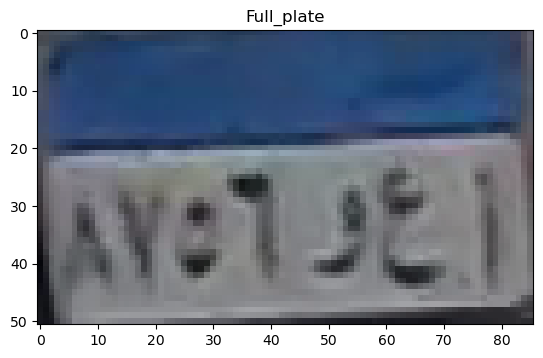

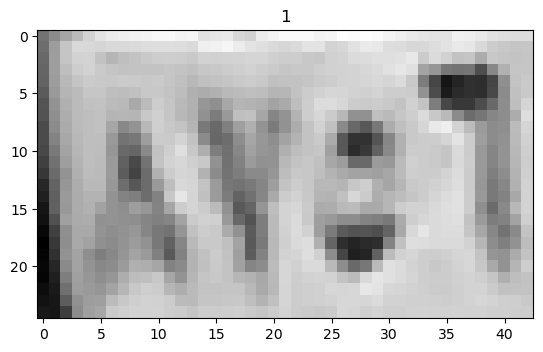

[0.30086667 0.28910196 0.27450196 0.26665882 0.26273725 0.24312941
 0.22744314 0.22352157 0.20529765 0.20529765 0.19745451 0.17784667
 0.1568549  0.11763922 0.10195294 0.07450196 0.06470941 0.04510157
 0.02382706 0.03559176 0.0411949  0.03727333 0.05688118 0.06864588
 0.08265059]
[0.3596902  0.40282745 0.40391373 0.40391373 0.39999216 0.39214902
 0.38038431 0.36861961 0.35823882 0.34255255 0.31902314 0.29941529
 0.2823451  0.26273725 0.25489412 0.25881569 0.22157216 0.1784349
 0.16108196 0.14147412 0.11570471 0.10001843 0.08825373 0.08041059
 0.07872902]
[0.42360392 0.49811373 0.49776353 0.48207725 0.46665882 0.45881569
 0.44705098 0.43920784 0.43528627 0.42744314 0.41567843 0.40391373
 0.38038431 0.38822745 0.39412118 0.39019961 0.40814078 0.3689251
 0.36697569 0.37874039 0.35521098 0.32776    0.29441529 0.24735647
 0.17284667]
After
[0.42360392 0.49811373 0.49776353 0.48207725 0.46665882 0.45881569
 0.44705098 0.43920784 0.43528627 0.42744314 0.41567843 0.40391373
 0.38038431 0.38822

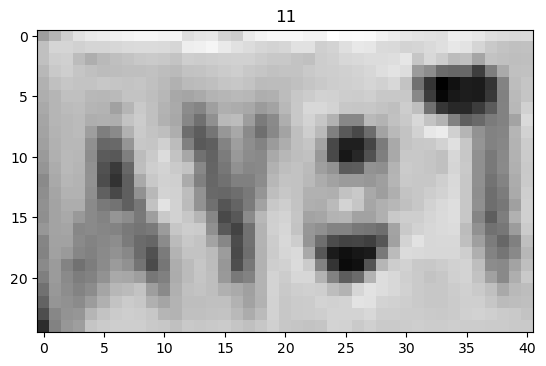

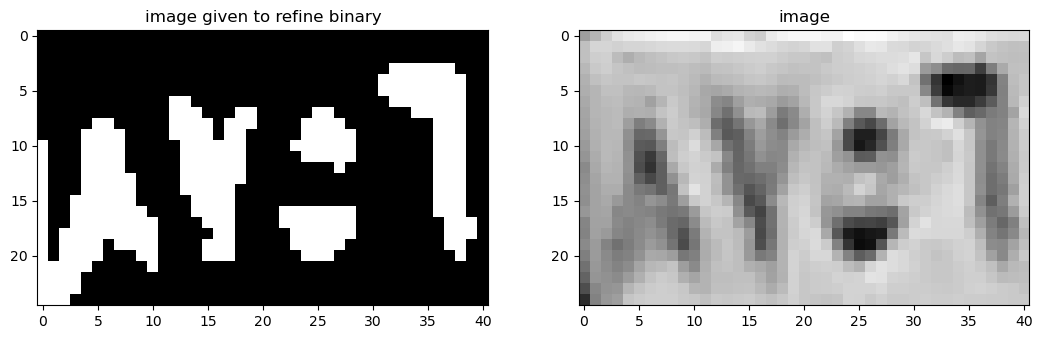

[False False False False False False False False False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True]
After
[False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False]


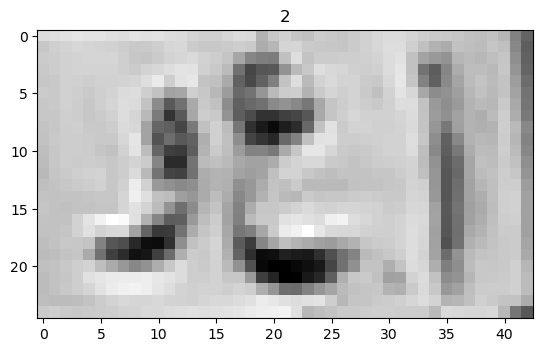

[0.56004118 0.51690392 0.52471725 0.52079569 0.51656863 0.52441176
 0.51599529 0.51599529 0.51010157 0.50618    0.49833686 0.49441529
 0.48992824 0.50169294 0.50953608 0.51345765 0.51120275 0.50728118
 0.49943804 0.49551647 0.50335961 0.49551647 0.49551647 0.49943804
 0.52186627]
[0.56396275 0.5325902  0.52863882 0.52863882 0.5204902  0.5204902
 0.51991686 0.51599529 0.51599529 0.51991686 0.51599529 0.51599529
 0.51402314 0.51010157 0.50618    0.50618    0.50618    0.50618
 0.50784667 0.50000353 0.50784667 0.50784667 0.50784667 0.49608196
 0.52970941]
[0.56788431 0.54043333 0.53648196 0.53648196 0.53617647 0.53617647
 0.53560314 0.53168157 0.52776    0.52776    0.52776    0.52776
 0.52186627 0.51794471 0.51010157 0.50225843 0.50618    0.51402314
 0.51961137 0.51176824 0.51961137 0.5156898  0.51961137 0.49608196
 0.52186627]
After
[0.56004118 0.51690392 0.52471725 0.52079569 0.51656863 0.52441176
 0.51599529 0.51599529 0.51010157 0.50618    0.49833686 0.49441529
 0.48992824 0.50169294 0

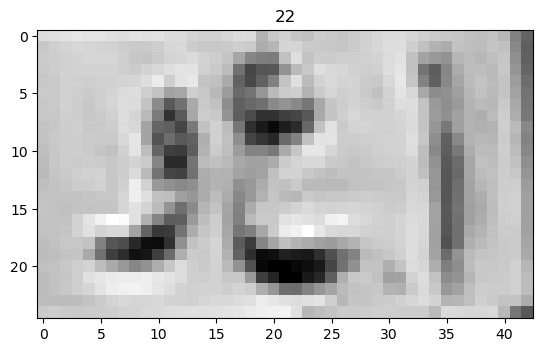

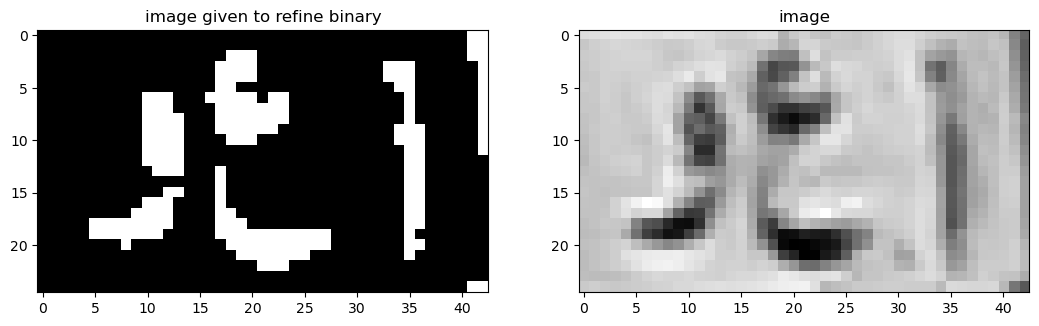

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
to horizonatal


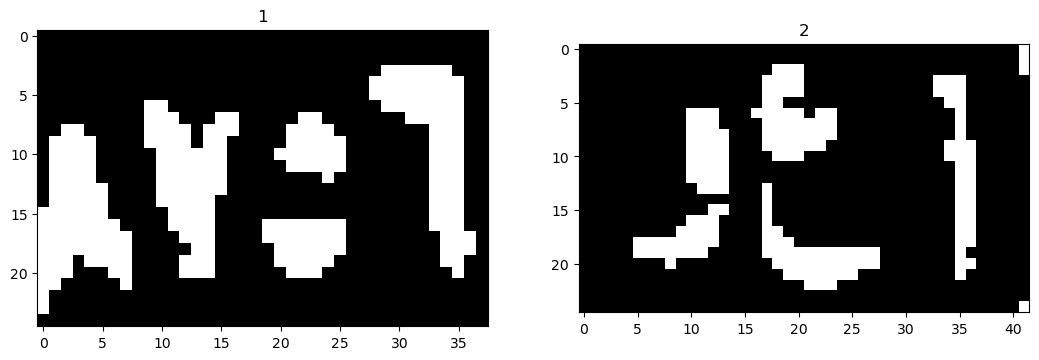

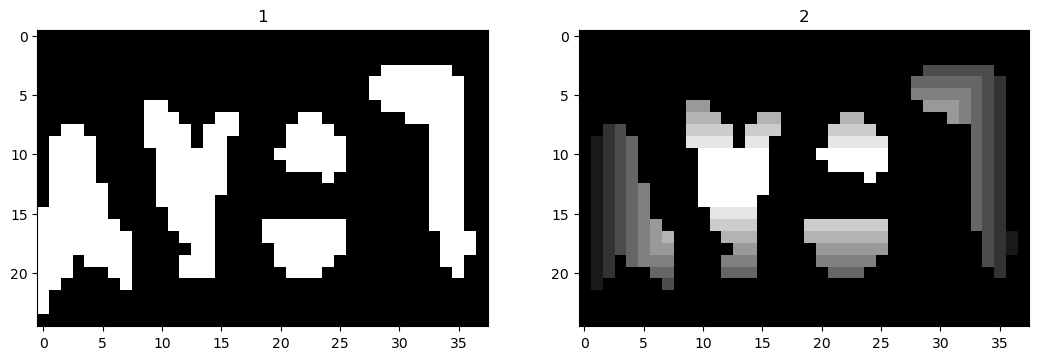

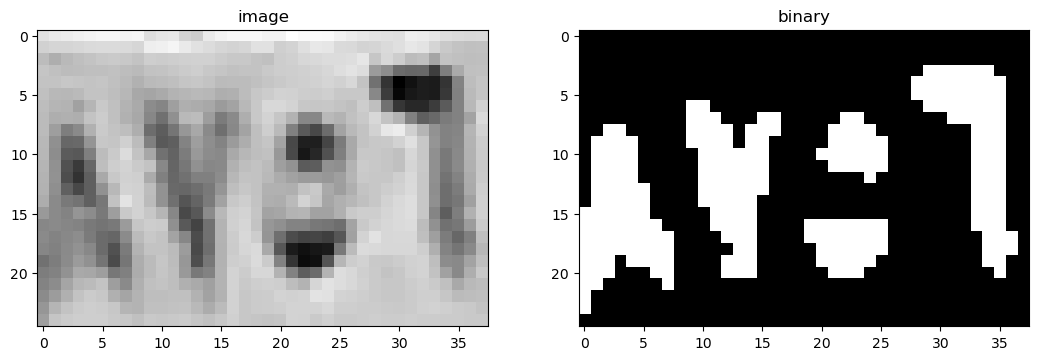

0 8
9 17
19 26
28 37
[(0, 8, array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False,  True,  True, False, False, False, False, False],
       [False,  True,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True,

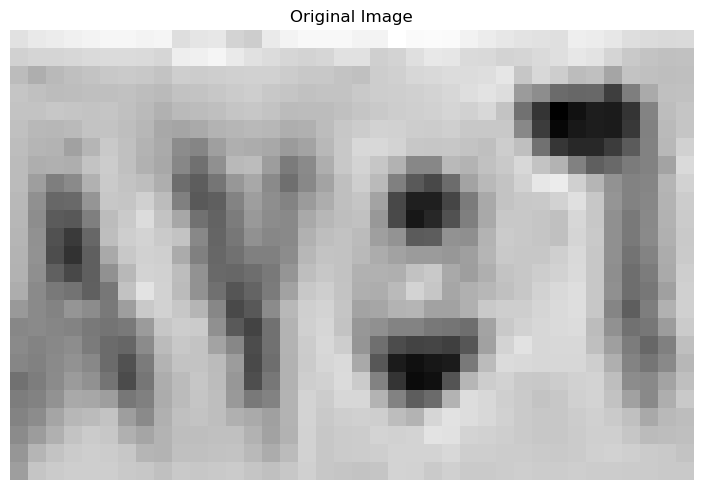

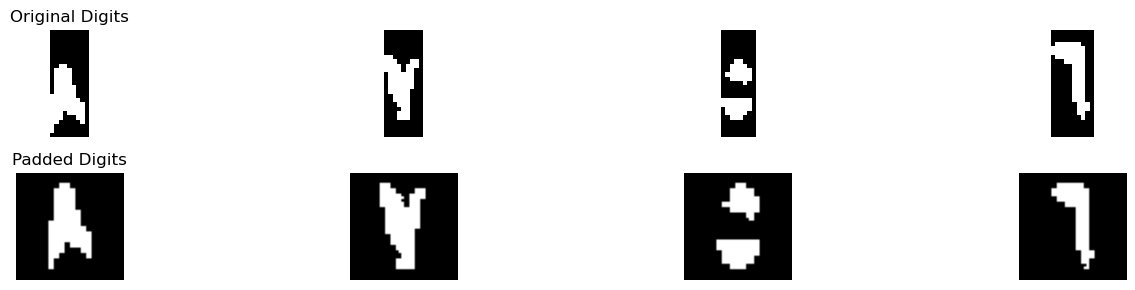

Best match: ٨
Full comparison results: {'١': 2.09375, '٢': 2.15625, '٣': 1.5958784829721362, '٤': 2.0, '٥': 1.8881901444788445, '٦': 0.6125, '٧': 1.086764705882353, '٨': 4.434722222222222, '٩': 3.3933823529411766}
Confidence :  0.5206699346405226
Best match: ٧
Full comparison results: {'١': 0.823529411764706, '٢': 1.959558823529412, '٣': 3.245065789473684, '٤': 1.740808823529412, '٥': 2.422572976559045, '٦': 1.8327205882352944, '٧': 3.6113970588235293, '٨': 1.3380718954248367, '٩': 2.1149918300653594}
Confidence :  0.18316563467492264
Best match: ٥
Full comparison results: {'١': 0.625, '٢': 1.84375, '٣': 1.12296826625387, '٤': 2.4375, '٥': 5.81859059413239, '٦': 1.9, '٧': 0.9433823529411764, '٨': 0.8583333333333334, '٩': 0.7083333333333333}
Confidence :  1.690545297066195
Best match: ٦
Full comparison results: {'١': 2.0, '٢': 0.71875, '٣': 1.2879256965944272, '٤': 0.125, '٥': 2.7555976337903583, '٦': 5.90625, '٧': 0.2426470588235294, '٨': 1.2944444444444445, '٩': 2.8860294117647056}
Co

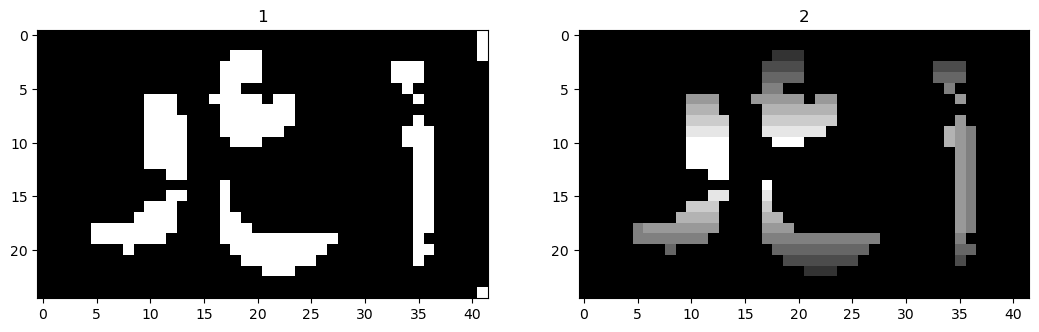

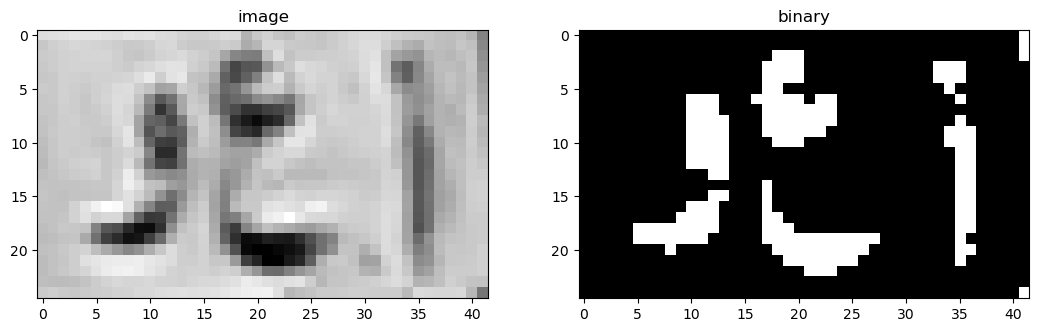

5 14
16 28
33 37
[(5, 14, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False,  True,  True,  True, False,
        False],
       [False, False, False, False, False,  True,  True,  True, False,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, Fa

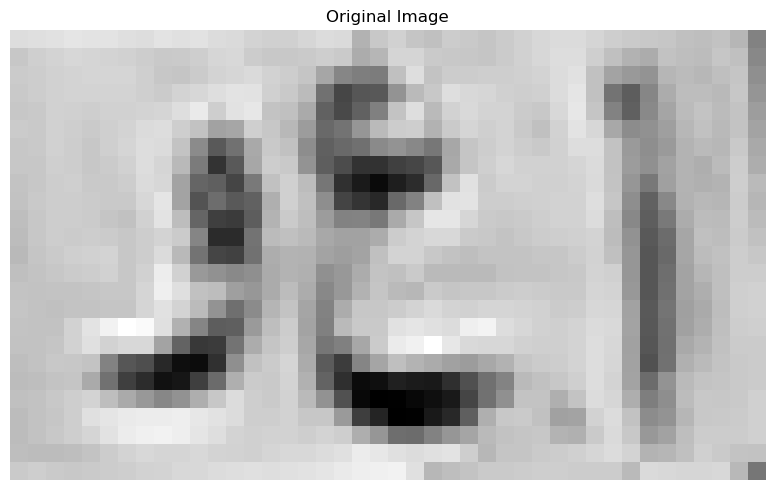

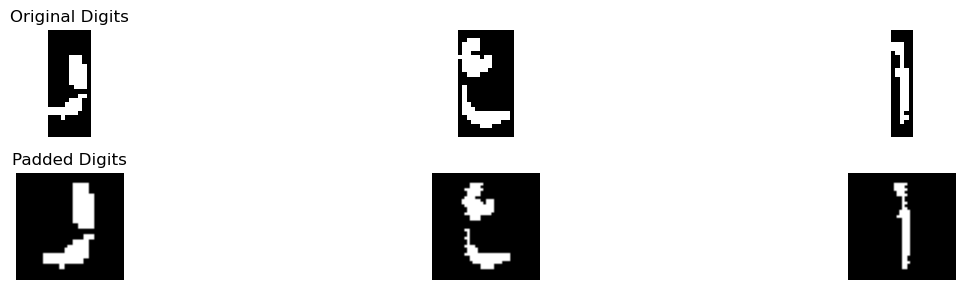

Best match: و
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.125, 'د': 0.7471590909090909, 'ر': 0.5355603448275862, 'س': 0.53125, 'ص': 0.1875, 'ط': 0.4583333333333333, 'ع': 0.09375, 'ف': 0.3900462962962963, 'ق': 0.3881578947368421, 'ك': 0.34375, 'ل': 0.5148026315789473, 'م': 0.08388157894736842, 'ن': 0.525, 'ه': 0.59375, 'و': 1.09375, 'ي': 0.625}
Confidence :  0.17329545454545453
Best match: ع
Full comparison results: {'أ': 0.0, 'ب': 0.0625, 'ج': 0.5353260869565217, 'د': 0.4431818181818182, 'ر': 0.3351293103448276, 'س': 0.125, 'ص': 0.0, 'ط': 0.26041666666666663, 'ع': 1.0394736842105263, 'ف': 0.18518518518518517, 'ق': 0.09375, 'ك': 0.3541666666666667, 'ل': 0.26041666666666663, 'م': 0.2847222222222222, 'ن': 0.525, 'ه': 0.03125, 'و': 0.29166666666666663, 'ي': 0.2860576923076923}
Confidence :  0.2520737986270023
Best match: أ
Full comparison results: {'أ': 0.90625, 'ب': 0.0, 'ج': 0.11820652173913043, 'د': 0.0625, 'ر': 0.0, 'س': 0.03125, 'ص': 0.0, 'ط': 0.13541666666666666, 'ع': 0.0526

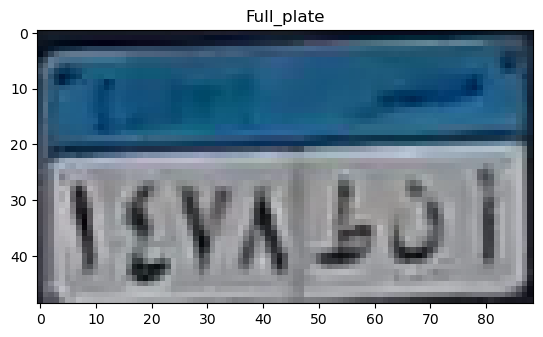

2.0 43.0 4.0 29.0


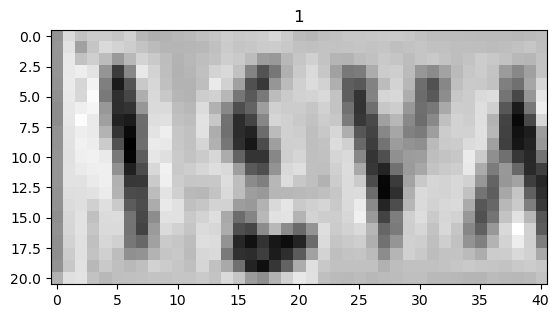

[0.4555498  0.45947137 0.45885333 0.45885333 0.45462627 0.44286157
 0.43501843 0.43501843 0.45462627 0.45462627 0.45854784 0.45854784
 0.45854784 0.45462627 0.44903804 0.43727333 0.44903804 0.4411949
 0.4411949  0.45295961 0.53979961]
[0.66339294 0.68692235 0.70199059 0.70591216 0.70952824 0.70560667
 0.7016851  0.69776353 0.68992039 0.68599882 0.68207725 0.68599882
 0.68599882 0.67423412 0.66472431 0.65295961 0.64903804 0.63727333
 0.62158706 0.60982235 0.68097608]
[0.5907949  0.49275569 0.59019961 0.71961137 0.64902314 0.65294471
 0.72353294 0.76274863 0.72156078 0.72940392 0.72353294 0.70784667
 0.68431725 0.67647412 0.67647412 0.68431725 0.68431725 0.68039569
 0.67872902 0.68657216 0.68825373]
After
[0.4555498  0.45947137 0.45885333 0.45885333 0.45462627 0.44286157
 0.43501843 0.43501843 0.45462627 0.45462627 0.45854784 0.45854784
 0.45854784 0.45462627 0.44903804 0.43727333 0.44903804 0.4411949
 0.4411949  0.45295961 0.53979961]


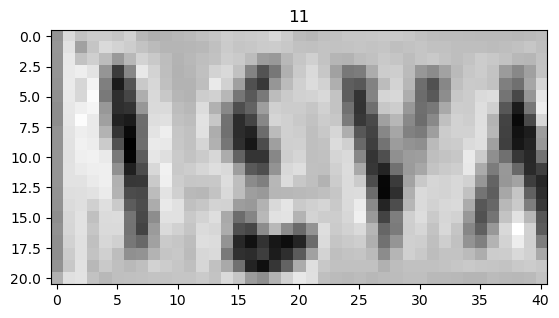

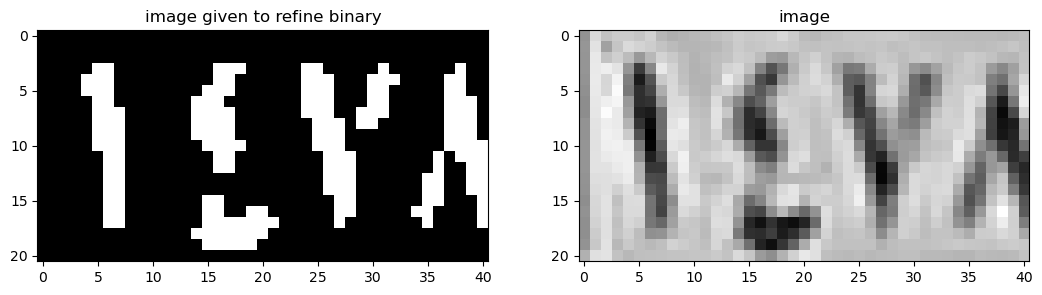

[False False False False False False False False False False False False
 False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False]
0.0 43.0 2.0 29.0


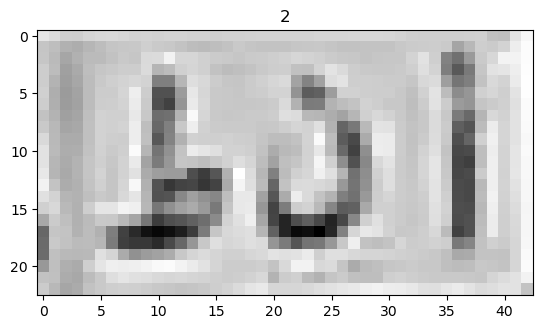

[0.66418941 0.5779149  0.57901529 0.59862314 0.59833333 0.60617647
 0.59943451 0.56806196 0.58823529 0.63137255 0.65463412 0.65463412
 0.67088588 0.69833686 0.65127804 0.60814078 0.49833686 0.32186627
 0.33363098 0.33755255 0.45519961 0.5689251  0.59245451]
[0.64066    0.55830706 0.54764275 0.55156431 0.53166667 0.51598039
 0.51708157 0.52884627 0.54117647 0.54509804 0.54875176 0.53698706
 0.53363098 0.57284667 0.61598392 0.62774863 0.59245451 0.57676824
 0.58853294 0.56500353 0.56108196 0.56500353 0.54147412]
[0.60536588 0.52301294 0.49217529 0.47648902 0.47284314 0.465
 0.46610118 0.47786588 0.49019608 0.50588235 0.51120275 0.50728118
 0.50225843 0.51010157 0.53363098 0.54539569 0.56108196 0.57284667
 0.5689251  0.54539569 0.51794471 0.51010157 0.49441529]
After
[0.66418941 0.5779149  0.57901529 0.59862314 0.59833333 0.60617647
 0.59943451 0.56806196 0.58823529 0.63137255 0.65463412 0.65463412
 0.67088588 0.69833686 0.65127804 0.60814078 0.49833686 0.32186627
 0.33363098 0.33755255 0

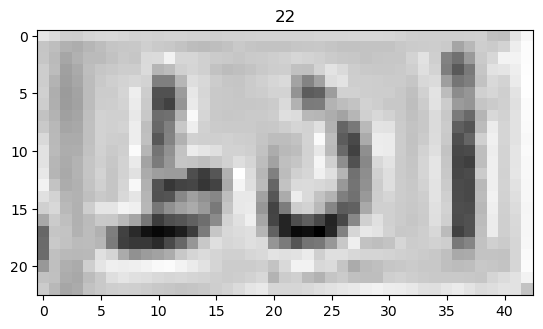

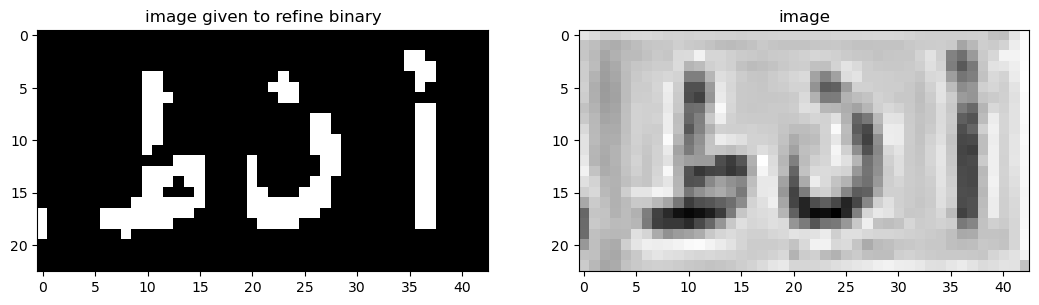

[False False False False False False False False False False False False
 False False False False False  True  True  True False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False  True  True  True False False False]
to horizonatal


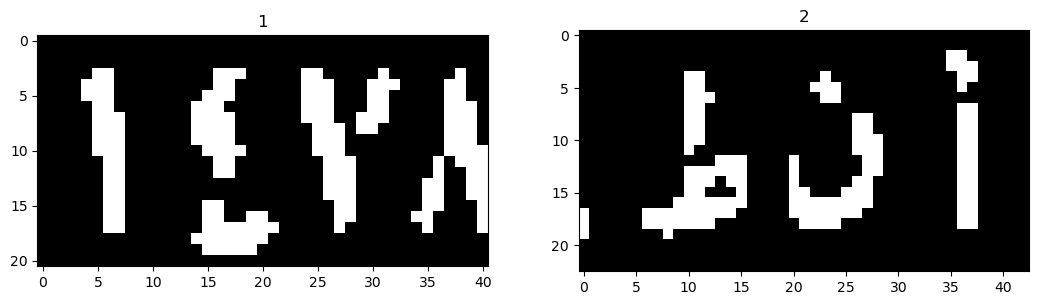

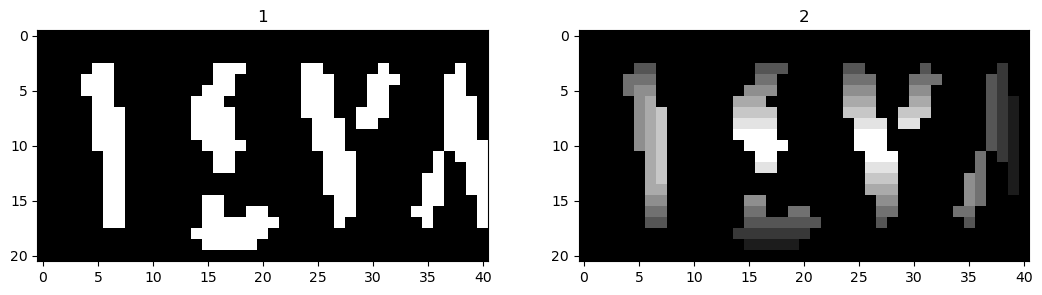

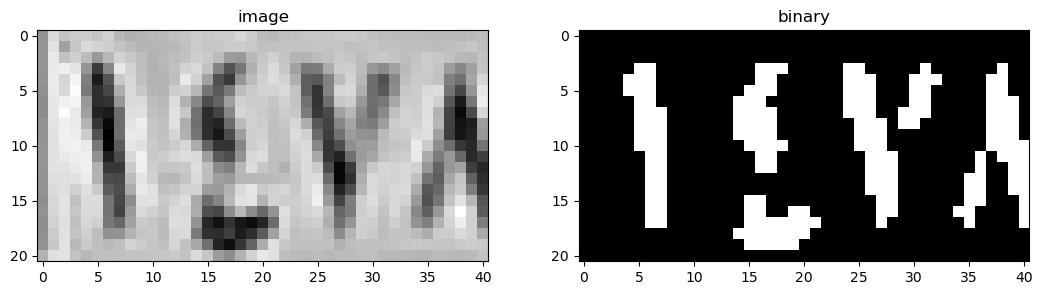

4 8
14 22
24 33
34 40
[(4, 8, array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])), (14, 22, array([[False, False, False, False

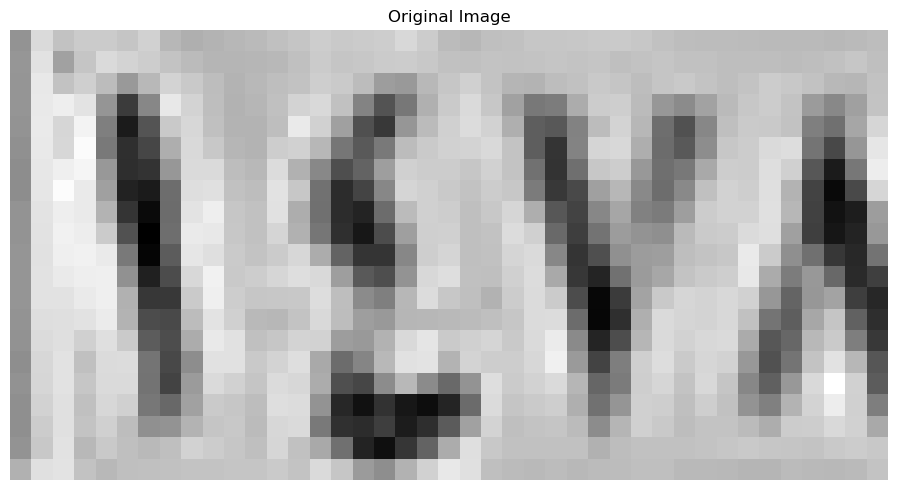

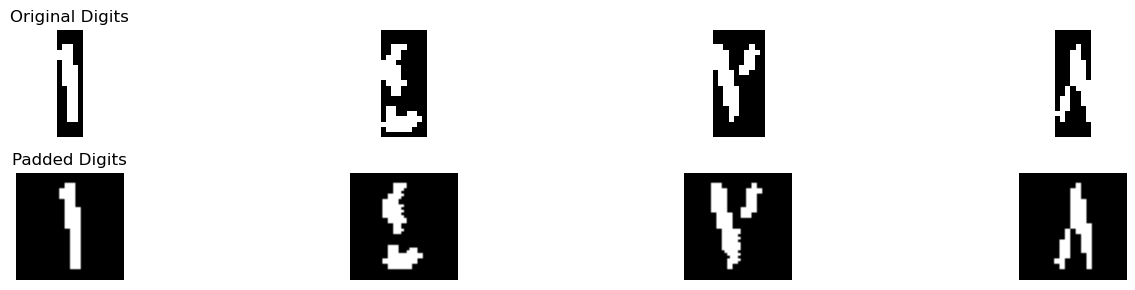

Best match: ١
Full comparison results: {'١': 6.41875, '٢': 2.2157634032634035, '٣': 0.6776315789473684, '٤': 1.6845009157509157, '٥': 1.70922250479139, '٦': 1.6473214285714286, '٧': 0.8841911764705883, '٨': 2.4819444444444443, '٩': 2.285633484162896}
Confidence :  1.968402777777778
Best match: ٤
Full comparison results: {'١': 0.7791666666666666, '٢': 2.6875, '٣': 1.5083204334365325, '٤': 5.90981182795699, '٥': 2.526186790505676, '٦': 0.0, '٧': 0.836764705882353, '٨': 0.7104166666666667, '٩': 1.8034313725490196}
Confidence :  1.6111559139784948
Best match: ٧
Full comparison results: {'١': 0.0, '٢': 1.0921052631578947, '٣': 2.2302631578947367, '٤': 0.8618421052631579, '٥': 1.0735432330827066, '٦': 0.2578947368421053, '٧': 3.9098684210526313, '٨': 0.28651315789473686, '٩': 0.8601973684210525}
Confidence :  0.8398026315789473
Best match: ٨
Full comparison results: {'١': 1.8392857142857144, '٢': 0.0, '٣': 0.3125, '٤': 1.0979166666666667, '٥': 1.8089294928497712, '٦': 1.5497023809523809, '٧'

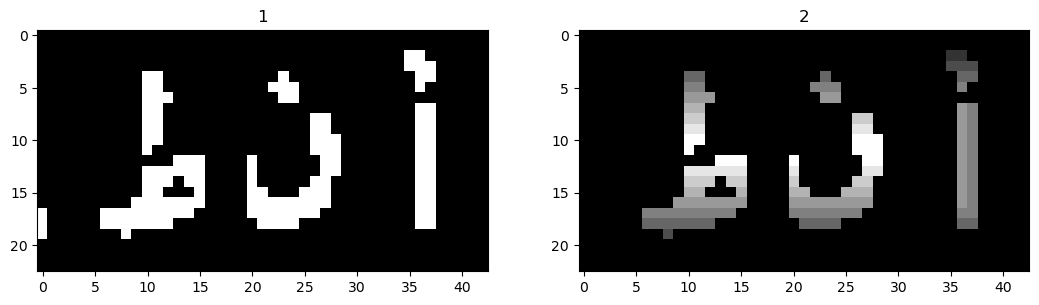

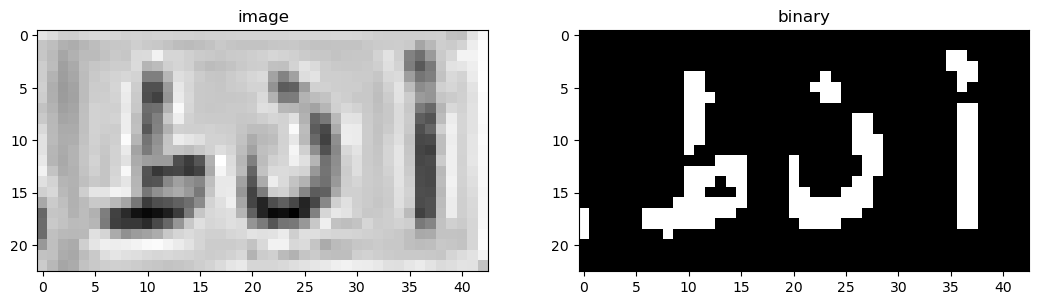

0 1
6 16
20 29
35 38
[(6, 16, array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, F

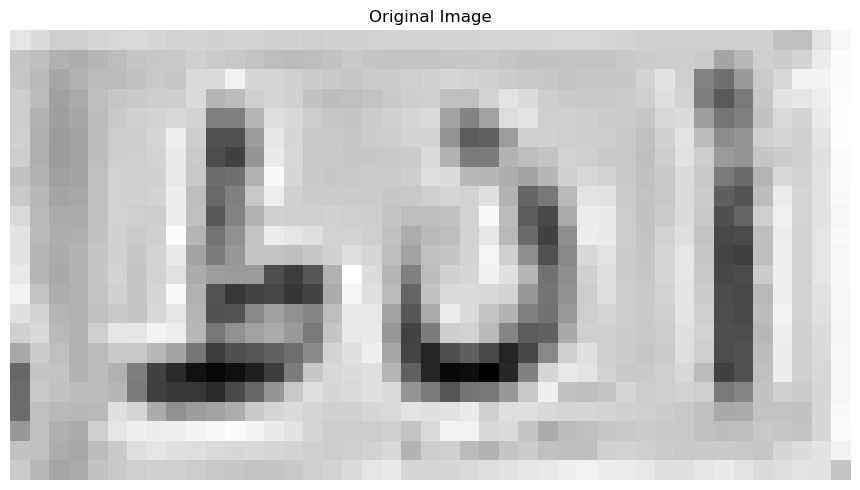

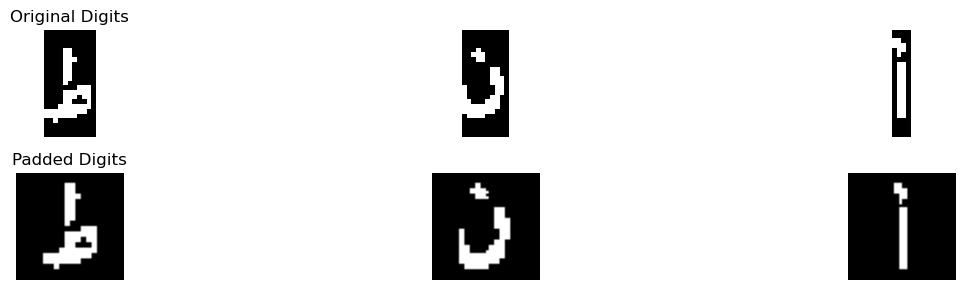

Best match: ط
Full comparison results: {'أ': 0.2125, 'ب': 0.0625, 'ج': 0.29891304347826086, 'د': 0.7642045454545454, 'ر': 0.5075431034482758, 'س': 0.34375, 'ص': 0.15625, 'ط': 1.1875, 'ع': 0.09375, 'ف': 0.3900462962962963, 'ق': 0.575, 'ك': 0.34375, 'ل': 0.34375, 'م': 0.03125, 'ن': 0.58125, 'ه': 0.28125, 'و': 0.46875, 'ي': 0.7716346153846154}
Confidence :  0.2079326923076923
Best match: ق
Full comparison results: {'أ': 0.05263157894736842, 'ب': 0.09375, 'ج': 0.5163043478260869, 'د': 0.9034090909090909, 'ر': 0.3351293103448276, 'س': 0.28125, 'ص': 0.09375, 'ط': 0.4895833333333333, 'ع': 0.6085526315789473, 'ف': 0.6747685185185185, 'ق': 1.1280701754385964, 'ك': 0.4166666666666667, 'ل': 0.6825657894736842, 'م': 0.05263157894736842, 'ن': 0.7435483870967743, 'ه': 0.25, 'و': 0.5, 'ي': 0.6802884615384616}
Confidence :  0.11233054226475275
Best match: أ
Full comparison results: {'أ': 1.4451612903225808, 'ب': 0.03125, 'ج': 0.13043478260869565, 'د': 0.03125, 'ر': 0.0, 'س': 0.0, 'ص': 0.0625, 'ط': 0.1

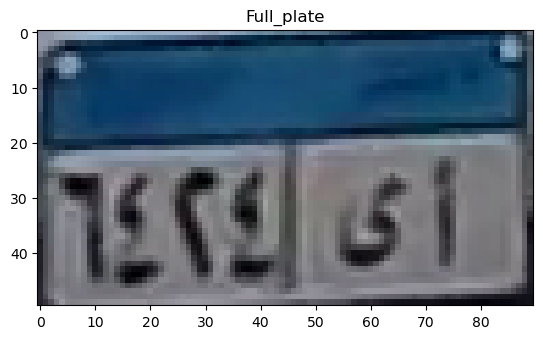

2.0 44.0 2.0 29.0


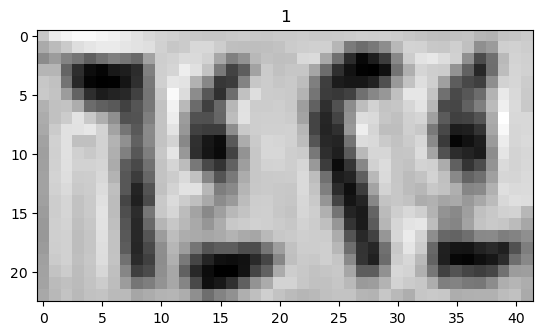

[0.49760863 0.42500353 0.34657216 0.45214902 0.49528627 0.50144784
 0.44262431 0.42861961 0.42077647 0.40565569 0.39781255 0.40059529
 0.40451686 0.40451686 0.40059529 0.39021451 0.38237137 0.38011647
 0.38795961 0.39972431 0.40364588 0.40756745 0.41933216]
[0.58528196 0.46783529 0.38940392 0.45127804 0.48265059 0.48854431
 0.48070118 0.48238275 0.50591216 0.52216392 0.51824235 0.52216392
 0.52608549 0.52019176 0.51234863 0.51234863 0.5162702  0.51737137
 0.5134498  0.50560667 0.48992039 0.46639098 0.45854784]
[0.60881137 0.50312941 0.32665882 0.25127804 0.28657216 0.3905051
 0.48854431 0.50983373 0.56081412 0.56137961 0.56137961 0.55745804
 0.55353647 0.54372118 0.53195647 0.53195647 0.5280349  0.52129294
 0.52129294 0.52129294 0.50952824 0.47815569 0.48992039]
After
[0.49760863 0.42500353 0.34657216 0.45214902 0.49528627 0.50144784
 0.44262431 0.42861961 0.42077647 0.40565569 0.39781255 0.40059529
 0.40451686 0.40451686 0.40059529 0.39021451 0.38237137 0.38011647
 0.38795961 0.399724

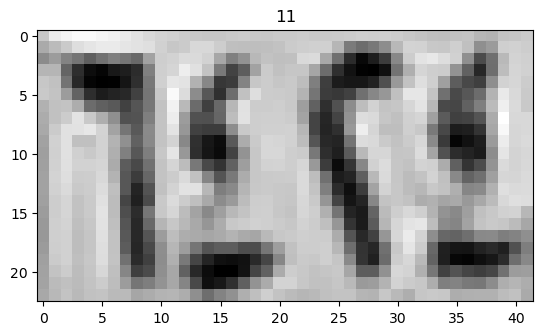

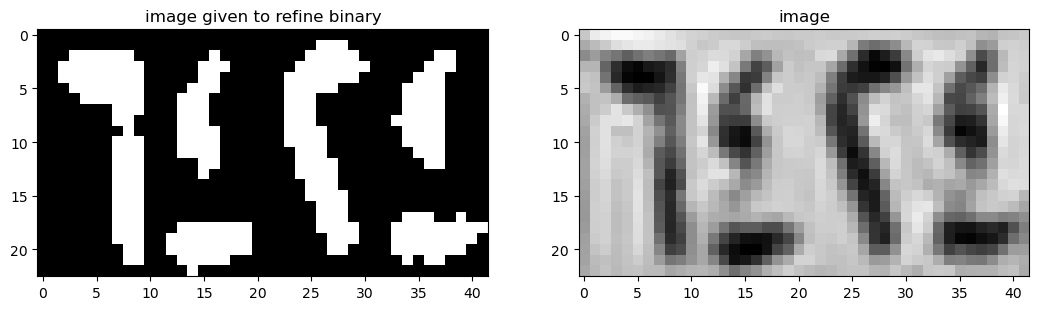

[False False False False False False False False False False False False
 False False False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False]
[False False False  True  True False False False False False False False
 False False False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False]


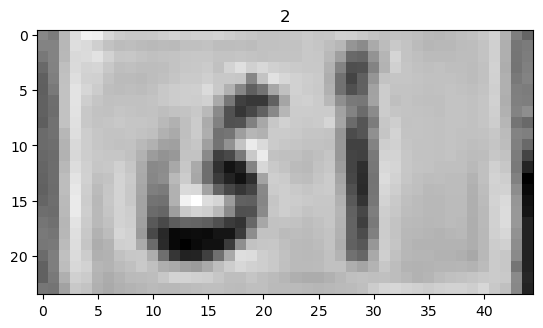

[0.35360392 0.34792549 0.32047451 0.28765059 0.26412118 0.26215686
 0.26607843 0.2674851  0.25964196 0.2890651  0.2890651  0.28347686
 0.27563373 0.27171216 0.26779059 0.27619922 0.29580706 0.31205882
 0.32382353 0.31794471 0.29049373 0.27031255 0.27031255 0.31401529]
[0.32615294 0.34400392 0.34400392 0.34255255 0.33470941 0.32098039
 0.29745098 0.29493608 0.30277922 0.30475137 0.29690824 0.29132
 0.29524157 0.29524157 0.29132    0.29580706 0.29188549 0.30029412
 0.31205882 0.32186627 0.33363098 0.33305765 0.32129294 0.31009373]
[0.46535725 0.46331765 0.46723922 0.4825902  0.48651176 0.48930235
 0.48930235 0.48904235 0.48904235 0.46356353 0.45572039 0.45377098
 0.46553569 0.47730039 0.47730039 0.47227765 0.46835608 0.46107843
 0.465      0.47255255 0.48431725 0.47815569 0.44678314 0.41597608]
After
[0.35360392 0.34792549 0.32047451 0.28765059 0.26412118 0.26215686
 0.26607843 0.2674851  0.25964196 0.2890651  0.2890651  0.28347686
 0.27563373 0.27171216 0.26779059 0.27619922 0.29580706 

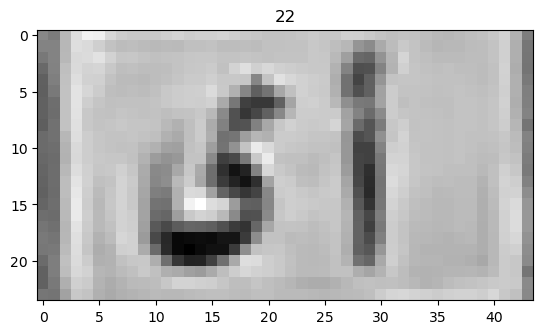

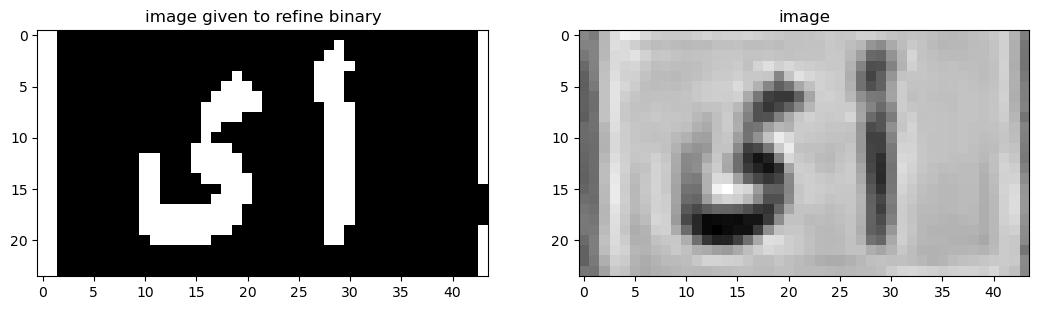

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
to horizonatal


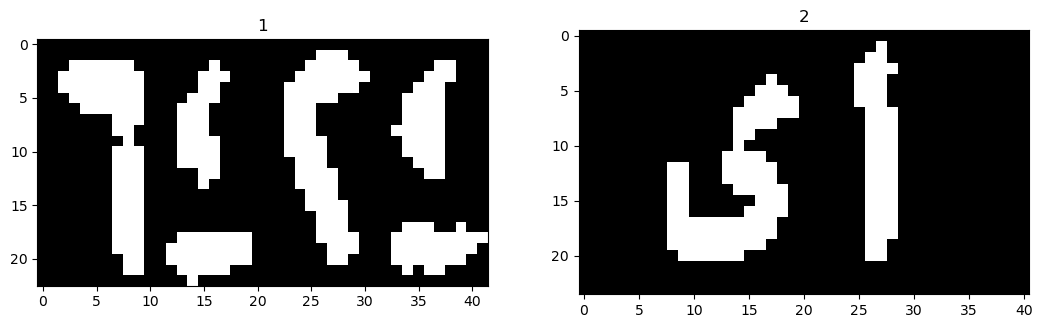

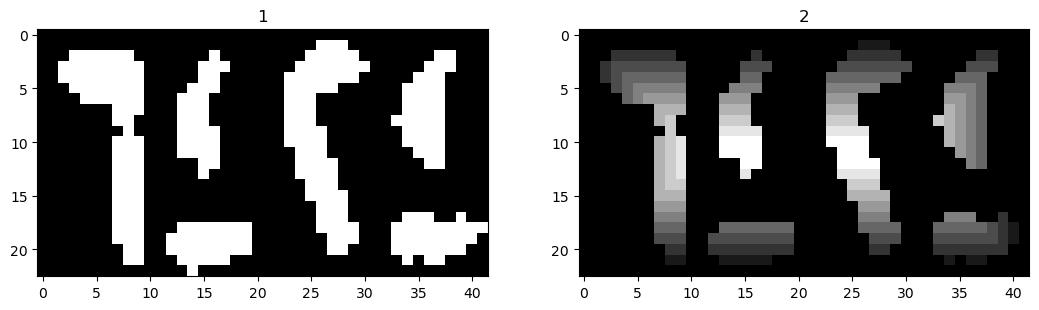

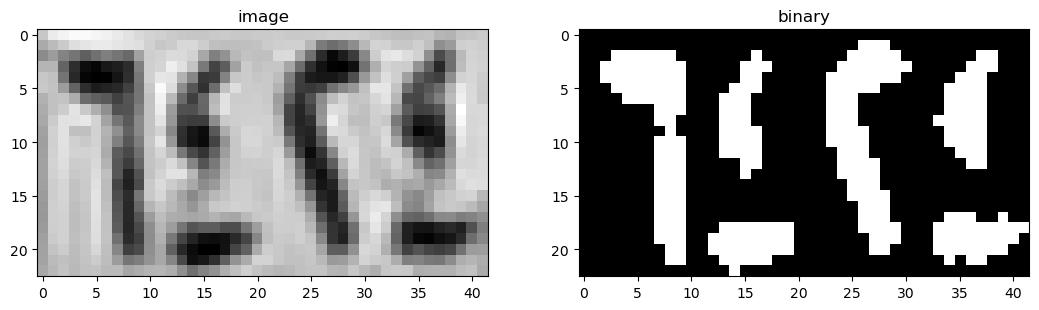

2 10
12 20
23 31
33 41
[(2, 10, array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False,  True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True,  True, False],
       [False, False, False, False, False,  True,  True,  True, False],
       [False, False, False, False, False,  True,  True, False, False],
       [False, False, False, False, False, False,  True, False, False],
       [False, False, False, False, False,  True,  True,  True, False],
       [False, False, False, False, False,  True,  True,  True, False],
       [False, False, False, False, False,  True,  True,  True, False],
       [False, False, False, Fal

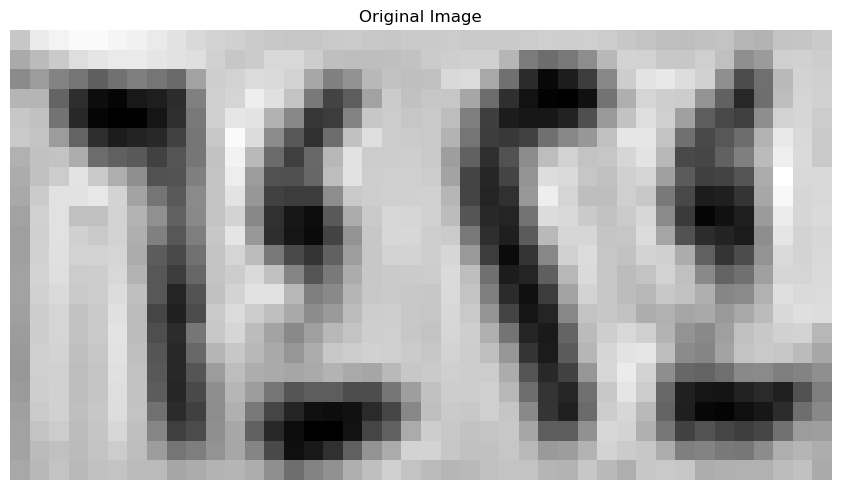

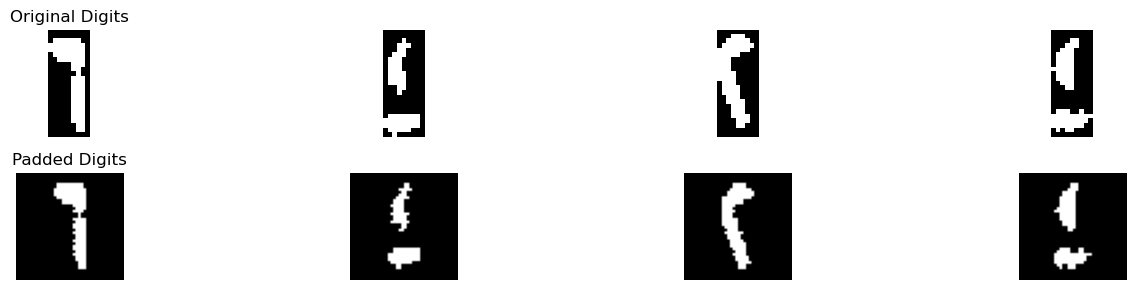

Best match: ٦
Full comparison results: {'١': 2.0208333333333335, '٢': 1.1642628205128205, '٣': 0.8228521671826625, '٤': 0.0625, '٥': 2.3933501031991744, '٦': 6.061309523809523, '٧': 0.1764705882352941, '٨': 0.8833333333333333, '٩': 2.505043363499246}
Confidence :  1.7781330801551387
Best match: ٤
Full comparison results: {'١': 1.5625, '٢': 1.3653846153846154, '٣': 1.40421826625387, '٤': 4.178301134349521, '٥': 2.197317742886628, '٦': 0.0, '٧': 0.19375, '٨': 1.6652777777777776, '٩': 1.4414749874308699}
Confidence :  0.9904916957314465
Best match: ٢
Full comparison results: {'١': 1.1875, '٢': 7.473557692307692, '٣': 3.8989938080495357, '٤': 3.1469551282051285, '٥': 2.3245061182367683, '٦': 0.8357142857142857, '٧': 2.415808823529412, '٨': 0.6729166666666667, '٩': 1.63032616892911}
Confidence :  1.787281942129078
Best match: ٤
Full comparison results: {'١': 2.1205357142857144, '٢': 1.4151785714285712, '٣': 1.9494969040247678, '٤': 6.001910522273426, '٥': 2.5076293675364885, '٦': 0.0, '٧': 

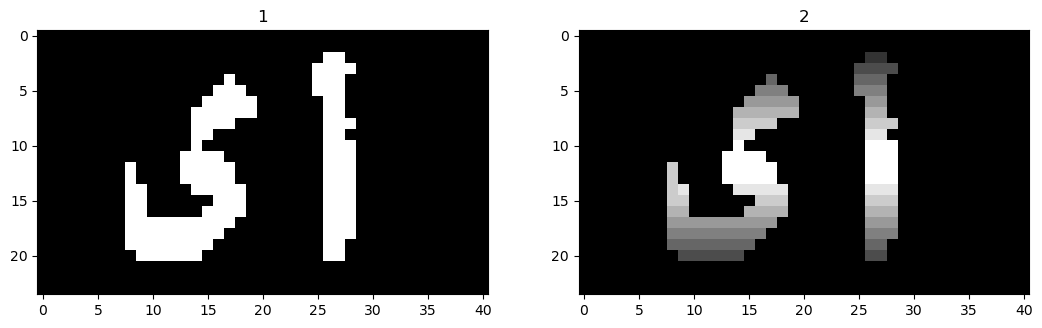

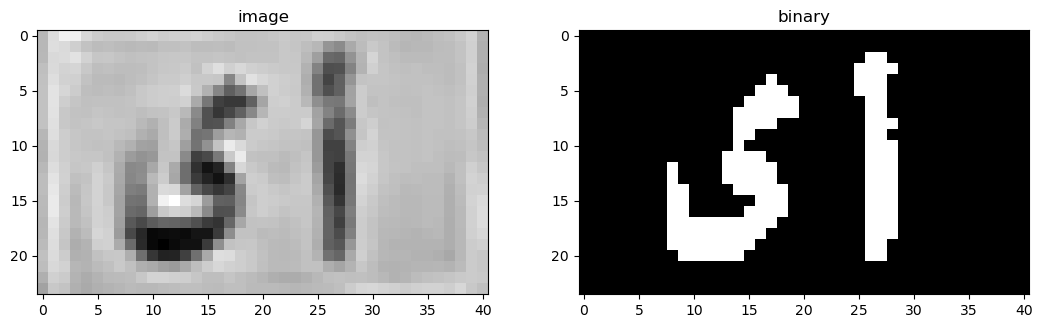

8 20
25 29
[(8, 20, array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
         True, False, False, False],
       [False, False, False, False, False, False, False, False,  True,
         True,  True, False, False],
       [False, False, False, False, False, False, False,  True,  True,
         True,  True,  True, False],
       [False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True, False],
       [False, False, False, False, False, False,  True,  True,  True,
         True, False, False, False],
       [

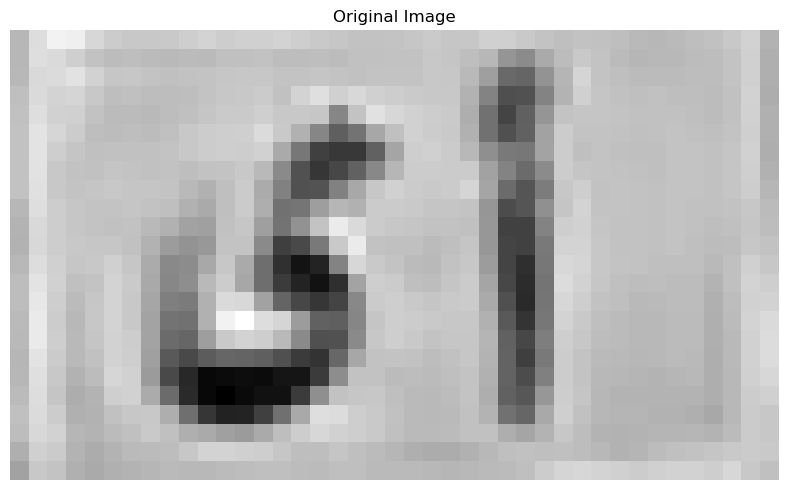

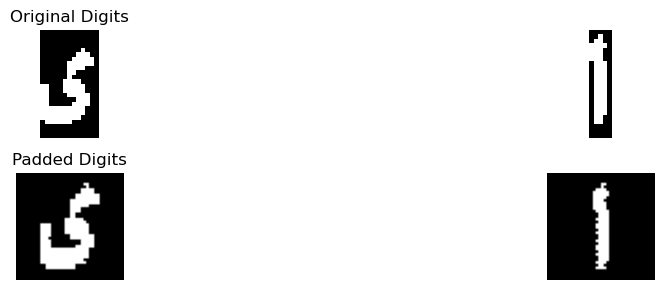

Best match: ي
Full comparison results: {'أ': 0.09090909090909091, 'ب': 0.03125, 'ج': 0.6100543478260869, 'د': 0.5823863636363636, 'ر': 0.3663793103448276, 'س': 0.375, 'ص': 0.375, 'ط': 0.4375, 'ع': 0.29261363636363635, 'ف': 0.3472222222222222, 'ق': 0.5340909090909092, 'ك': 0.4583333333333333, 'ل': 0.4119318181818182, 'م': 0.09375, 'ن': 0.5056818181818181, 'ه': 0.40625, 'و': 0.8229166666666666, 'ي': 0.8581730769230769}
Confidence :  0.01762820512820512
Best match: أ
Full comparison results: {'أ': 0.6875, 'ب': 0.09375, 'ج': 0.27989130434782605, 'د': 0.0625, 'ر': 0.0, 'س': 0.0, 'ص': 0.0, 'ط': 0.15625, 'ع': 0.0, 'ف': 0.0625, 'ق': 0.10526315789473684, 'ك': 0.0, 'ل': 0.0, 'م': 0.0, 'ن': 0.09375, 'ه': 0.09375, 'و': 0.11458333333333333, 'ي': 0.038461538461538464}
Confidence :  0.20380434782608697
[['٦', '٤', '٢', '٤'], ['ي', 'أ']]


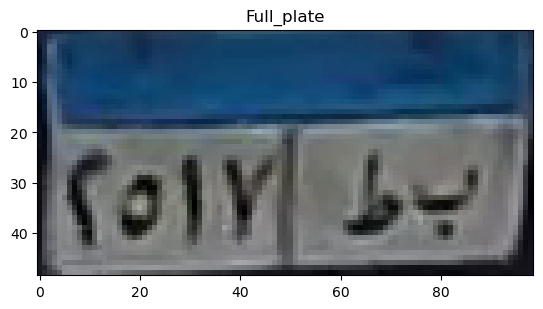

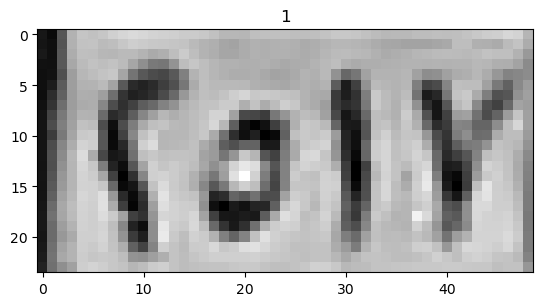

[0.06252196 0.05860039 0.06754471 0.04793686 0.04373255 0.04373255
 0.03727333 0.04903804 0.05688118 0.05688118 0.05688118 0.05688118
 0.05688118 0.05295961 0.05688118 0.05295961 0.05688118 0.06080275
 0.06472431 0.06472431 0.06080275 0.06864588 0.07648902 0.09217529]
[0.03031608 0.04208078 0.04291412 0.04683569 0.05157569 0.0751051
 0.11962627 0.13895137 0.17676824 0.20029765 0.15716039 0.19637608
 0.20814078 0.20421922 0.21766549 0.2294302  0.24903804 0.27648902
 0.29217529 0.27648902 0.27648902 0.28825373 0.29609686 0.28825373]
[0.22247294 0.21855137 0.22722784 0.2269451  0.20843843 0.23588941
 0.25295961 0.28433216 0.31010157 0.32578784 0.31010157 0.34539569
 0.35716039 0.37284667 0.38629294 0.39413608 0.41374392 0.4294302
 0.42550863 0.40590078 0.39021451 0.41766549 0.4294302  0.3666851 ]
After
[0.22247294 0.21855137 0.22722784 0.2269451  0.20843843 0.23588941
 0.25295961 0.28433216 0.31010157 0.32578784 0.31010157 0.34539569
 0.35716039 0.37284667 0.38629294 0.39413608 0.41374392

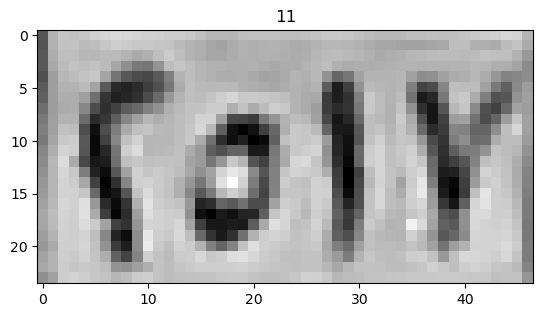

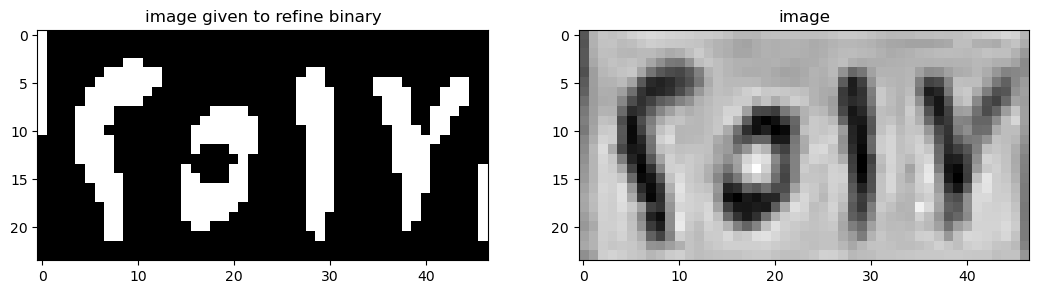

[ True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
0.0 48.0 0.0 26.0


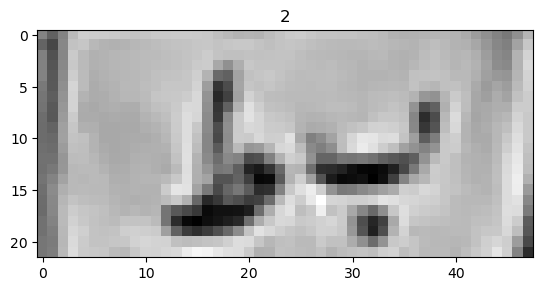

[0.3375902  0.26308039 0.32914392 0.33306549 0.33612392 0.31259451
 0.3030698  0.29914824 0.28484588 0.28092431 0.28092431 0.28876745
 0.29550157 0.29158    0.29998863 0.28822392 0.28235294 0.27843137
 0.29411765 0.29411765 0.30588235 0.30588235]
[0.25523725 0.19332549 0.21934    0.22718314 0.23416314 0.23808471
 0.24816784 0.23640314 0.23386549 0.26131647 0.27700275 0.28120706
 0.29550157 0.31035451 0.33920431 0.35489059 0.34901961 0.34509804
 0.3372549  0.3254902  0.31764706 0.32156863]
[0.3375902  0.34543333 0.3448302  0.34875176 0.35629725 0.36414039
 0.37365804 0.38542275 0.3946498  0.40641451 0.40698    0.39521529
 0.38121059 0.3854149  0.41371412 0.4411651  0.45882353 0.46666667
 0.46666667 0.4627451  0.46107843 0.465     ]
After
[0.3375902  0.26308039 0.32914392 0.33306549 0.33612392 0.31259451
 0.3030698  0.29914824 0.28484588 0.28092431 0.28092431 0.28876745
 0.29550157 0.29158    0.29998863 0.28822392 0.28235294 0.27843137
 0.29411765 0.29411765 0.30588235 0.30588235]


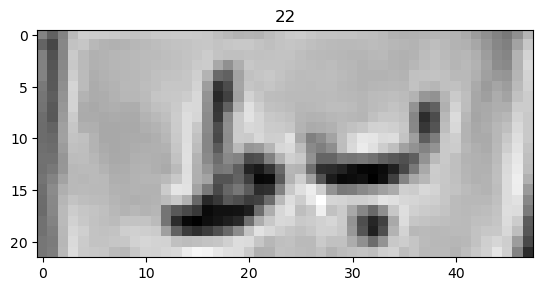

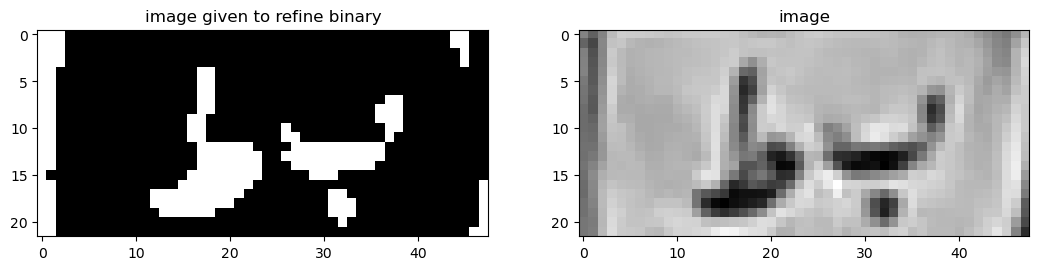

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True]
[ True  True  True  True False False False False False False False False
 False False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False]
to horizonatal


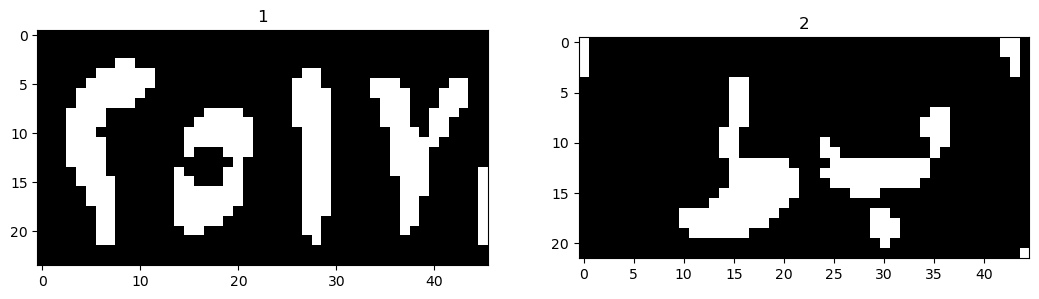

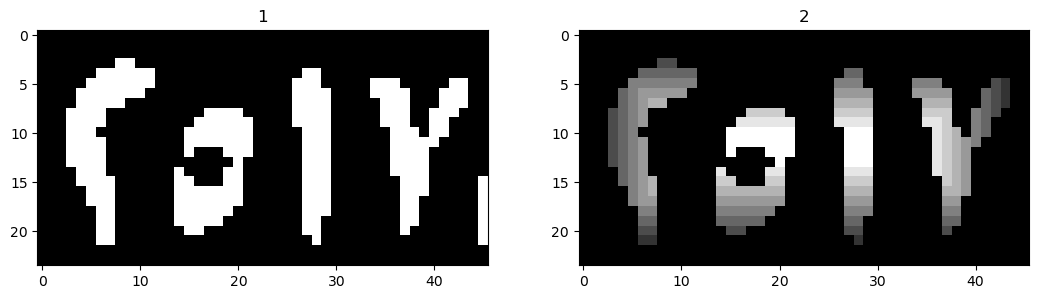

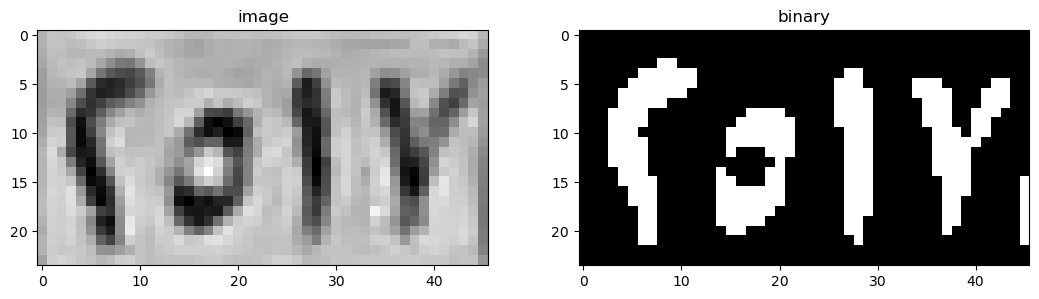

3 12
14 22
26 30
34 44
[(3, 12, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False,  True,  True, False, False,
        False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
        False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
        False],
       [False,  True,  True,  True,  True,  True,  True,  True, False,
        False],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True,  True, False, False, False, False, False, False,
        False],
       [ Tr

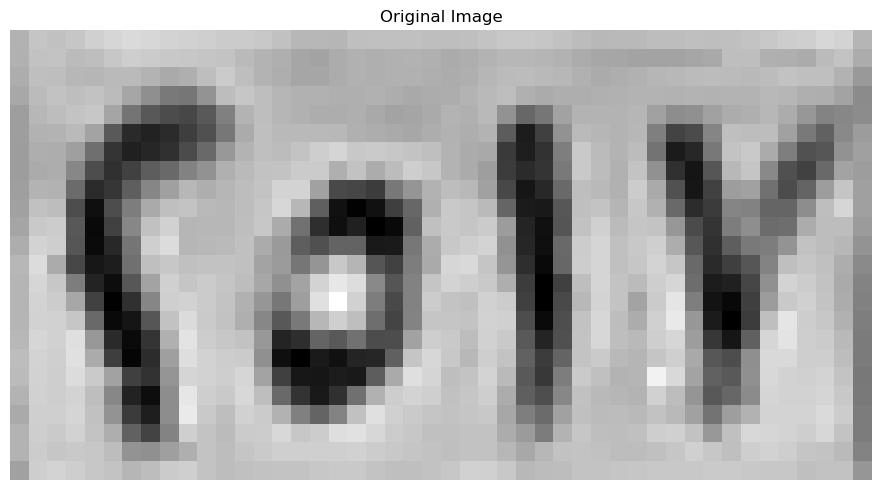

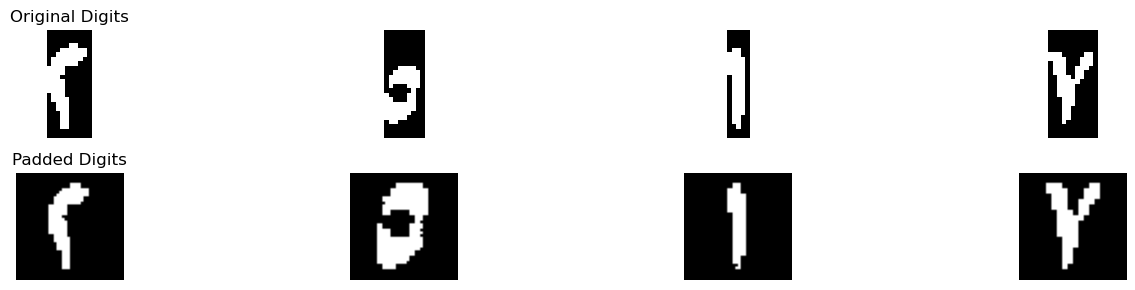

Best match: ٣
Full comparison results: {'١': 0.0, '٢': 3.5374999999999996, '٣': 4.268769349845201, '٤': 2.6083333333333334, '٥': 2.2802548651039363, '٦': 1.34375, '٧': 1.6330882352941178, '٨': 0.5618055555555556, '٩': 1.0741830065359477}
Confidence :  0.3656346749226005
Best match: ٥
Full comparison results: {'١': 0.7368421052631577, '٢': 1.4786184210526316, '٣': 1.633223684210526, '٤': 1.6480263157894735, '٥': 6.719376566416041, '٦': 2.094736842105263, '٧': 1.4124999999999999, '٨': 1.1434210526315787, '٩': 0.5674342105263157}
Confidence :  2.312319862155389
Best match: ١
Full comparison results: {'١': 5.171428571428571, '٢': 2.5490967365967365, '٣': 1.1365131578947367, '٤': 1.5193223443223443, '٥': 1.2212793011941618, '٦': 0.750892857142857, '٧': 1.347794117647059, '٨': 2.0527777777777776, '٩': 1.4806906737053795}
Confidence :  1.3111659174159171
Best match: ٧
Full comparison results: {'١': 0.30000000000000004, '٢': 1.69375, '٣': 2.9625000000000004, '٤': 1.59375, '٥': 1.12321428571428

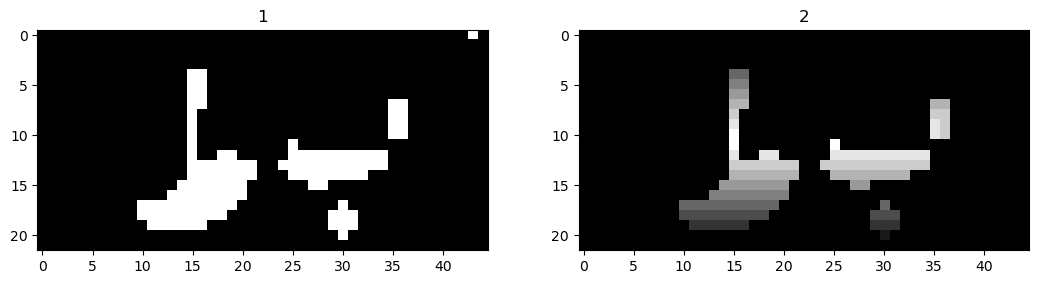

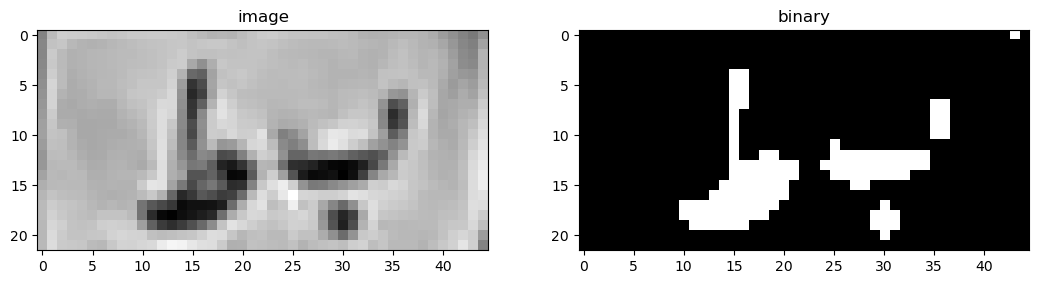

10 22
24 37
43 44
[(10, 22, array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False],


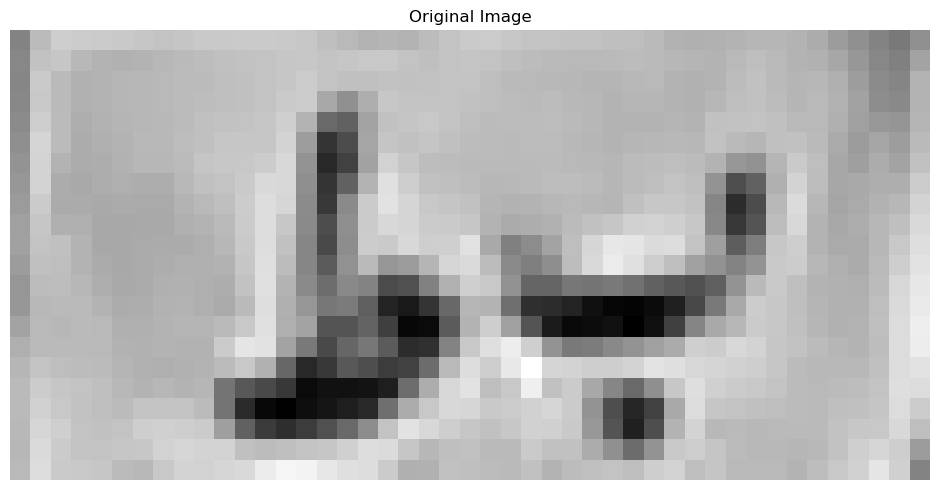

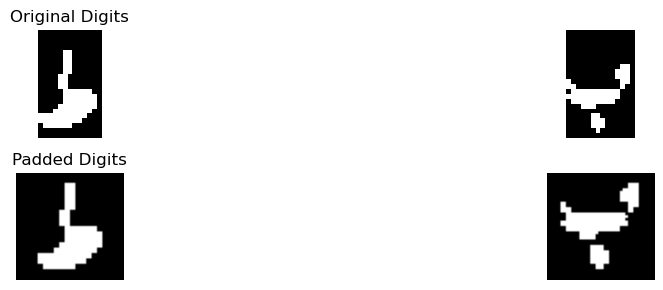

Best match: ط
Full comparison results: {'أ': 0.1875, 'ب': 0.03125, 'ج': 0.40625, 'د': 0.75, 'ر': 0.5043103448275862, 'س': 0.34375, 'ص': 0.3125, 'ط': 1.2708333333333335, 'ع': 0.23958333333333331, 'ف': 0.6631944444444444, 'ق': 0.6145833333333333, 'ك': 0.5729166666666667, 'ل': 0.22916666666666666, 'م': 0.07291666666666666, 'ن': 0.5208333333333334, 'ه': 0.53125, 'و': 0.375, 'ي': 0.7884615384615384}
Confidence :  0.24118589743589752
Best match: ب
Full comparison results: {'أ': 0.06896551724137931, 'ب': 0.7291666666666666, 'ج': 0.1724137931034483, 'د': 0.0, 'ر': 0.12823275862068967, 'س': 0.125, 'ص': 0.65625, 'ط': 0.06896551724137931, 'ع': 0.0, 'ف': 0.034482758620689655, 'ق': 0.10344827586206896, 'ك': 0.3006465517241379, 'ل': 0.034482758620689655, 'م': 0.10344827586206896, 'ن': 0.0, 'ه': 0.0625, 'و': 0.10344827586206896, 'ي': 0.2349137931034483}
Confidence :  0.036458333333333315
[['٣', '٥', '١', '٧'], ['ط', 'ب']]


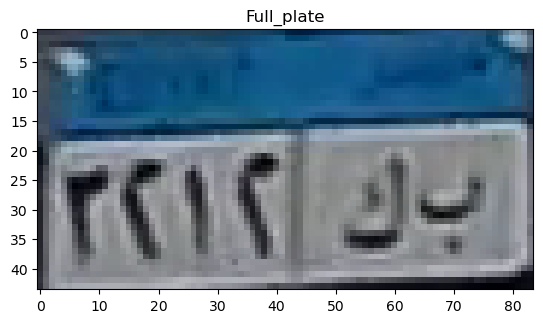

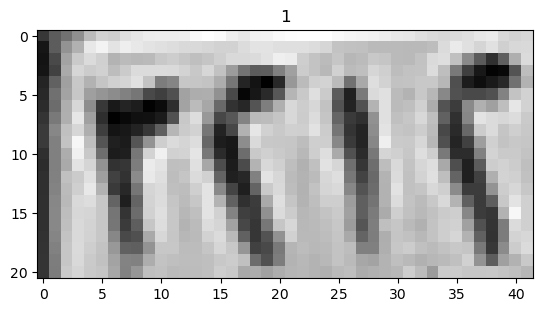

[0.16200549 0.06788784 0.06000706 0.06392863 0.11068196 0.12244667
 0.13000706 0.15745804 0.17060667 0.17060667 0.13923412 0.13531255
 0.13923412 0.13923412 0.14315569 0.14315569 0.14315569 0.14707725
 0.15099882 0.15492039 0.15492039]
[0.26788784 0.26788784 0.2168698  0.19334039 0.28323098 0.32636824
 0.31432078 0.35353647 0.39021451 0.37060667 0.37060667 0.37060667
 0.37452824 0.38237137 0.39021451 0.39413608 0.39413608 0.38629294
 0.37452824 0.36276353 0.35884196]
[0.32841569 0.4264549  0.47262784 0.49223569 0.46391373 0.47567843
 0.50283882 0.50676039 0.55548588 0.56725059 0.50001843 0.49217529
 0.55492039 0.53923412 0.53531255 0.54707725 0.55099882 0.56276353
 0.57060667 0.57060667 0.58237137]
After
[0.26788784 0.26788784 0.2168698  0.19334039 0.28323098 0.32636824
 0.31432078 0.35353647 0.39021451 0.37060667 0.37060667 0.37060667
 0.37452824 0.38237137 0.39021451 0.39413608 0.39413608 0.38629294
 0.37452824 0.36276353 0.35884196]


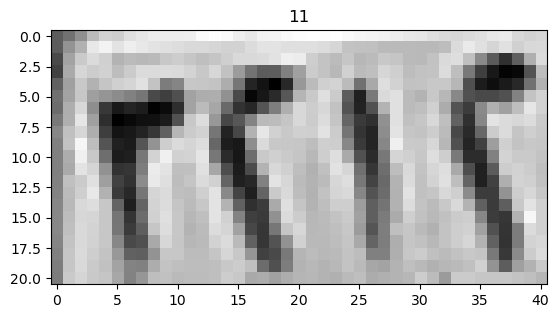

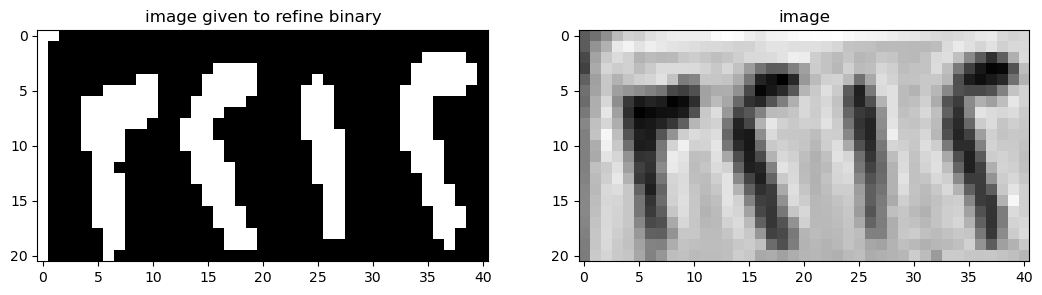

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[ True False False False False False False False False False False False
 False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False]


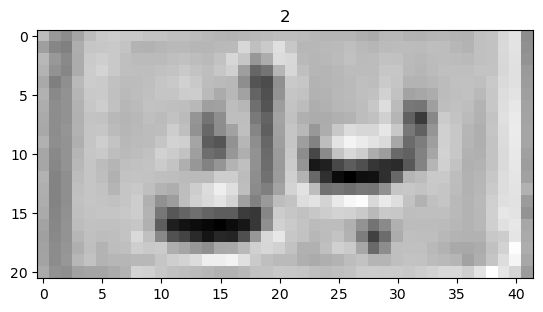

[0.54626667 0.46783529 0.53502275 0.52325804 0.49582196 0.5154298
 0.50618784 0.49834471 0.49245098 0.51598039 0.48796392 0.48796392
 0.51990196 0.51205882 0.50421569 0.49637255 0.4820851  0.47032039
 0.47480745 0.47872902 0.49609686]
[0.45214902 0.40116863 0.44874824 0.43306196 0.38209647 0.40954745
 0.41991333 0.41991333 0.41794118 0.42186275 0.40953255 0.40168941
 0.39441176 0.39441176 0.39441176 0.39833333 0.40365373 0.40757529
 0.41598392 0.41598392 0.43335176]
[0.41602157 0.38464902 0.40758314 0.39974    0.42523373 0.43307686
 0.43362745 0.43362745 0.44147059 0.43754902 0.43698353 0.43698353
 0.42521882 0.42521882 0.42578431 0.42970588 0.43502627 0.43502627
 0.4411949  0.44511647 0.42550863]
After
[0.54626667 0.46783529 0.53502275 0.52325804 0.49582196 0.5154298
 0.50618784 0.49834471 0.49245098 0.51598039 0.48796392 0.48796392
 0.51990196 0.51205882 0.50421569 0.49637255 0.4820851  0.47032039
 0.47480745 0.47872902 0.49609686]


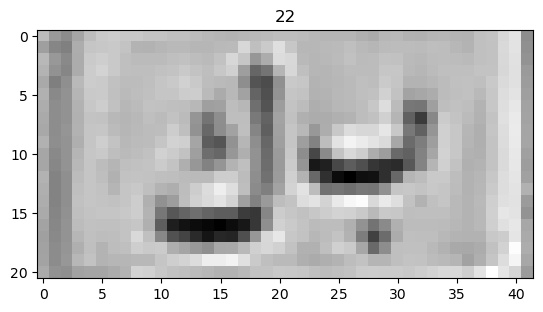

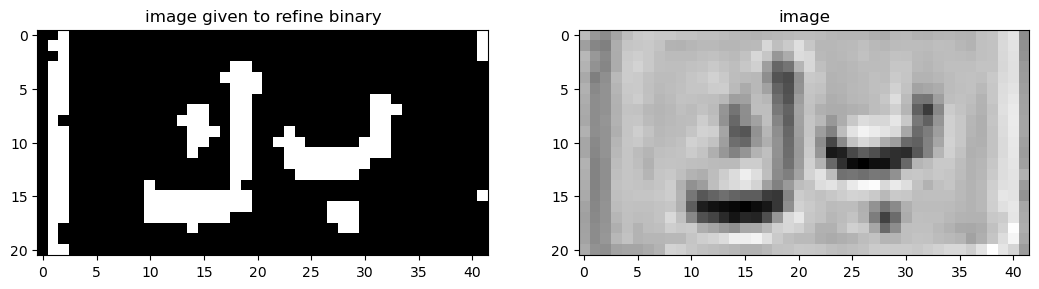

[False False False False False False False False False False False False
 False False False False False False False False False]
[False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True False False  True]
After
[False False False False False False False False False False False False
 False False False False False False False False False]
to horizonatal


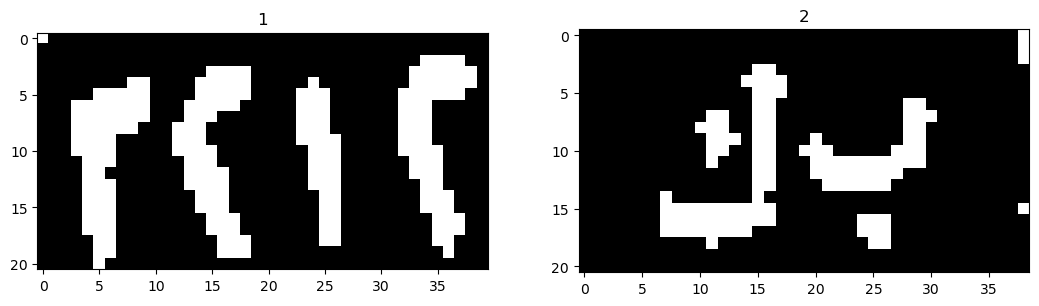

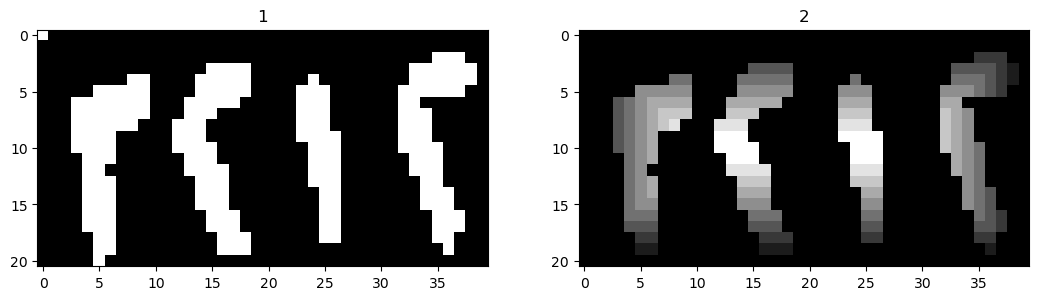

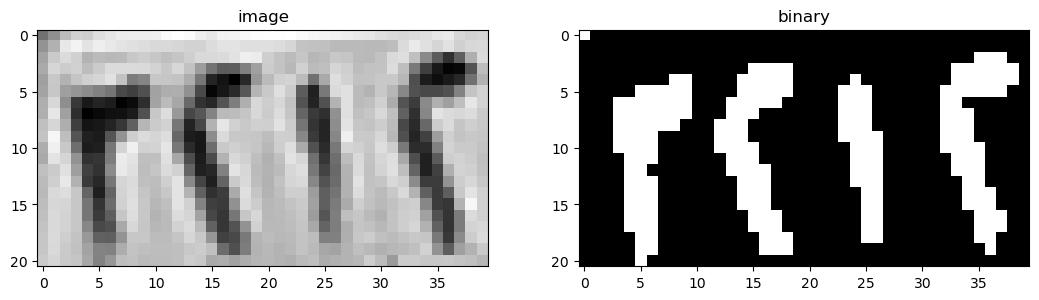

0 1
3 10
12 19
23 27
32 39
[(3, 10, array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True, False, False, False, False],
       [False,  True,  True, False, False, False, False, False],
       [False,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True, False, False, Fals

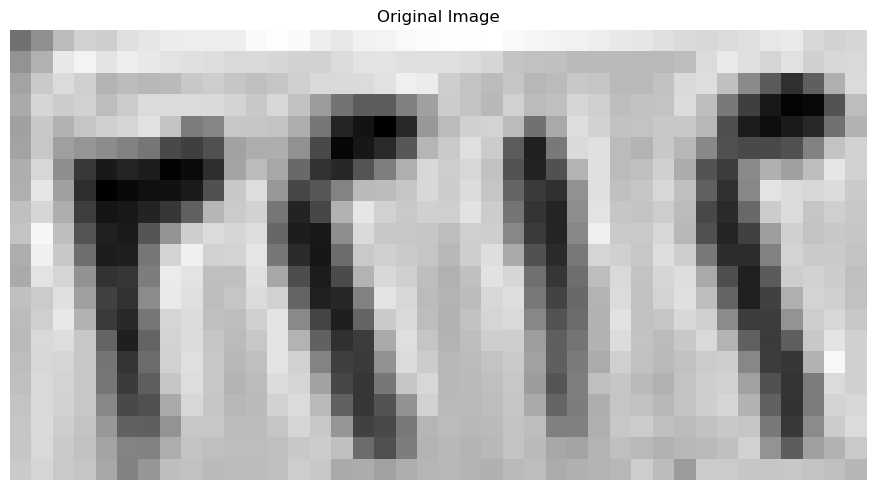

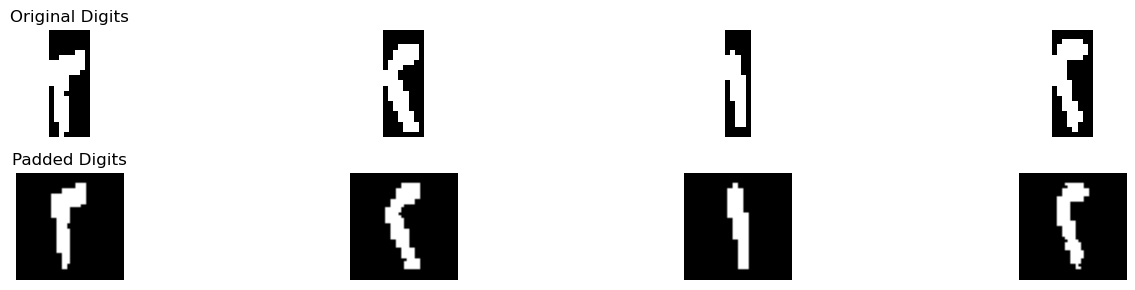

Best match: ٢
Full comparison results: {'١': 0.3076923076923077, '٢': 4.76201923076923, '٣': 4.706269349845201, '٤': 2.963919413919414, '٥': 2.079753611971104, '٦': 1.311904761904762, '٧': 1.8183823529411764, '٨': 0.8534722222222222, '٩': 1.2134552538964305}
Confidence :  0.027874940462014663
Best match: ٢
Full comparison results: {'١': 1.2788461538461537, '٢': 6.314903846153847, '٣': 3.1568304953560373, '٤': 2.7093177655677656, '٥': 2.2966239127229837, '٦': 0.6648809523809524, '٧': 2.202205882352941, '٨': 1.1027777777777779, '٩': 1.5244940925087984}
Confidence :  1.5790366753989047
Best match: ١
Full comparison results: {'١': 6.95625, '٢': 2.8703379953379957, '٣': 1.24796826625387, '٤': 1.7693223443223443, '٥': 1.3138498820580864, '٦': 1.1714285714285715, '٧': 1.286764705882353, '٨': 2.7743055555555554, '٩': 2.8558634992458525}
Confidence :  2.0429560023310023
Best match: ٢
Full comparison results: {'١': 0.7916666666666666, '٢': 7.188301282051283, '٣': 3.7916989164086687, '٤': 3.14278

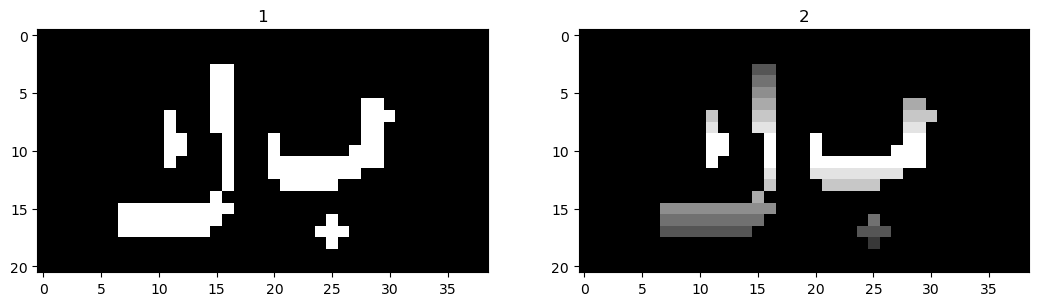

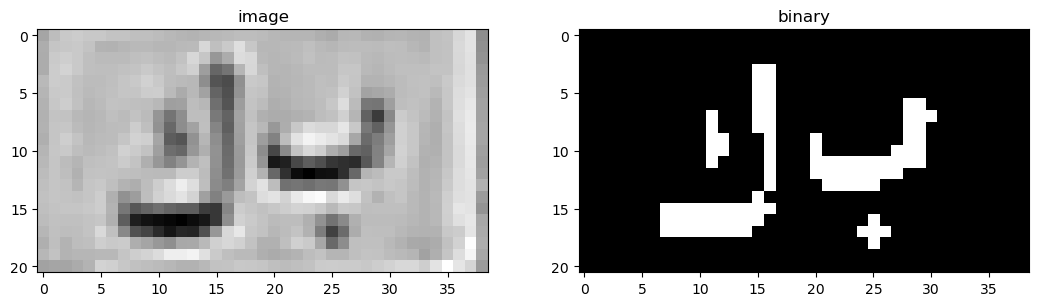

7 17
20 31
[(7, 17, array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False,  True,
         True, False],
       [False, False, False, False, False, False, False,  True,  True,
         True,  True],
       [False, False, False, False, False, False, False, False,  True,
         True,  True],
       [False, False, False, False, False, False, False, False,  True,
         True, False],
       [False, False, False, False,  True,  True, False, False,  True,
         True, False],
       [False, False, False,  True,  True,  True, False, False,  True,
         True, False],
       [False, False, False, False,  True,  True,  True, False,  True,
         True, False],
       [False, False, False, False,  Tru

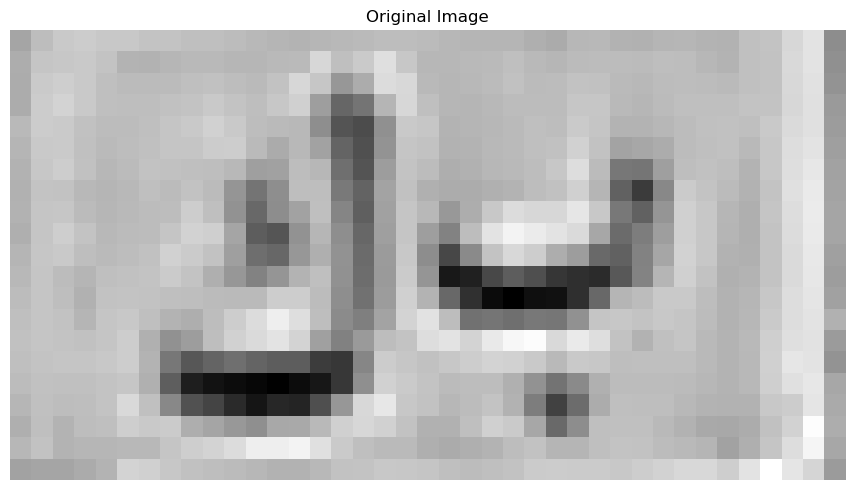

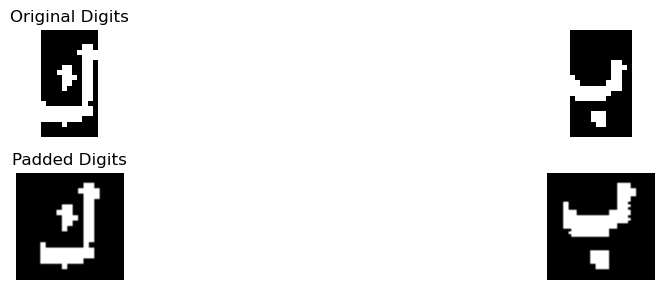

Best match: ي
Full comparison results: {'أ': 0.045454545454545456, 'ب': 0.0, 'ج': 0.21195652173913043, 'د': 0.6107954545454546, 'ر': 0.5010775862068966, 'س': 0.375, 'ص': 0.34375, 'ط': 0.5416666666666667, 'ع': 0.2755681818181818, 'ف': 0.4583333333333333, 'ق': 0.3068181818181818, 'ك': 0.6979166666666666, 'ل': 0.45738636363636365, 'م': 0.0, 'ن': 0.625, 'ه': 0.46875, 'و': 0.5625, 'ي': 0.7884615384615384}
Confidence :  0.0452724358974359
Best match: ب
Full comparison results: {'أ': 0.1111111111111111, 'ب': 0.7455357142857143, 'ج': 0.21643518518518517, 'د': 0.07407407407407407, 'ر': 0.3318965517241379, 'س': 0.1875, 'ص': 0.46875, 'ط': 0.1111111111111111, 'ع': 0.0, 'ف': 0.07407407407407407, 'ق': 0.1111111111111111, 'ك': 0.49537037037037035, 'ل': 0.07407407407407407, 'م': 0.1111111111111111, 'ن': 0.07407407407407407, 'ه': 0.1875, 'و': 0.3900462962962963, 'ي': 0.3472222222222222}
Confidence :  0.12508267195767198
[['٢', '٢', '١', '٢'], ['ي', 'ب']]


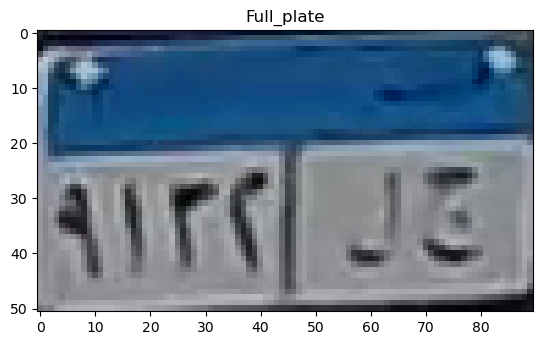

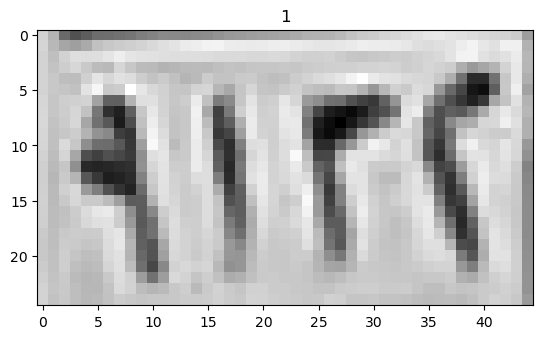

[0.59982157 0.60374314 0.59446353 0.5983851  0.59863804 0.60255961
 0.60646627 0.61038784 0.61205451 0.60813294 0.60364588 0.59580275
 0.58598745 0.58598745 0.58990902 0.59383059 0.58990902 0.58598745
 0.57422275 0.56637961 0.56835176 0.5761949  0.58795961 0.59972431
 0.59805765]
[0.50719294 0.52287922 0.54213686 0.55782314 0.56813647 0.56813647
 0.56166235 0.56166235 0.55323098 0.54930941 0.54482235 0.53697922
 0.52716392 0.51932078 0.52716392 0.52716392 0.53500706 0.53500706
 0.53892863 0.53892863 0.54482235 0.54874392 0.55492039 0.55884196
 0.55099882]
[0.30327137 0.47189882 0.59703882 0.58527412 0.54068549 0.56029333
 0.58519176 0.5812702  0.57676039 0.56499569 0.61933216 0.60364588
 0.56245804 0.57422275 0.58990902 0.57030118 0.54677176 0.55069333
 0.57030118 0.57814431 0.58403804 0.58403804 0.57452824 0.57060667
 0.5666851 ]
After
[0.59982157 0.60374314 0.59446353 0.5983851  0.59863804 0.60255961
 0.60646627 0.61038784 0.61205451 0.60813294 0.60364588 0.59580275
 0.58598745 0.585

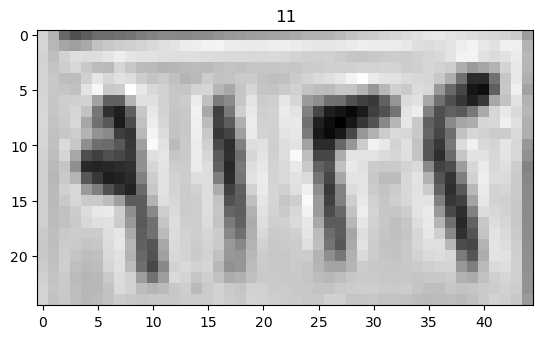

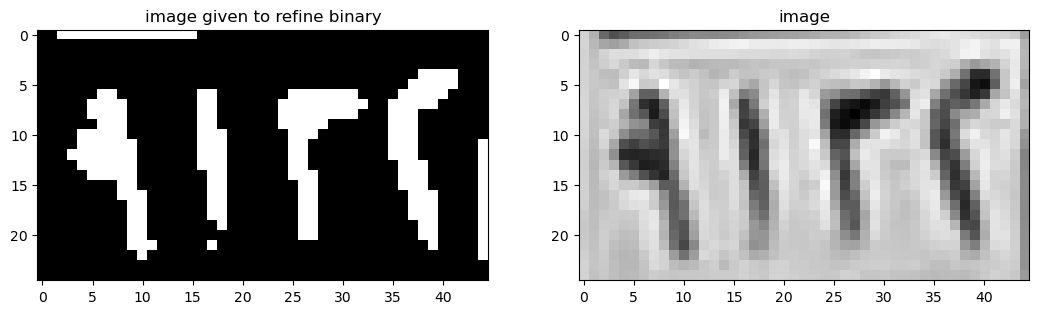

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
1.0 44.0 0.0 28.0


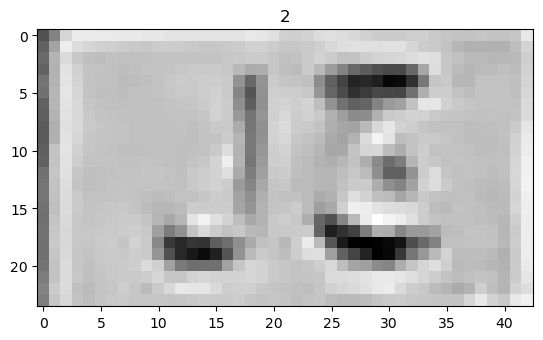

[0.28104353 0.31633765 0.3378502  0.32216392 0.36305412 0.35521098
 0.31991686 0.30815216 0.30144784 0.30144784 0.30929098 0.31713412
 0.35803137 0.36587451 0.36587451 0.35803137 0.35297098 0.36081412
 0.35884196 0.35884196 0.36276353 0.38237137 0.40197922 0.38629294]
[0.39869843 0.48105137 0.51881569 0.51489412 0.5204902  0.52441176
 0.52441176 0.51656863 0.50872549 0.51264706 0.55970588 0.55970588
 0.56419294 0.5563498  0.55128941 0.54736784 0.55492039 0.5666851
 0.57060667 0.56276353 0.55492039 0.55884196 0.57452824 0.56276353]
[0.60262    0.65752196 0.61293333 0.63254118 0.63421569 0.63813725
 0.63421569 0.63029412 0.62637255 0.63029412 0.63421569 0.63029412
 0.62693804 0.6190949  0.61403451 0.61403451 0.60982235 0.60590078
 0.60590078 0.60982235 0.61374392 0.61374392 0.61374392 0.60590078]
After
[0.28104353 0.31633765 0.3378502  0.32216392 0.36305412 0.35521098
 0.31991686 0.30815216 0.30144784 0.30144784 0.30929098 0.31713412
 0.35803137 0.36587451 0.36587451 0.35803137 0.3529709

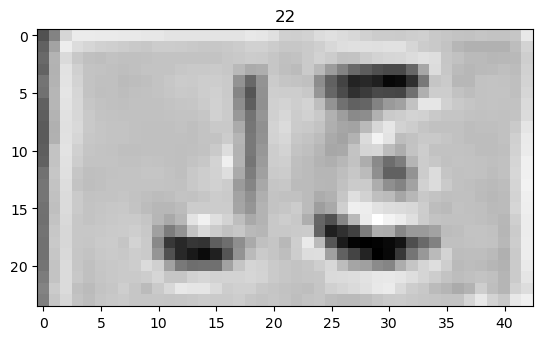

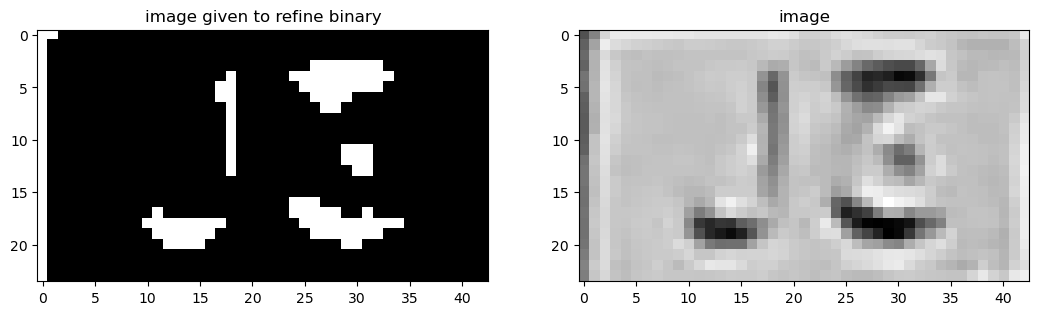

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
to horizonatal


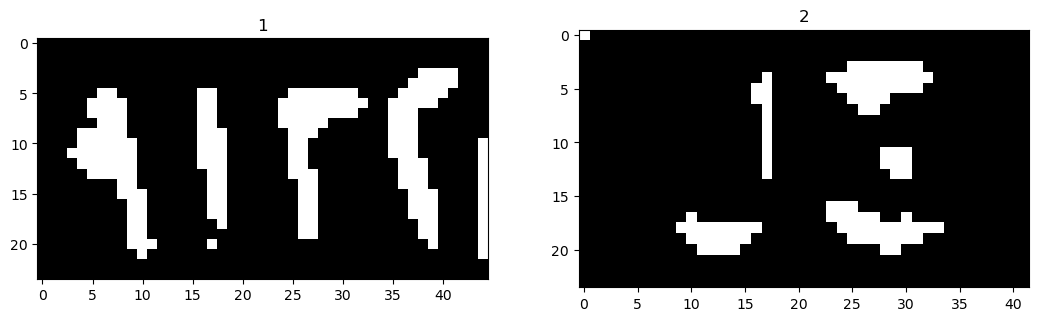

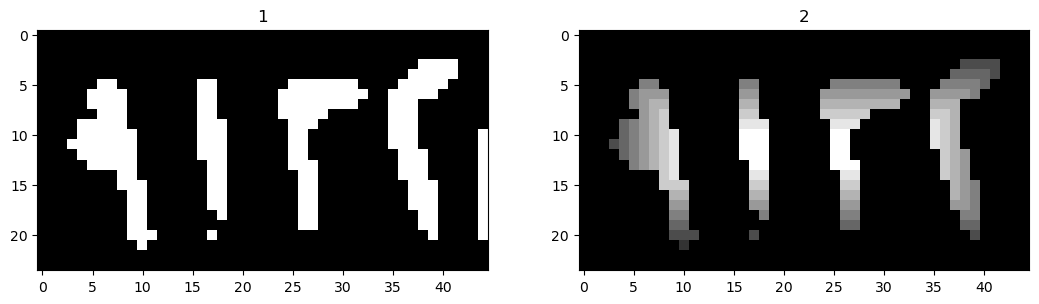

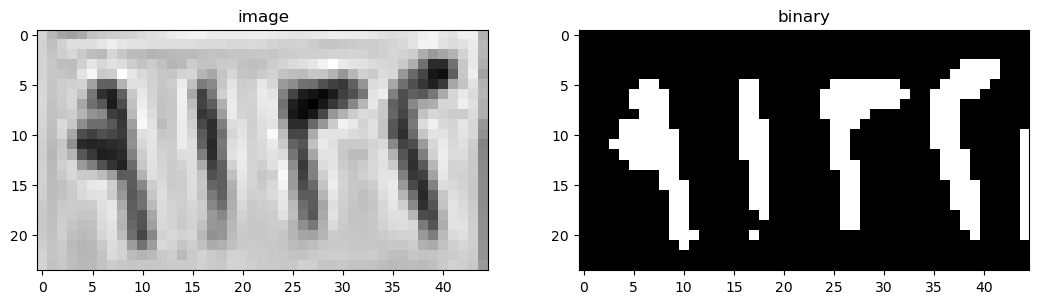

3 12
16 19
24 33
35 42
[(3, 12, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False,  True,  True, False, False, False, False,
        False],
       [False, False,  True,  True,  True,  True, False, False, False,
        False],
       [False, False,  True,  True,  True,  True, False, False, False,
        False],
       [False, False, False,  True,  True,  True, False, False, False,
        False],
       [False,  True,  True,  True,  True,  True, False, False, False,
        False],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False],
       [ Tr

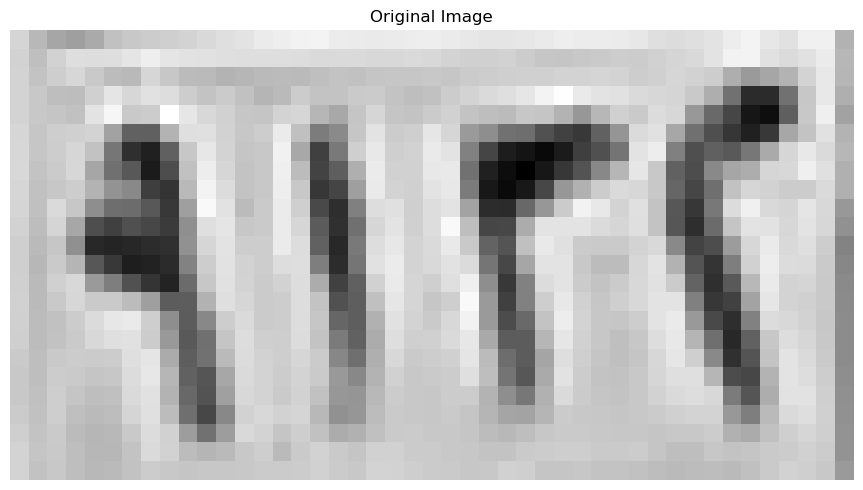

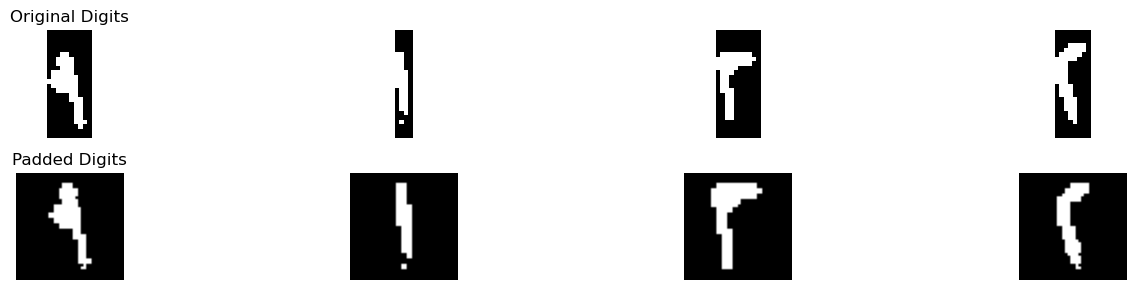

Best match: ٩
Full comparison results: {'١': 3.0, '٢': 2.15625, '٣': 1.3318498452012384, '٤': 2.0, '٥': 1.4223241928350288, '٦': 1.56875, '٧': 0.7830882352941176, '٨': 3.5263888888888886, '٩': 5.381331699346405}
Confidence :  0.9274714052287583
Best match: ١
Full comparison results: {'١': 5.766666666666667, '٢': 2.350014568764569, '٣': 1.0213815789473684, '٤': 1.850412087912088, '٥': 0.9470735662686127, '٦': 0.38363095238095235, '٧': 1.0790441176470589, '٨': 3.079861111111111, '٩': 1.8449912016088488}
Confidence :  1.3434027777777777
Best match: ٣
Full comparison results: {'١': 0.47368421052631576, '٢': 1.049342105263158, '٣': 3.2006578947368425, '٤': 1.2911184210526316, '٥': 1.5846647869674184, '٦': 1.882236842105263, '٧': 1.5358552631578946, '٨': 0.5131578947368421, '٩': 0.894736842105263}
Confidence :  0.6592105263157897
Best match: ٢
Full comparison results: {'١': 0.8020833333333333, '٢': 7.104967948717949, '٣': 3.715654024767802, '٤': 3.205288461538462, '٥': 2.4097237579242226, '٦

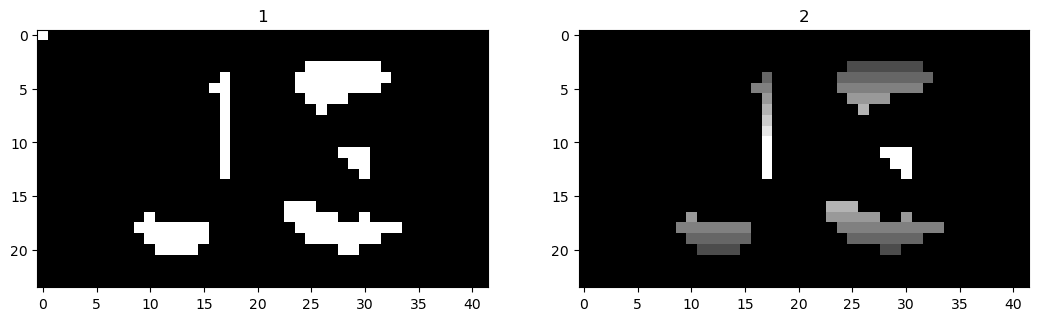

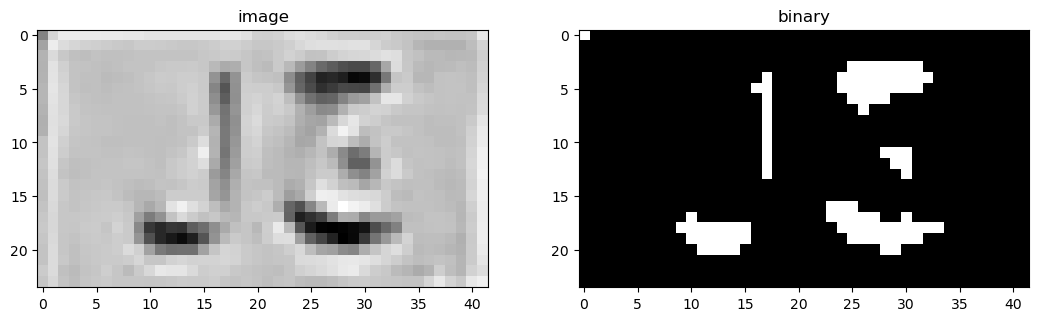

0 1
9 18
23 34
[(9, 18, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False, False, False, False, False,  True,  True,
        False],
       [False, False, False, False, False, False, False,  True,  True,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, Fals

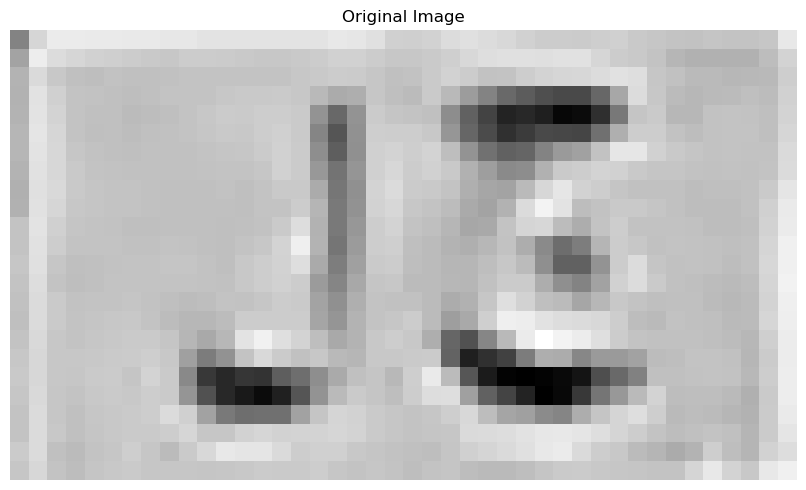

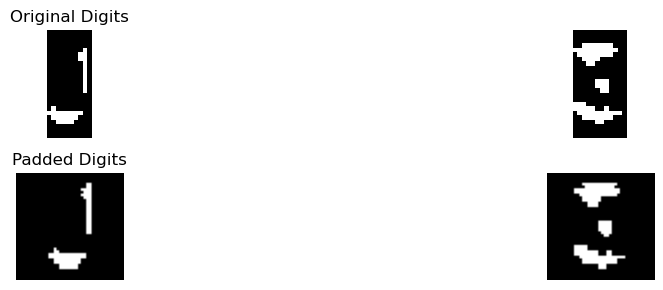

Best match: ل
Full comparison results: {'أ': 0.0, 'ب': 0.12823275862068967, 'ج': 0.13722826086956522, 'د': 0.1534090909090909, 'ر': 0.4073275862068966, 'س': 0.1875, 'ص': 0.125, 'ط': 0.3229166666666667, 'ع': 0.38030560271646857, 'ف': 0.21643518518518517, 'ق': 0.3355263157894737, 'ك': 0.23958333333333334, 'ل': 1.53125, 'م': 0.0, 'ن': 0.625, 'ه': 0.09375, 'و': 0.5625, 'ي': 0.4014423076923077}
Confidence :  0.453125
Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.09375, 'ج': 1.1141304347826086, 'د': 0.45738636363636365, 'ر': 0.09375, 'س': 0.09375, 'ص': 0.125, 'ط': 0.17708333333333331, 'ع': 0.2546689303904923, 'ف': 0.4270833333333333, 'ق': 0.5674342105263157, 'ك': 0.14583333333333331, 'ل': 0.14638157894736842, 'م': 0.10526315789473684, 'ن': 0.34375, 'ه': 0.15625, 'و': 0.17708333333333331, 'ي': 0.27884615384615385}
Confidence :  0.27334811212814647
[['٩', '١', '٣', '٢'], ['ل', 'ج']]


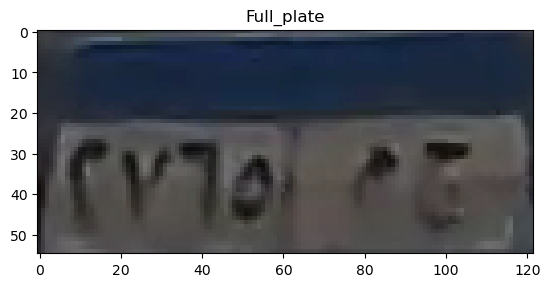

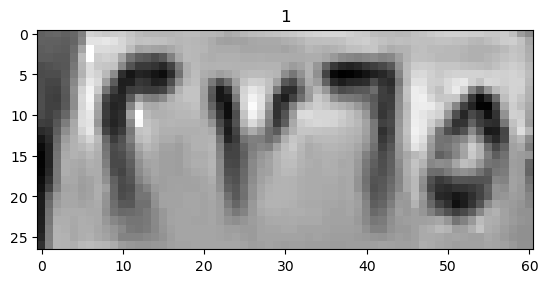

[0.19805765 0.20197922 0.19412118 0.19019961 0.16861961 0.16469804
 0.16861961 0.16861961 0.17000353 0.17000353 0.16468314 0.14507529
 0.11313725 0.08176471 0.06215686 0.05039216 0.05095765 0.05487922
 0.06664392 0.07448706 0.08822392 0.09214549 0.08962275 0.09354431
 0.09746588 0.10530902 0.12353294]
[0.20590078 0.19805765 0.19804275 0.19019961 0.17646275 0.16861961
 0.1568549  0.15293333 0.14844627 0.14844627 0.15096902 0.14312588
 0.12546745 0.11370275 0.10137255 0.10137255 0.10137255 0.10921569
 0.12490196 0.14843137 0.19802784 0.21763569 0.22940039 0.23332196
 0.24256392 0.24648549 0.25040706]
[0.20982235 0.19805765 0.19412118 0.18627804 0.18038431 0.16861961
 0.1568549  0.14901176 0.14452471 0.14844627 0.16665529 0.18234157
 0.19605569 0.21174196 0.22294118 0.23078431 0.23470588 0.23862745
 0.23862745 0.25039216 0.28430235 0.29606706 0.31175333 0.32351804
 0.32883843 0.33276    0.33276   ]
After
[0.20590078 0.19805765 0.19804275 0.19019961 0.17646275 0.16861961
 0.1568549  0.1529

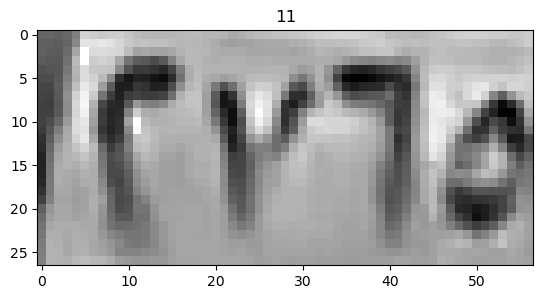

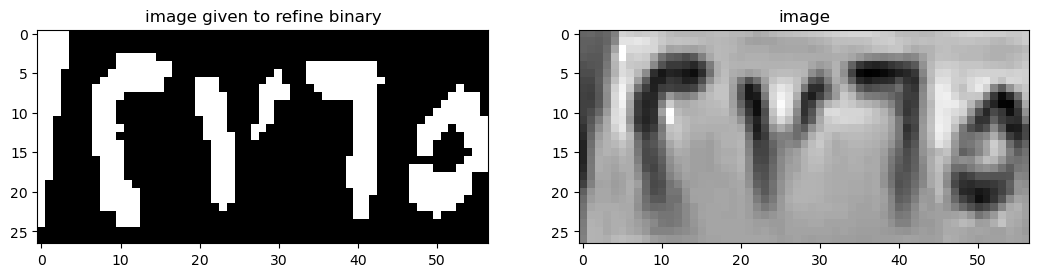

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
[ True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False]
After
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False]


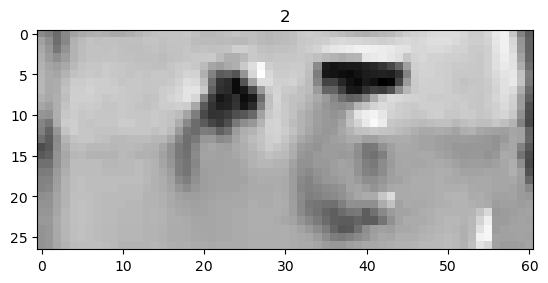

[0.25714118 0.29243529 0.30390235 0.31174549 0.31762431 0.32154588
 0.32490196 0.32490196 0.31481176 0.29912549 0.27335608 0.24982667
 0.24198353 0.21845412 0.16355216 0.18316    0.21845412 0.23414039
 0.24476627 0.24868784 0.26352588 0.27136902 0.27529059 0.27921216
 0.27221725 0.27221725 0.27278275]
[0.2414549  0.26498431 0.27645137 0.28429451 0.29801647 0.30585961
 0.30529412 0.30529412 0.30304706 0.28736078 0.26943451 0.22629725
 0.19884627 0.18708157 0.18316    0.19492471 0.21845412 0.23806196
 0.24868784 0.25260941 0.26744745 0.27136902 0.27529059 0.27921216
 0.27613882 0.27613882 0.27670431]
[0.21008235 0.21400392 0.22715255 0.26244667 0.28821608 0.29998078
 0.30921569 0.30921569 0.31257176 0.31257176 0.31367294 0.30975137
 0.27445725 0.25877098 0.26269255 0.27053569 0.27053569 0.28230039
 0.28705529 0.29097686 0.29768118 0.29768118 0.30160275 0.30552431
 0.30442314 0.30442314 0.30106706]
After
[0.25714118 0.29243529 0.30390235 0.31174549 0.31762431 0.32154588
 0.32490196 0.3249

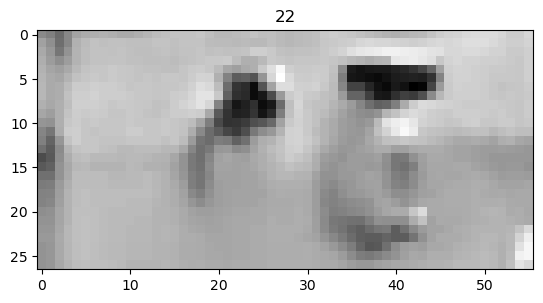

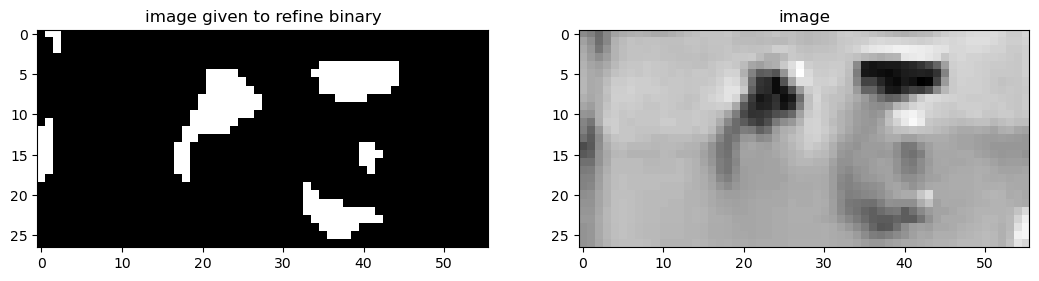

[False False False False False False False False False False False False
  True  True  True  True  True  True  True False False False False False
 False False False]
[ True False False False False False False False False False False  True
  True  True  True  True  True  True False False False False False False
 False False False]
[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
After
[False False False False False False False False False False False False
  True  True  True  True  True  True  True False False False False False
 False False False]
to horizonatal


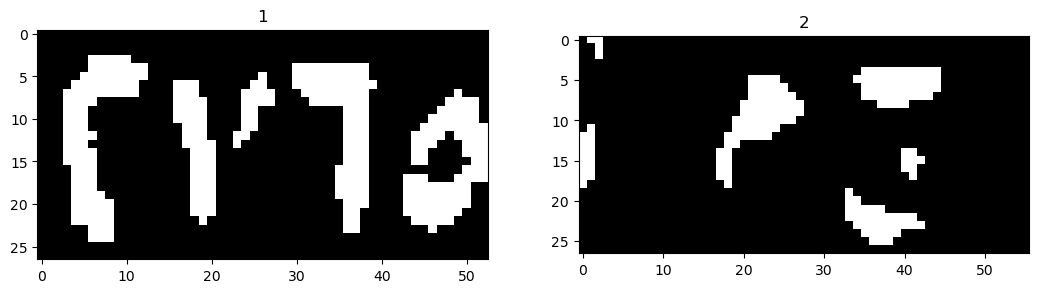

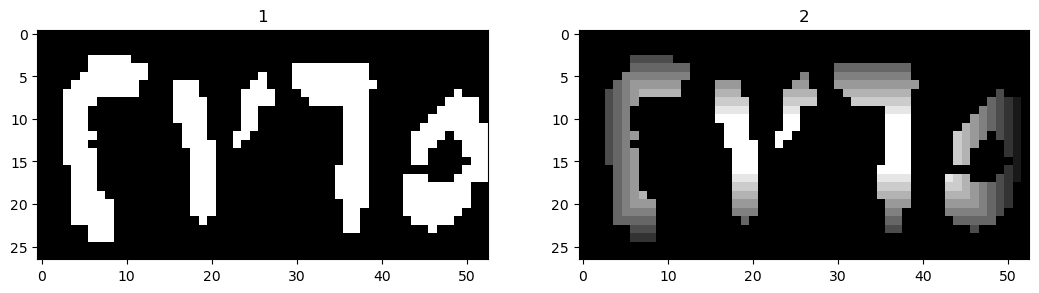

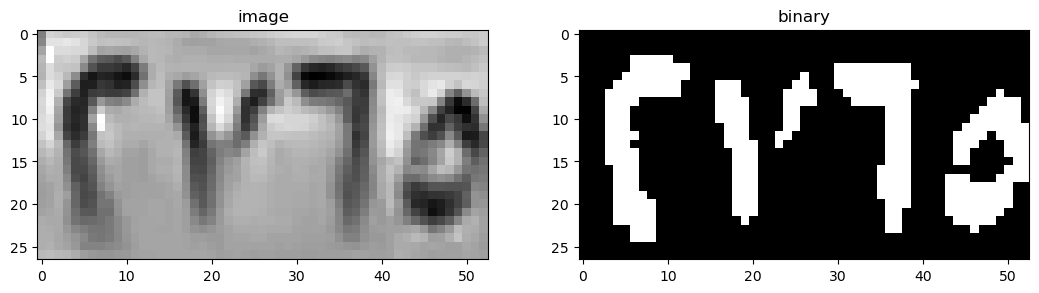

3 13
16 21
23 28
30 40
43 52
[(3, 13, array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False,  True,  True,  True,  True,  True, False,
        False, False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False, False],
       [ True,  True,  True, False, False, False, False, False, False,
        False, False],
       [ True,  True, 

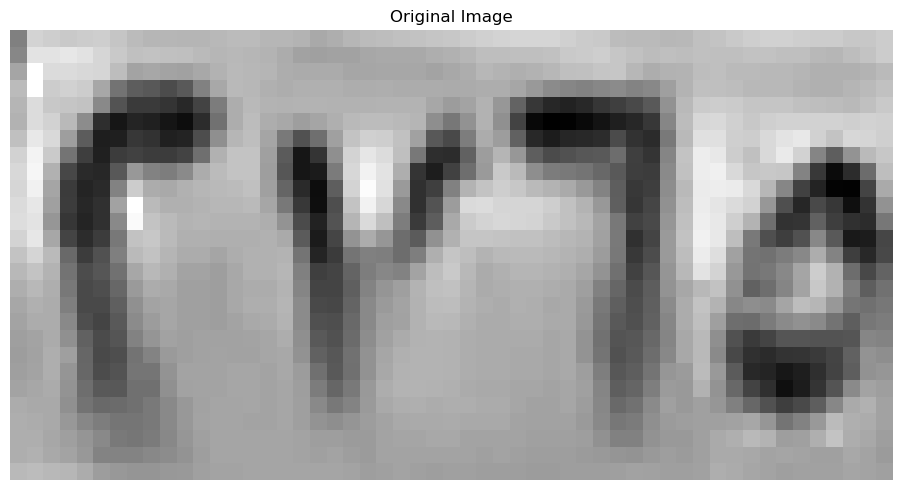

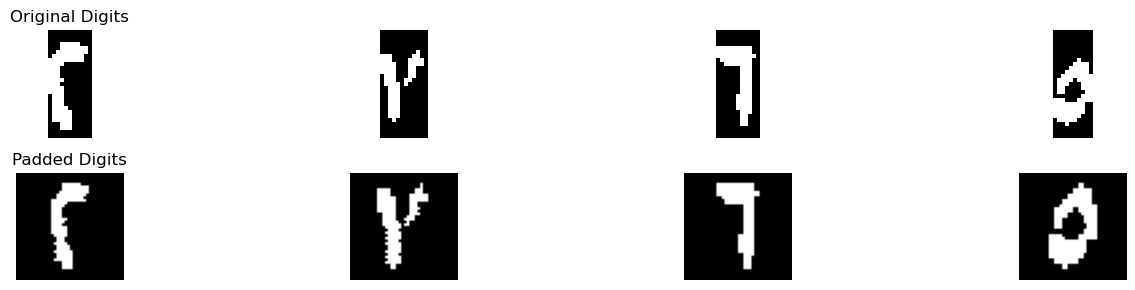

Best match: ٢
Full comparison results: {'١': 0.0, '٢': 5.008928571428571, '٣': 3.295859133126935, '٤': 3.2074404761904765, '٥': 2.769142525431225, '٦': 1.1398809523809523, '٧': 1.5132352941176472, '٨': 0.3625, '٩': 0.6357084500466854}
Confidence :  0.8565347191508181
Best match: ٧
Full comparison results: {'١': 0.0, '٢': 0.3881578947368421, '٣': 1.3667763157894737, '٤': 0.9983552631578947, '٥': 1.2790570175438596, '٦': 0.47565789473684206, '٧': 3.0924342105263154, '٨': 0.39375, '٩': 0.3980263157894737}
Confidence :  0.8628289473684209
Best match: ٦
Full comparison results: {'١': 1.75, '٢': 1.5, '٣': 2.4972910216718267, '٤': 0.0, '٥': 2.3699367905056756, '٦': 6.65, '٧': 0.9544117647058824, '٨': 0.5347222222222222, '٩': 2.181985294117647}
Confidence :  2.076354489164087
Best match: ٥
Full comparison results: {'١': 0.2777777777777778, '٢': 1.1006944444444444, '٣': 1.1683114035087718, '٤': 1.9965277777777775, '٥': 6.481490183792816, '٦': 1.4881944444444444, '٧': 1.170138888888889, '٨': 0.9

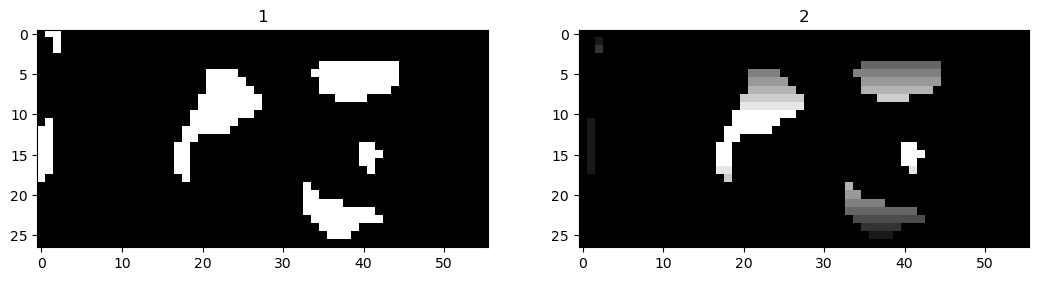

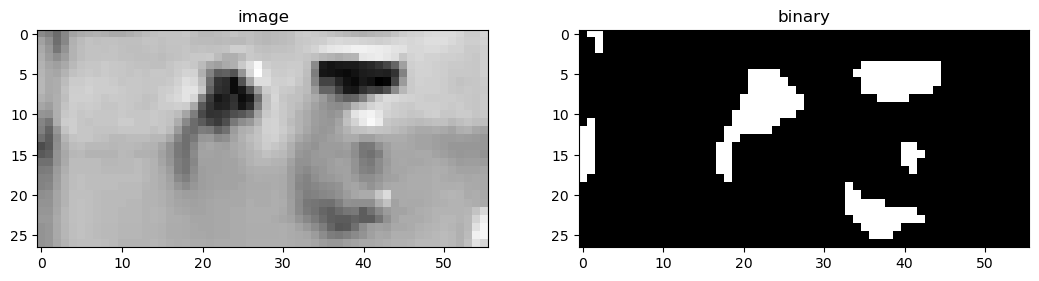

0 3
17 28
33 45
[(17, 28, array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False, False, False],
       [False, False, False, False,  True,  True,  True,  True,  True,
        False, False, False],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True, False, False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False],
       [False, False, False,  True,  True,  True,  True,  True,  

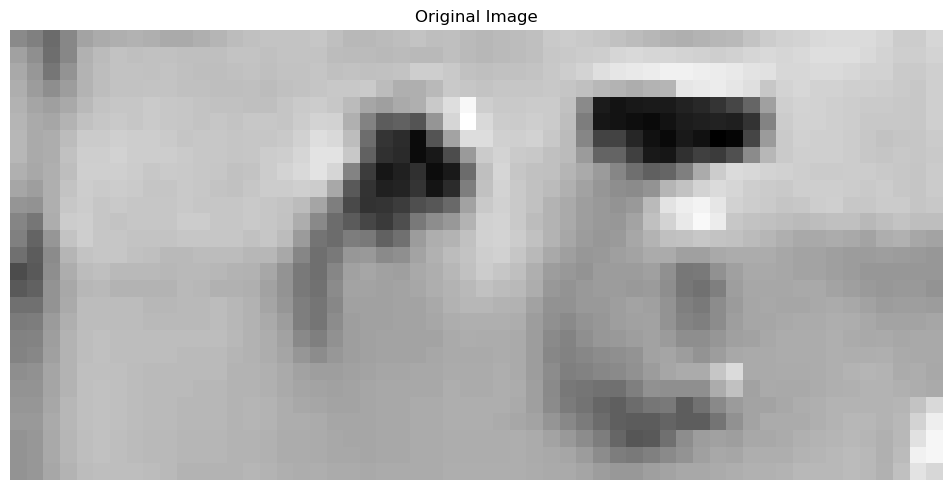

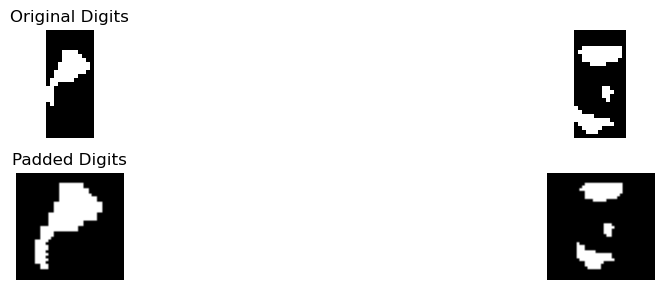

Best match: م
Full comparison results: {'أ': 0.0, 'ب': 0.0625, 'ج': 0.51625, 'د': 0.17375000000000002, 'ر': 0.0, 'س': 0.4375, 'ص': 0.3125, 'ط': 0.08, 'ع': 0.12, 'ف': 0.07407407407407407, 'ق': 0.12, 'ك': 0.04, 'ل': 0.04, 'م': 0.77, 'ن': 0.12, 'ه': 0.25, 'و': 0.32, 'ي': 0.11538461538461539}
Confidence :  0.12687500000000002
Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.03125, 'ج': 0.7717391304347826, 'د': 0.6704545454545454, 'ر': 0.10021551724137931, 'س': 0.25, 'ص': 0.09375, 'ط': 0.15625, 'ع': 0.38030560271646857, 'ف': 0.3645833333333333, 'ق': 0.6982456140350877, 'ك': 0.08333333333333333, 'ل': 0.2426470588235294, 'م': 0.2665441176470588, 'ن': 0.5125, 'ه': 0.09375, 'و': 0.21875, 'ي': 0.3942307692307692}
Confidence :  0.03674675819984746
[['٢', '٧', '٦', '٥'], ['م', 'ج']]


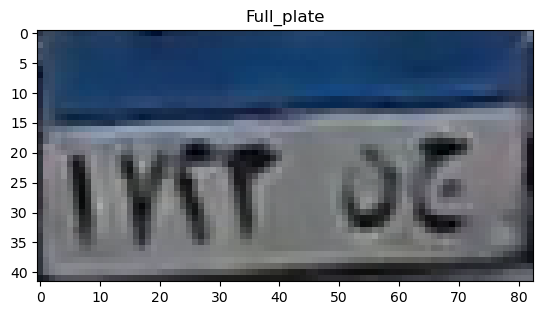

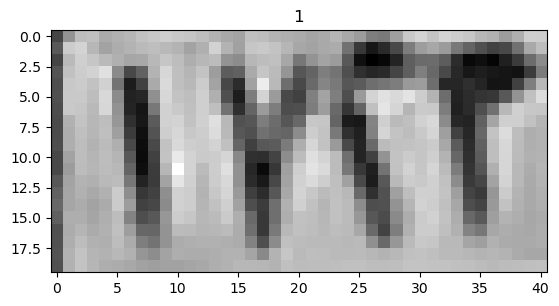

[0.18519176 0.23727333 0.18237137 0.22077647 0.20901176 0.21293333
 0.2050902  0.19972431 0.20364588 0.20951686 0.19383059 0.19383059
 0.23304627 0.25688118 0.27648902 0.25295961 0.21374392 0.2168549
 0.22077647 0.21742039]
[0.38774431 0.53754471 0.49048588 0.50836667 0.52797451 0.52911333
 0.52911333 0.46860824 0.4607651  0.45881569 0.43136471 0.41372902
 0.43333686 0.43559176 0.43951333 0.45912118 0.45519961 0.45885333
 0.47061804 0.46726196]
[0.49754824 0.55715255 0.54538784 0.53973922 0.53581765 0.52911333
 0.5212702  0.51566706 0.50390235 0.49803137 0.49803137 0.49608196
 0.47647412 0.46696431 0.45519961 0.45912118 0.47872902 0.49806902
 0.51375529 0.51432078]
After
[0.18519176 0.23727333 0.18237137 0.22077647 0.20901176 0.21293333
 0.2050902  0.19972431 0.20364588 0.20951686 0.19383059 0.19383059
 0.23304627 0.25688118 0.27648902 0.25295961 0.21374392 0.2168549
 0.22077647 0.21742039]


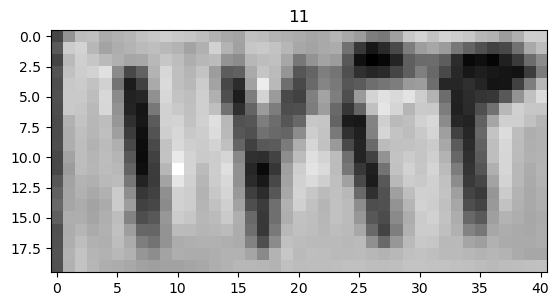

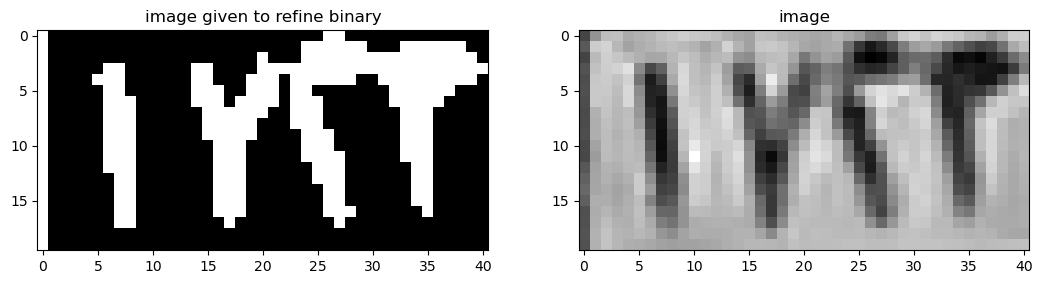

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False]


C:\Users\PC\AppData\Local\Temp\ipykernel_31540\2082684766.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)


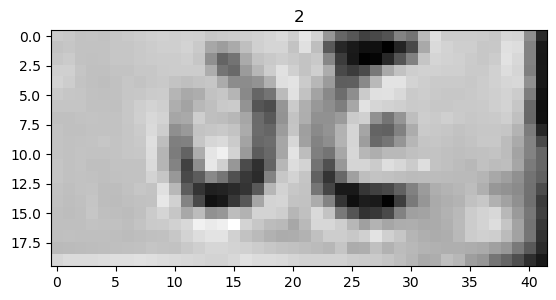

[0.48883412 0.47285804 0.48070118 0.50169294 0.50953608 0.48600667
 0.47424196 0.46247725 0.47032039 0.47032039 0.47032039 0.47424196
 0.47424196 0.46892157 0.465      0.46051294 0.46051294 0.45994745
 0.44818275 0.51484941]
[0.48099098 0.47677961 0.48854431 0.50169294 0.4938498  0.47816353
 0.47424196 0.46247725 0.46247725 0.46639882 0.46639882 0.46639882
 0.46639882 0.46107843 0.45715686 0.45659137 0.46051294 0.46386902
 0.45210431 0.52661412]
[0.46840078 0.46893647 0.46893647 0.47424196 0.47032039 0.47424196
 0.47424196 0.46696431 0.46304275 0.46837098 0.47229255 0.47229255
 0.46837098 0.46697216 0.46305059 0.46107843 0.46107843 0.46051294
 0.4526698  0.52717961]
After
[0.48883412 0.47285804 0.48070118 0.50169294 0.50953608 0.48600667
 0.47424196 0.46247725 0.47032039 0.47032039 0.47032039 0.47424196
 0.47424196 0.46892157 0.465      0.46051294 0.46051294 0.45994745
 0.44818275]


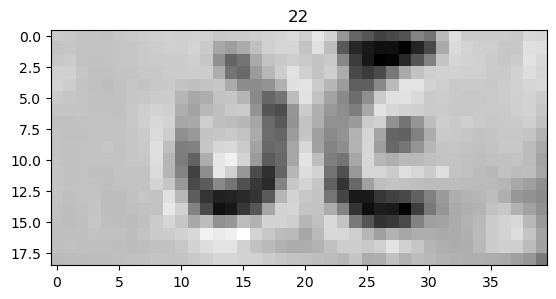

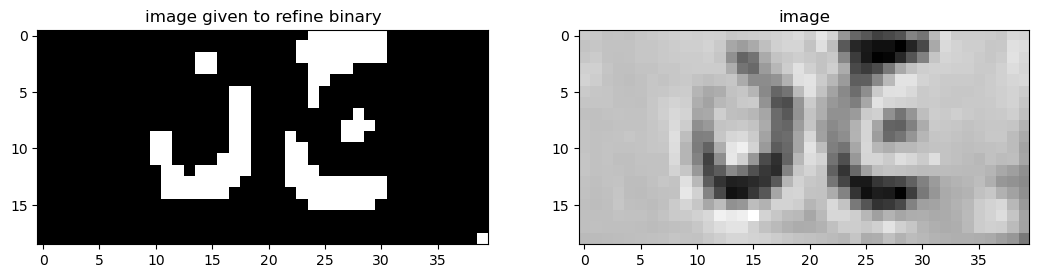

[False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False]
to horizonatal


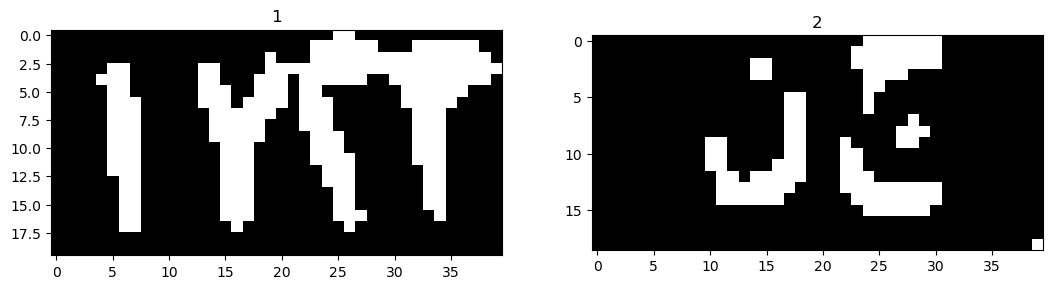

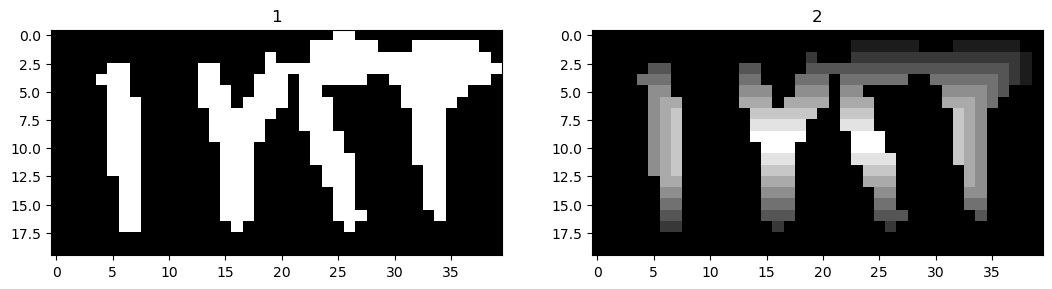

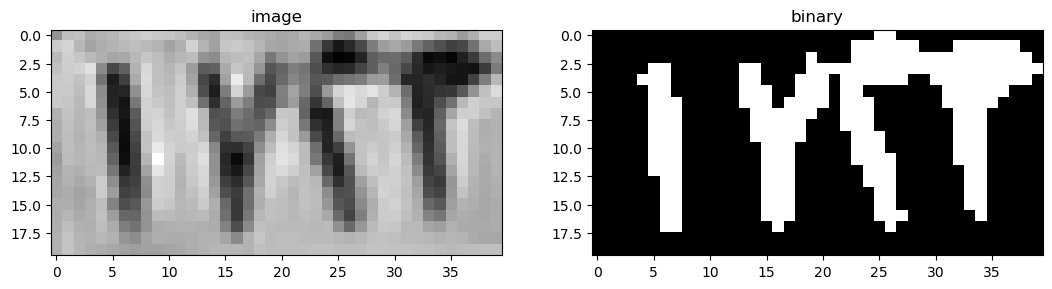

4 8
13 39


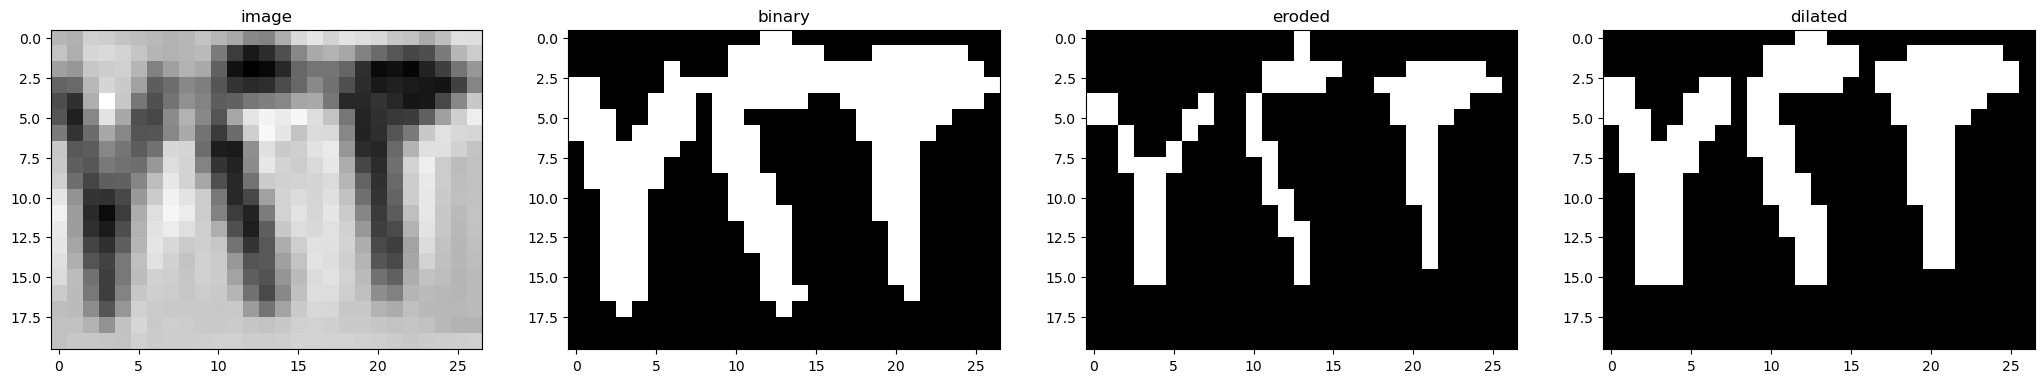

0 8
9 16
17 26
[(4, 8, array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])), (13, 21, array([[False, False, False, False, False, False, False, False, False],
       [False

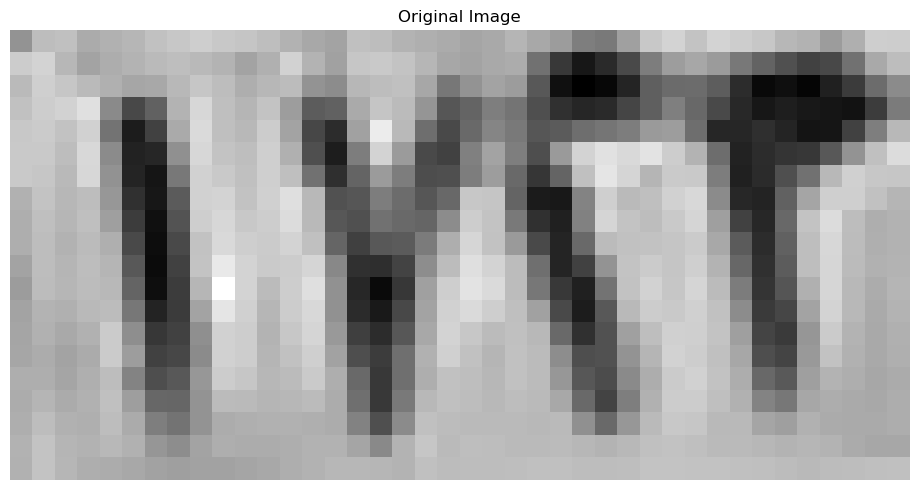

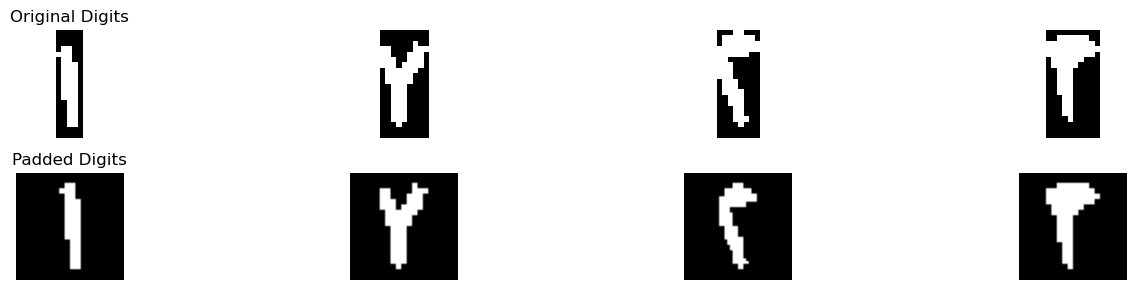

Best match: ١
Full comparison results: {'١': 5.6, '٢': 2.3095134032634035, '٣': 0.7302631578947368, '٤': 1.5282509157509159, '٥': 1.4549102535751144, '٦': 1.0270833333333333, '٧': 1.1654411764705883, '٨': 2.457638888888889, '٩': 1.9492364253393666}
Confidence :  1.5711805555555554
Best match: ٧
Full comparison results: {'١': 0.33333333333333337, '٢': 2.4027777777777777, '٣': 3.544225146198831, '٤': 2.395833333333333, '٥': 1.5614818295739346, '٦': 0.5659722222222222, '٧': 3.711111111111111, '٨': 1.3888888888888888, '٩': 1.6875}
Confidence :  0.08344298245614001
Best match: ٢
Full comparison results: {'١': 0.2767857142857143, '٢': 5.977678571428572, '٣': 4.559404024767802, '٤': 3.002083333333333, '٥': 2.4416694309302667, '٦': 0.9892857142857142, '٧': 2.8448529411764705, '٨': 0.45625, '٩': 1.5146475256769376}
Confidence :  0.7091372733303851
Best match: ٣
Full comparison results: {'١': 0.39999999999999997, '٢': 3.1625, '٣': 4.918749999999999, '٤': 2.0375, '٥': 2.1488095238095237, '٦': 1.6

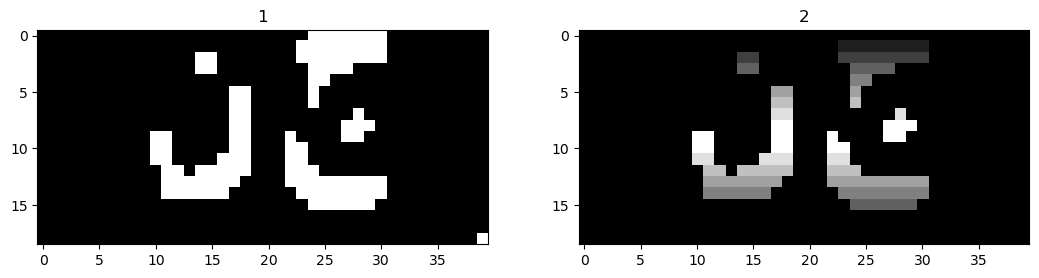

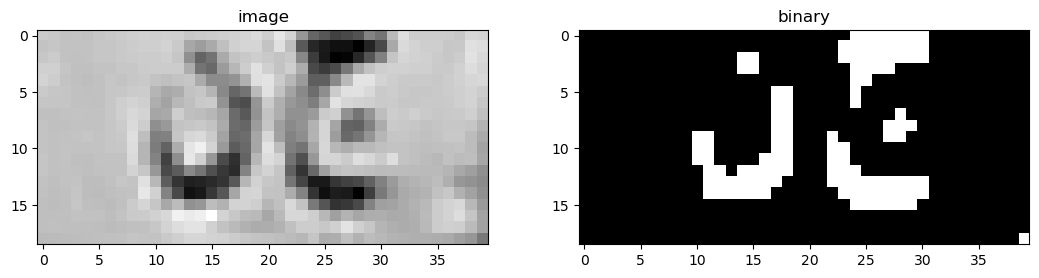

10 19
22 31
[(10, 19, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False,  True,  True, False, False, False,
        False],
       [False, False, False, False,  True,  True, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False,  True,  True,
        False],
       [False, False, False, False, False, False, False,  True,  True,
        False],
       [False, False, False, False, False, False, False,  True,  True,
        False],
       [False, False, False, False, False, False, False,  True,  True,
        False],
       [ True,  True, False, False, False, False, False,  True,  True,
        False],
       [ True,  True, False, False, False, False, False,  True,  True,
        False],
       [ True,  True,

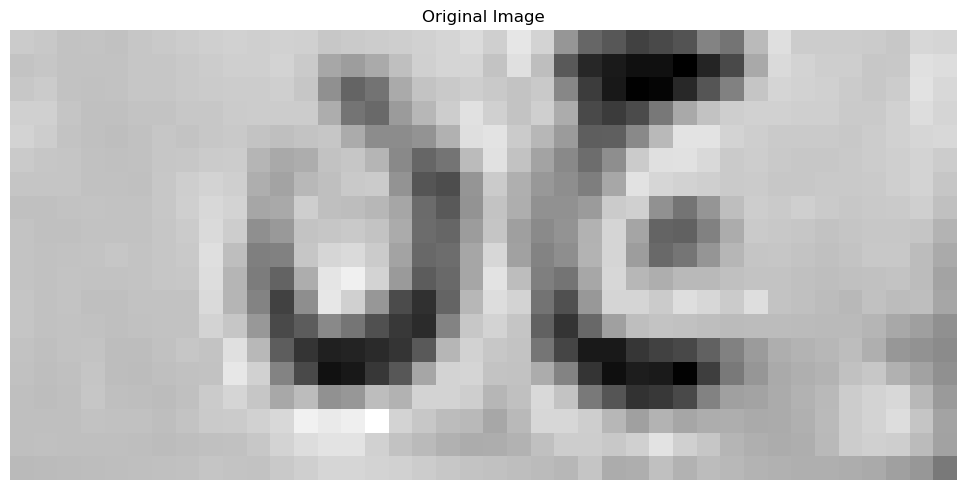

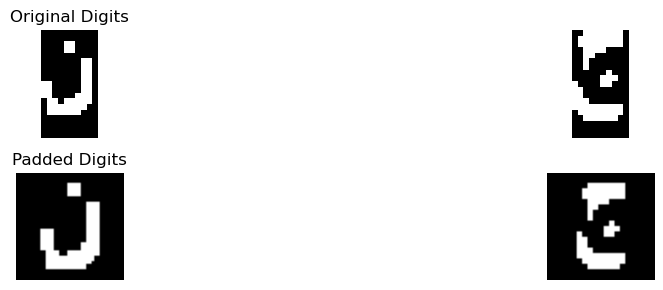

Best match: ن
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.46059782608695654, 'د': 0.9488636363636364, 'ر': 0.6734913793103449, 'س': 0.21875, 'ص': 0.0, 'ط': 0.53125, 'ع': 0.3977272727272727, 'ف': 0.6574074074074074, 'ق': 0.7159090909090909, 'ك': 0.40625, 'ل': 0.42613636363636365, 'م': 0.0, 'ن': 0.9606060606060607, 'ه': 0.28125, 'و': 0.7291666666666666, 'ي': 0.4254807692307692}
Confidence :  0.005871212121212166
Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.09375, 'ج': 0.9402173913043478, 'د': 0.5198863636363636, 'ر': 0.15948275862068967, 'س': 0.0, 'ص': 0.03125, 'ط': 0.23958333333333331, 'ع': 0.4720394736842105, 'ف': 0.5266203703703703, 'ق': 0.5460526315789473, 'ك': 0.40625, 'ل': 0.14930555555555555, 'م': 0.2222222222222222, 'ن': 0.4875, 'ه': 0.125, 'و': 0.36458333333333337, 'ي': 0.27884615384615385}
Confidence :  0.19708237986270022
[['١', '٧', '٢', '٣'], ['ن', 'ج']]


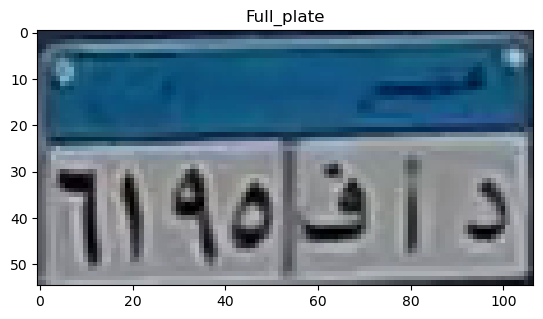

1.0 52.0 2.0 32.0


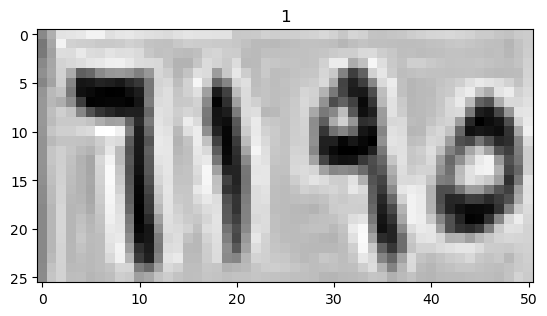

[0.40318549 0.34828353 0.35859686 0.40173412 0.42158706 0.39413608
 0.43727333 0.44511647 0.44708863 0.44708863 0.43924549 0.43532392
 0.43532392 0.43532392 0.42748078 0.42355922 0.41179451 0.40787294
 0.4000298  0.4000298  0.4000298  0.4000298  0.4000298  0.4000298
 0.40395137 0.40787294]
[0.51298941 0.48946    0.47232235 0.48800863 0.49217529 0.48041059
 0.54315569 0.53531255 0.55689255 0.54904941 0.57650039 0.54120627
 0.57650039 0.57650039 0.56473569 0.56081412 0.54904941 0.54512784
 0.53336314 0.53336314 0.53336314 0.53336314 0.53336314 0.54512784
 0.56865725 0.57650039]
[0.66623608 0.7132949  0.64879294 0.62134196 0.61148902 0.60756745
 0.57227333 0.50952824 0.60590078 0.59021451 0.60590078 0.57452824
 0.60590078 0.60590078 0.60982235 0.61374392 0.61766549 0.62158706
 0.62748078 0.62748078 0.62748078 0.62355922 0.61963765 0.61963765
 0.61571608 0.61571608]
After
[0.40318549 0.34828353 0.35859686 0.40173412 0.42158706 0.39413608
 0.43727333 0.44511647 0.44708863 0.44708863 0.43924

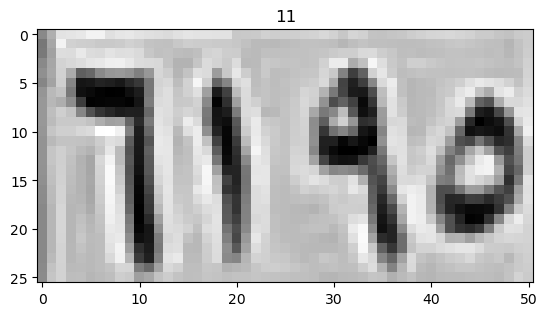

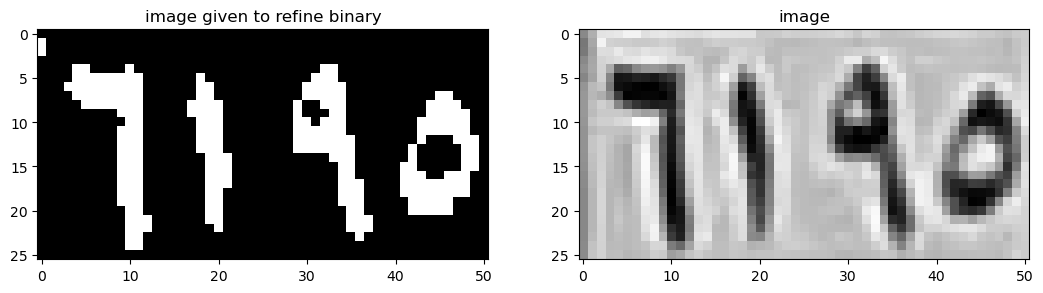

[False  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
After
[False  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False]


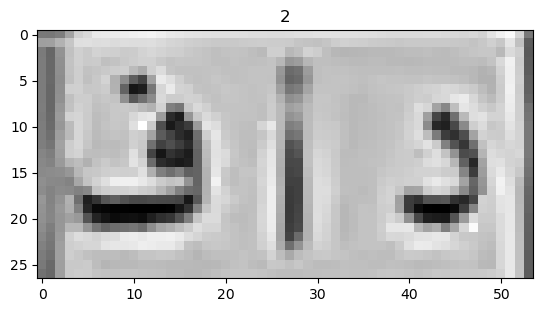

[0.36060588 0.46648824 0.36112667 0.36504824 0.36473569 0.36473569
 0.36500353 0.36500353 0.3666702  0.36274863 0.3666702  0.3666702
 0.37059176 0.39019961 0.39972431 0.40756745 0.41933216 0.41148902
 0.44286157 0.43109686 0.42550863 0.41374392 0.39805765 0.3784498
 0.36473569 0.35689255 0.33336314]
[0.35276275 0.4704098  0.30230314 0.30622471 0.30591216 0.30983373
 0.30225843 0.30225843 0.3039251  0.31176824 0.3156898  0.32745451
 0.34314078 0.37059176 0.38795961 0.41148902 0.40364588 0.38795961
 0.38795961 0.39188118 0.39413608 0.37060667 0.35884196 0.34707725
 0.33336314 0.30983373 0.30591216]
[0.37016118 0.52310235 0.43114941 0.42330627 0.41990549 0.41598392
 0.41934    0.42718314 0.4434349  0.45519961 0.44510157 0.46470941
 0.47647412 0.46863098 0.45294471 0.41765059 0.40029765 0.40814078
 0.43335176 0.44903804 0.4411949  0.44511647 0.45688118 0.46864588
 0.47061804 0.46669647 0.46783529]
After
[0.36060588 0.46648824 0.36112667 0.36504824 0.36473569 0.36473569
 0.36500353 0.365003

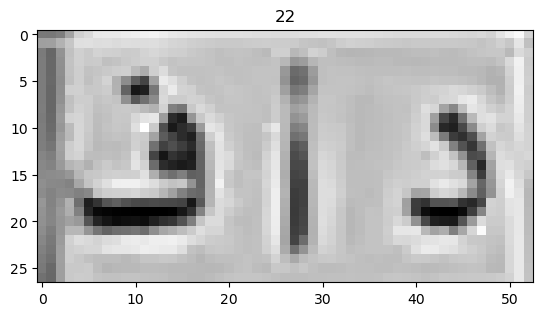

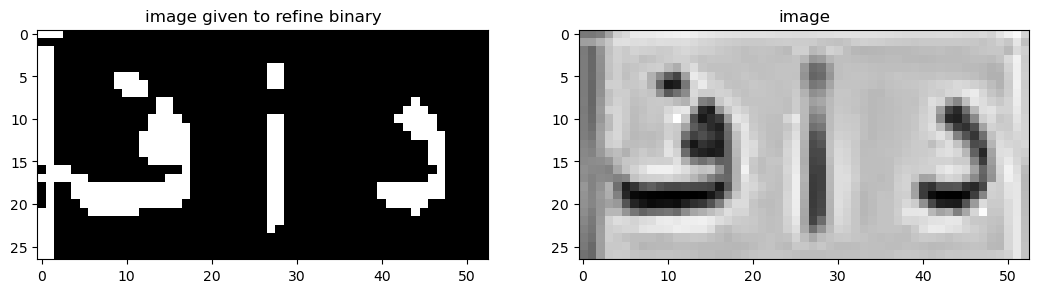

[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False False False  True  True  True
  True  True  True]
[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
[ True False False False False False False False False False False False
 False False False False  True  True False False False False False False
 False False False]
After
[False False False False False False False False False False False False
 False False False False False  True  True  True False False False False
 False False False]
to horizonatal


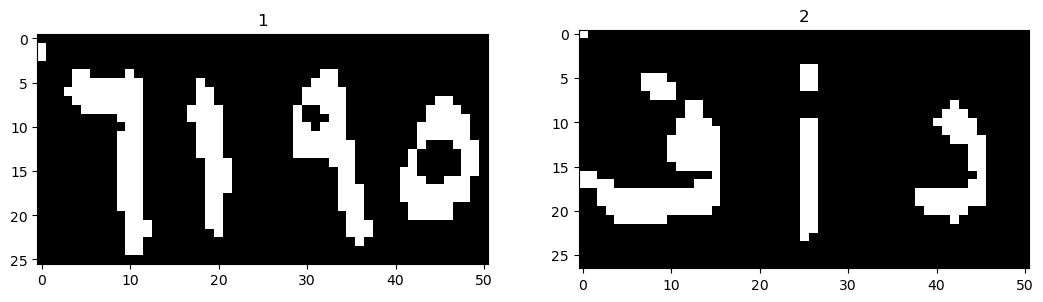

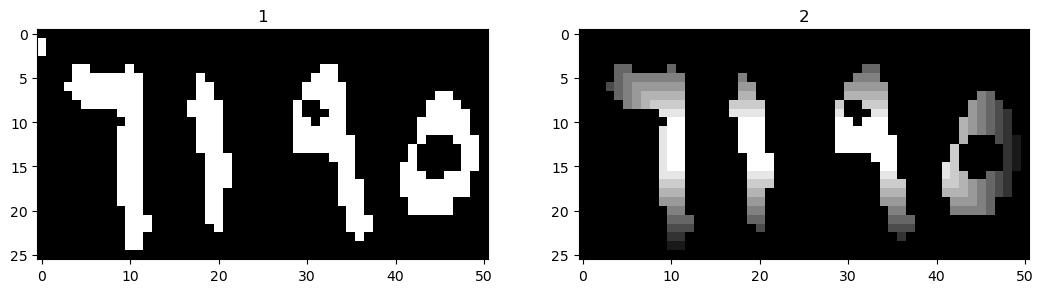

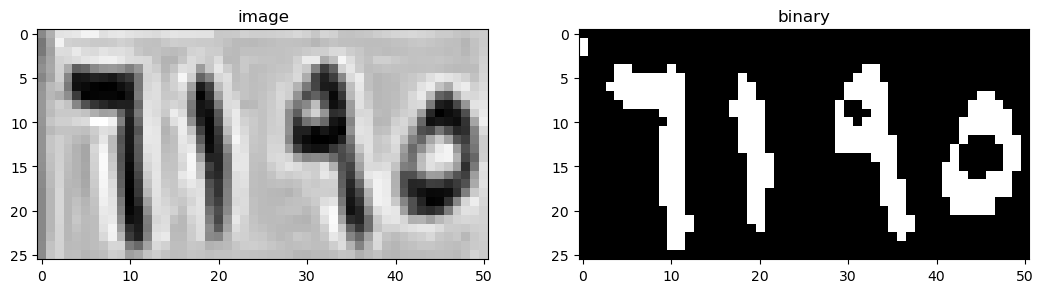

0 1
3 13
17 22
29 38
41 50
[(3, 13, array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False,  True,  True, False, False, False, False,  True, False,
        False, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [False, False, False, False, False, False,  True,  True,  True,
        False, False],
       [False, False, Fa

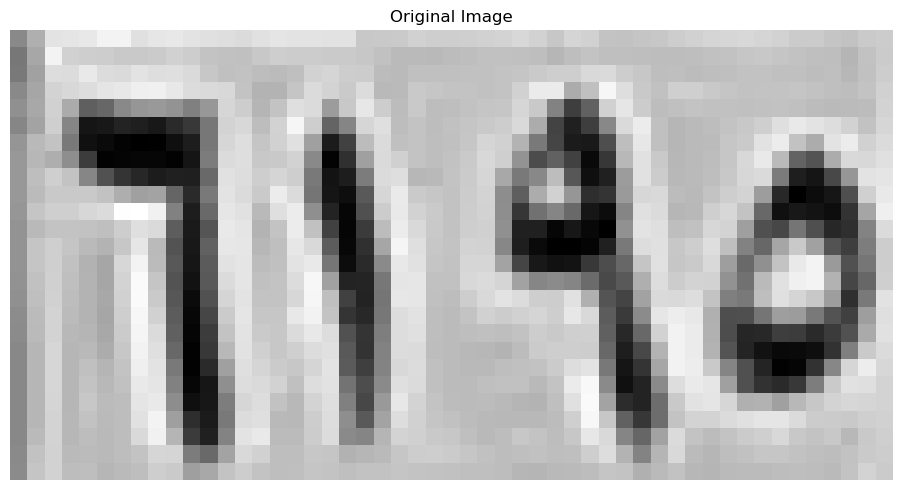

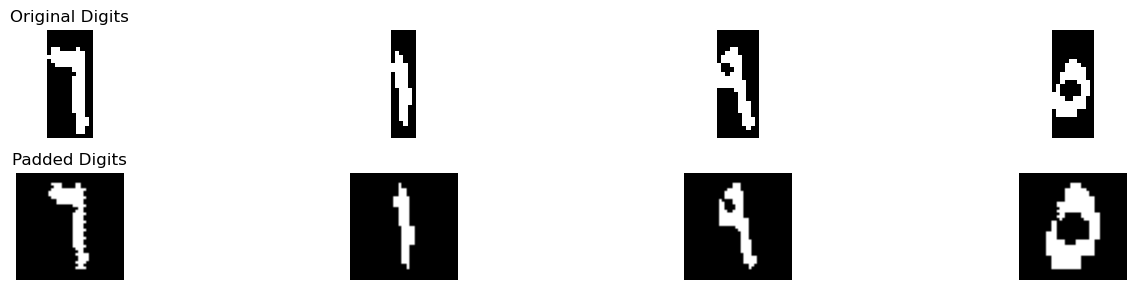

Best match: ٦
Full comparison results: {'١': 2.0520833333333335, '٢': 0.7583333333333333, '٣': 1.7431308049535603, '٤': 0.12916666666666665, '٥': 1.638093395252838, '٦': 5.395833333333333, '٧': 0.36764705882352944, '٨': 0.8277777777777777, '٩': 1.9332924836601308}
Confidence :  1.6718749999999998
Best match: ١
Full comparison results: {'١': 5.34375, '٢': 2.043924825174825, '٣': 1.2088815789473684, '٤': 1.2291437728937729, '٥': 0.8468229397021967, '٦': 0.3053571428571429, '٧': 1.3941176470588235, '٨': 2.5180555555555557, '٩': 1.2848950477626948}
Confidence :  1.4128472222222221
Best match: ٩
Full comparison results: {'١': 3.7767857142857144, '٢': 2.5580357142857144, '٣': 1.529702012383901, '٤': 2.2979166666666666, '٥': 0.8979618163054695, '٦': 1.344345238095238, '٧': 0.9970588235294118, '٨': 2.520138888888889, '٩': 5.744514472455649}
Confidence :  0.9838643790849675
Best match: ٥
Full comparison results: {'١': 0.8, '٢': 1.3937499999999998, '٣': 0.93125, '٤': 2.59375, '٥': 7.743154761904

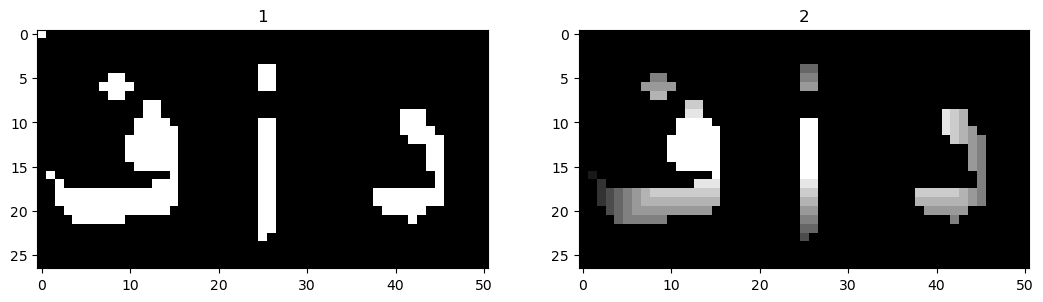

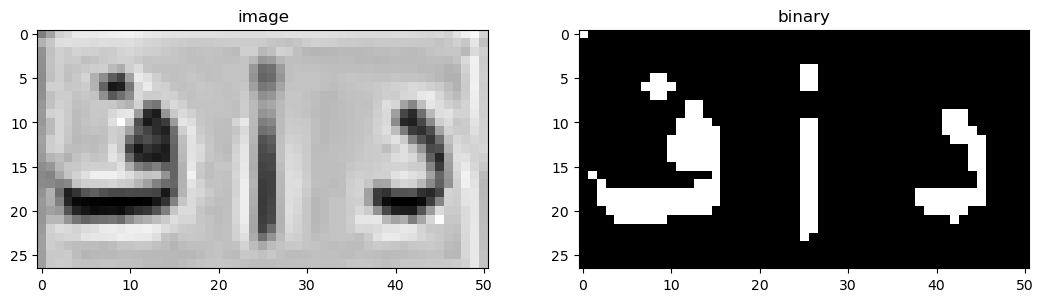

0 16


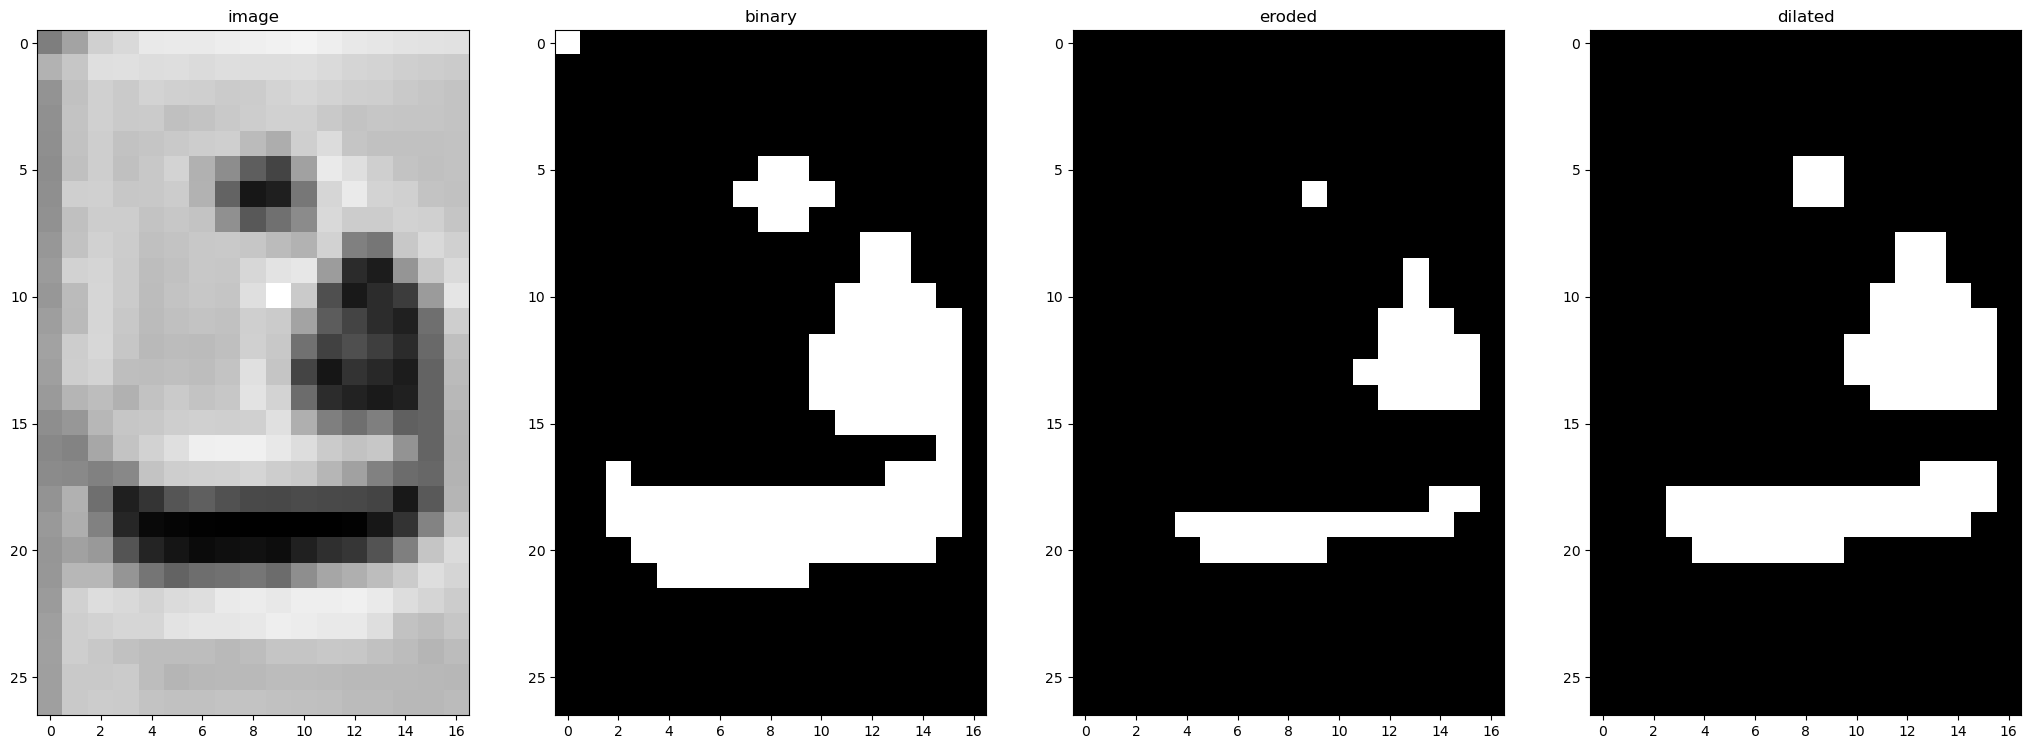

3 16
25 27
38 46
[(3, 16, array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False, False, False, False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False, False, False, False, False],
       [False, False, False, False, False,  True,  True,  True, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, Fals

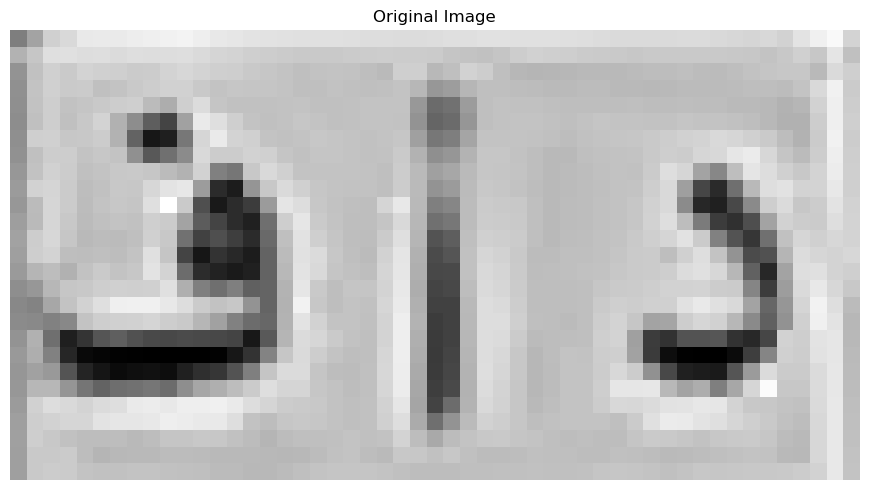

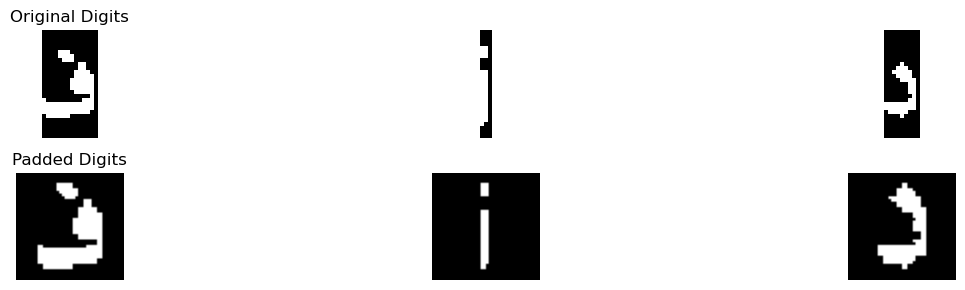

Best match: ف
Full comparison results: {'أ': 0.07291666666666666, 'ب': 0.03125, 'ج': 0.4270833333333333, 'د': 1.2395833333333335, 'ر': 0.3351293103448276, 'س': 0.375, 'ص': 0.25, 'ط': 0.75, 'ع': 0.36458333333333337, 'ف': 1.3831018518518519, 'ق': 0.75, 'ك': 0.5416666666666667, 'ل': 0.27083333333333337, 'م': 0.16666666666666666, 'ن': 0.71875, 'ه': 0.71875, 'و': 0.6145833333333333, 'ي': 0.9206730769230769}
Confidence :  0.07175925925925919
Best match: أ
Full comparison results: {'أ': 0.9333333333333333, 'ب': 0.0, 'ج': 0.13043478260869565, 'د': 0.03125, 'ر': 0.0, 'س': 0.0, 'ص': 0.0625, 'ط': 0.46875, 'ع': 0.0, 'ف': 0.0, 'ق': 0.0, 'ك': 0.0, 'ل': 0.0, 'م': 0.0, 'ن': 0.06666666666666667, 'ه': 0.03125, 'و': 0.0, 'ي': 0.0}
Confidence :  0.23229166666666667
Best match: د
Full comparison results: {'أ': 0.05555555555555555, 'ب': 0.0, 'ج': 0.3858695652173913, 'د': 1.0710227272727273, 'ر': 0.09375, 'س': 0.28125, 'ص': 0.28125, 'ط': 0.22916666666666666, 'ع': 0.03125, 'ف': 0.3645833333333333, 'ق': 0.4621

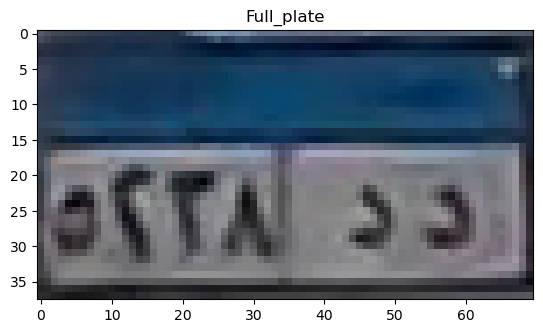

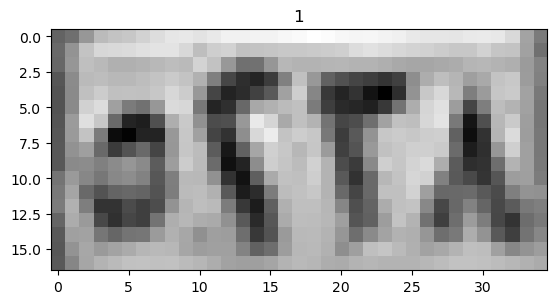

[0.27459216 0.29137961 0.28353647 0.24123255 0.23338941 0.23391725
 0.23783882 0.24286157 0.24678314 0.24676039 0.31734863 0.33135333
 0.3352749  0.27842353 0.25097255 0.24256392 0.25040706]
[0.30596471 0.40118353 0.4051051  0.37848745 0.37456588 0.37509373
 0.41823098 0.41541059 0.39580275 0.37617216 0.41538784 0.44507882
 0.47645137 0.46273725 0.43136471 0.39942667 0.36413255]
[0.40843843 0.52376314 0.51199843 0.49891725 0.51460353 0.55940745
 0.59470157 0.52324235 0.42912471 0.38009373 0.36832902 0.29213765
 0.34311804 0.41706235 0.4366702  0.45040706 0.44648549]
After
[0.27459216 0.29137961 0.28353647 0.24123255 0.23338941 0.23391725
 0.23783882 0.24286157 0.24678314 0.24676039 0.31734863 0.33135333
 0.3352749  0.27842353 0.25097255 0.24256392 0.25040706]


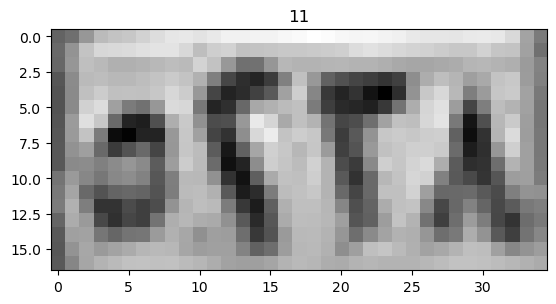

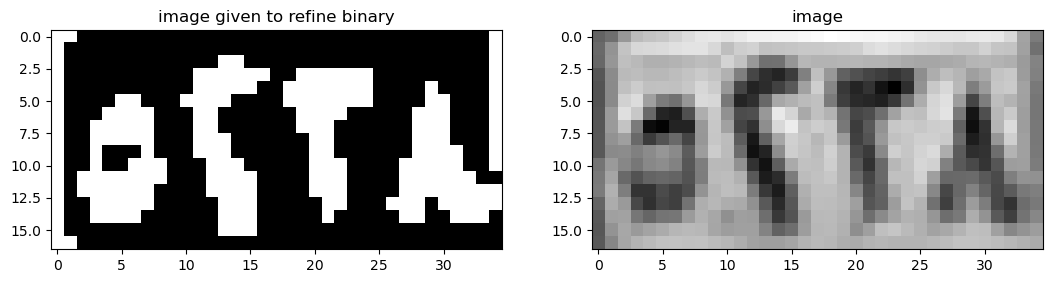

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[ True False False False False False False False False False False False
 False False False False  True]
[False False False False False False False False False False False  True
  True False False False False]
After
[False False False False False False False False False False False  True
  True False False False False]


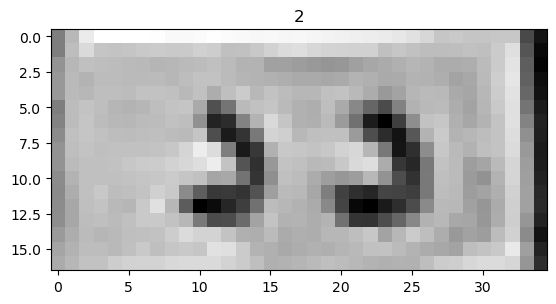

[0.37463255 0.37534588 0.42240471 0.43109686 0.43109686 0.37449843
 0.38626314 0.40392157 0.42352941 0.42100667 0.40532039 0.40139882
 0.40532039 0.40924196 0.43669294 0.46022235 0.47198706]
[0.50093333 0.51115647 0.49939176 0.50617216 0.50617216 0.50923059
 0.50923059 0.51764706 0.51372549 0.50728118 0.4915949  0.47590863
 0.46414392 0.46414392 0.47590863 0.48767333 0.49943804]
[0.61073725 0.57390157 0.51899961 0.49048588 0.49832902 0.52491686
 0.52883843 0.52941176 0.5254902  0.51904588 0.51904588 0.51904588
 0.51512431 0.51120275 0.50728118 0.51120275 0.52296745]
After
[0.37463255 0.37534588 0.42240471 0.43109686 0.43109686 0.37449843
 0.38626314 0.40392157 0.42352941 0.42100667 0.40532039 0.40139882
 0.40532039 0.40924196 0.43669294 0.46022235 0.47198706]


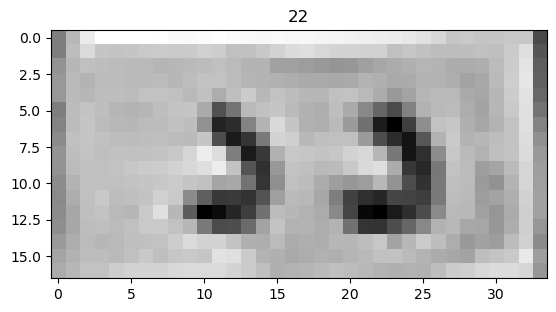

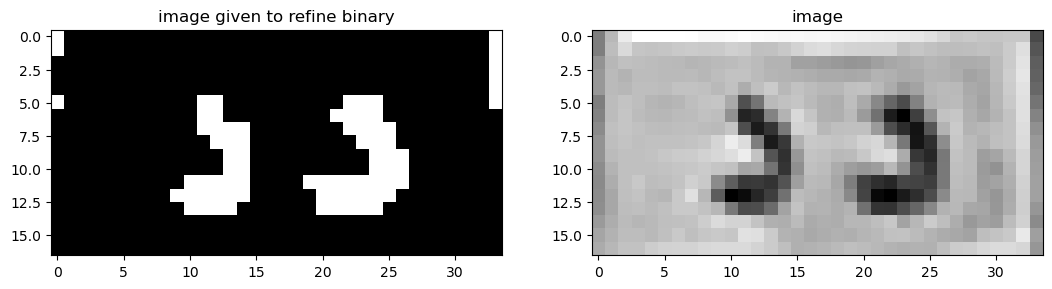

[ True  True False False False  True False False False False False False
 False False False False False]
[False False False False False False False False False False False False
 False False False False False]
[False False False False False False False False False False False False
 False False False False False]
After
[ True  True False False False  True False False False False False False
 False False False False False]
to horizonatal


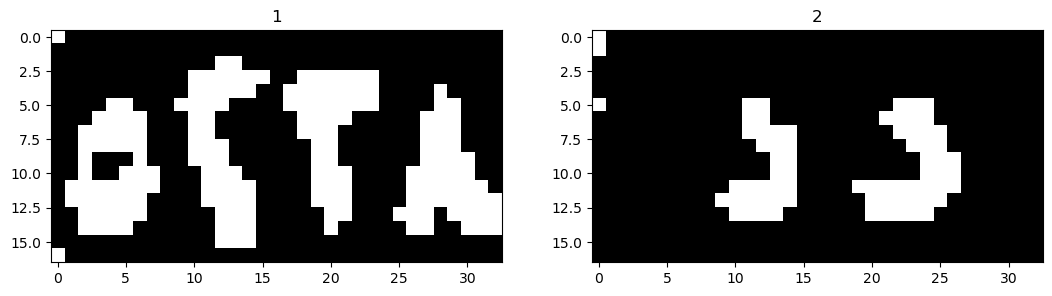

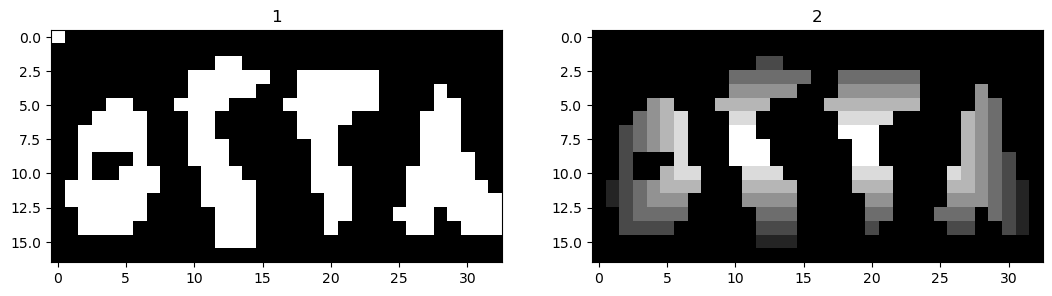

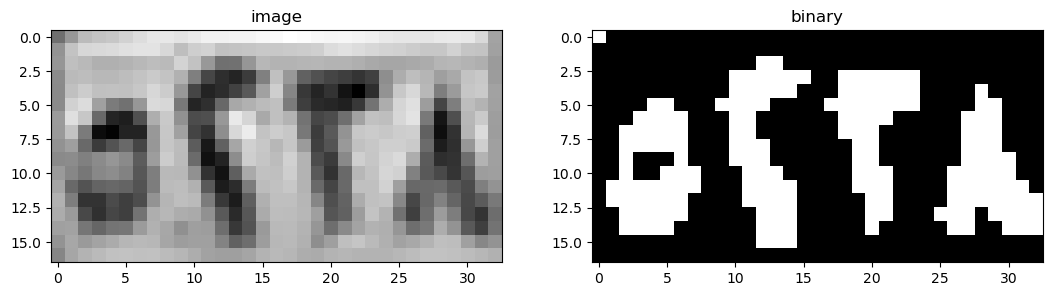

0 8
9 16
17 24
25 32
[(0, 8, array([[ True, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False,  True,  True, False, False, False],
       [False, False, False,  True,  True,  True,  True, False, False],
       [False, False,  True,  True,  True,  True,  True, False, False],
       [False, False,  True,  True,  True,  True,  True, False, False],
       [False, False,  True, False, False, False,  True, False, False],
       [False, False,  True, False, False,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True, False, False],
       [False, False,  True,  True,

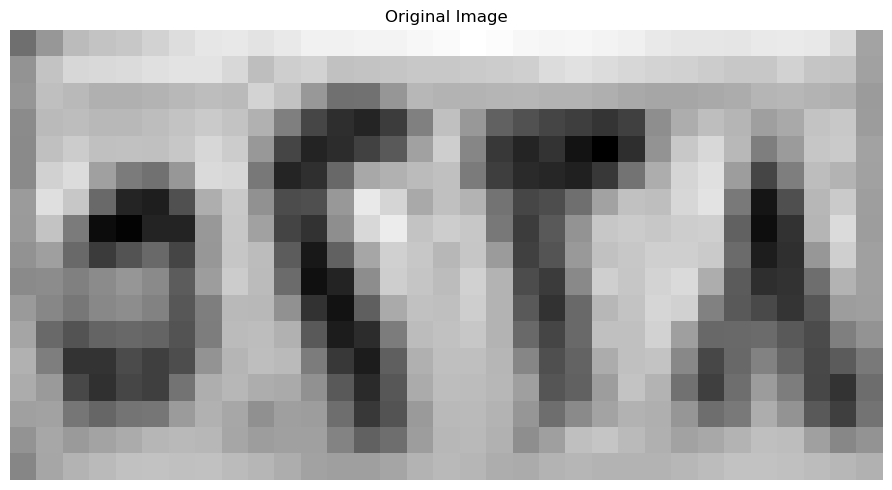

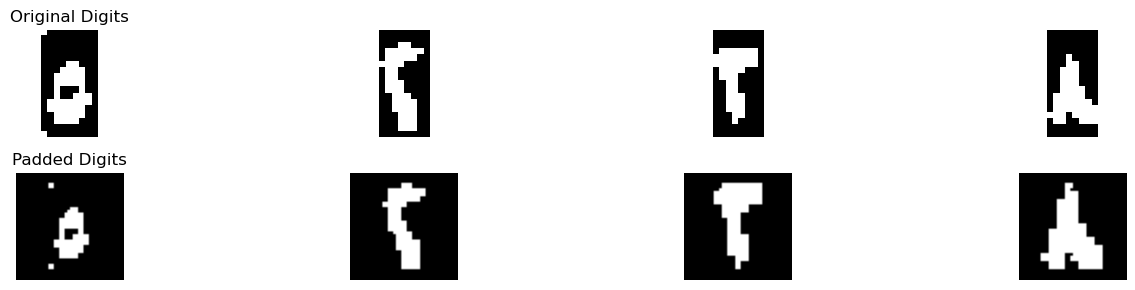

Best match: ٨
Full comparison results: {'١': 1.66875, '٢': 0.4, '٣': 0.29895510835913314, '٤': 0.45, '٥': 0.0625, '٦': 0.9979166666666666, '٧': 1.4871323529411766, '٨': 2.5361111111111114, '٩': 1.1318218954248365}
Confidence :  0.43368055555555574
Best match: ٢
Full comparison results: {'١': 0.9375, '٢': 4.4375, '٣': 3.715170278637771, '٤': 2.65625, '٥': 2.7544182146542826, '٦': 1.75625, '٧': 2.127205882352941, '٨': 0.9854166666666666, '٩': 1.6999591503267975}
Confidence :  0.3611648606811144
Best match: ٣
Full comparison results: {'١': 1.1979166666666667, '٢': 3.458333333333333, '٣': 4.6946271929824555, '٤': 2.2118055555555554, '٥': 2.4685411445279866, '٦': 2.168055555555555, '٧': 2.7583333333333337, '٨': 0.8784722222222222, '٩': 1.4652777777777777}
Confidence :  0.6181469298245612
Best match: ٨
Full comparison results: {'١': 1.9864130434782608, '٢': 1.441576086956522, '٣': 1.076086956521739, '٤': 2.1793478260869565, '٥': 2.7554347826086953, '٦': 0.6834239130434783, '٧': 0.89538043478

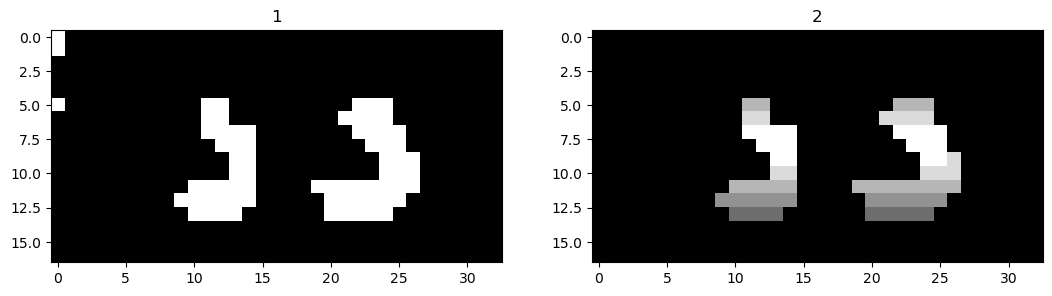

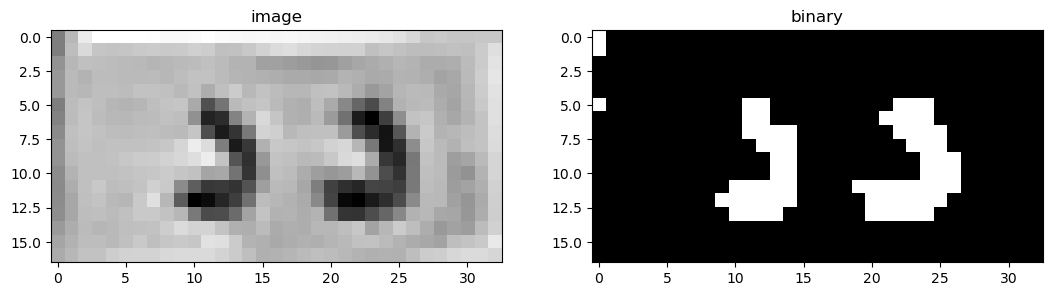

0 1
9 15
19 27
[(9, 15, array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True, False],
       [False, False, False,  True,  True,  True, False],
       [False, False, False, False,  True,  True, False],
       [False, False, False, False,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False

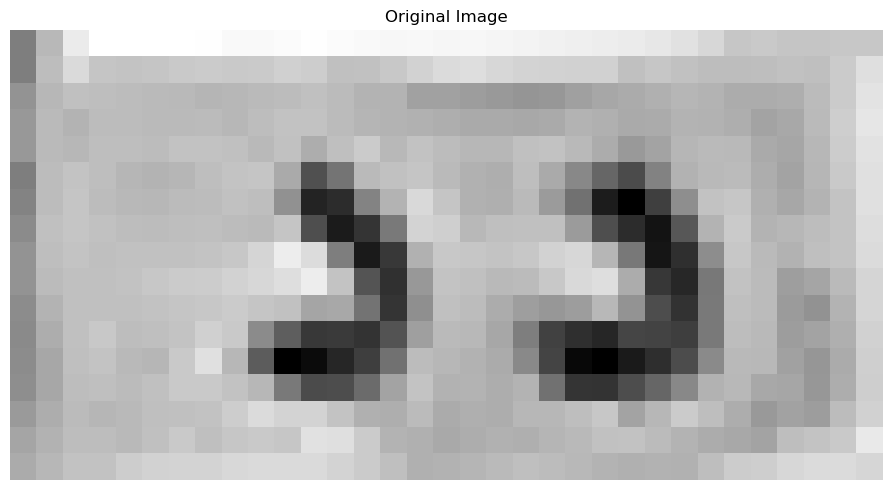

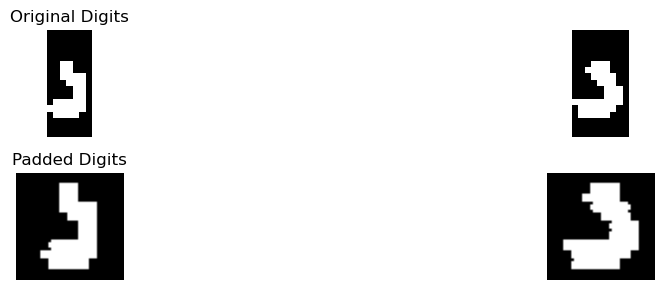

Best match: د
Full comparison results: {'أ': 0.047619047619047616, 'ب': 0.0, 'ج': 0.40489130434782605, 'د': 1.1619318181818183, 'ر': 0.1939655172413793, 'س': 0.375, 'ص': 0.1875, 'ط': 0.5729166666666667, 'ع': 0.25148809523809523, 'ف': 0.9363425925925926, 'ق': 0.6800595238095238, 'ك': 0.40625, 'ل': 0.3005952380952381, 'م': 0.34523809523809523, 'ن': 0.6309523809523809, 'ه': 0.875, 'و': 0.59375, 'ي': 0.5721153846153846}
Confidence :  0.11279461279461289
Best match: ه
Full comparison results: {'أ': 0.03571428571428571, 'ب': 0.0, 'ج': 0.7098214285714286, 'د': 0.8571428571428571, 'ر': 0.22844827586206895, 'س': 0.46875, 'ص': 0.125, 'ط': 0.46875, 'ع': 0.23214285714285715, 'ف': 0.9910714285714286, 'ق': 0.48660714285714285, 'ك': 0.3705357142857143, 'ل': 0.13839285714285715, 'م': 0.32589285714285715, 'ن': 0.44642857142857145, 'ه': 1.09375, 'و': 0.5446428571428572, 'ي': 0.5044642857142857}
Confidence :  0.0513392857142857
[['٨', '٢', '٣', '٨'], ['د', 'ه']]


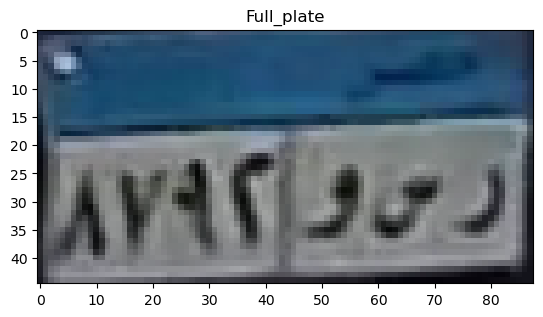

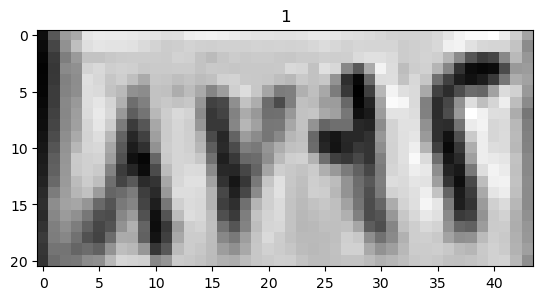

[0.06395843 0.05299725 0.04123255 0.03335176 0.03727333 0.03923059
 0.04679098 0.05715686 0.06107843 0.07284314 0.08460784 0.0938498
 0.10169294 0.11402314 0.12970941 0.14147412 0.13363098 0.15323882
 0.17284667 0.16108196 0.15295608]
[0.24323451 0.20118353 0.17036157 0.16276353 0.1666851  0.17620275
 0.17620275 0.1904902  0.19833333 0.21401961 0.23754902 0.25855569
 0.26639882 0.28657216 0.33363098 0.37676824 0.36108196 0.34147412
 0.33755255 0.31402314 0.29469804]
[0.41411686 0.3857651  0.33842353 0.36809176 0.34539569 0.35127451
 0.36303922 0.36247373 0.36639529 0.37872549 0.3904902  0.39973216
 0.40365373 0.40757529 0.41934    0.42774863 0.41206235 0.3806898
 0.36108196 0.31542196 0.31962627]
After
[0.24323451 0.20118353 0.17036157 0.16276353 0.1666851  0.17620275
 0.17620275 0.1904902  0.19833333 0.21401961 0.23754902 0.25855569
 0.26639882 0.28657216 0.33363098 0.37676824 0.36108196 0.34147412
 0.33755255 0.31402314 0.29469804]


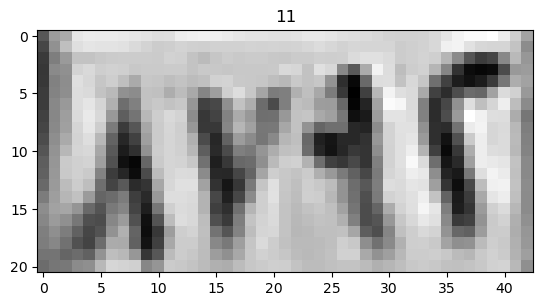

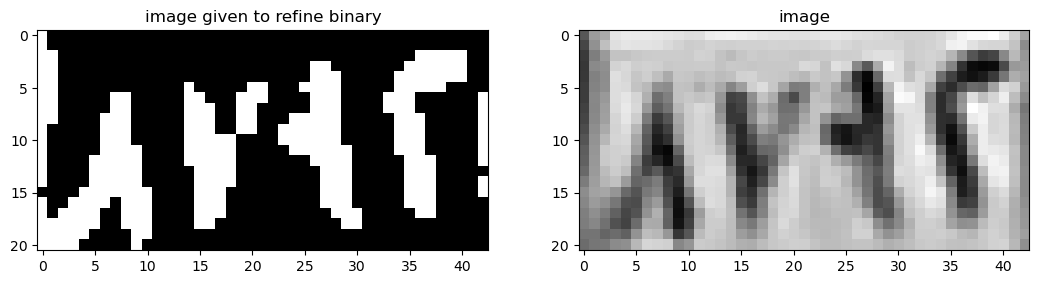

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True]
[False False  True  True  True  True  True  True  True False False False
 False False False False False False  True  True  True]
[False False False False False False False False False False False False
 False False False False False  True  True  True  True]
After
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True False False]
0.0 42.0 0.0 24.0


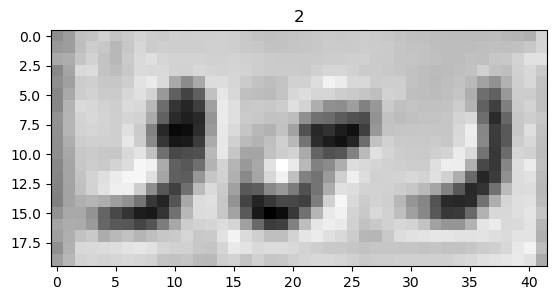

[0.37541412 0.4000149  0.43894784 0.35995098 0.37647059 0.35855216
 0.35855216 0.38600314 0.38208157 0.37816    0.37816    0.35911765
 0.35519608 0.35127451 0.3395098  0.38656863 0.42970588 0.41822392
 0.38012431 0.41598392]
[0.41042549 0.41177961 0.4504298  0.43025647 0.41540353 0.4409051
 0.46443451 0.46835608 0.46835608 0.4526698  0.43698353 0.42970588
 0.42970588 0.42578431 0.42578431 0.43754902 0.44931373 0.45463412
 0.45855569 0.47480745]
[0.49360471 0.49048667 0.50700627 0.5563051  0.52493255 0.52661412
 0.55798667 0.54286588 0.53894431 0.52717961 0.5154149  0.51177608
 0.50504902 0.49637255 0.45715686 0.43754902 0.44539216 0.50252627
 0.55267333 0.54511294]
After
[0.37541412 0.4000149  0.43894784 0.35995098 0.37647059 0.35855216
 0.35855216 0.38600314 0.38208157 0.37816    0.37816    0.35911765
 0.35519608 0.35127451 0.3395098  0.38656863 0.42970588 0.41822392
 0.38012431 0.41598392]


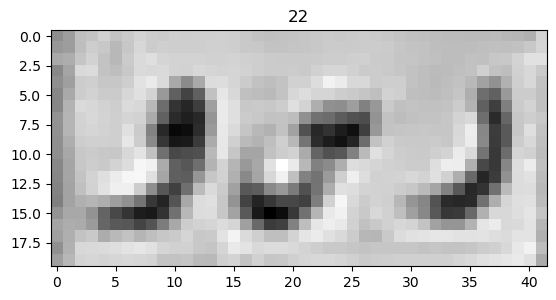

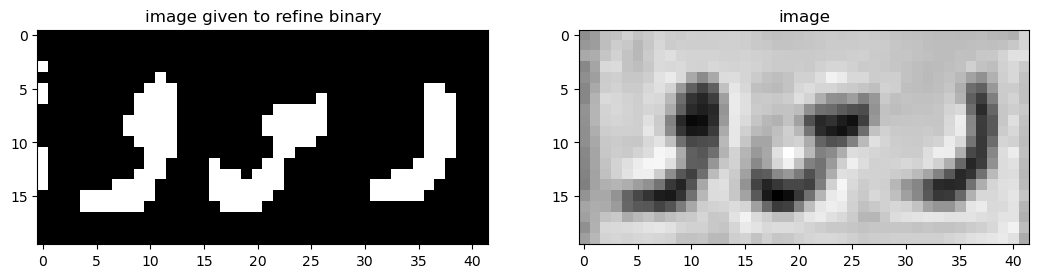

[False False False  True False  True  True False False False False  True
  True  True  True False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]
After
[False False False  True False  True  True False False False False  True
  True  True  True False False False False False]
to horizonatal


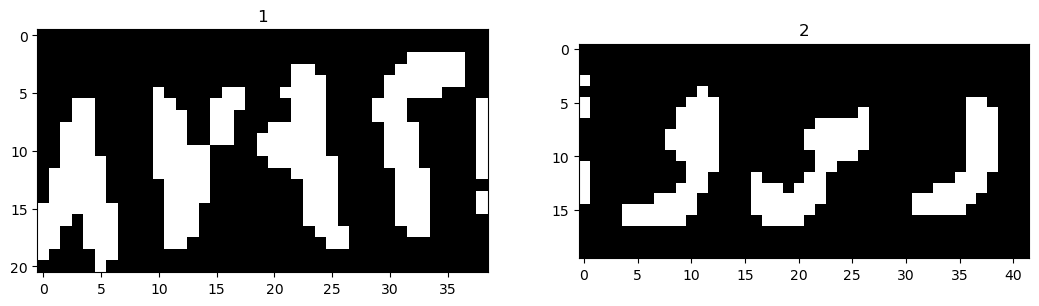

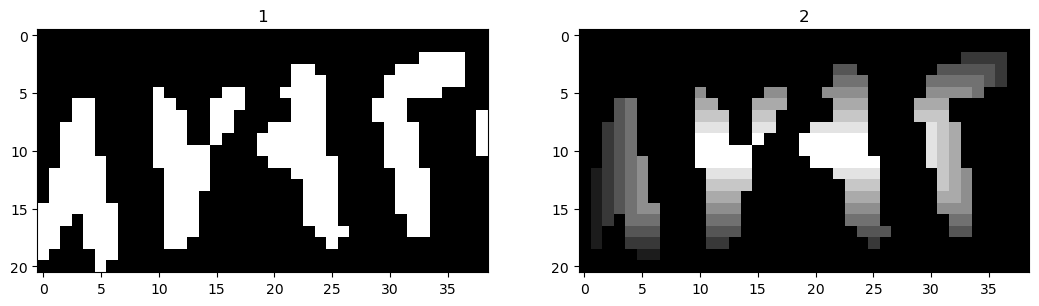

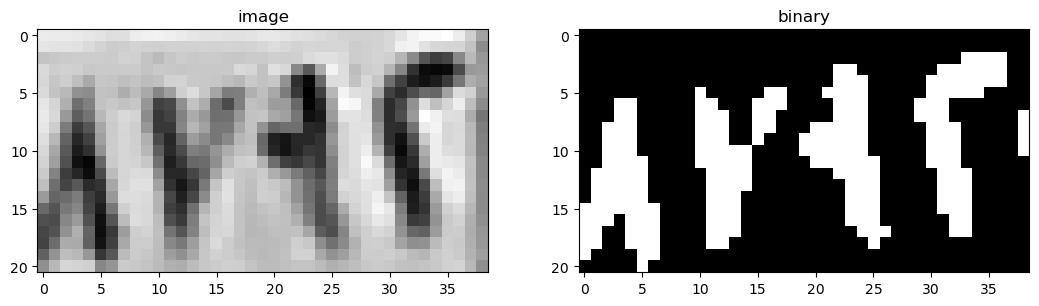

0 7
10 18
19 27
29 37
[(0, 7, array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False,  True,  True, False, False, False],
       [False, False, False,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True, False, Fal

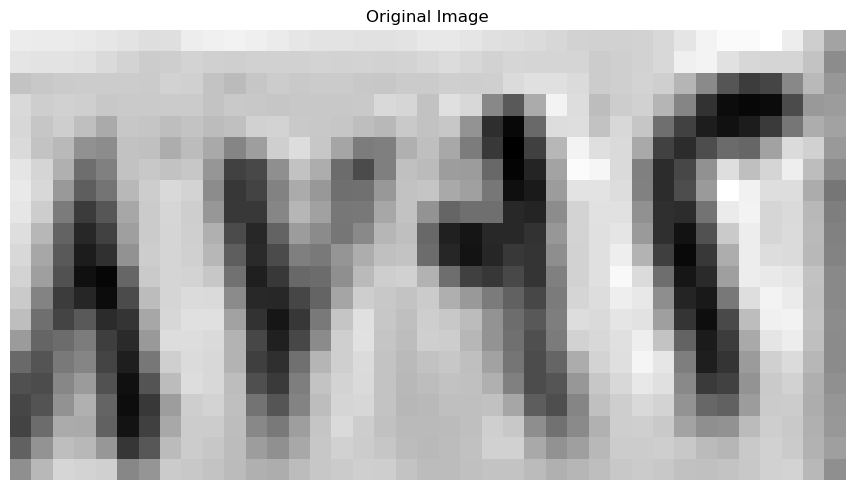

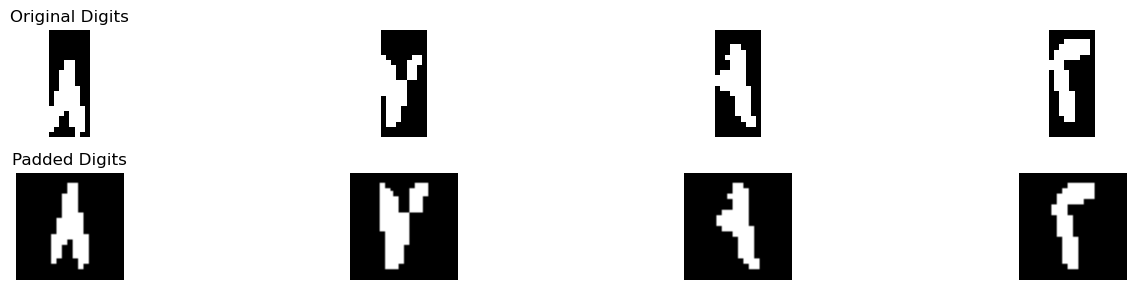

Best match: ٨
Full comparison results: {'١': 3.053571428571429, '٢': 1.3169642857142856, '٣': 0.96671826625387, '٤': 2.0080357142857146, '٥': 1.667952049240749, '٦': 1.2148809523809523, '٧': 0.8779411764705883, '٨': 5.78125, '٩': 2.8605567226890756}
Confidence :  1.3638392857142856
Best match: ٧
Full comparison results: {'١': 0.49999999999999994, '٢': 1.3090277777777777, '٣': 2.98062865497076, '٤': 1.75, '٥': 1.9593515037593983, '٦': 0.49097222222222225, '٧': 3.3541666666666665, '٨': 0.8270833333333333, '٩': 1.003472222222222}
Confidence :  0.1867690058479532
Best match: ٩
Full comparison results: {'١': 2.3125, '٢': 2.84375, '٣': 1.24796826625387, '٤': 1.21875, '٥': 1.8414234114698511, '٦': 1.93125, '٧': 0.9669117647058824, '٨': 3.48125, '٩': 4.2681781045751634}
Confidence :  0.39346405228758163
Best match: ٢
Full comparison results: {'١': 0.28125, '٢': 5.90625, '٣': 5.126064241486068, '٤': 3.21875, '٥': 2.651343432109686, '٦': 1.05, '٧': 3.033823529411765, '٨': 0.5930555555555556, '٩'

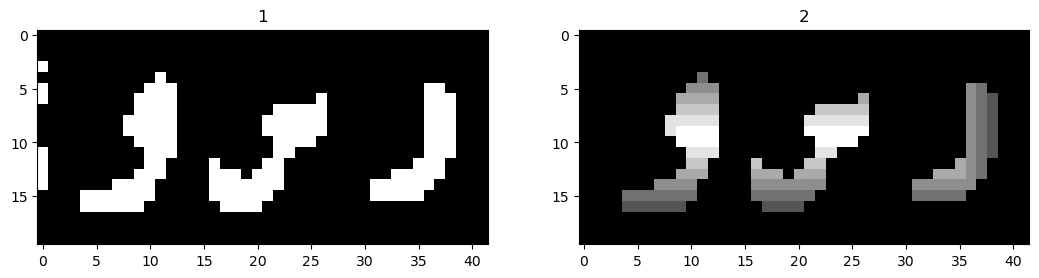

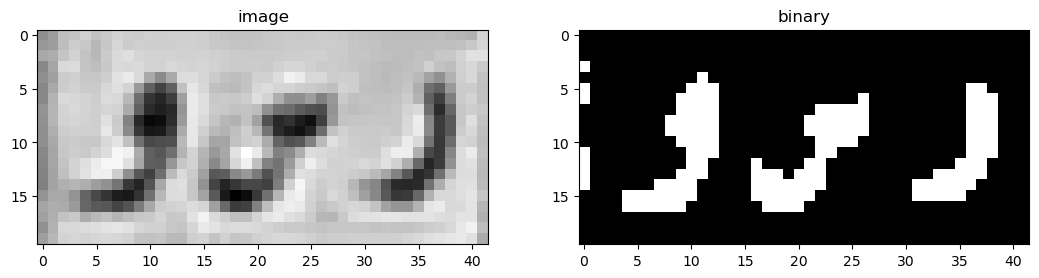

0 1
4 13
16 27
31 39
[(4, 13, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False,  True, False,
        False],
       [False, False, False, False, False, False,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False,  True,  True,  True,  True,  True,
        False],
       [False, False, False, False,  True,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False

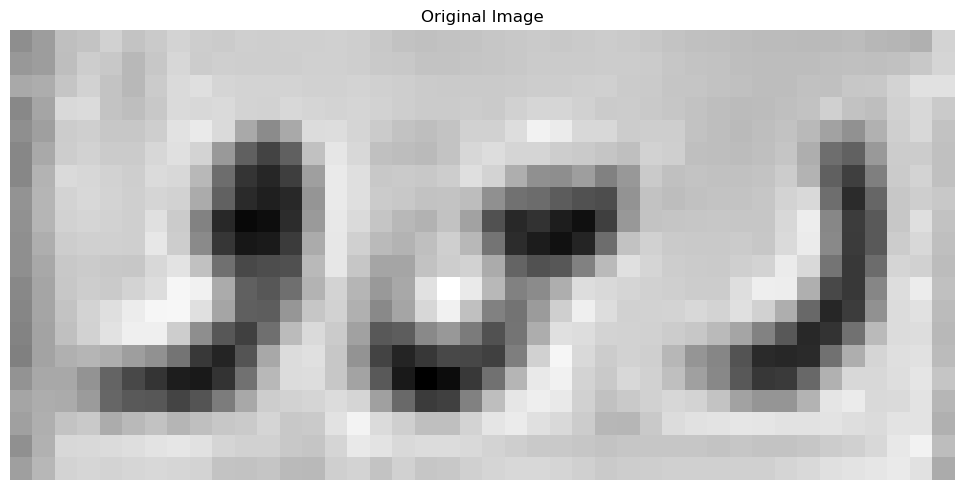

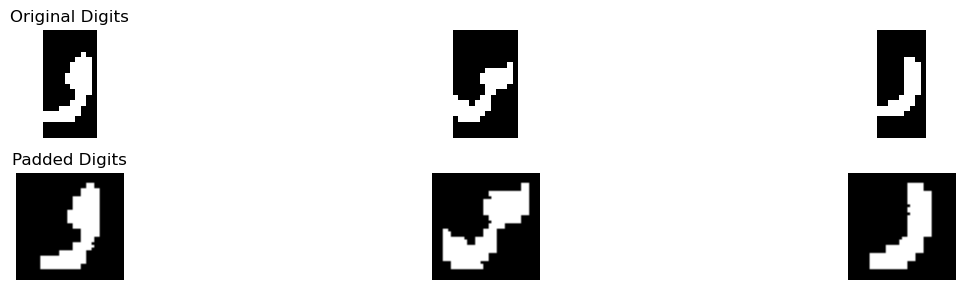

Best match: و
Full comparison results: {'أ': 0.045454545454545456, 'ب': 0.0, 'ج': 0.16847826086956522, 'د': 0.7613636363636364, 'ر': 0.7327586206896552, 'س': 0.5625, 'ص': 0.21875, 'ط': 0.4583333333333333, 'ع': 0.26136363636363635, 'ف': 0.6689814814814814, 'ق': 0.3068181818181818, 'ك': 0.7916666666666666, 'ل': 0.4119318181818182, 'م': 0.03125, 'ن': 0.48863636363636365, 'ه': 0.625, 'و': 1.3333333333333335, 'ي': 1.1129807692307692}
Confidence :  0.11017628205128216
Best match: س
Full comparison results: {'أ': 0.0625, 'ب': 0.15625, 'ج': 0.1875, 'د': 0.4375, 'ر': 0.21875, 'س': 1.375, 'ص': 0.96875, 'ط': 0.21875, 'ع': 0.0625, 'ف': 0.375, 'ق': 0.21875, 'ك': 0.28125, 'ل': 0.15625, 'م': 0.125, 'ن': 0.25, 'ه': 0.75, 'و': 0.5, 'ي': 0.53125}
Confidence :  0.203125
Best match: و
Full comparison results: {'أ': 0.08695652173913043, 'ب': 0.0, 'ج': 0.19972826086956522, 'د': 0.7961956521739131, 'ر': 0.5387931034482758, 'س': 0.5625, 'ص': 0.375, 'ط': 0.6458333333333333, 'ع': 0.21195652173913043, 'ف': 0.762

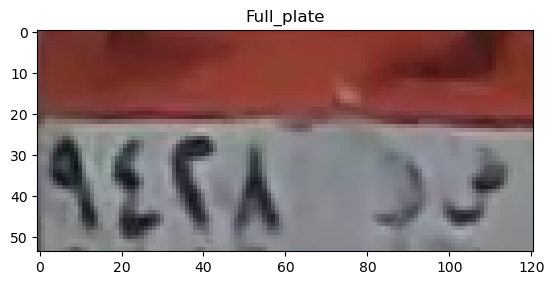

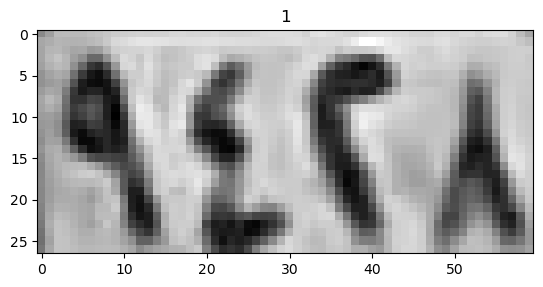

[0.41253059 0.48565647 0.48258314 0.48286588 0.47194941 0.44002627
 0.43472078 0.45798235 0.48488275 0.47732235 0.45799725 0.45015412
 0.43950549 0.42381922 0.44259373 0.41906431 0.40729961 0.41038784
 0.41291059 0.40787294 0.40647412 0.39834824 0.38601804 0.37425333
 0.3565949  0.34875176 0.36443804]
[0.46601098 0.50217608 0.5226549  0.5324702  0.51454392 0.47981529
 0.45630078 0.48823882 0.52830275 0.50394    0.46500706 0.45744667
 0.46612314 0.47479961 0.49749569 0.48881922 0.48097608 0.47313294
 0.46697922 0.4627749  0.46529765 0.47677961 0.49190039 0.5036651
 0.49273373 0.47424196 0.48992824]
[0.53379373 0.52178392 0.52629373 0.55516627 0.53752275 0.4985898
 0.4722698  0.47956235 0.49581412 0.47537294 0.44064431 0.42524078
 0.42971294 0.47004471 0.50533882 0.52019176 0.51515412 0.50702824
 0.4966702  0.48854431 0.49638745 0.51207373 0.53532039 0.55464549
 0.55576157 0.5565949  0.5565949 ]
After
[0.41253059 0.48565647 0.48258314 0.48286588 0.47194941 0.44002627
 0.43472078 0.457982

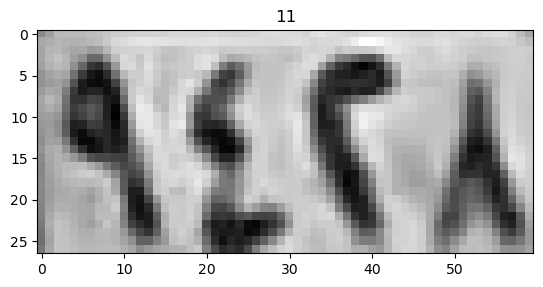

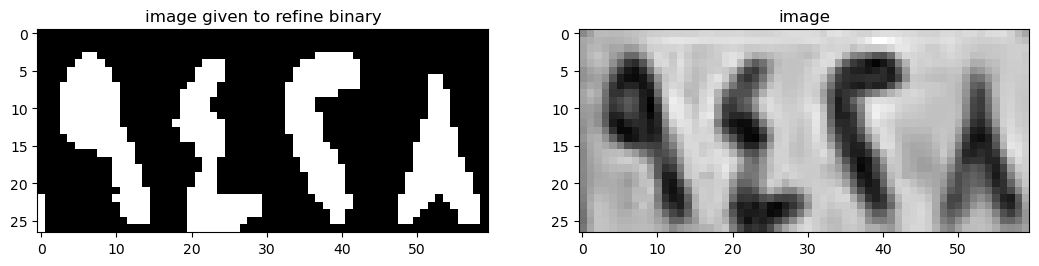

[False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


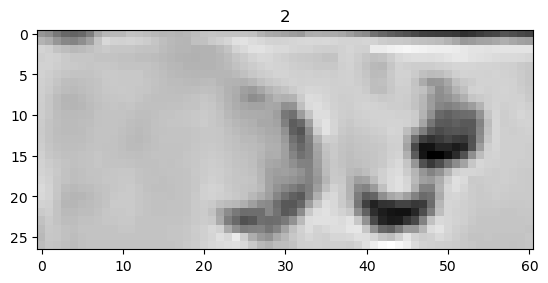

[0.44072392 0.50555412 0.57530902 0.5666851  0.57452824 0.5736949
 0.56894    0.56727333 0.56446784 0.5616702  0.5616702  0.55805412
 0.55608196 0.55748078 0.5616851  0.56924549 0.57316706 0.57510157
 0.58322745 0.59078784 0.58686627 0.57257882 0.55689255 0.53531255
 0.52354784 0.51767686 0.52580275]
[0.42308824 0.48651176 0.56803137 0.57314431 0.57426039 0.56361176
 0.5596902  0.55548588 0.54764275 0.54736784 0.54736784 0.54151176
 0.54151176 0.54151176 0.54543333 0.5493549  0.56111961 0.56697569
 0.57089725 0.57481882 0.57874039 0.56865725 0.56473569 0.55492039
 0.55099882 0.54904941 0.54512784]
[0.37294118 0.43945294 0.54141373 0.56922275 0.56501843 0.55268039
 0.54400392 0.53559529 0.52411333 0.52355569 0.52776    0.52974706
 0.52582549 0.52974706 0.53366863 0.54151176 0.5493549  0.55268824
 0.54904941 0.54988275 0.54596118 0.53923412 0.53923412 0.54315569
 0.54707725 0.54707725 0.53923412]
After
[0.44072392 0.50555412 0.57530902 0.5666851  0.57452824 0.5736949
 0.56894    0.567273

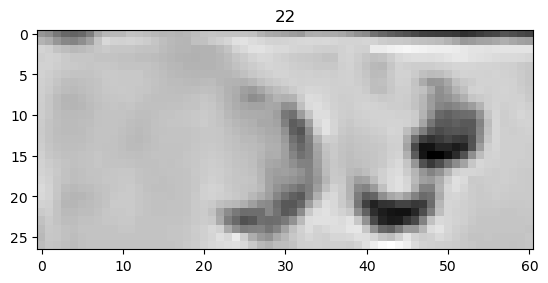

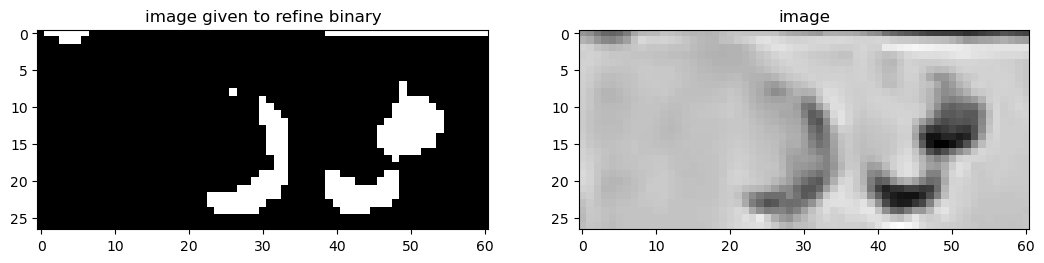

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
to horizonatal


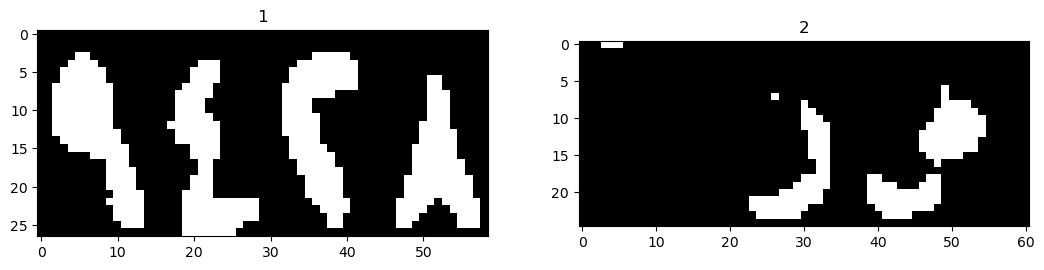

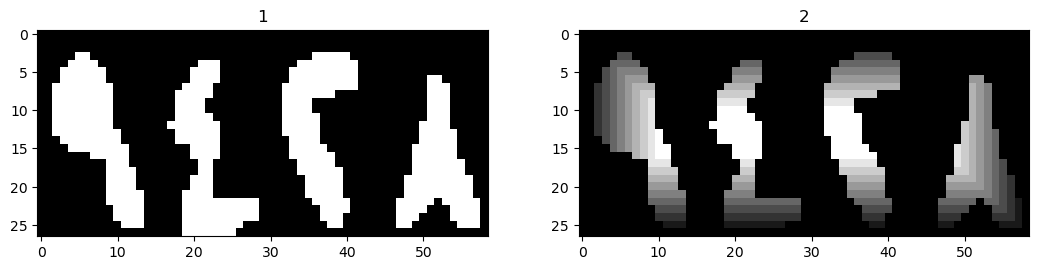

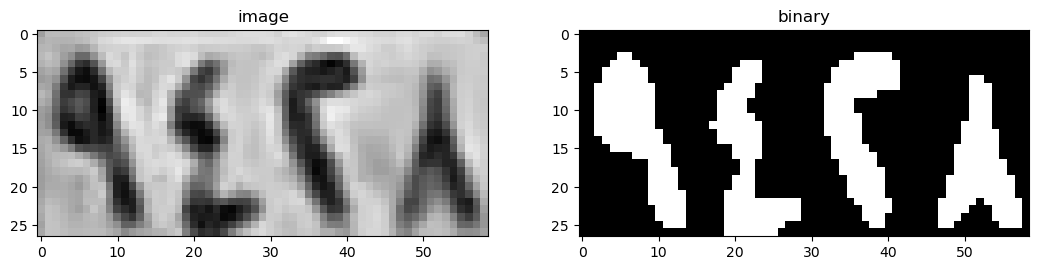

2 14
17 29
32 42
47 58
[(2, 14, array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False,  True,  True, False, False, False, False,
        False, False, False, False],
       [False, False,  True,  True,  True,  True, False, False, False,
        False, False, False, False],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, Fals

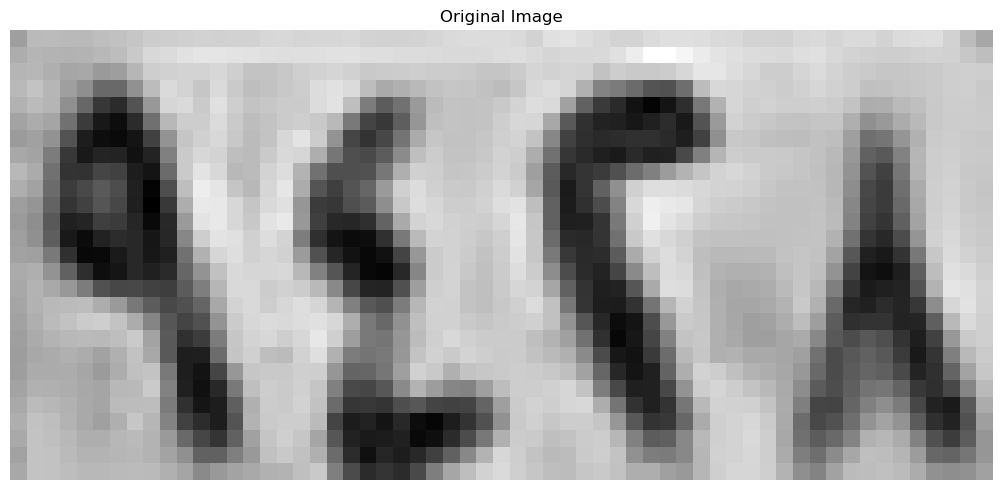

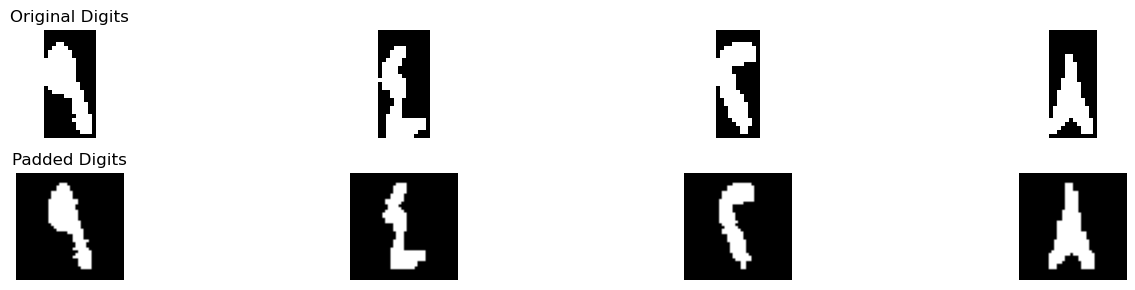

Best match: ٩
Full comparison results: {'١': 2.59375, '٢': 1.8125, '٣': 2.3948335913312695, '٤': 2.1875, '٥': 0.952938412206988, '٦': 1.85625, '٧': 1.4757352941176471, '٨': 3.372916666666667, '٩': 6.007557189542483}
Confidence :  1.3173202614379083
Best match: ٤
Full comparison results: {'١': 0.5625, '٢': 3.28125, '٣': 2.373452012383901, '٤': 5.84375, '٥': 2.1794606000294854, '٦': 0.125, '٧': 1.1492647058823529, '٨': 0.8798611111111111, '٩': 1.8909313725490198}
Confidence :  1.28125
Best match: ٢
Full comparison results: {'١': 0.9254807692307692, '٢': 6.8269230769230775, '٣': 4.246904024767802, '٤': 3.348878205128205, '٥': 2.667712479728734, '٦': 1.3086309523809523, '٧': 3.059926470588235, '٨': 0.41180555555555554, '٩': 1.533968074409251}
Confidence :  1.2900095260776379
Best match: ٨
Full comparison results: {'١': 3.5183823529411766, '٢': 1.3566176470588236, '٣': 1.1027476780185759, '٤': 2.110294117647059, '٥': 1.8915579389650599, '٦': 0.46176470588235297, '٧': 1.0955882352941178, '٨'

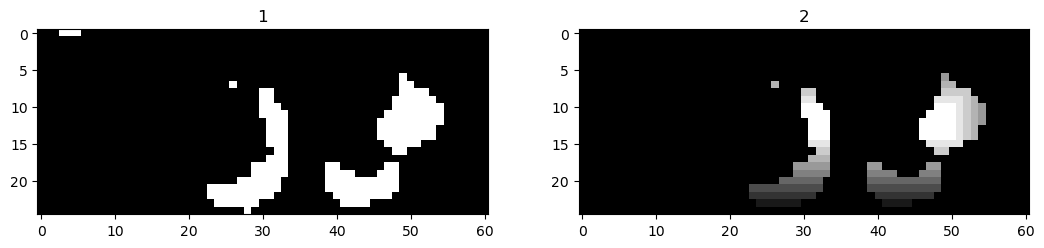

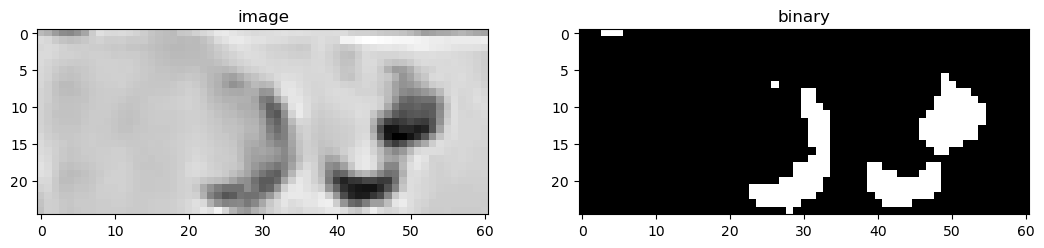

3 6
23 34
39 55
[(23, 34, array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False,  True, False,
        False, False, False],
       [False, False, False, False, False, False, False,  True,  

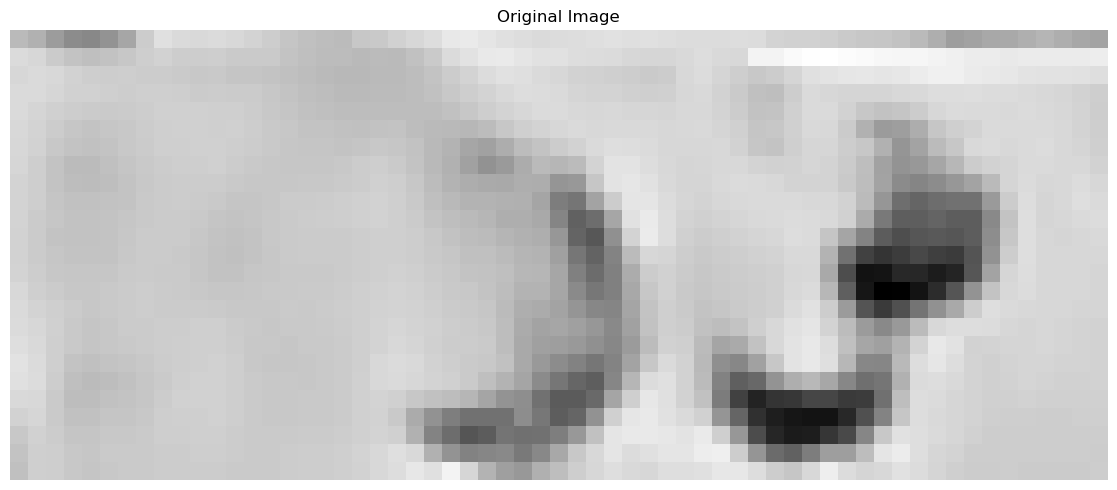

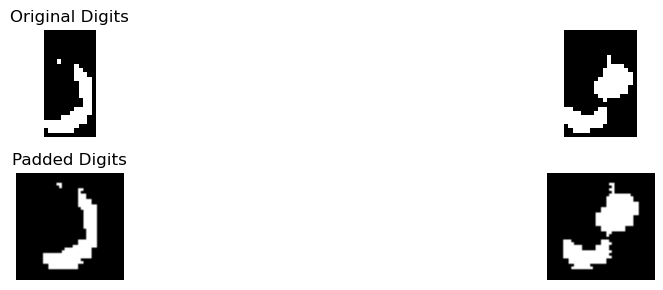

Best match: د
Full comparison results: {'أ': 0.05, 'ب': 0.09375, 'ج': 0.24320652173913043, 'د': 1.2528409090909092, 'ر': 0.7984913793103449, 'س': 0.375, 'ص': 0.125, 'ط': 0.6458333333333333, 'ع': 0.45625, 'ف': 0.7060185185185185, 'ق': 0.625, 'ك': 0.5416666666666667, 'ل': 0.725, 'م': 0.05, 'ن': 0.8875, 'ه': 0.34375, 'و': 1.03125, 'ي': 0.8100961538461539}
Confidence :  0.11079545454545459
Best match: س
Full comparison results: {'أ': 0.10714285714285714, 'ب': 0.03125, 'ج': 0.20089285714285715, 'د': 0.5848214285714286, 'ر': 0.4040948275862069, 'س': 1.21875, 'ص': 1.03125, 'ط': 0.3080357142857143, 'ع': 0.1359447004608295, 'ف': 0.45535714285714285, 'ق': 0.3705357142857143, 'ك': 0.41964285714285715, 'ل': 0.3125, 'م': 0.10714285714285714, 'ن': 0.3794642857142857, 'ه': 0.625, 'و': 0.7142857142857143, 'ي': 0.8169642857142857}
Confidence :  0.09375
[['٩', '٤', '٢', '٨'], ['د', 'س']]


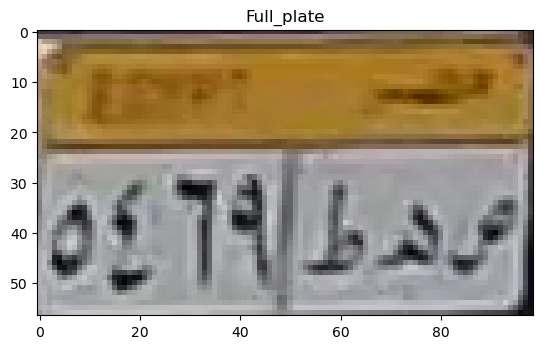

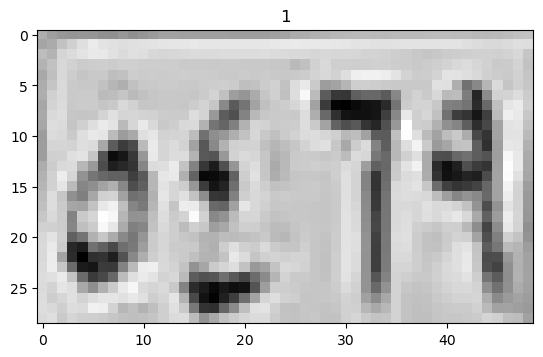

[0.54781333 0.52036235 0.59492471 0.56355216 0.52941176 0.54509804
 0.54875176 0.52522235 0.53363098 0.52578784 0.49441529 0.49441529
 0.49833686 0.54539569 0.56108196 0.57284667 0.59245451 0.60421922
 0.62774863 0.65912118 0.67872902 0.68265059 0.68265059 0.69049373
 0.69441529 0.69049373 0.69441529 0.69833686 0.68657216]
[0.49849255 0.53770824 0.56463843 0.60777569 0.60081843 0.62042627
 0.65490196 0.66666667 0.6820851  0.6938498  0.68992824 0.67032039
 0.65463412 0.64286941 0.65855569 0.65855569 0.6938498  0.6938498
 0.6820851  0.65463412 0.71737922 0.73306549 0.74090863 0.7448302
 0.70561451 0.66639882 0.64679098 0.6820851  0.70225843]
[0.47496314 0.61221804 0.67052078 0.67836392 0.6792498  0.68317137
 0.68627451 0.69019608 0.6938498  0.68992824 0.67816353 0.67032039
 0.65855569 0.6820851  0.7448302  0.72130078 0.62326157 0.63502627
 0.64286941 0.64286941 0.65071255 0.63894784 0.51737922 0.62326157
 0.73698706 0.72130078 0.67424196 0.65071255 0.63559176]
After
[0.54781333 0.5203623

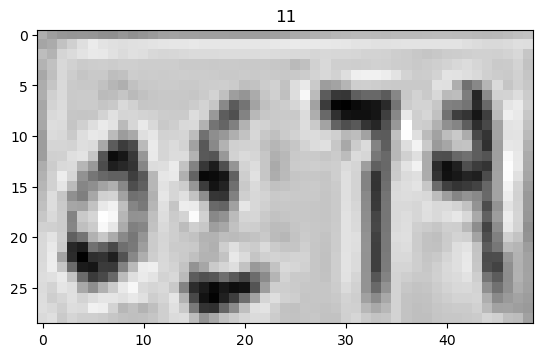

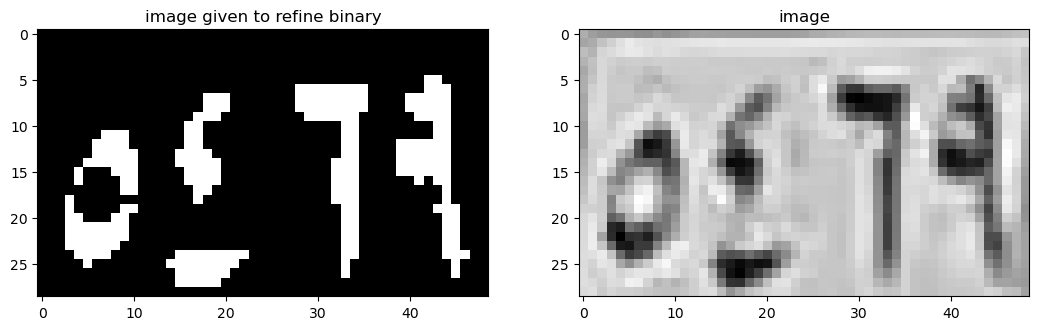

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
0.0 48.0 2.0 34.0


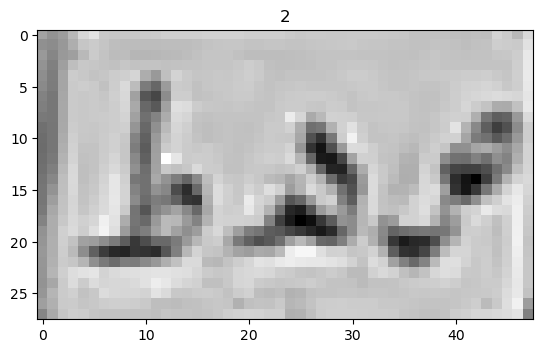

[0.52185843 0.4630349  0.48992039 0.47423412 0.45686627 0.44510157
 0.41934    0.41149686 0.39581059 0.36443804 0.3565949  0.35267333
 0.36051647 0.36443804 0.37620275 0.38404588 0.38404588 0.39188902
 0.42718314 0.47032039 0.47816353 0.48600667 0.4820851  0.47816353
 0.47424196 0.4820851  0.51010157 0.4316702 ]
[0.47087804 0.4512702  0.43109686 0.41541059 0.40588588 0.40196431
 0.38796745 0.38796745 0.38796745 0.38404588 0.38404588 0.38404588
 0.39188902 0.41149686 0.43502627 0.47424196 0.50561451 0.53698706
 0.55267333 0.55267333 0.5565949  0.5565949  0.56443804 0.57620275
 0.53306549 0.57620275 0.56108196 0.54147412]
[0.50225059 0.48656431 0.48992039 0.50952824 0.52745451 0.52745451
 0.53306549 0.53698706 0.53698706 0.54090863 0.54875176 0.5565949
 0.57228118 0.58796745 0.60365373 0.60757529 0.61541843 0.62326157
 0.63502627 0.65855569 0.65463412 0.65071255 0.64286941 0.65463412
 0.6434349  0.6434349  0.63951333 0.62774863]
After
[0.52185843 0.4630349  0.48992039 0.47423412 0.456866

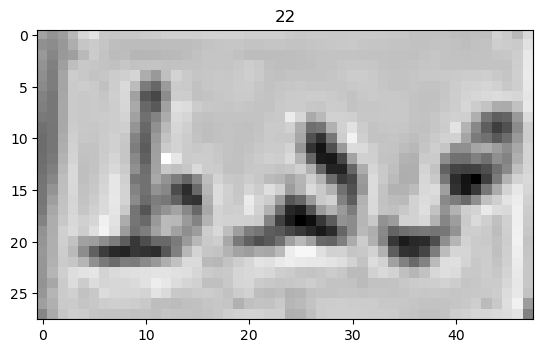

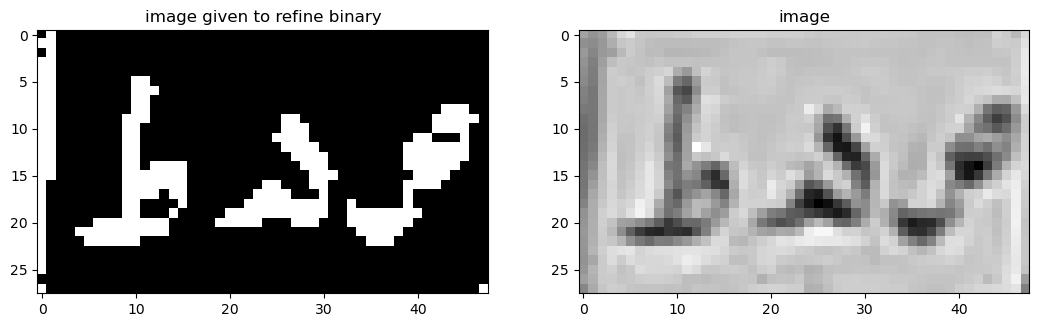

[False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False]
to horizonatal


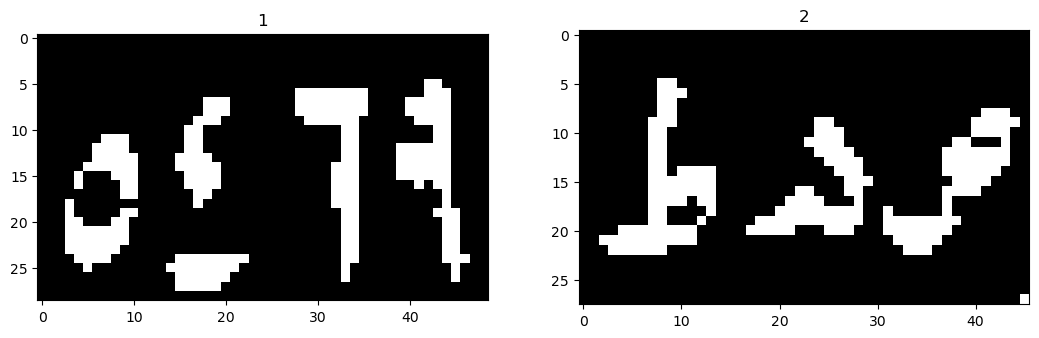

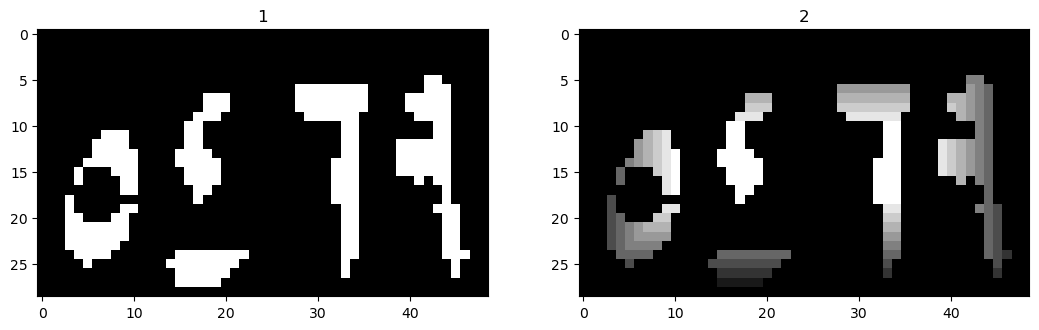

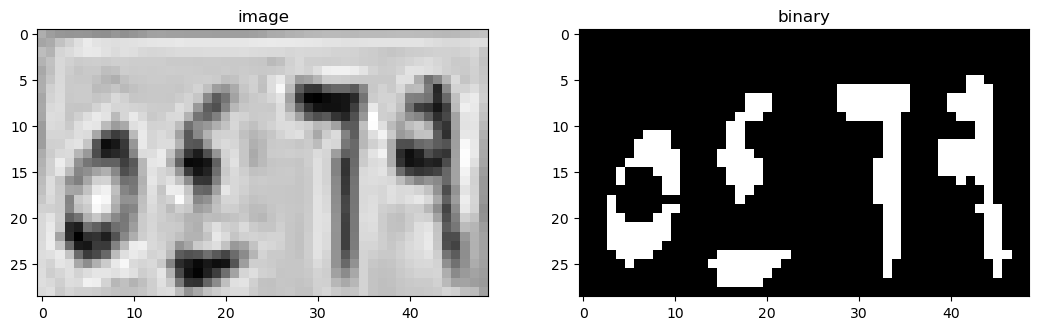

3 11
14 23
28 36
39 47
[(3, 11, array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True,  True, False, False],
       [False, False, False,  Tr

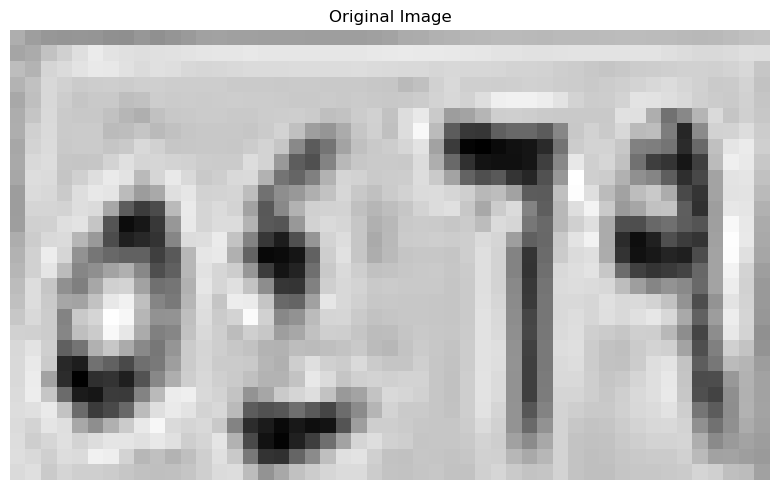

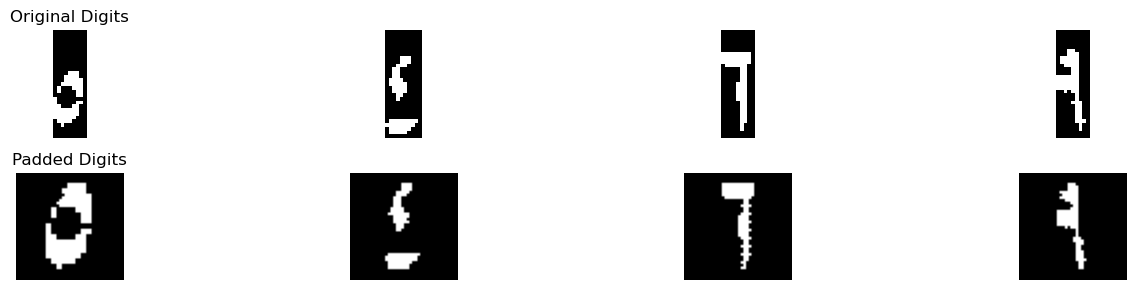

Best match: ٥
Full comparison results: {'١': 0.2941176470588235, '٢': 1.9264705882352944, '٣': 1.1523800309597525, '٤': 1.683823529411765, '٥': 7.267152255639098, '٦': 1.5562500000000001, '٧': 1.2437500000000001, '٨': 1.252859477124183, '٩': 0.6211192810457516}
Confidence :  2.6703408337019017
Best match: ٤
Full comparison results: {'١': 0.9903846153846154, '٢': 1.5552884615384617, '٣': 1.4140866873065017, '٤': 5.479884497223207, '٥': 2.879261573050273, '٦': 0.0, '٧': 0.25625, '٨': 1.3465277777777778, '٩': 1.1970368275515335}
Confidence :  1.3003114620864669
Best match: ٦
Full comparison results: {'١': 3.3645833333333335, '٢': 1.7011217948717947, '٣': 0.8191756965944272, '٤': 0.3345238095238095, '٥': 1.3553553000147427, '٦': 4.136904761904762, '٧': 0.3878676470588236, '٨': 0.6895833333333333, '٩': 1.7931121166415285}
Confidence :  0.3861607142857142
Best match: ١
Full comparison results: {'١': 4.014204545454545, '٢': 3.417540792540793, '٣': 1.4005417956656347, '٤': 2.3593406593406594, 

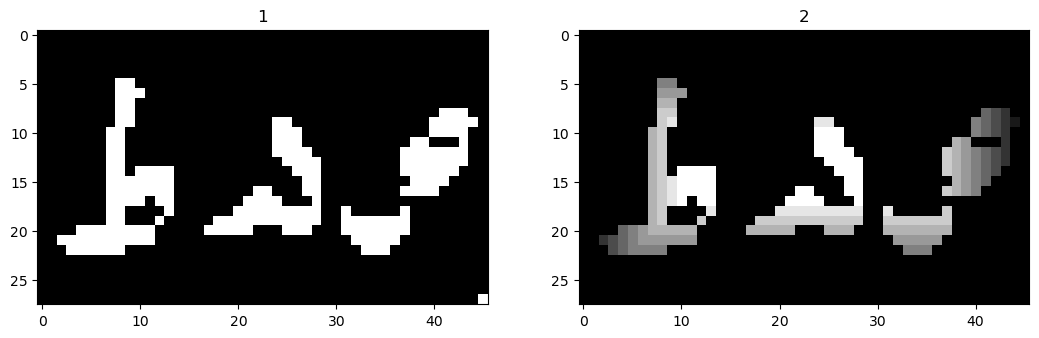

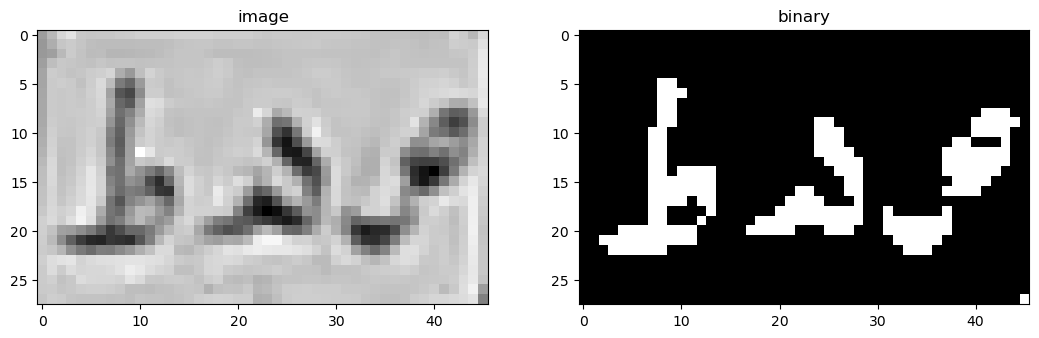

2 14
17 29
31 45


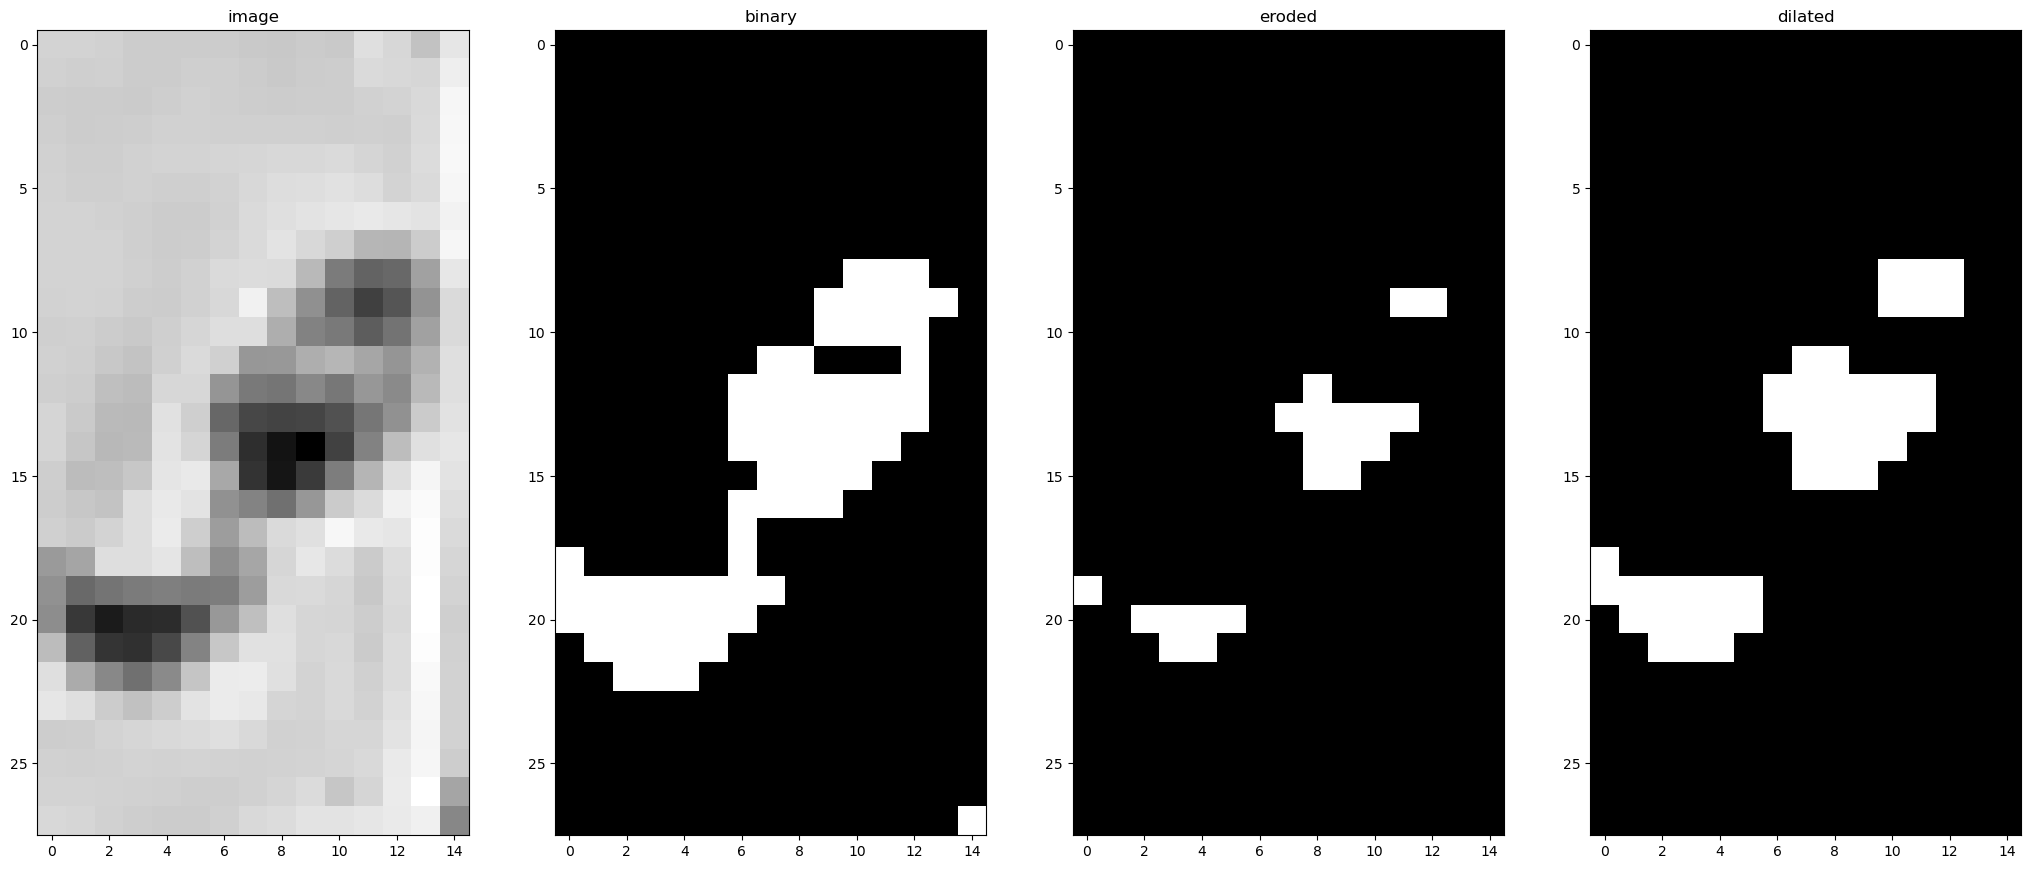

0 13
[(2, 14, array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False,  True,  True, False,
        False, False, False, False],
       [False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False],
       [False, False, False, False, False, False,  True,  True, False,
        False, False, False, False],
       [False, False, False, False, False, False,  True,  True, False,
        False, False, False, False],
       [False,

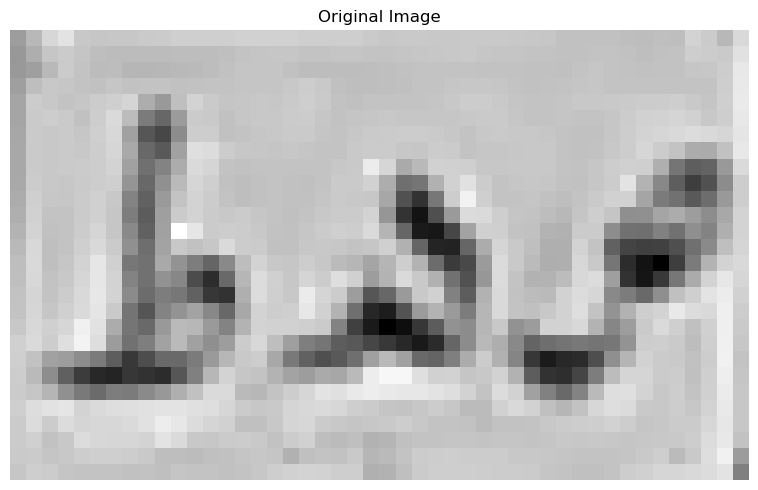

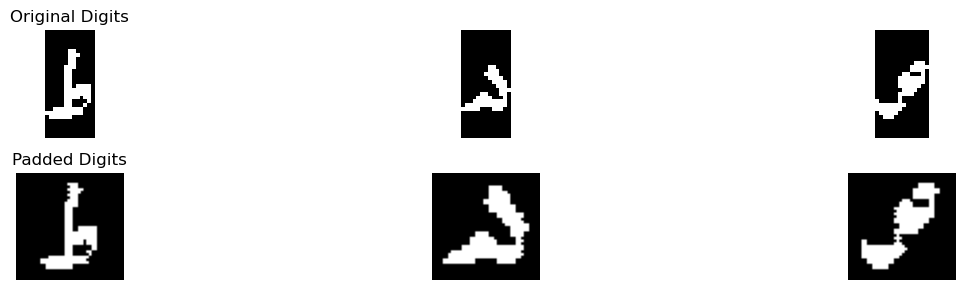

Best match: ط
Full comparison results: {'أ': 0.26785714285714285, 'ب': 0.0625, 'ج': 0.3546195652173913, 'د': 0.5198863636363636, 'ر': 0.4353448275862069, 'س': 0.21875, 'ص': 0.0625, 'ط': 1.28125, 'ع': 0.125, 'ف': 0.4525462962962963, 'ق': 0.5208333333333333, 'ك': 0.33333333333333337, 'ل': 0.31547619047619047, 'م': 0.07886904761904762, 'ن': 0.5520833333333333, 'ه': 0.15625, 'و': 0.4583333333333333, 'ي': 0.6105769230769231}
Confidence :  0.33533653846153844
Best match: ه
Full comparison results: {'أ': 0.0625, 'ب': 0.0, 'ج': 0.125, 'د': 0.5625, 'ر': 0.21875, 'س': 0.5395833333333333, 'ص': 0.4375, 'ط': 0.1875, 'ع': 0.09375, 'ف': 0.625, 'ق': 0.125, 'ك': 0.28125, 'ل': 0.0625, 'م': 0.28125, 'ن': 0.21875, 'ه': 1.5301724137931034, 'و': 0.46875, 'ي': 0.28125}
Confidence :  0.4525862068965517
Best match: ص
Full comparison results: {'أ': 0.06896551724137931, 'ب': 0.03125, 'ج': 0.1314655172413793, 'د': 0.2413793103448276, 'ر': 0.10344827586206896, 'س': 0.90625, 'ص': 1.28125, 'ط': 0.2413793103448276, '

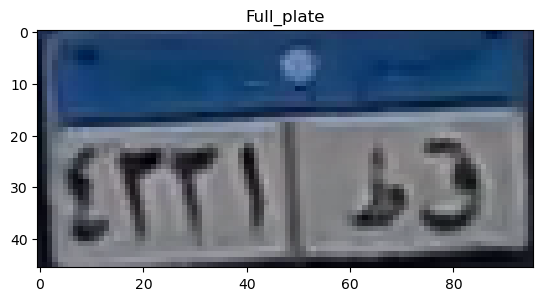

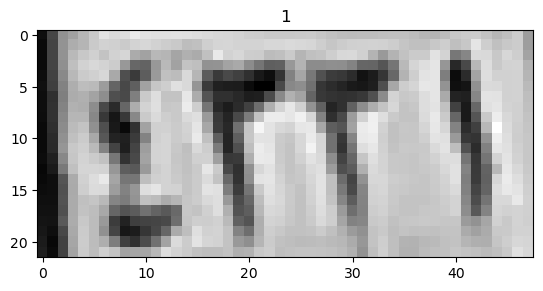

[0.03761647 0.02977333 0.02977333 0.02977333 0.03647765 0.04432078
 0.03872471 0.03872471 0.03731098 0.02946784 0.02804627 0.02804627
 0.03335176 0.02158706 0.02607412 0.03391725 0.04176039 0.04568196
 0.05549725 0.06334039 0.07146627 0.07930941]
[0.18271451 0.17879294 0.17879294 0.17879294 0.17373255 0.16588941
 0.12892078 0.13284235 0.13142863 0.12358549 0.11432078 0.11039922
 0.08433216 0.06864588 0.03783882 0.03783882 0.04176039 0.04568196
 0.05157569 0.03981098 0.02440745 0.03225059]
[0.37909059 0.38301216 0.3785251  0.37460353 0.3569451  0.33733725
 0.32949412 0.34125882 0.35495804 0.36280118 0.37706588 0.38883059
 0.35297098 0.31767686 0.22158706 0.21374392 0.21628157 0.20843843
 0.23588941 0.18883059 0.16922275 0.16922275]
After
[0.3569451  0.33733725 0.32949412 0.34125882 0.35495804 0.36280118
 0.37706588 0.38883059 0.35297098 0.31767686 0.22158706 0.21374392
 0.21628157 0.20843843 0.23588941 0.18883059 0.16922275 0.16922275]


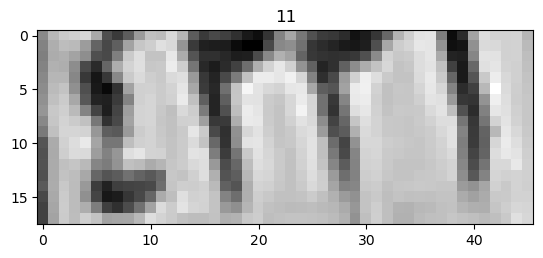

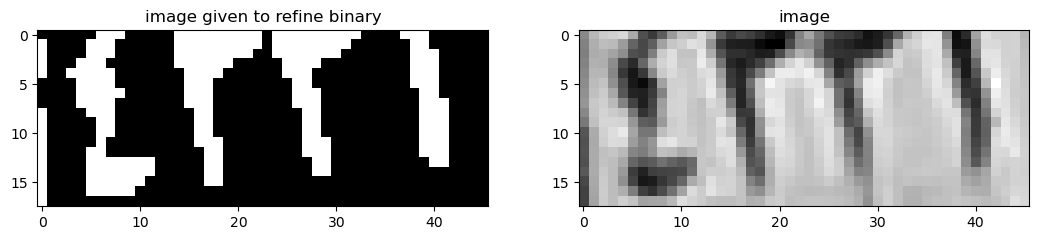

[False  True  True  True  True False False False  True  True  True  True
  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False]
[False False False False False False False False False False False False
 False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False]
1.0 46.0 0.0 24.0


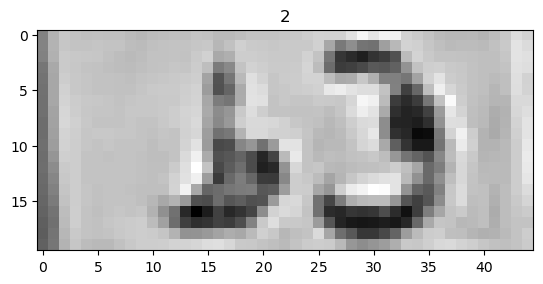

[0.35434    0.35826157 0.35041843 0.32688902 0.31904588 0.31512431
 0.31120275 0.31120275 0.30530902 0.30530902 0.30923059 0.30530902
 0.30784667 0.30000353 0.29608196 0.28823882 0.28039569 0.27255255
 0.26806549 0.27590863]
[0.4700149  0.4700149  0.46414392 0.44453608 0.44061451 0.44061451
 0.44061451 0.43277137 0.4288498  0.42492824 0.4170851  0.39747725
 0.37786941 0.36218314 0.35041843 0.33865373 0.31904588 0.31120275
 0.32130078 0.32522235]
[0.51707373 0.51315216 0.52296745 0.52296745 0.53081059 0.53865373
 0.54649686 0.55041843 0.55434    0.54649686 0.54257529 0.53473216
 0.52296745 0.51904588 0.51120275 0.50335961 0.4915949  0.48767333
 0.47816353 0.47032039]
After
[0.35434    0.35826157 0.35041843 0.32688902 0.31904588 0.31512431
 0.31120275 0.31120275 0.30530902 0.30530902 0.30923059 0.30530902
 0.30784667 0.30000353 0.29608196 0.28823882 0.28039569 0.27255255
 0.26806549 0.27590863]


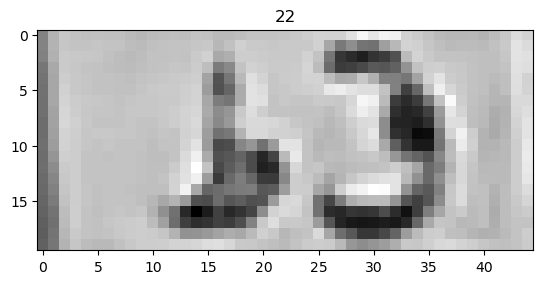

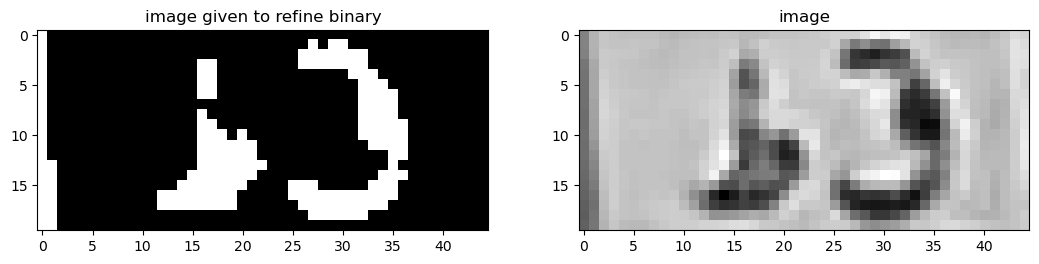

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False]
to horizonatal


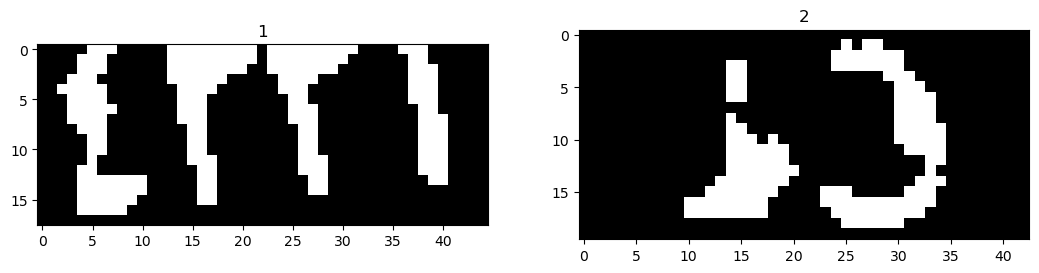

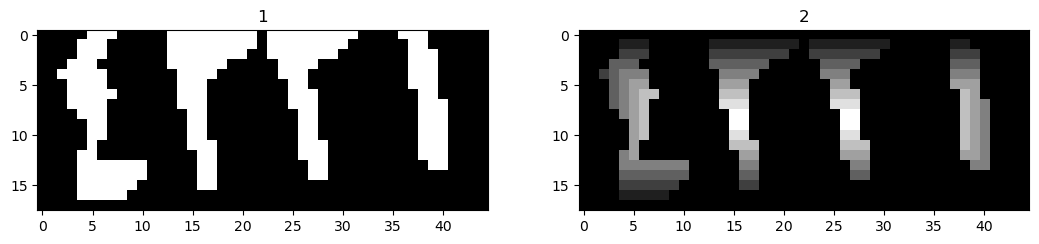

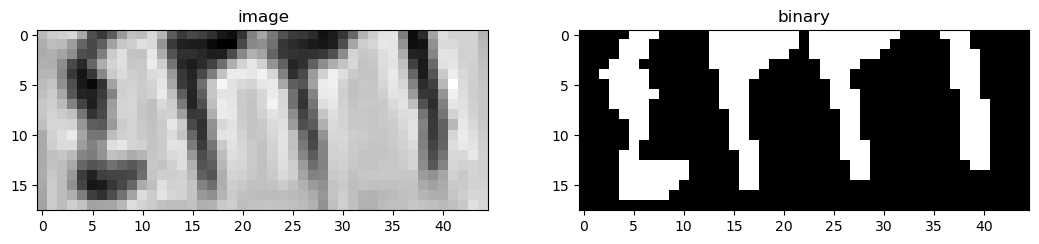

2 11
13 22
23 32
36 41
[(2, 11, array([[False, False, False,  True,  True,  True, False, False, False,
        False],
       [False, False,  True,  True,  True, False, False, False, False,
        False],
       [False, False,  True,  True,  True, False, False, False, False,
        False],
       [False,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False],
       [False,  True,  True,  True,  True, False, False, False, False,
        False],
       [False,  True,  True,  True,  True,  True, False, False, False,
        False],
       [False,  True,  True,  True,  True, False, False, False, False,
        False],
       [False, False,  True,  True,  True, False, False, False, False,
        False],
       [False, False, False,  True,  True, False, False, False, False,
        False],
       [False, False, False,  True,  True, False, False, False, False,
        False],
       [Fal

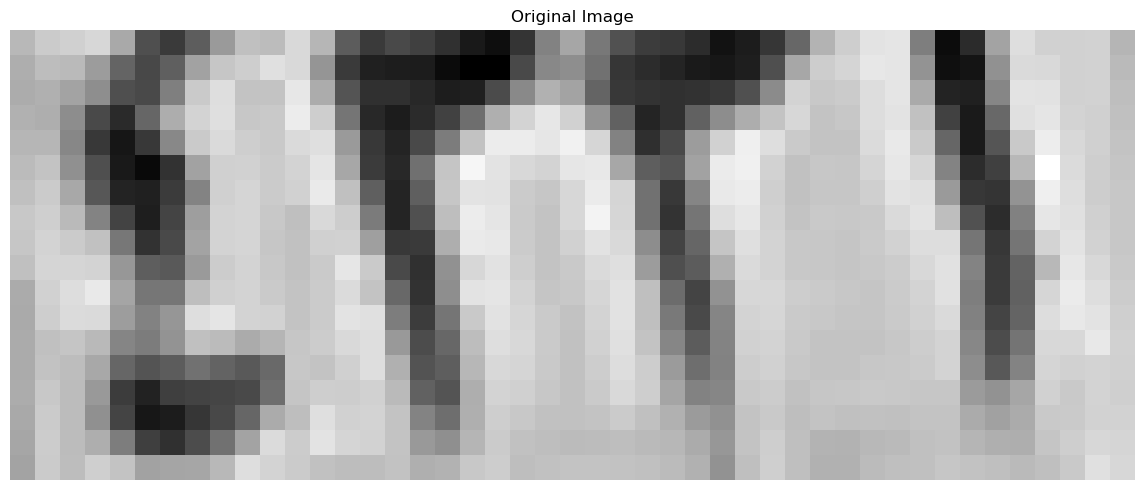

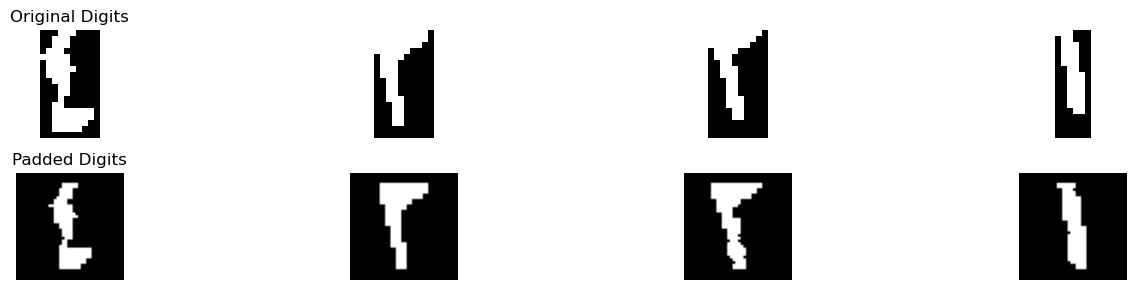

Best match: ٤
Full comparison results: {'١': 1.03125, '٢': 3.8125, '٣': 2.592202012383901, '٤': 5.4375, '٥': 2.2023302742149493, '٦': 0.175, '٧': 1.018014705882353, '٨': 1.5340277777777778, '٩': 1.922589869281046}
Confidence :  0.8125
Best match: ٣
Full comparison results: {'١': 0.1111111111111111, '٢': 3.701388888888889, '٣': 5.599597953216374, '٤': 2.565972222222222, '٥': 1.739609440267335, '٦': 1.2833333333333334, '٧': 2.4506944444444443, '٨': 0.36111111111111105, '٩': 1.0694444444444444}
Confidence :  0.9491045321637428
Best match: ٣
Full comparison results: {'١': 0.13651315789473684, '٢': 4.6644736842105265, '٣': 5.067434210526316, '٤': 2.666118421052632, '٥': 2.0205983709273183, '٦': 1.1559210526315788, '٧': 2.298026315789474, '٨': 0.6391447368421053, '٩': 1.207236842105263}
Confidence :  0.2014802631578947
Best match: ١
Full comparison results: {'١': 4.84375, '٢': 2.6908508158508155, '٣': 1.24796826625387, '٤': 1.6574175824175825, '٥': 1.3642930856553148, '٦': 0.8681547619047618

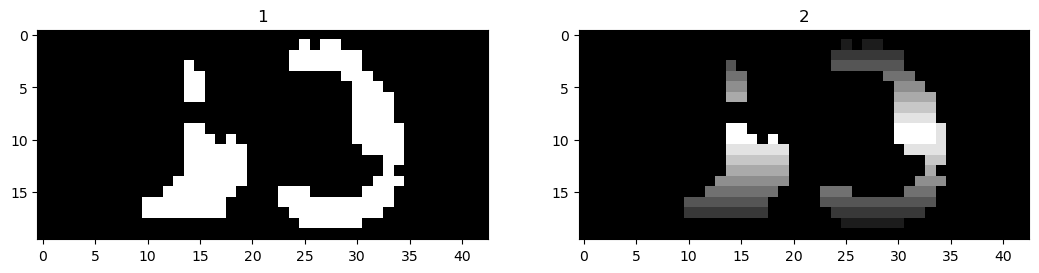

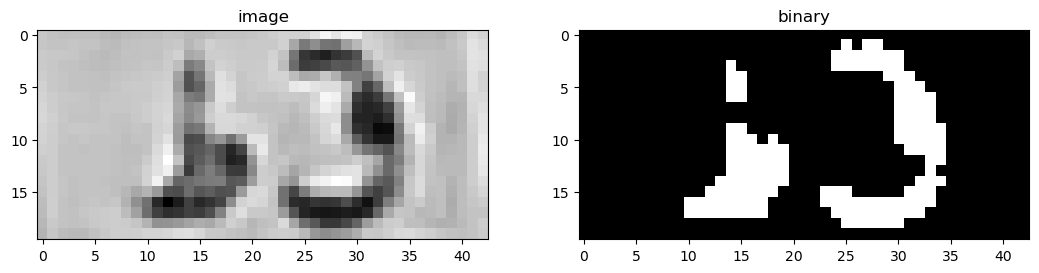

10 20
23 35
[(10, 20, array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False],
       [False, False, False, False,  T

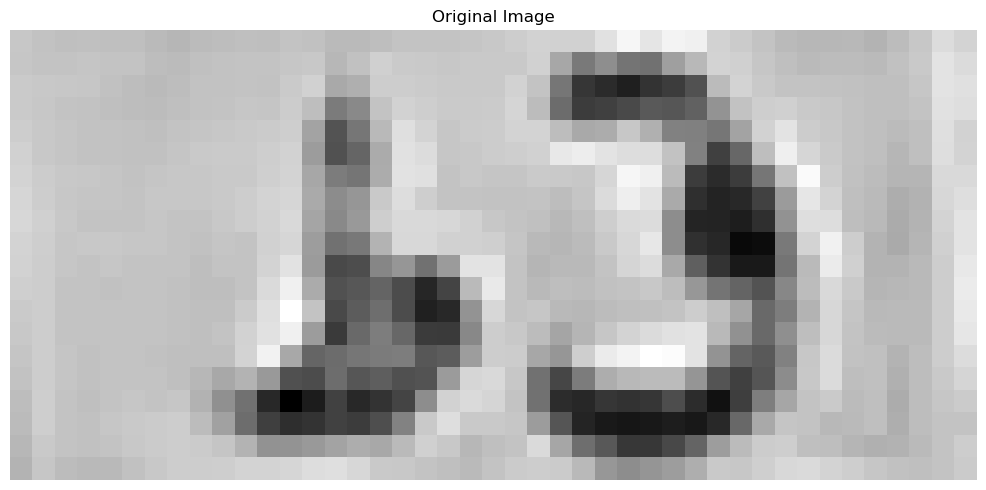

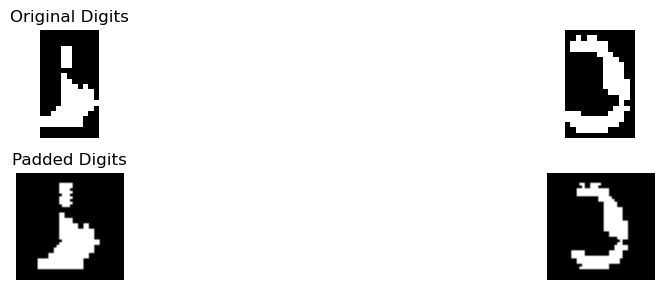

Best match: ط
Full comparison results: {'أ': 0.16168478260869565, 'ب': 0.09375, 'ج': 0.5788043478260869, 'د': 0.6847826086956521, 'ر': 0.4698275862068966, 'س': 0.15625, 'ص': 0.15625, 'ط': 0.90625, 'ع': 0.15625, 'ف': 0.7997685185185185, 'ق': 0.6032608695652174, 'ك': 0.4791666666666667, 'ل': 0.23641304347826086, 'م': 0.10597826086956522, 'ن': 0.39266304347826086, 'ه': 0.34375, 'و': 0.34375, 'ي': 0.65625}
Confidence :  0.053240740740740755
Best match: د
Full comparison results: {'أ': 0.0, 'ب': 0.0625, 'ج': 0.7717391304347826, 'د': 1.2840909090909092, 'ر': 0.4288793103448276, 'س': 0.25, 'ص': 0.15625, 'ط': 0.6145833333333333, 'ع': 0.4895833333333333, 'ف': 0.7800925925925926, 'ق': 1.2782738095238095, 'ك': 0.4895833333333333, 'ل': 0.6011904761904762, 'م': 0.09523809523809523, 'ن': 0.5848214285714286, 'ه': 0.375, 'و': 0.8333333333333334, 'ي': 0.9735576923076923}
Confidence :  0.0029085497835498186
[['٤', '٣', '٣', '١'], ['ط', 'د']]


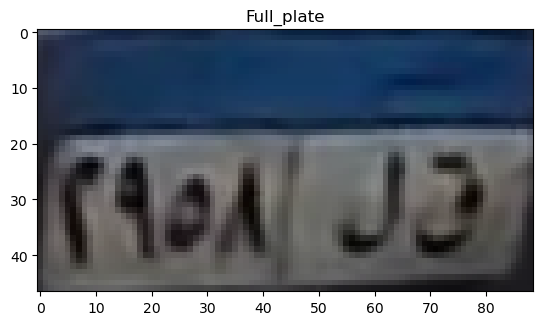

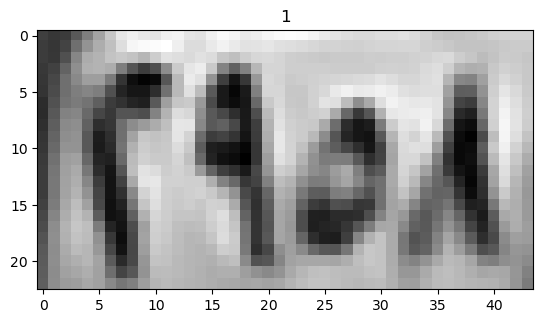

[0.14232235 0.13895137 0.13921922 0.13137608 0.12436627 0.12127804
 0.10559176 0.10138745 0.10894784 0.12071255 0.12518471 0.13302784
 0.1397549  0.1397549  0.1397549  0.14759804 0.15936275 0.17112745
 0.18400824 0.19857843 0.2025     0.2047549  0.20895922]
[0.12663608 0.12354784 0.12690392 0.14706235 0.15994314 0.16861961
 0.18010157 0.1955051  0.20810314 0.2195851  0.23078431 0.24647059
 0.25823529 0.26215686 0.26215686 0.27       0.28960784 0.30529412
 0.30921569 0.30529412 0.30809961 0.30334471 0.30671569]
[0.13449412 0.15073098 0.17928314 0.21904941 0.24312941 0.24312941
 0.25152314 0.28289569 0.30024863 0.30780902 0.31900824 0.33833333
 0.34645922 0.35009804 0.35485294 0.36158    0.37362745 0.38510941
 0.38118784 0.36942314 0.35963059 0.34703255 0.33471725]
After
[0.13449412 0.15073098 0.17928314 0.21904941 0.24312941 0.24312941
 0.25152314 0.28289569 0.30024863 0.30780902 0.31900824 0.33833333
 0.34645922 0.35009804 0.35485294 0.36158    0.37362745 0.38510941
 0.38118784 0.36942

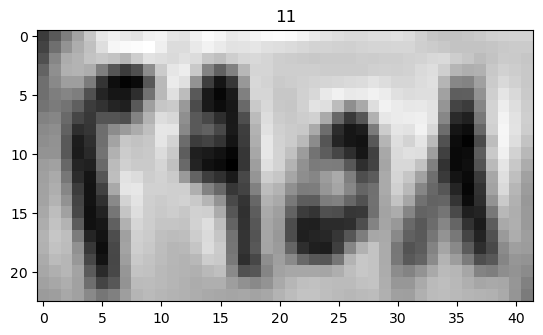

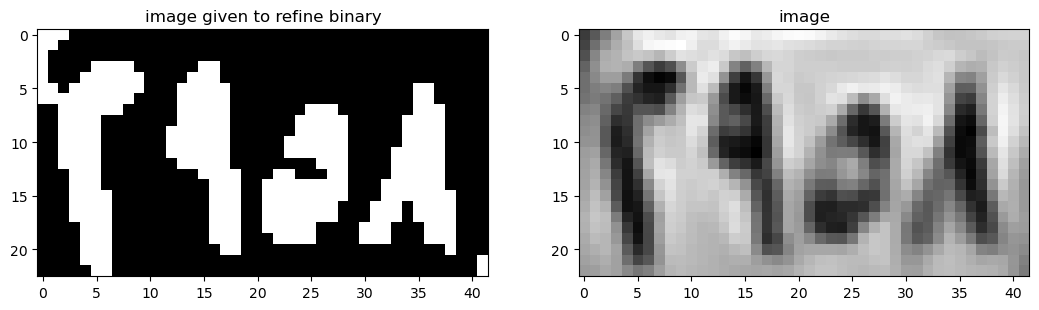

[ True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False]
[ True  True False False False  True  True False False False False False
 False False False False False False False False False False False]
[ True False False False False False  True  True  True  True  True  True
  True False False False False False False False False False False]
After
[ True False False False False False  True  True  True  True  True  True
  True False False False False False False False False False False]
0.0 44.0 2.0 26.0


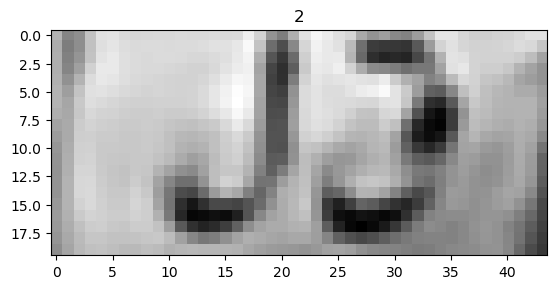

[0.37731882 0.36218314 0.36580706 0.36552431 0.36999647 0.37755686
 0.37699137 0.36522667 0.34450275 0.32909922 0.31761725 0.31286235
 0.30950627 0.31259451 0.31259451 0.32072039 0.32828078 0.32435922
 0.31651608 0.3008298 ]
[0.28320118 0.26806549 0.27589373 0.28317137 0.30725137 0.33441961
 0.34982314 0.35346196 0.35738353 0.35738353 0.36356    0.36776431
 0.37113529 0.37533961 0.37562235 0.37533961 0.37141804 0.3635749
 0.35573176 0.34788863]
[0.30252627 0.30196078 0.31482667 0.33807333 0.37783961 0.40892941
 0.42012863 0.41620706 0.42685569 0.43077725 0.43414824 0.43751922
 0.44452902 0.44928392 0.44956667 0.43808471 0.42239843 0.40279059
 0.39102588 0.38710431]
After
[0.37731882 0.36218314 0.36580706 0.36552431 0.36999647 0.37755686
 0.37699137 0.36522667 0.34450275 0.32909922 0.31761725 0.31286235
 0.30950627 0.31259451 0.31259451 0.32072039 0.32828078 0.32435922
 0.31651608 0.3008298 ]


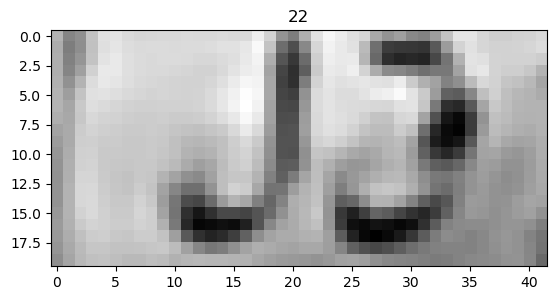

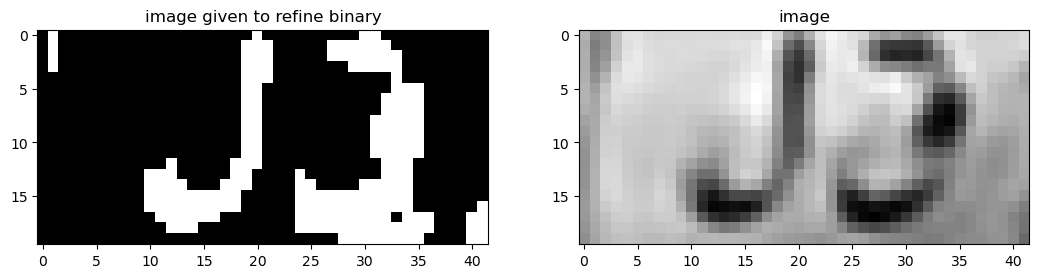

[False False False False False False False False False False False False
 False False False False False False False False]
[ True  True  True  True False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False]
to horizonatal


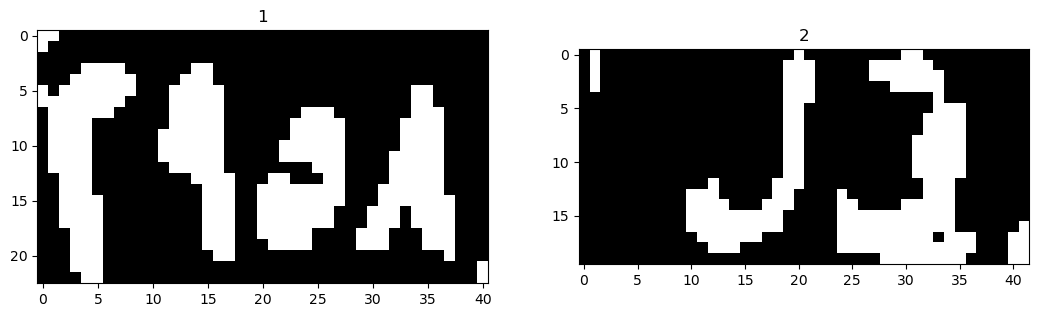

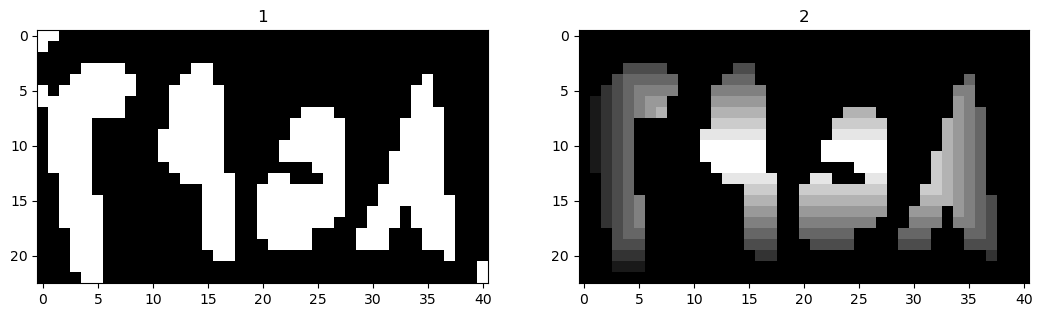

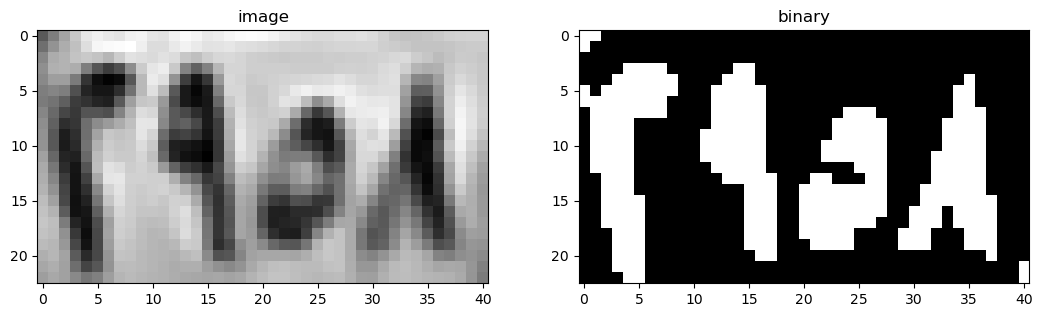

0 9
11 18
20 28
29 38
[(0, 9, array([[ True,  True, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
        False],
       [ True, False,  True,  True,  True,  True,  True,  True,  True,
        False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False],
       [False,  True,  True,  True,  True, False, False, False, False,
        False],
       [False,  True,  True,  True,  True, False, False, False, False,
        False],
       [False,  True,  True,  True,  True, False, False, False, False,
        False],
       [False

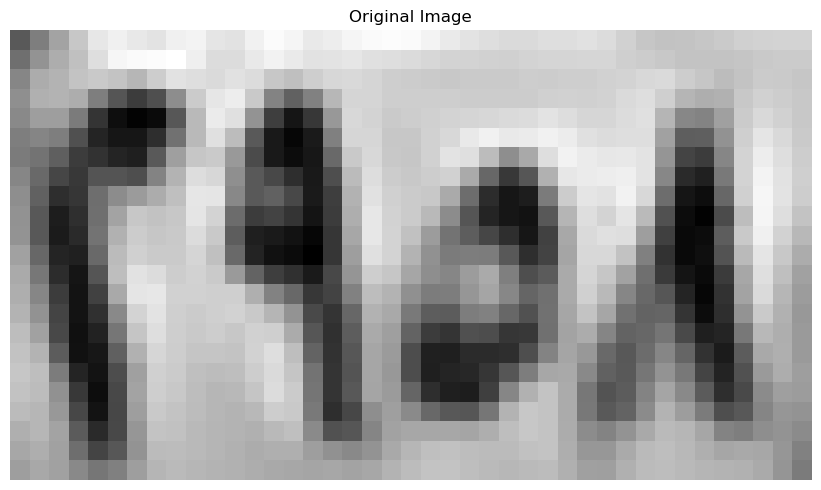

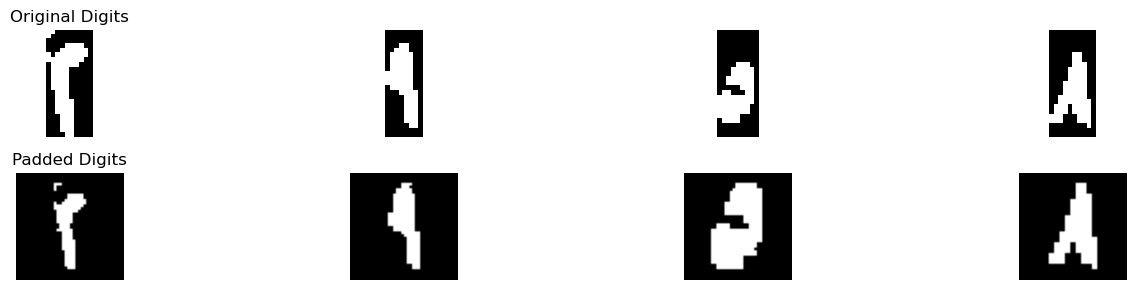

Best match: ٢
Full comparison results: {'١': 1.0416666666666667, '٢': 4.0048076923076925, '٣': 3.6760835913312695, '٤': 1.9218406593406594, '٥': 1.2530729397021967, '٦': 0.5633928571428571, '٧': 2.2308823529411765, '٨': 1.1472222222222221, '٩': 0.7223479135243842}
Confidence :  0.1643620504882115
Best match: ٩
Full comparison results: {'١': 3.2083333333333335, '٢': 2.362980769230769, '٣': 1.27921826625387, '٤': 2.2886446886446885, '٥': 1.7736022040395105, '٦': 1.8901785714285713, '٧': 0.7279411764705883, '٨': 3.1277777777777778, '٩': 4.113263574660634}
Confidence :  0.4524651206636501
Best match: ٥
Full comparison results: {'١': 0.5789473684210527, '٢': 1.5197368421052633, '٣': 1.394736842105263, '٤': 2.00328947368421, '٥': 6.977521929824562, '٦': 1.788486842105263, '٧': 1.0421052631578946, '٨': 1.4315789473684208, '٩': 0.4720394736842105}
Confidence :  2.4871162280701755
Best match: ٨
Full comparison results: {'١': 1.1666666666666667, '٢': 0.6666666666666667, '٣': 0.6608187134502923, 

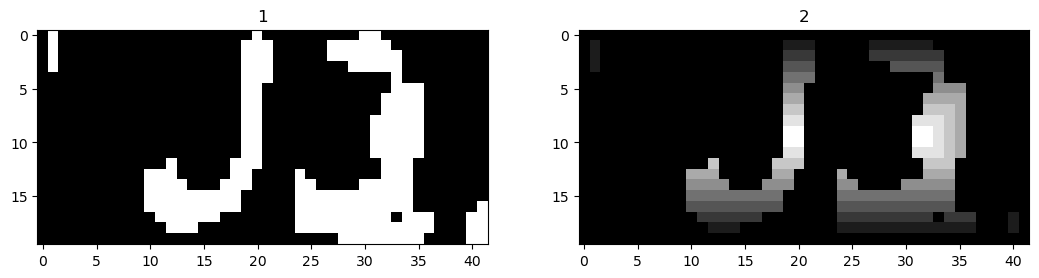

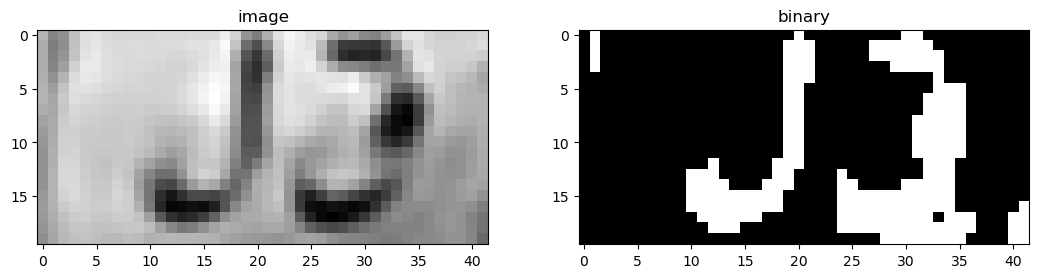

1 2
10 22
24 37


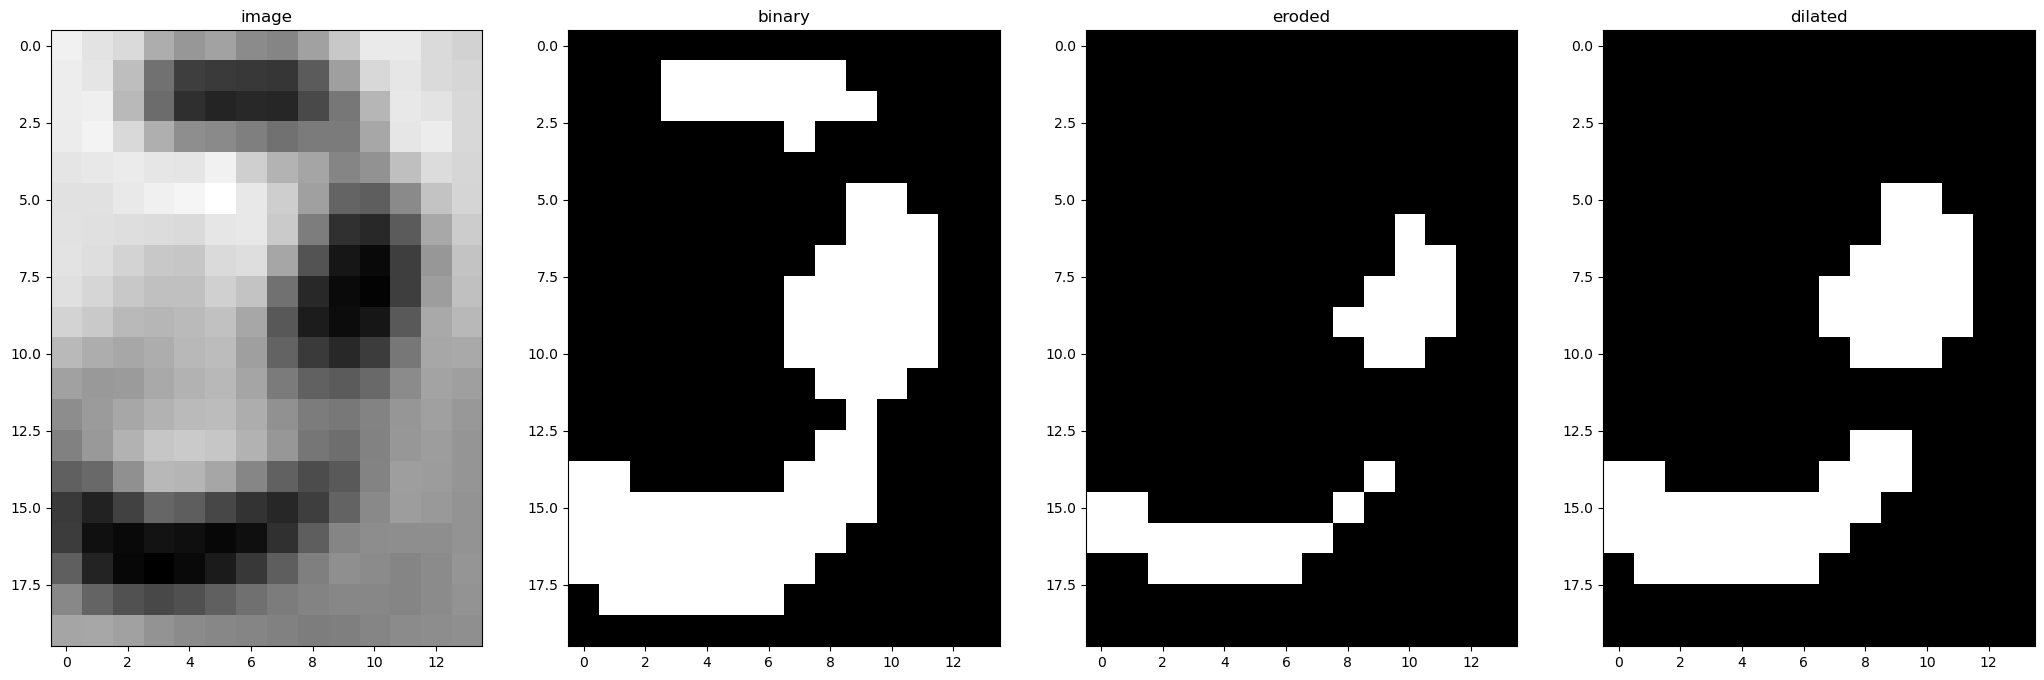

0 12
40 41
[(10, 22, array([[False, False, False, False, False, False, False, False, False,
        False,  True, False, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True,  True, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True,  True, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True,  True, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True,  True, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True, False, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True, False, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True, False, False],
       [False, False, False, False, False, False, False, False, False,
         True,  True, False, False],
       

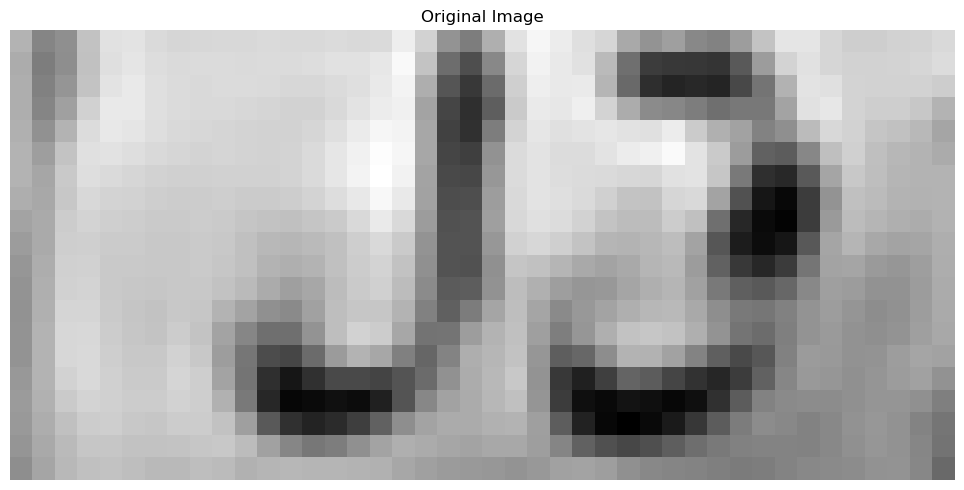

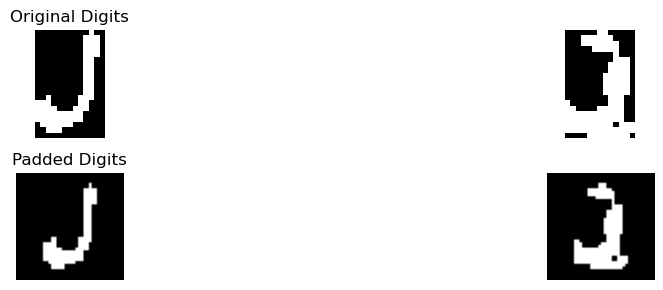

Best match: ل
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.21195652173913043, 'د': 0.5198863636363636, 'ر': 0.4698275862068966, 'س': 0.4375, 'ص': 0.34375, 'ط': 0.27083333333333337, 'ع': 0.1125, 'ف': 0.29050925925925924, 'ق': 0.44375, 'ك': 0.25, 'ل': 0.975, 'م': 0.0, 'ن': 0.50625, 'ه': 0.25, 'و': 0.5208333333333333, 'ي': 0.65625}
Confidence :  0.159375
Best match: د
Full comparison results: {'أ': 0.13125, 'ب': 0.0, 'ج': 0.6345108695652174, 'د': 1.0568181818181817, 'ر': 0.3006465517241379, 'س': 0.40625, 'ص': 0.1875, 'ط': 0.4375, 'ع': 0.45625, 'ف': 0.8113425925925926, 'ق': 0.94375, 'ك': 0.26041666666666663, 'ل': 0.3625, 'م': 0.14375, 'ن': 0.81875, 'ه': 0.5, 'و': 0.5833333333333333, 'ي': 0.47115384615384615}
Confidence :  0.05653409090909084
[['٢', '٩', '٥', '٨'], ['ل', 'د']]


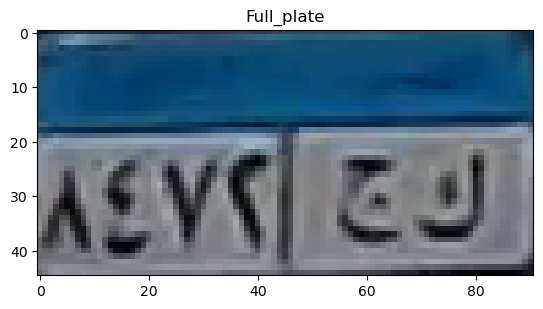

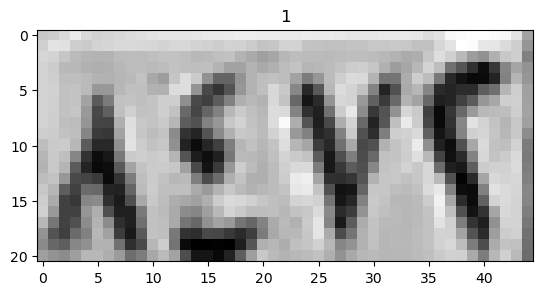

[0.53715176 0.56201255 0.57769882 0.57232588 0.56840431 0.57314431
 0.57314431 0.57254118 0.57254118 0.5568549  0.51371765 0.48962275
 0.48570118 0.50728118 0.53865373 0.55434    0.56218314 0.49551647
 0.39747725 0.37451333 0.42941529]
[0.55283804 0.61299294 0.56985569 0.55271804 0.55663961 0.56530118
 0.56137961 0.56077647 0.56077647 0.55293333 0.5450902  0.54452471
 0.54452471 0.53081059 0.4915949  0.46414392 0.41316353 0.31904588
 0.22492824 0.28039569 0.40196431]
[0.58703098 0.60880353 0.53429373 0.50090431 0.51266902 0.52159843
 0.52159843 0.52353294 0.5156898  0.52491686 0.54844627 0.51707373
 0.48962275 0.40924196 0.25630078 0.17786941 0.18179098 0.18012431
 0.17228118 0.25519961 0.3806898 ]
After
[0.53715176 0.56201255 0.57769882 0.57232588 0.56840431 0.57314431
 0.57314431 0.57254118 0.57254118 0.5568549  0.51371765 0.48962275
 0.48570118 0.50728118 0.53865373 0.55434    0.56218314 0.49551647
 0.39747725 0.37451333 0.42941529]


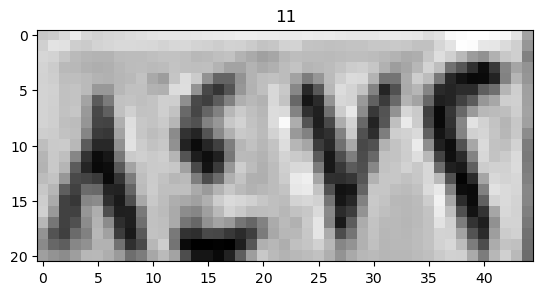

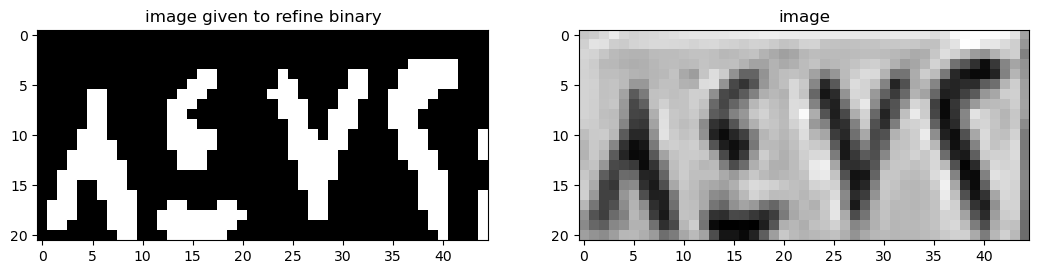

[False False False False False False False False False False False False
 False False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False  True  True  True False]
[False False False False False False False False False False False False
 False False  True  True  True  True  True  True False]
After
[False False False False False False False False False False False False
 False False False False False False False False False]
1.0 45.0 0.0 24.0


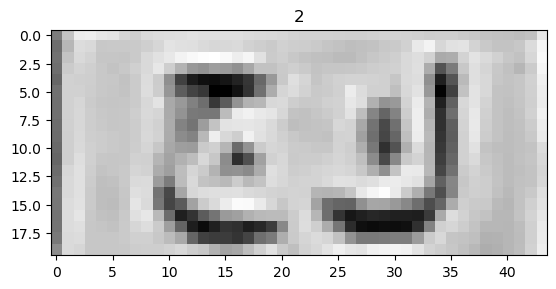

[0.31241608 0.27404941 0.28581412 0.27677961 0.26109333 0.28600667
 0.2820851  0.2820851  0.27424196 0.27284314 0.265      0.25715686
 0.27284314 0.28600667 0.30169294 0.30030902 0.28854431 0.29217529
 0.30786157 0.35099882]
[0.49280824 0.45836314 0.48973569 0.50815216 0.52383843 0.52522235
 0.52522235 0.52522235 0.52130078 0.51990196 0.51990196 0.51990196
 0.5395098  0.5448302  0.5448302  0.55128941 0.55128941 0.55099882
 0.54707725 0.54707725]
[0.59193373 0.55134196 0.54349882 0.53168157 0.51991686 0.52522235
 0.53698706 0.53865373 0.53865373 0.54117647 0.54509804 0.55686275
 0.56078431 0.56218314 0.56218314 0.56500353 0.57284667 0.55884196
 0.55099882 0.53531255]
After
[0.31241608 0.27404941 0.28581412 0.27677961 0.26109333 0.28600667
 0.2820851  0.2820851  0.27424196 0.27284314 0.265      0.25715686
 0.27284314 0.28600667 0.30169294 0.30030902 0.28854431 0.29217529
 0.30786157 0.35099882]


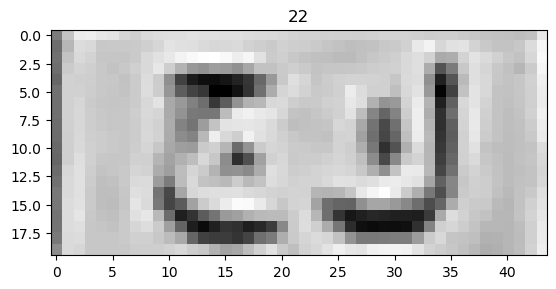

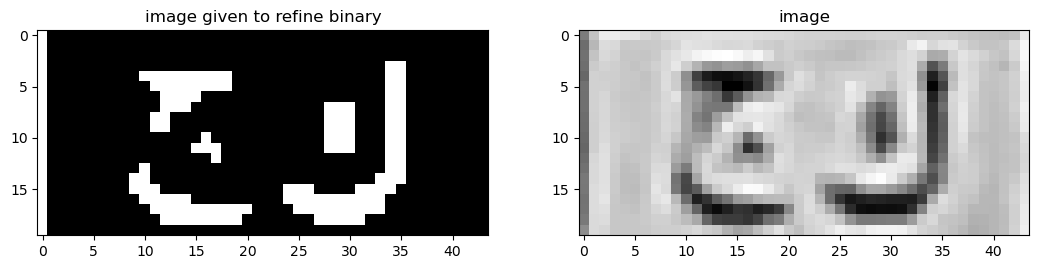

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False]
to horizonatal


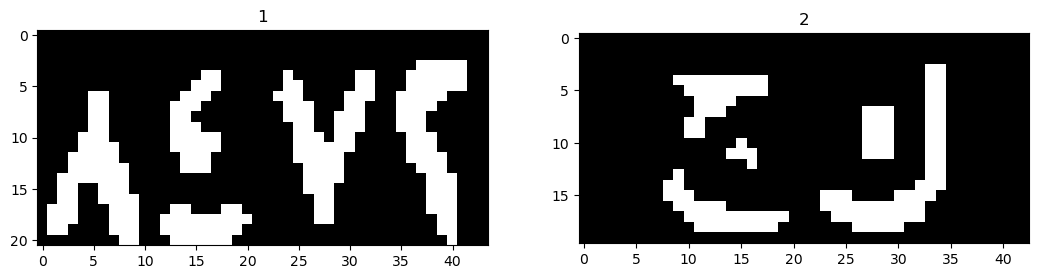

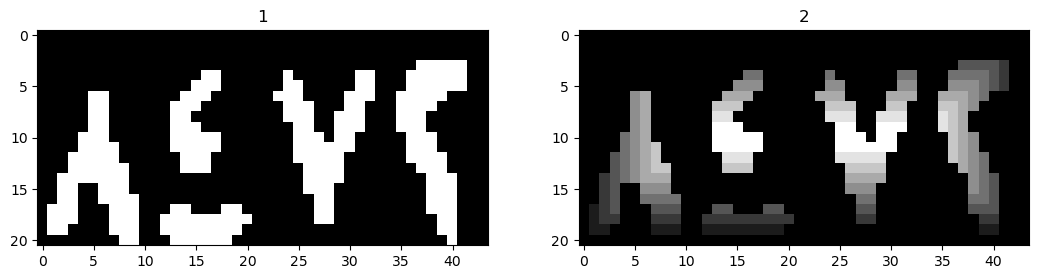

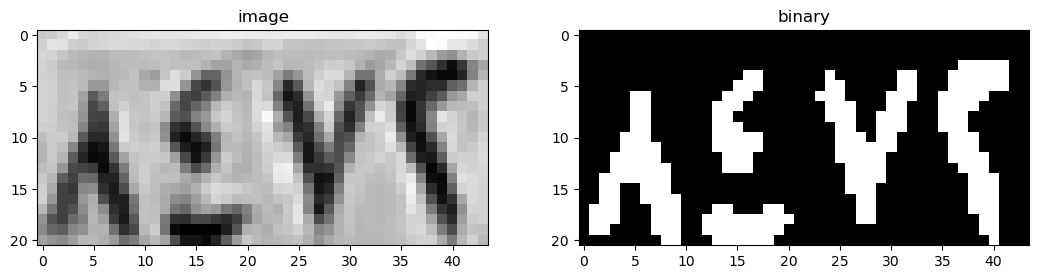

1 10
12 21
23 33
35 42
[(1, 10, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False,  True,  True, False, False, False,
        False],
       [False, False, False, False,  True,  True, False, False, False,
        False],
       [False, False, False, False,  True,  True, False, False, False,
        False],
       [False, False, False, False,  True,  True, False, False, False,
        False],
       [False, False, False,  True,  True,  True, False, False, False,
        False],
       [Fal

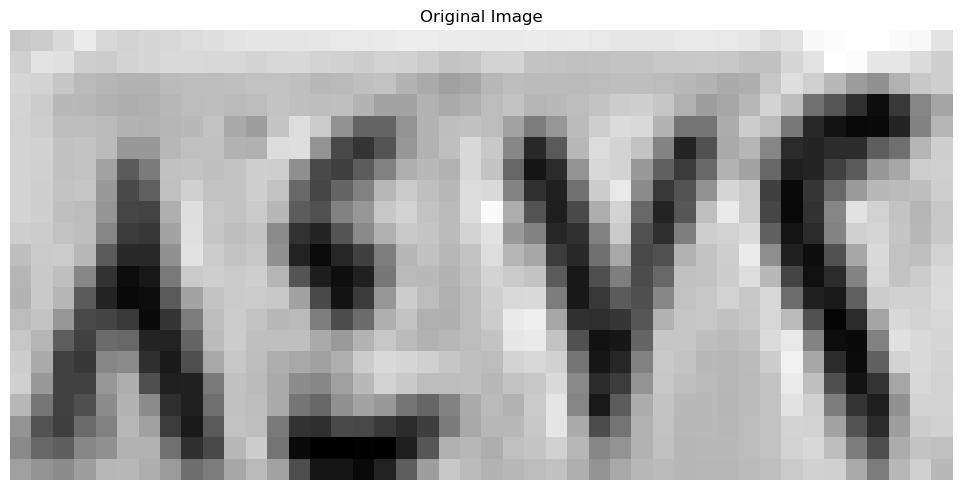

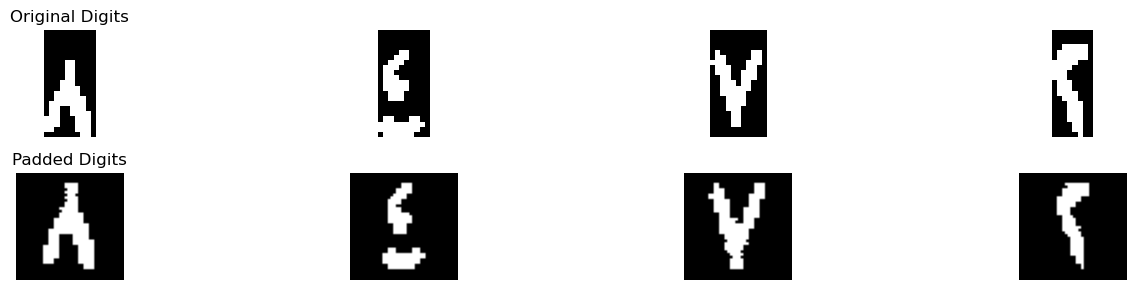

Best match: ٨
Full comparison results: {'١': 2.067434210526316, '٢': 1.0411184210526316, '٣': 0.7894736842105263, '٤': 0.850328947368421, '٥': 2.5090068922305764, '٦': 1.1332236842105263, '٧': 0.7200657894736842, '٨': 6.389802631578947, '٩': 3.106907894736842}
Confidence :  1.6414473684210524
Best match: ٤
Full comparison results: {'١': 1.15625, '٢': 3.28125, '٣': 1.6057469040247678, '٤': 5.894287634408602, '٥': 3.4248488869231903, '٦': 0.0, '٧': 0.6889705882352941, '٨': 1.7597222222222222, '٩': 2.179330065359477}
Confidence :  1.234719373742706
Best match: ٧
Full comparison results: {'١': 0.47619047619047616, '٢': 1.7127976190476188, '٣': 1.7142857142857142, '٤': 1.5223214285714284, '٥': 1.7544642857142856, '٦': 0.7931547619047619, '٧': 4.544642857142858, '٨': 0.9330357142857142, '٩': 1.3586309523809523}
Confidence :  1.395089285714286
Best match: ٢
Full comparison results: {'١': 2.854166666666667, '٢': 6.100961538461538, '٣': 3.0724651702786376, '٤': 2.1770375457875457, '٥': 2.219399

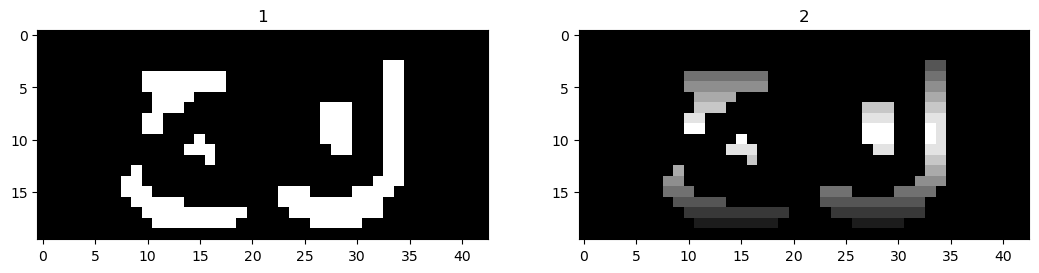

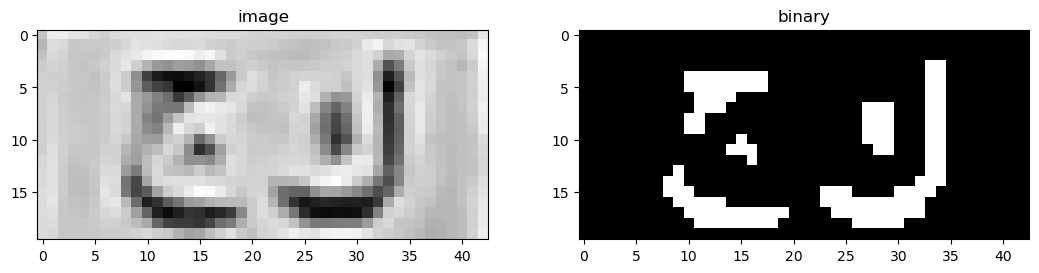

8 20
23 35
[(8, 20, array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False],
       [False, False, False,  True,  True,  True,  True, False, False,
        False, False, False, False],
       [False, False, False,  True,  True,  True, False, False, False,
        False, False, False, False],
       [False, False,  True,  True, False, False, False, False, False,
        False, False, False, False],
       [

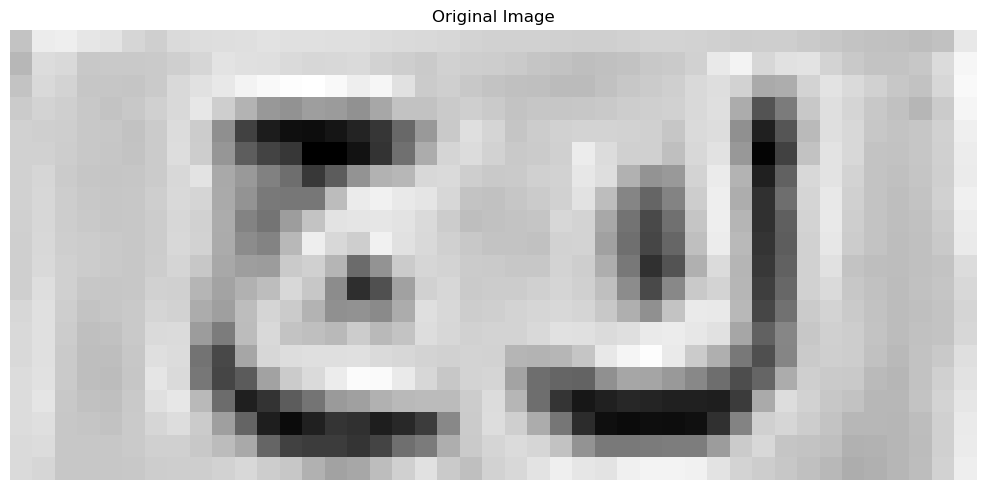

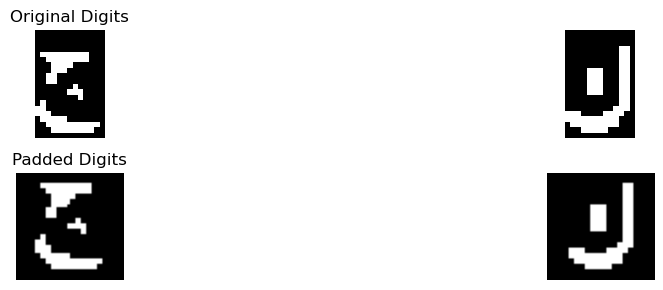

Best match: ج
Full comparison results: {'أ': 0.0, 'ب': 0.125, 'ج': 1.18875, 'د': 0.445, 'ر': 0.09375, 'س': 0.09375, 'ص': 0.1875, 'ط': 0.21375, 'ع': 0.45375, 'ف': 0.47800925925925924, 'ق': 0.4225, 'ك': 0.33375, 'ل': 0.0, 'م': 0.23125, 'ن': 0.37375, 'ه': 0.0, 'و': 0.10250000000000001, 'ي': 0.1466346153846154}
Confidence :  0.35537037037037034
Best match: ك
Full comparison results: {'أ': 0.041666666666666664, 'ب': 0.09375, 'ج': 0.32291666666666663, 'د': 0.7083333333333333, 'ر': 0.9202586206896552, 'س': 0.28125, 'ص': 0.40625, 'ط': 0.7708333333333334, 'ع': 0.53125, 'ف': 0.5636574074074074, 'ق': 0.29166666666666663, 'ك': 1.2604166666666665, 'ل': 0.3854166666666667, 'م': 0.041666666666666664, 'ن': 0.65625, 'ه': 0.375, 'و': 0.7083333333333333, 'ي': 0.7043269230769231}
Confidence :  0.17007902298850563
[['٨', '٤', '٧', '٢'], ['ج', 'ك']]


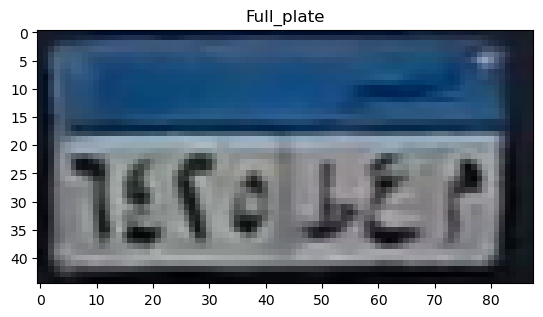

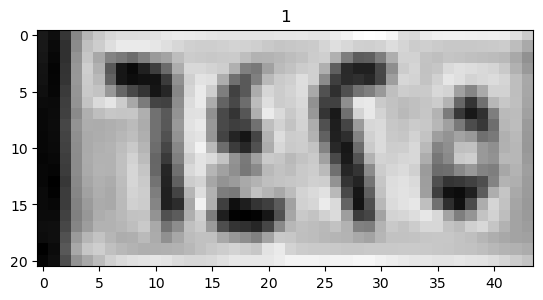

[0.09221294 0.08829137 0.08294824 0.0751051  0.07118353 0.06334039
 0.05295961 0.04511647 0.04511647 0.0411949  0.0411949  0.03727333
 0.0411949  0.0411949  0.04903804 0.04903804 0.05295961 0.06080275
 0.05688118 0.02158706 0.03532392]
[0.06112314 0.04935843 0.04178314 0.03505608 0.03588941 0.03981098
 0.04903804 0.05295961 0.05688118 0.05295961 0.04903804 0.04511647
 0.03727333 0.02158706 0.0294302  0.0411949  0.05295961 0.06472431
 0.06472431 0.05295961 0.06249216]
[0.17149255 0.15580627 0.15859686 0.16251843 0.16922275 0.18098745
 0.19413608 0.19805765 0.21374392 0.20590078 0.20197922 0.19413608
 0.18629294 0.17452824 0.18629294 0.18629294 0.20197922 0.21766549
 0.24511647 0.26472431 0.23364235]
After
[0.16922275 0.18098745 0.19413608 0.19805765 0.21374392 0.20590078
 0.20197922 0.19413608 0.18629294 0.17452824 0.18629294 0.18629294
 0.20197922 0.21766549 0.24511647 0.26472431 0.23364235]


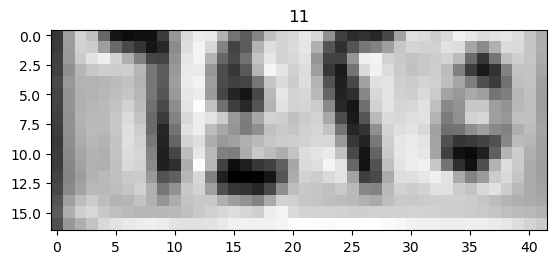

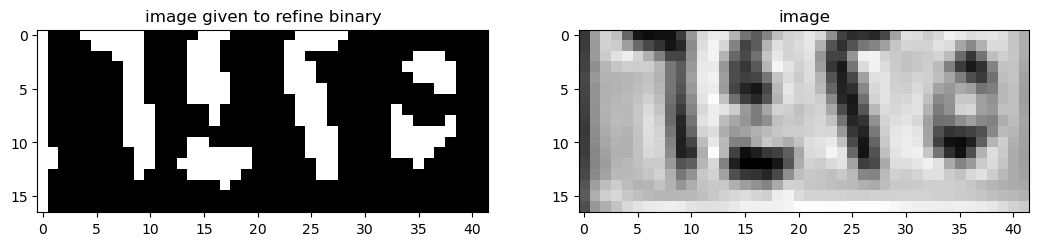

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[False False False False False False False False False False False  True
  True False False False False]
[False False False False False False False False False False False False
 False False False False False]
After
[False False False False False False False False False False False False
 False False False False False]


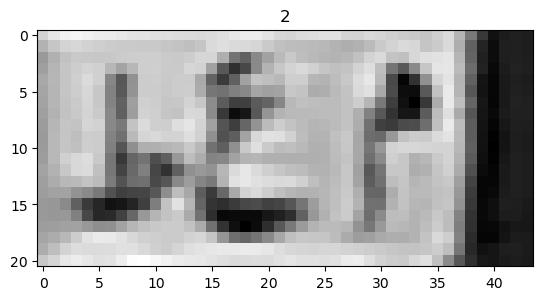

[0.58888314 0.50260863 0.43502627 0.45071255 0.47589373 0.46805059
 0.46414392 0.45237922 0.44286941 0.43894784 0.43951333 0.44735647
 0.46304275 0.45127804 0.44735647 0.43559176 0.43559176 0.44735647
 0.46696431 0.49049373 0.55913255]
[0.63986353 0.55779333 0.49805412 0.50981882 0.51427608 0.51063725
 0.51148549 0.50364235 0.51457373 0.51849529 0.51877804 0.51877804
 0.50309176 0.48657216 0.46052    0.42886471 0.42914745 0.44763922
 0.48768824 0.53391373 0.59834824]
[0.67572314 0.5933702  0.54539569 0.55323882 0.55294118 0.55294118
 0.55098392 0.54706235 0.55490549 0.55490549 0.55490549 0.58235647
 0.55882706 0.51961137 0.46472431 0.39413608 0.43335176 0.45688118
 0.51962627 0.59413608 0.64540706]
After
[0.58888314 0.50260863 0.43502627 0.45071255 0.47589373 0.46805059
 0.46414392 0.45237922 0.44286941 0.43894784 0.43951333 0.44735647
 0.46304275 0.45127804 0.44735647 0.43559176 0.43559176]


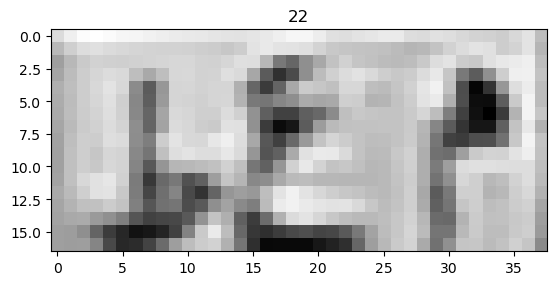

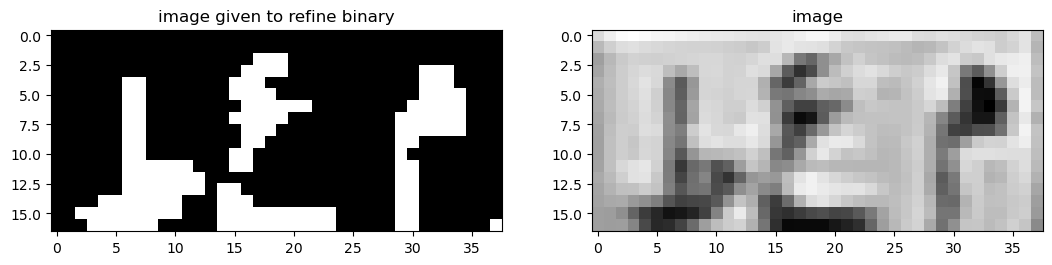

[False False False False False False False False False False False False
 False False False False False]
[False False False False False False False False False False False False
 False False False False False]
[False False False False False False False False False False False False
 False False False  True False]
After
[False False False False False False False False False False False False
 False False False False False]
to horizonatal


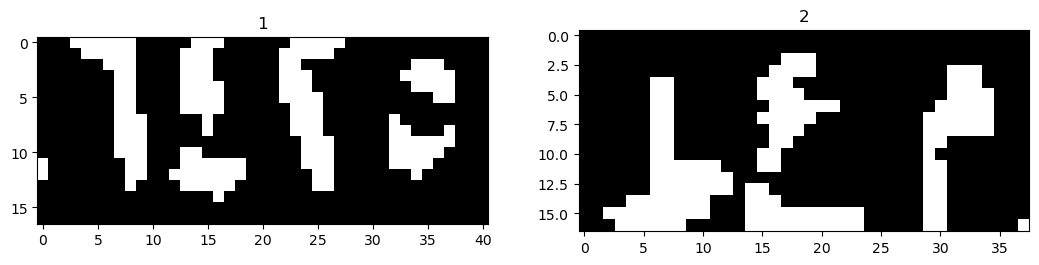

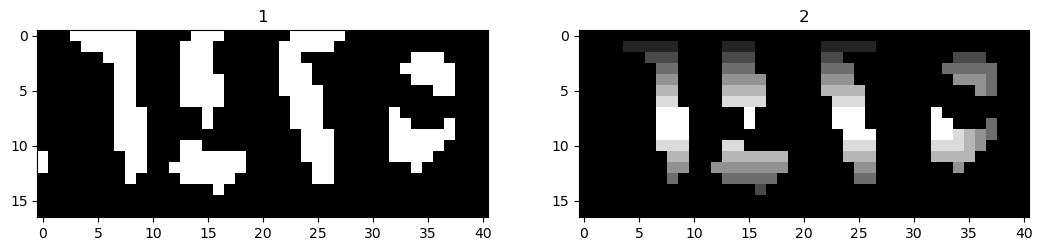

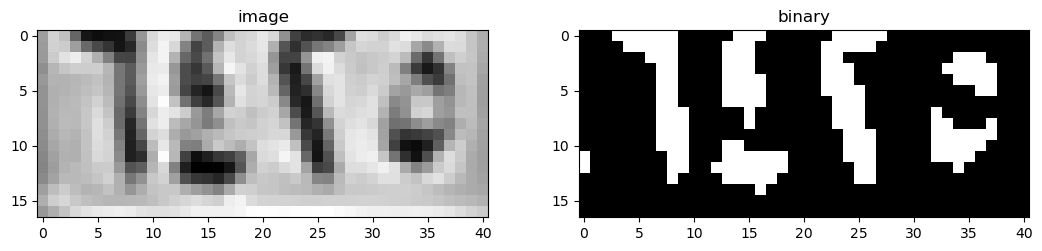

0 1
3 10
12 19
22 28
32 38
[(3, 10, array([[ True,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False,  True,  True,  True, False],
       [False, False, False, False,  True,  True,  True, False],
       [False, False, False, False,  True,  True,  True, False],
       [False, False, False, False,  True,  True,  True, False],
       [False, False, False, False, False,  True,  True, False],
       [False, False, False, False, False,  True,  True, False],
       [False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False, Fals

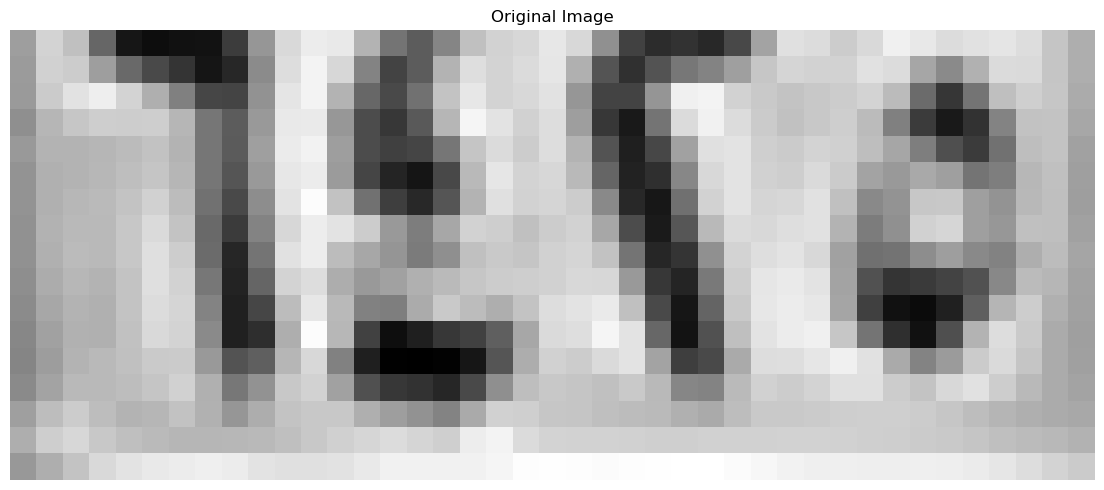

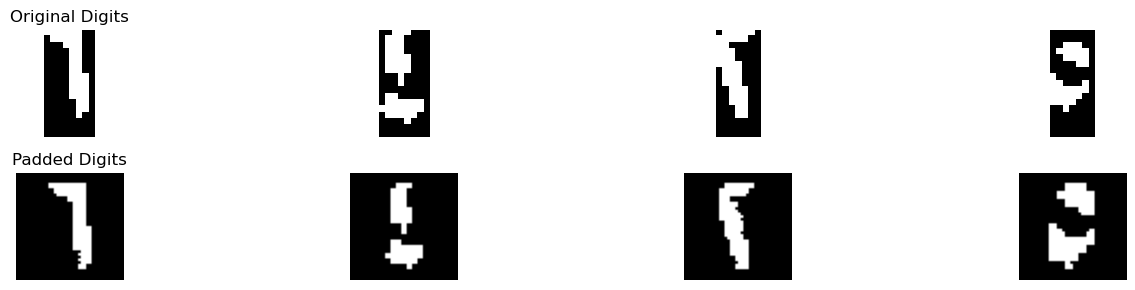

Best match: ٦
Full comparison results: {'١': 0.875, '٢': 0.53125, '٣': 0.5728521671826625, '٤': 0.0, '٥': 2.014678239716939, '٦': 5.15625, '٧': 0.11764705882352941, '٨': 1.2576388888888888, '٩': 1.8602941176470589}
Confidence :  1.5707858801415304
Best match: ٤
Full comparison results: {'١': 3.0446428571428568, '٢': 2.4955357142857144, '٣': 1.6896284829721362, '٤': 4.1761904761904765, '٥': 3.1995982603567743, '٦': 0.41488095238095235, '٧': 0.6941176470588235, '٨': 2.438888888888889, '٩': 2.5130427170868344}
Confidence :  0.4882961079168511
Best match: ٢
Full comparison results: {'١': 1.2620192307692308, '٢': 5.317307692307692, '٣': 2.8187886996904026, '٤': 3.7057234432234427, '٥': 1.7818996019460416, '٦': 0.9482142857142857, '٧': 2.6058823529411765, '٨': 0.8493055555555555, '٩': 1.8455253896430366}
Confidence :  0.8057921245421245
Best match: ٥
Full comparison results: {'١': 0.058823529411764705, '٢': 1.8952205882352944, '٣': 1.6877902476780187, '٤': 1.167279411764706, '٥': 6.162589377

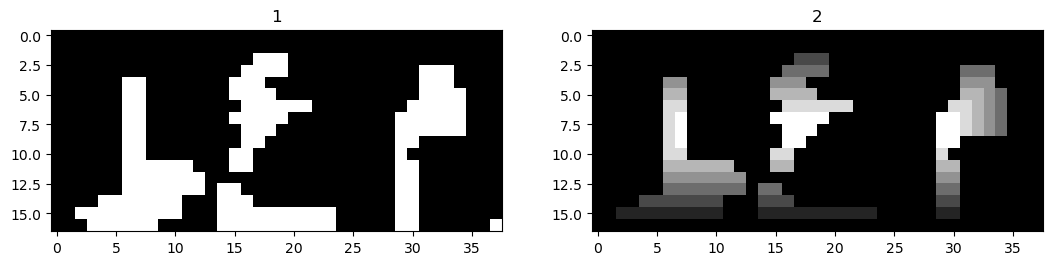

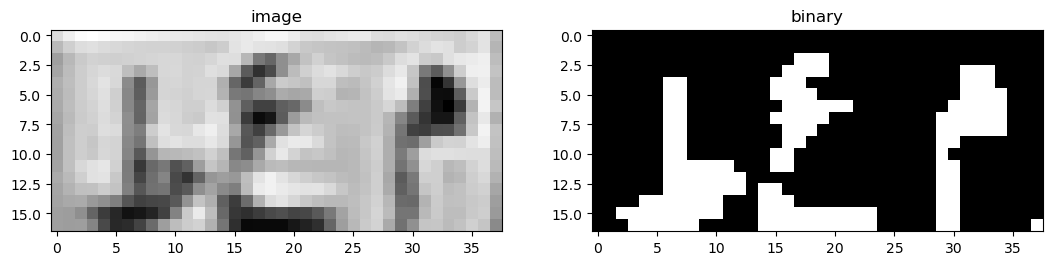

2 13
14 24
29 35
[(2, 13, array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False, False],
       [False, False, False, False,  True,  True, False, False, False,
        False, False, False],
       [False, False, False, False,  True,  True, False, False, F

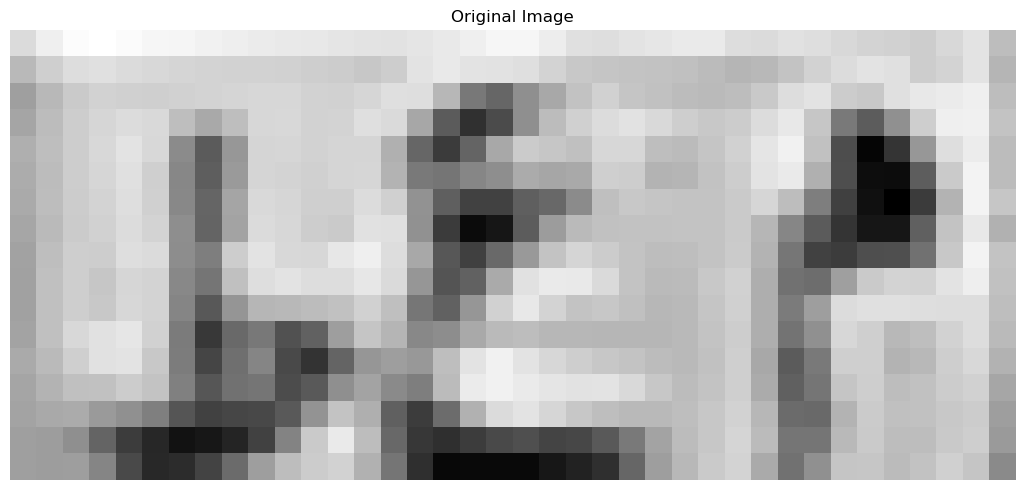

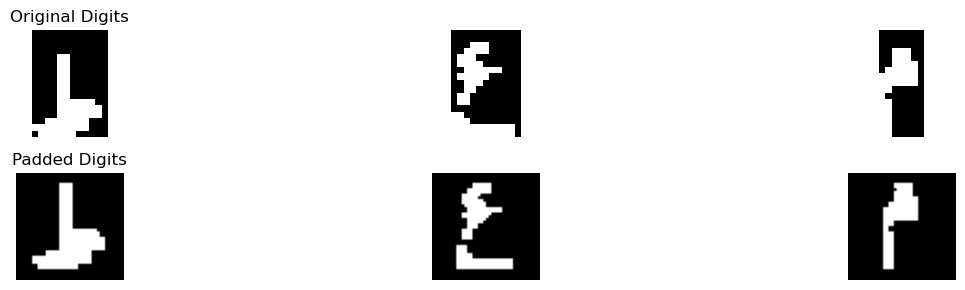

Best match: ط
Full comparison results: {'أ': 0.1111111111111111, 'ب': 0.0625, 'ج': 0.4837962962962963, 'د': 0.5833333333333333, 'ر': 0.5075431034482758, 'س': 0.25, 'ص': 0.09375, 'ط': 0.9849537037037037, 'ع': 0.1875, 'ف': 0.9305555555555556, 'ق': 0.43287037037037035, 'ك': 0.44675925925925924, 'ل': 0.1111111111111111, 'م': 0.09953703703703703, 'ن': 0.4039351851851852, 'ه': 0.65625, 'و': 0.13657407407407407, 'ي': 0.7118055555555556}
Confidence :  0.02719907407407407
Best match: ع
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.5665760869565217, 'د': 0.5198863636363636, 'ر': 0.12823275862068967, 'س': 0.0625, 'ص': 0.0625, 'ط': 0.21875, 'ع': 1.1532738095238095, 'ف': 0.41550925925925924, 'ق': 0.14136904761904762, 'ك': 0.5104166666666667, 'ل': 0.0, 'م': 0.4419642857142857, 'ن': 0.4270833333333333, 'ه': 0.0625, 'و': 0.10416666666666666, 'ي': 0.13942307692307693}
Confidence :  0.2933488612836439
Best match: م
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.043478260869565216, 'د': 0.51

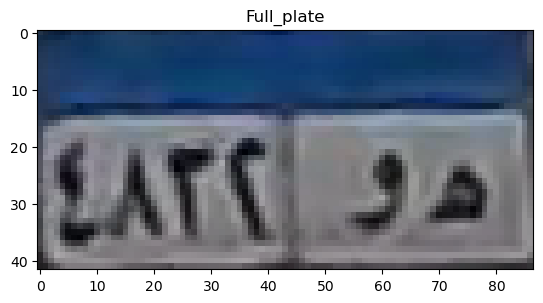

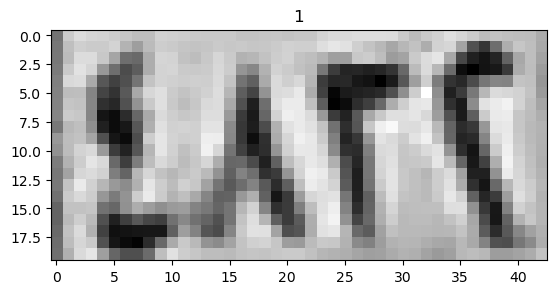

[0.30065137 0.31014627 0.31406784 0.32215608 0.33392078 0.34008235
 0.34400392 0.34764275 0.31234863 0.39580275 0.3761949  0.32354784
 0.31178314 0.31402314 0.29833686 0.26304275 0.26304275 0.27816353
 0.28600667 0.2915949 ]
[0.52418078 0.49446    0.48661686 0.52215608 0.56137176 0.48910196
 0.5087098  0.52411333 0.47705451 0.48992039 0.48599882 0.46080275
 0.42550863 0.50618    0.52578784 0.50225843 0.48265059 0.50169294
 0.48992824 0.45630078]
[0.56757098 0.53589294 0.56726549 0.58490118 0.5692149  0.49076863
 0.50253333 0.51401529 0.49440745 0.5016851  0.54482235 0.52970941
 0.55323882 0.60421922 0.56108196 0.50225843 0.53363098 0.56500353
 0.55323882 0.56218314]
After
[0.30065137 0.31014627 0.31406784 0.32215608 0.33392078 0.34008235
 0.34400392 0.34764275 0.31234863 0.39580275 0.3761949  0.32354784
 0.31178314 0.31402314 0.29833686 0.26304275 0.26304275 0.27816353
 0.28600667 0.2915949 ]


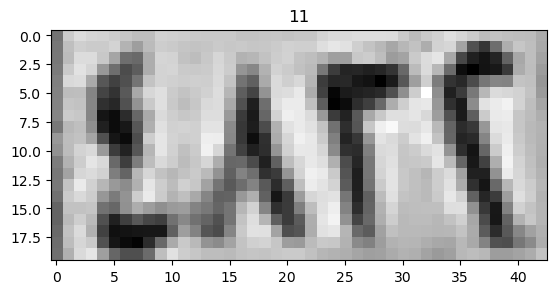

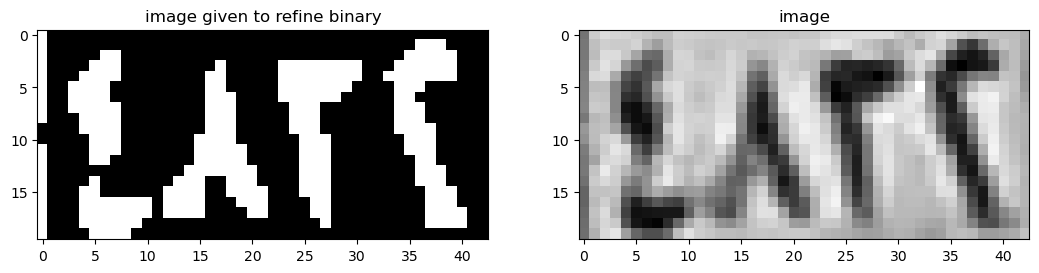

[ True  True  True  True  True  True  True  True  True False False  True
  True  True  True  True  True  True  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False]
After
[False False False False False False False False False False False False
 False False False False False False False False]


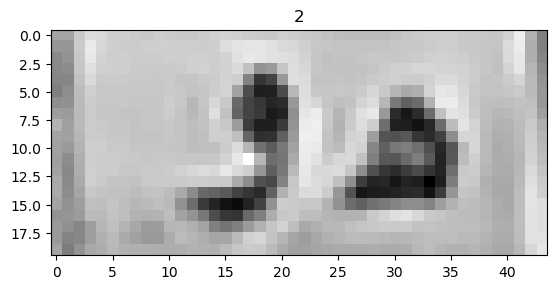

[0.42162471 0.38796745 0.35267333 0.35127451 0.34735294 0.32914392
 0.36835961 0.40814078 0.45519961 0.41933216 0.41148902 0.40783529
 0.41567843 0.43079922 0.43079922 0.41763569 0.37842    0.39410627
 0.39410627 0.41903451]
[0.41628157 0.38627804 0.3784349  0.36078431 0.34509804 0.36443804
 0.37228118 0.39834824 0.41011294 0.41175686 0.39607059 0.36413255
 0.35236784 0.35628941 0.36413255 0.37449843 0.38234157 0.37057686
 0.33920431 0.32294471]
[0.51039922 0.5156898  0.50784667 0.50196078 0.49019608 0.47816353
 0.47424196 0.47285804 0.47285804 0.46665882 0.45881569 0.44648549
 0.44256392 0.43472078 0.42295608 0.40587098 0.39802784 0.34704745
 0.34704745 0.37784667]
After
[0.42162471 0.38796745 0.35267333 0.35127451 0.34735294 0.32914392
 0.36835961 0.40814078 0.45519961 0.41933216 0.41148902 0.40783529
 0.41567843 0.43079922 0.43079922 0.41763569 0.37842    0.39410627
 0.39410627 0.41903451]


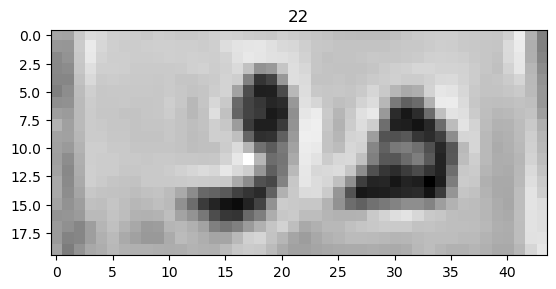

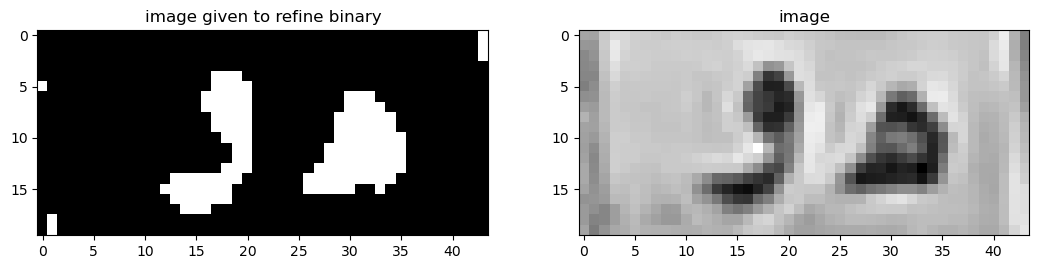

[False False False False False  True False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False  True  True]
[False False False False False False False False False False False False
 False False False False False False False False]
After
[False False False False False  True False False False False False False
 False False False False False False False False]
to horizonatal


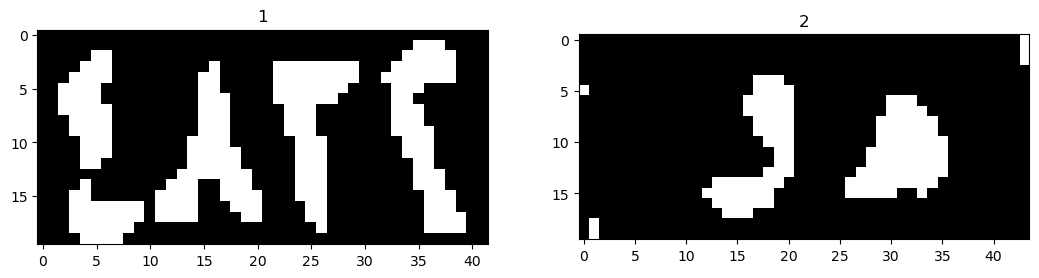

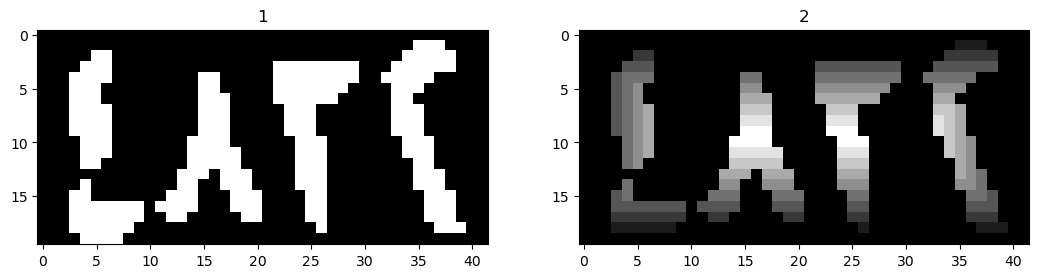

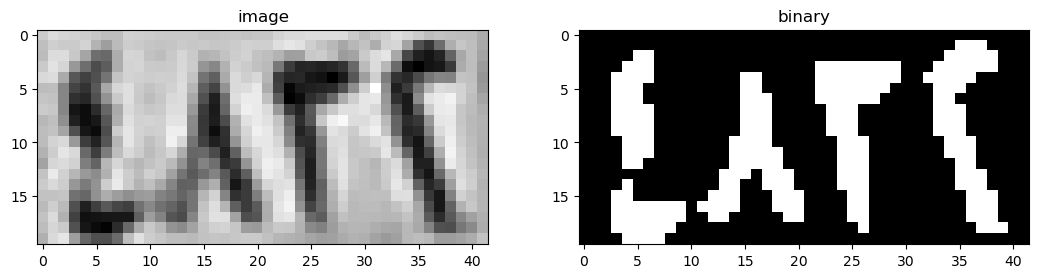

3 10
11 21
22 30
32 40
[(3, 10, array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False,  True,  True, False, False, False, False],
       [False,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True, False, False, False, False],
       [False,  True,  True,  True, False, False, False, False],
       [False,  True,  True, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, F

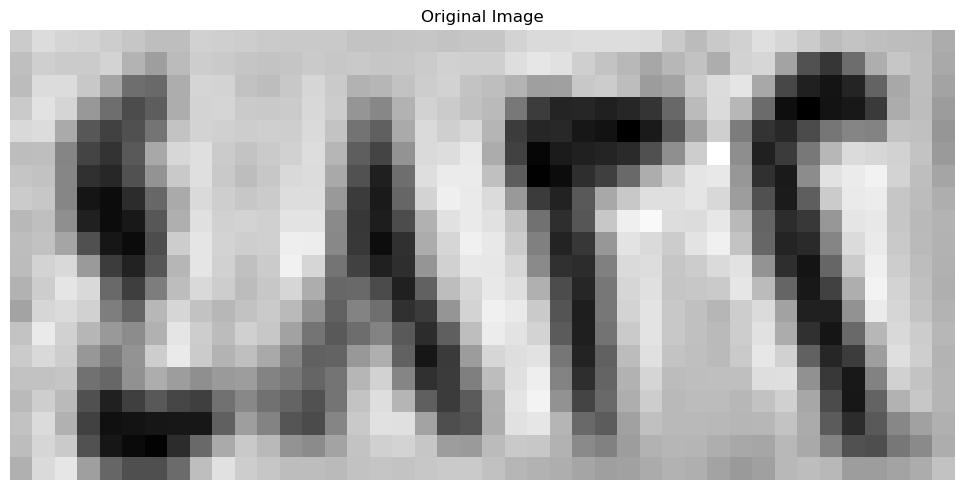

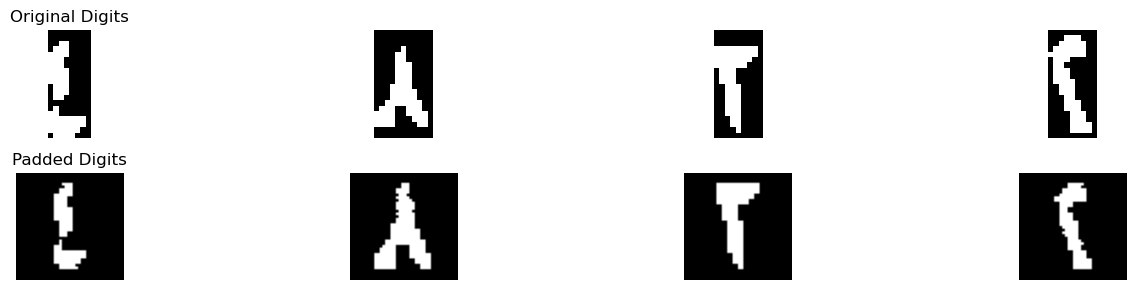

Best match: ٤
Full comparison results: {'١': 1.3125, '٢': 2.8213141025641026, '٣': 1.8833204334365325, '٤': 5.859409340659341, '٥': 2.6590234778121777, '٦': 0.0, '٧': 0.7716911764705883, '٨': 1.0673611111111112, '٩': 1.5124748617395678}
Confidence :  1.5190476190476192
Best match: ٨
Full comparison results: {'١': 2.583333333333333, '٢': 0.9032738095238093, '٣': 0.6666666666666666, '٤': 1.7202380952380951, '٥': 2.1354166666666665, '٦': 0.6502976190476191, '٧': 0.8050595238095237, '٨': 5.7127976190476195, '٩': 2.40625}
Confidence :  1.5647321428571432
Best match: ٣
Full comparison results: {'١': 0.78125, '٢': 5.40625, '٣': 5.911474458204335, '٤': 3.125, '٥': 2.0631496019460416, '٦': 1.65625, '٧': 3.066176470588235, '٨': 0.7555555555555555, '٩': 1.1895424836601307}
Confidence :  0.2526122291021675
Best match: ٢
Full comparison results: {'١': 1.5535714285714286, '٢': 5.116071428571429, '٣': 2.6308049535603715, '٤': 2.7663690476190474, '٥': 2.554769276131505, '٦': 0.9336309523809524, '٧': 1

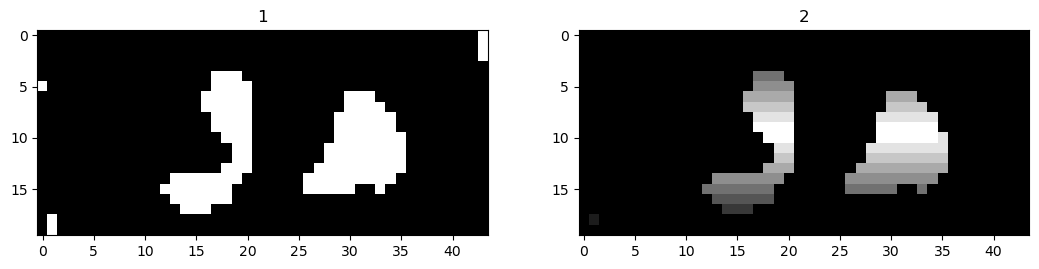

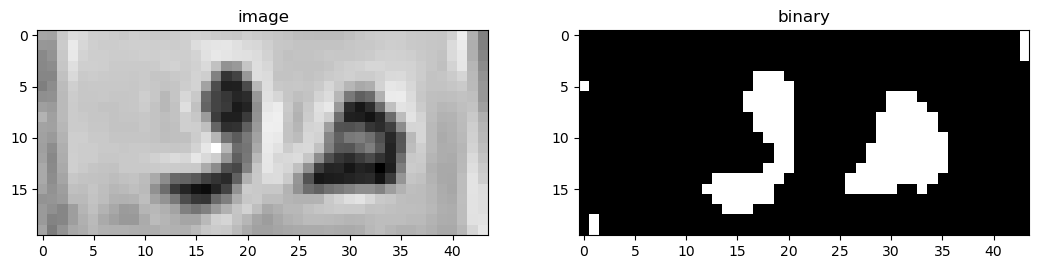

0 2
12 21
26 36
[(12, 21, array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False,  True,  True,  True, False,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False,  True,  True,  True,  True,  True,
        False],
       [False, False, False, False,  True,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False, False, False,  True,  True,  True,
        False],
       [False, Fa

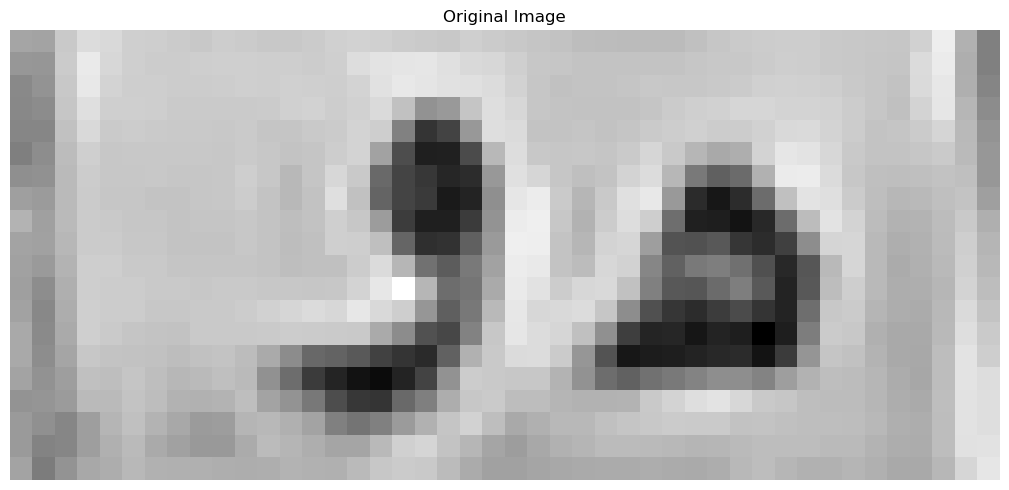

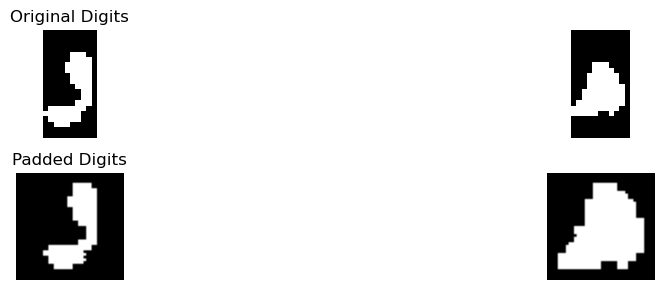

Best match: و
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.21195652173913043, 'د': 0.9460227272727273, 'ر': 0.43211206896551724, 'س': 0.4375, 'ص': 0.28125, 'ط': 0.29166666666666663, 'ع': 0.175, 'ف': 0.4583333333333333, 'ق': 0.50625, 'ك': 0.3958333333333333, 'ل': 0.55625, 'م': 0.225, 'ن': 0.60625, 'ه': 0.78125, 'و': 1.1458333333333335, 'ي': 0.6802884615384616}
Confidence :  0.0999053030303031
Best match: ه
Full comparison results: {'أ': 0.0625, 'ب': 0.125, 'ج': 0.25, 'د': 0.25, 'ر': 0.1875, 'س': 0.21875, 'ص': 0.21875, 'ط': 0.125, 'ع': 0.21875, 'ف': 0.53125, 'ق': 0.125, 'ك': 0.15625, 'ل': 0.09375, 'م': 0.28125, 'ن': 0.15625, 'ه': 0.90625, 'و': 0.375, 'ي': 0.125}
Confidence :  0.1875
[['٤', '٨', '٣', '٢'], ['و', 'ه']]


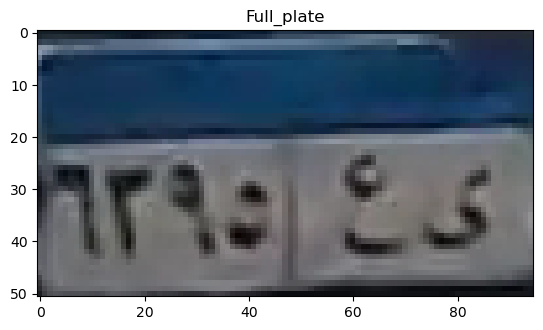

0.0 46.0 2.0 24.0


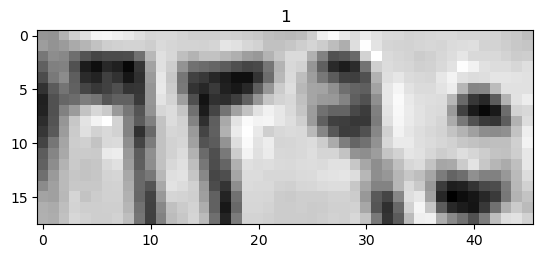

[0.32557255 0.34125882 0.26168863 0.2146298  0.17342706 0.1185251
 0.08097608 0.08489765 0.10842706 0.1280349  0.15548588 0.20646627
 0.21823098 0.24568196 0.30450549 0.35548588 0.3784498  0.38237137]
[0.32165098 0.32165098 0.30874745 0.28129647 0.26754471 0.20479961
 0.18490902 0.18490902 0.19021451 0.20197922 0.26080275 0.29217529
 0.30842706 0.33587804 0.34764275 0.34764275 0.37060667 0.37452824]
[0.38831765 0.33733725 0.29698275 0.28521804 0.30676039 0.25578
 0.22804627 0.28294824 0.32746941 0.33923412 0.35884196 0.3666851
 0.38685843 0.40254471 0.40254471 0.39862314 0.40982235 0.41766549]
After
[0.32557255 0.34125882 0.26168863 0.2146298  0.17342706 0.1185251
 0.08097608 0.08489765 0.10842706 0.1280349  0.15548588 0.20646627
 0.21823098 0.24568196 0.30450549 0.35548588 0.3784498  0.38237137]


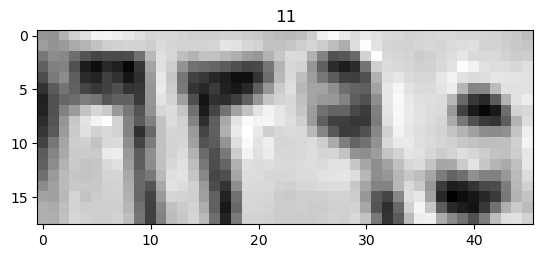

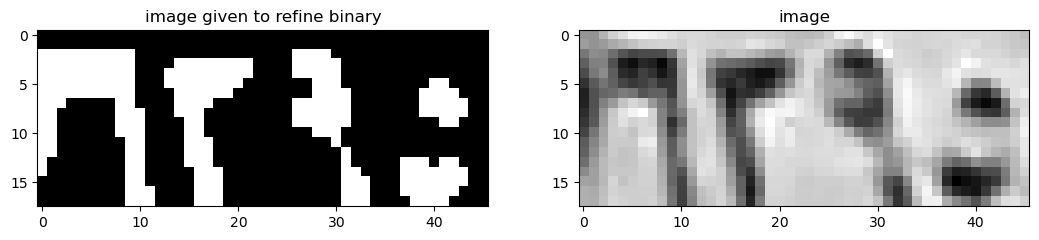

[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False]
[False False  True  True  True  True  True  True  True  True  True  True
  True False False False False False]
[False False  True  True  True  True  True  True False False False False
 False False False False False False]
After
[False False  True  True  True  True  True  True False False False False
 False False False False False False]


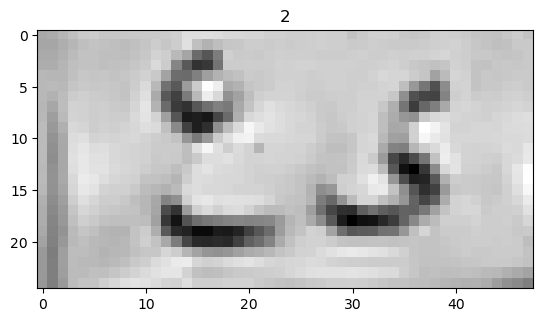

[0.38941882 0.38549725 0.39218667 0.4000298  0.42157216 0.42157216
 0.42155725 0.41763569 0.42294118 0.43078431 0.42908    0.42908
 0.42908    0.42515843 0.42572392 0.42180235 0.40611608 0.39827294
 0.39883843 0.39099529 0.37784667 0.35823882 0.3568549  0.3568549
 0.35490549]
[0.39726196 0.38549725 0.39218667 0.4000298  0.41765059 0.42549373
 0.40979255 0.38626314 0.36803922 0.35627451 0.34672706 0.33888392
 0.33496235 0.34280549 0.34729255 0.34337098 0.33160627 0.32376314
 0.31648549 0.31256392 0.30725843 0.29941529 0.30195294 0.30195294
 0.3039251 ]
[0.41770314 0.40201686 0.40843843 0.41628157 0.41823098 0.42215255
 0.42941529 0.43333686 0.42547882 0.40587098 0.39156863 0.38764706
 0.38764706 0.38764706 0.3904298  0.38258667 0.37082196 0.35905725
 0.35570118 0.34785804 0.35431725 0.37000353 0.37254118 0.36861961
 0.35882706]
After
[0.38941882 0.38549725 0.39218667 0.4000298  0.42157216 0.42157216
 0.42155725 0.41763569 0.42294118 0.43078431 0.42908    0.42908
 0.42908    0.42515843 0

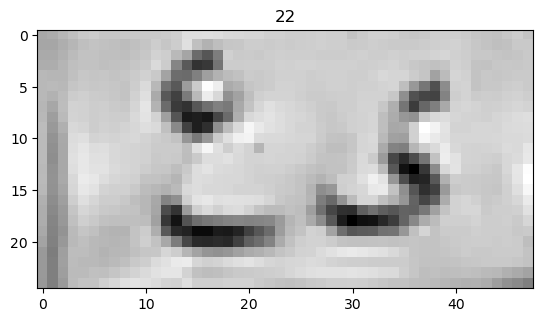

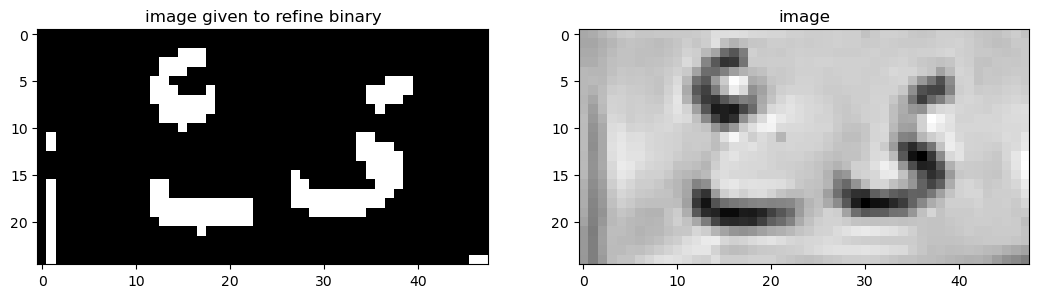

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[False False False False False False False False False False False  True
  True False False False  True  True  True  True  True  True  True  True
  True]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
After
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
to horizonatal


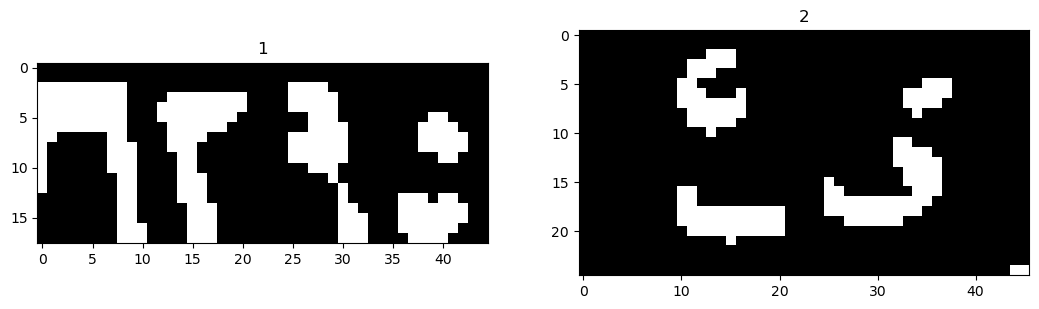

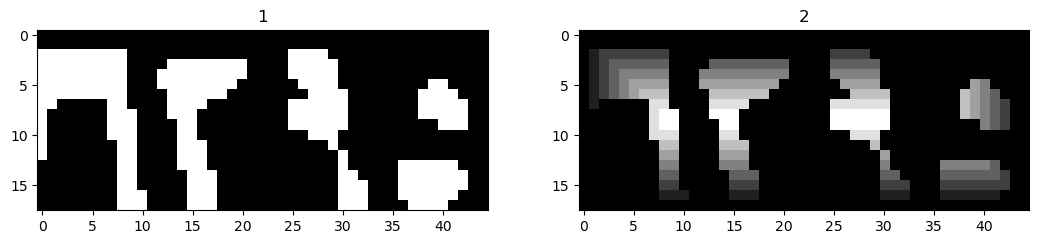

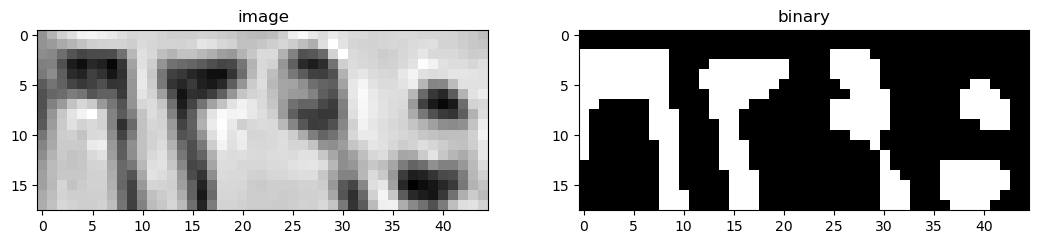

0 11
12 21
25 33
36 43
[(0, 11, array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False],
       [ True,  True, False, False, False, False, False,  True,  True,
        False, False, False],
       [ True, False, False, False, False, False, False,  True,  True,
         True, False, False],
       [ True, False, False, False, False, False, False,  T

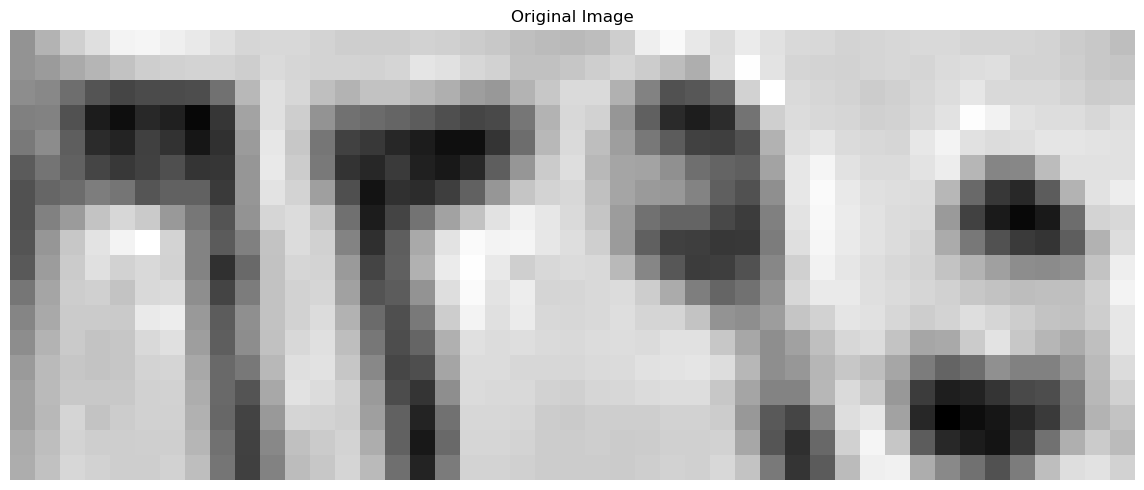

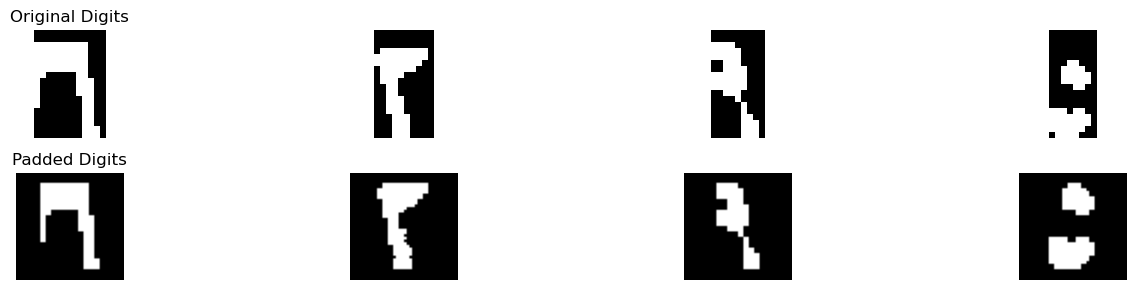

Best match: ٦
Full comparison results: {'١': 0.8181818181818181, '٢': 0.8806818181818182, '٣': 2.5426136363636367, '٤': 0.0, '٥': 3.377840909090909, '٦': 4.079545454545455, '٧': 0.7727272727272727, '٨': 0.8039772727272728, '٩': 2.0369318181818183}
Confidence :  0.35085227272727293
Best match: ٣
Full comparison results: {'١': 0.15789473684210525, '٢': 3.4424342105263155, '٣': 4.692434210526315, '٤': 2.266447368421052, '٥': 2.474310776942356, '٦': 1.4075657894736842, '٧': 2.6138157894736844, '٨': 0.2, '٩': 0.6513157894736842}
Confidence :  0.6249999999999998
Best match: ٩
Full comparison results: {'١': 2.75, '٢': 2.21875, '٣': 2.1000386996904026, '٤': 2.0, '٥': 1.0145860975969334, '٦': 1.58125, '٧': 0.9253676470588235, '٨': 2.9125, '٩': 5.567401960784314}
Confidence :  1.3274509803921568
Best match: ٥
Full comparison results: {'١': 0.7058823529411765, '٢': 1.715073529411765, '٣': 1.2773800309597525, '٤': 2.3970588235294117, '٥': 6.715064315199765, '٦': 1.7750000000000001, '٧': 0.68823529

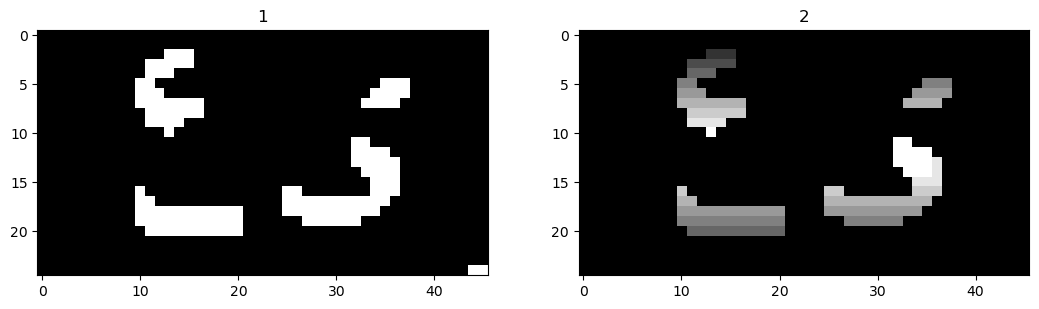

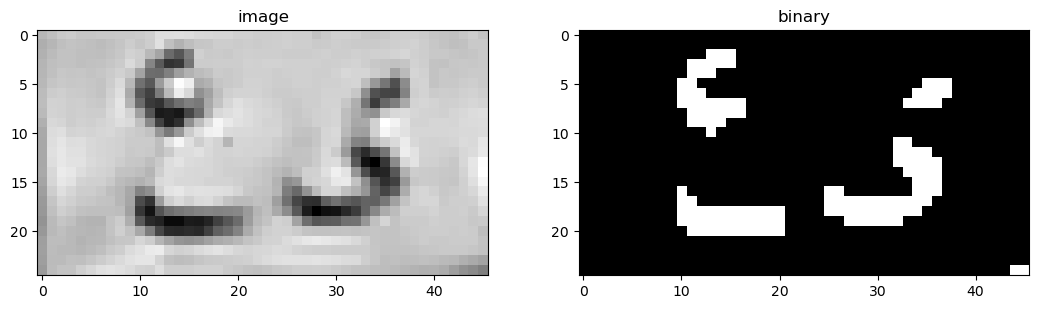

10 21
25 38
44 45
[(10, 21, array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False,  True,  True,  True, False, False, False,
        False, False, False],
       [False,  True,  True,  True,  True,  True, False, False, False,
        False, False, False],
       [False,  True,  True,  True, False, False, False, False, False,
        False, False, False],
       [ True,  True, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True,  True, False, False, False,  True, False, False,
        False, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False],
       [False,  True,  True,  True,  True,  True, False, False,

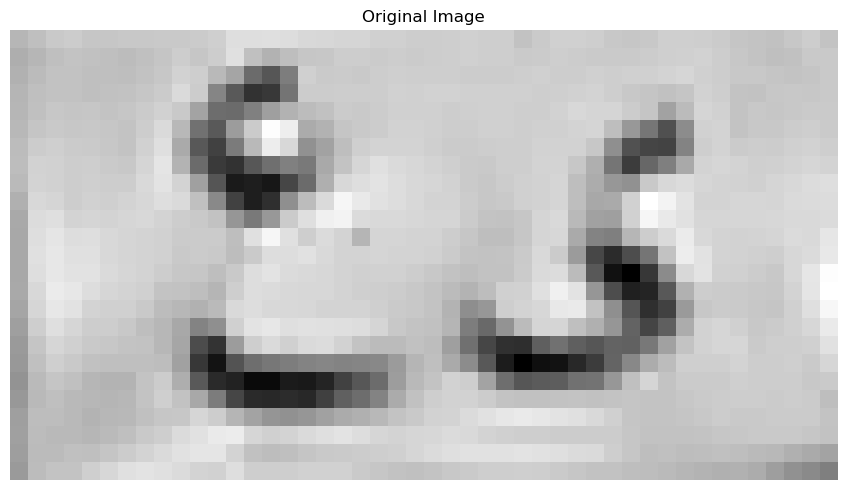

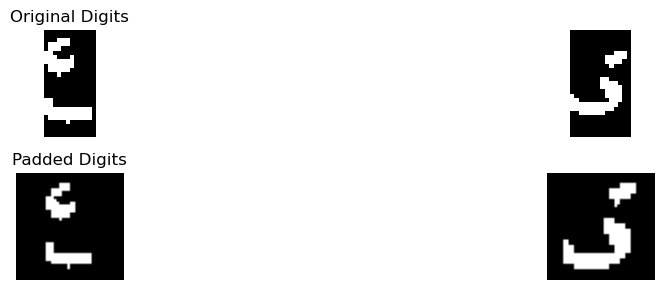

Best match: ع
Full comparison results: {'أ': 0.0, 'ب': 0.0, 'ج': 0.5163043478260869, 'د': 0.4147727272727273, 'ر': 0.2661637931034483, 'س': 0.0625, 'ص': 0.0, 'ط': 0.29166666666666663, 'ع': 1.2292020373514432, 'ف': 0.3101851851851852, 'ق': 0.3042763157894737, 'ك': 0.3854166666666667, 'ل': 0.3290441176470588, 'م': 0.17647058823529413, 'ن': 0.525, 'ه': 0.0, 'و': 0.21875, 'ي': 0.125}
Confidence :  0.3521010186757216
Best match: ي
Full comparison results: {'أ': 0.0, 'ب': 0.09375, 'ج': 0.30439814814814814, 'د': 0.5266203703703703, 'ر': 0.6767241379310345, 'س': 0.5, 'ص': 0.3125, 'ط': 0.7002314814814814, 'ع': 0.2673611111111111, 'ف': 0.8425925925925926, 'ق': 0.5266203703703703, 'ك': 0.7118055555555556, 'ل': 0.4699074074074074, 'م': 0.0, 'ن': 0.6377314814814814, 'ه': 0.40625, 'و': 0.9224537037037037, 'ي': 1.425925925925926}
Confidence :  0.25173611111111116
[['٦', '٣', '٩', '٥'], ['ع', 'ي']]
أعو٨٧٥٦ أعو٨٧٥٦
أقط١٤٧٨ أنط١٤٧٨
أي٦٤٢٤ أي٦٤٢٤
بط٣٥١٧ بط٢٥١٧
بي٢٢١٢ بك٣٢١٢
جل٩١٣٢ جل٩١٣٢
جم٢٧٦٥ جم٢٧٦٥
جن

In [172]:
def compare_result_with_answer(result, answer):
    # Step 1: Flatten the result and join all characters into a single string
    # Flatten the result into a single list
    flattened = [char for sublist in result for char in sublist]
    
    # Separate characters and digits
    characters = [char for char in flattened if not char.isdigit()]
    digits = [char for char in flattened if char.isdigit()]
    
    # Reverse characters and concatenate with digits
    reconstructed_result = ''.join(characters[::-1] + digits)
    
    print(reconstructed_result,answer)
    
    # Step 2: Compare the reconstructed result with the answer
    is_match = reconstructed_result == answer
    
    return is_match

def load_dataset(path_to_dataset):
    features = []
    labels = []
    img_filenames = os.listdir(path_to_dataset)

    for i, fn in enumerate(img_filenames):
        if fn.split('.')[-1] != 'png':
            continue

        label = fn.split('.')[0]
        labels.append(label)

        path = os.path.join(path_to_dataset, fn)
        result = []
        img = rgba2rgb(io.imread(path)) #if not read try to replace io to cv2
        show_images([img],["Full_plate"])
        image1,image1_it,image2,image2_it = split_plate(img)
        padded_digits = character_extraction(image1,image1_it,1)
        answer = test_half(1,padded_digits)
        result.append(answer)
        padded_digits = character_extraction(image2,image2_it,2)
        answer = test_half(2,padded_digits)
        result.append(answer)
        print(result)
        features.append(result)
        
    return features, labels
def getaccuracy(features,labels):
  right=0
  for i in range(len(labels)):
    if(compare_result_with_answer(features[i],labels[i])):
      right += 1
  return 100*right/len(labels)

path_to_dataset = r'./Tests'
features,labels = load_dataset(path_to_dataset)
accuracy = getaccuracy(features,labels)
print(accuracy)

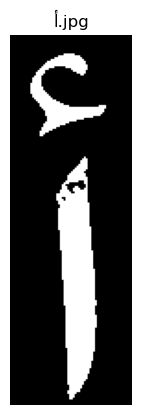

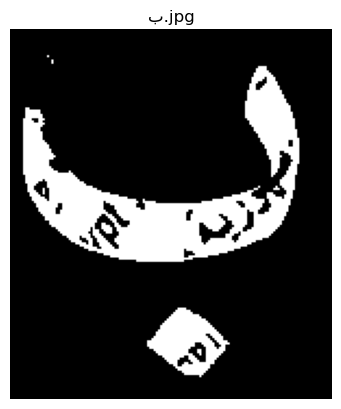

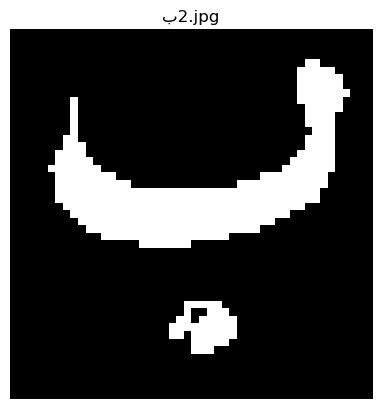

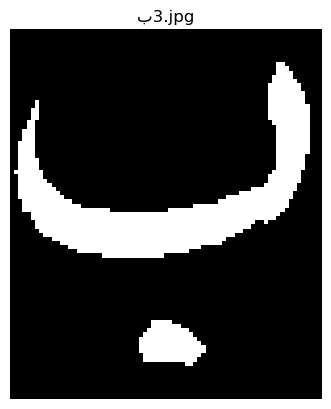

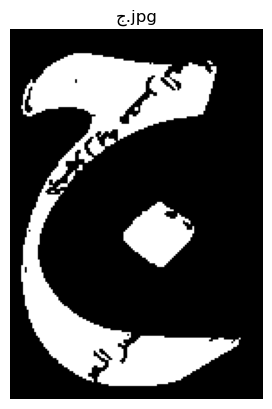

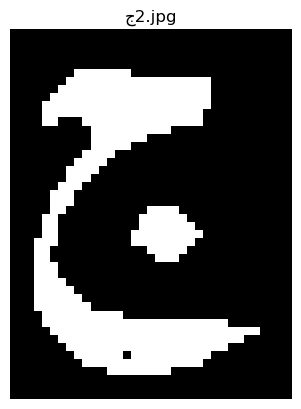

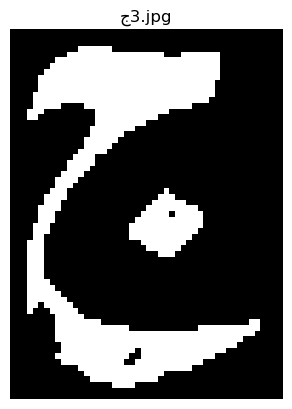

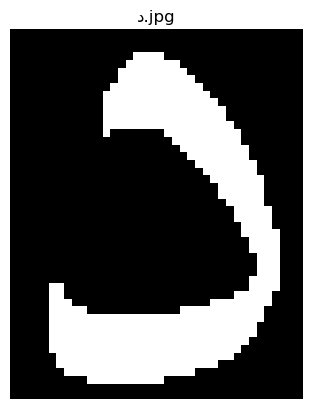

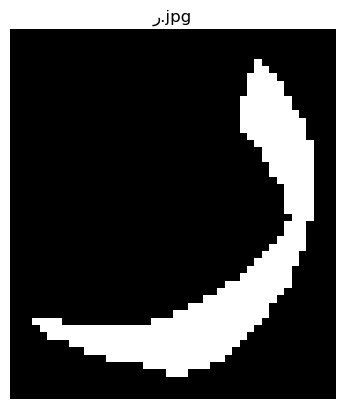

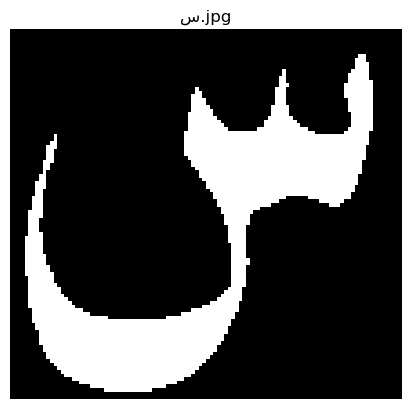

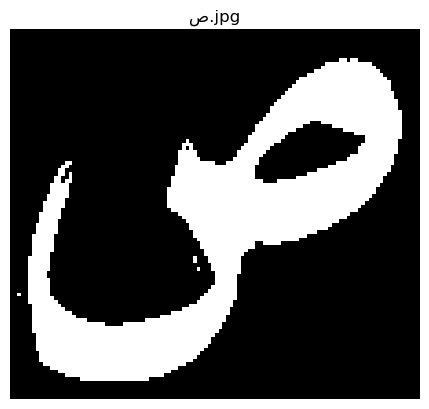

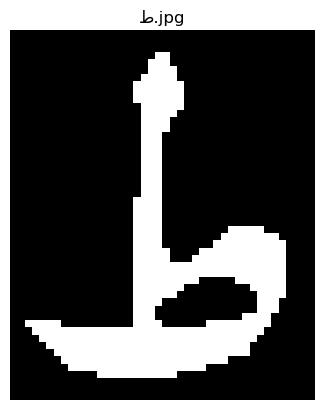

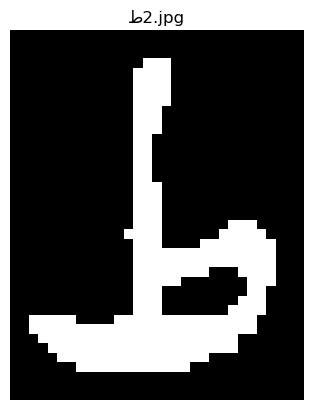

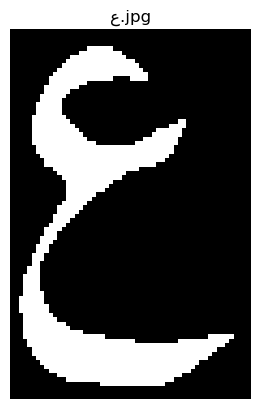

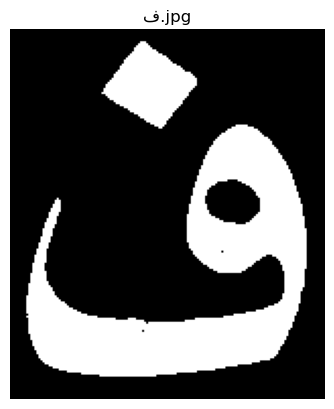

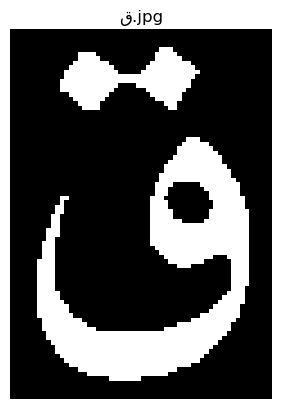

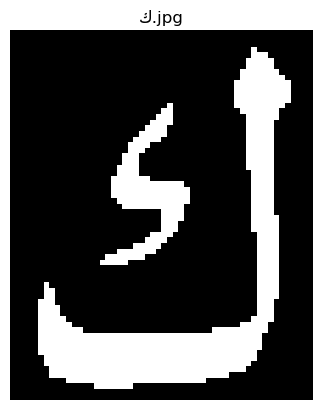

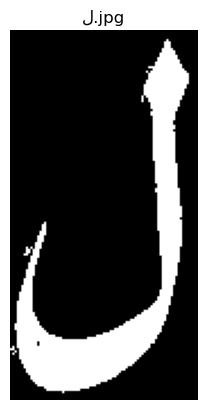

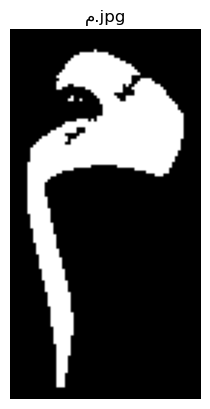

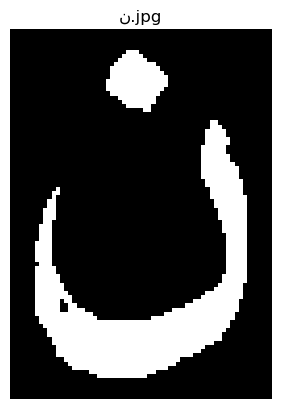

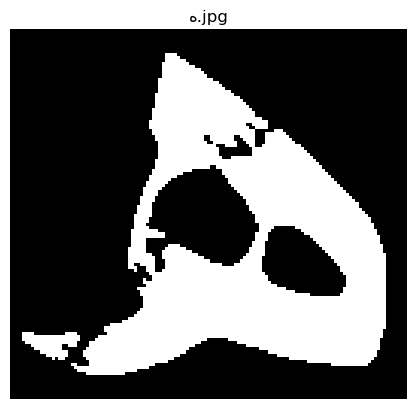

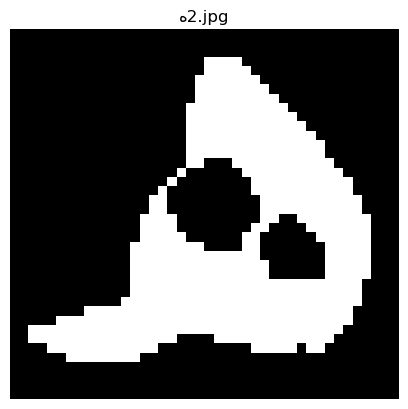

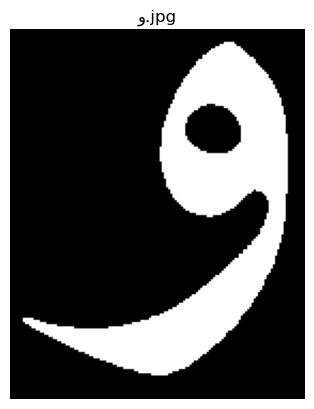

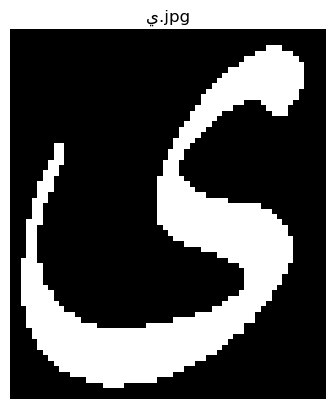

In [19]:
# Path to the folder containing the images
folder_path = "./Reference_Letters"

# Get a list of all files in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.jpg'))]

# Loop through each file, read it, and display it
for image_file in image_files:
    # Construct the full file path
    image_path = os.path.join(folder_path, image_file)
    
    # Read the image
    img = io.imread(image_path)
    img_g = rgb2gray(img)
    img_it = iterativeThreshold(img_g)
    
    # Display the image
    plt.imshow(img_it)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

In [23]:
def rectangular_distance(shape, step=0.1):
    """
    Calculate a rectangular distance matrix where distance is based on layers moving inward.
    
    Args:
        shape (tuple): The shape of the matrix (height, width).
        step (float): The decrement for each inward layer of distance.
        
    Returns:
        numpy.ndarray: Matrix of distances based on rectangular layers.
    """
    height, width = shape
    distance_matrix = np.zeros((height, width), dtype=float)
    
    # Calculate the number of layers
    num_layers = min(height, width) // 2
    
    # Assign distances for each layer
    for layer in range(num_layers):
        distance = 1 - layer * step
        # Stop assigning if distance is less than zero
        if distance < 0:
            break
        # Assign distance to the current layer
        distance_matrix[layer:height-layer, layer:width-layer] = distance 
    
    return distance_matrix

In [144]:
def sub_horizontal_segmentation(image, binary_image_original, min_width=1, max_width=20, min_height=4, offset = 0):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """
    binary_image_new = iterativeThreshold(image)
    eroded = binary_erosion(binary_image_new,np.ones([3,2]))
    dilated = binary_dilation(eroded,np.ones([2,2]))

    show_images([image,binary_image_new,eroded,dilated],["image","binary","eroded","dilated"])

    binary_image = dilated
    
    # Find horizontal projection
    horizontal_projection = np.sum(binary_image, axis=0)
    
    # Find potential digit regions
    digit_regions = []
    in_digit = False
    start = 0
    
    for x in range(len(horizontal_projection)):
        # Check if we're in a potential digit region
        if not in_digit and horizontal_projection[x] > 0:
            start = x
            in_digit = True
        
        # Check if we've exited a digit region
        elif in_digit and (horizontal_projection[x] == 0 or x == len(horizontal_projection)-1):
            end = x
            print(start,end)
            #filtering
            if (end - start >= min_width and end - start <= max_width and np.sum(binary_image_new[:,start:end+1]) > min_height * (end - start)):
        
                # Extract potential digit
                #digit_region = image[:, start:end]
                #digit_region = iterativeThreshold(digit_region)
                digit_region = binary_image_original[:,start:end+1]
                
                digit_regions.append((start + offset, end + offset, digit_region))
            
            in_digit = False
    
    return digit_regions


def horizontal_segmentation_1(image, binary_image_original, min_width=1, max_width=20, min_height=4):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """
    binary_image_new = iterativeThreshold(image)

    show_images([image,binary_image_new],["image","binary"])
    
    # Find horizontal projection
    horizontal_projection = np.sum(binary_image_new, axis=0)
    
    # Find potential digit regions
    digit_regions = []
    in_digit = False
    start = 0
    
    for x in range(len(horizontal_projection)):
        # Check if we're in a potential digit region
        if not in_digit and horizontal_projection[x] > 0:
            start = x
            in_digit = True
        
        # Check if we've exited a digit region
        elif in_digit and (horizontal_projection[x] == 0 or x == len(horizontal_projection)-1):
            end = x
            print(start,end)
            #filtering
            
            while (end - start > max_width):
                sub_regions = sub_horizontal_segmentation(image[:,start:end+1], binary_image_original[:,start:end+1] , min_width, max_width, min_height, start)
                if len(sub_regions) == 0:
                    break
                for x in range(len(sub_regions)):
                    digit_regions.append(sub_regions[x])
                    start = sub_regions[x][1]
                    
            if (end - start >= min_width and end - start <= max_width and np.sum(binary_image_new[:,start:end+1]) > min_height * (end - start) and ((end+start)/2 > len(horizontal_projection)/20 and (end+start)/2 < len(horizontal_projection) - (len(horizontal_projection)/20))):
        
                # Extract potential digit
                #digit_region = image[:, start:end]
                #digit_region = iterativeThreshold(digit_region)
                digit_region = binary_image_original[:,start:end+1]
                
                digit_regions.append((start, end, digit_region))
            
            in_digit = False
    print(digit_regions)
    return digit_regions

def refine_segmentation_1(digit_regions, max_digits=4, min_separation=1, max_width = 14):
    """
    Refine segmentation by merging or filtering regions
    
    Args:
        digit_regions (list): List of detected digit regions
        max_digits (int): Maximum number of expected digits
        min_separation (int): Minimum separation between digits
    
    Returns:
        list: Refined list of digit regions
    """
    # Sort regions from left to right
    sorted_regions = sorted(digit_regions, key=lambda x: x[0])
    
    # Merge closely connected regions
    refined_regions = []
    i = 0
    while i < len(sorted_regions):
        current = sorted_regions[i]
        
        # Look ahead to see if next region is close
        if i + 1 < len(sorted_regions):
            next_region = sorted_regions[i + 1]
            
            # If regions are close, merge them
            #also check connection????
            if next_region[0] - current[1] < min_separation and next_region[1] - current[0] <= max_width:
                # Merge the two regions
                merged_region = (
                    current[0], 
                    next_region[1], 
                    np.hstack((current[2], next_region[2]))
                )
                refined_regions.append(merged_region)
                i += 2
                continue
        
        refined_regions.append(current)
        i += 1
    refined_regions = sorted(refined_regions, key=lambda x: (x[0] - x[1]))
    refined_regions = refined_regions[:max_digits]
    refined_regions = sorted(refined_regions, key=lambda x: x[0])
    # Limit to max expected digits
    return refined_regions[:max_digits]

def vertical_segmentation(image):
    """
    Segment digits horizontally
    
    Args:
        binary_image (numpy.ndarray): Binary image of the license plate
        min_width (int): Minimum width of a valid digit region
        max_width (int): Maximum width of a valid digit region
        min_height (int): Minimum height of a valid digit region
    
    Returns:
        list: List of segmented digit images
    """

    height, width = image.shape
    
    # Find horizontal projection
    vertical_projection = np.sum(image, axis=1)

    vert_max = max(vertical_projection) 
    print(vert_max)
    
    # Find potential digit regions
    regions = []
    in_digit = False
    prev = -1
    start = 0
    
    for x in range(len(vertical_projection)):

        if not in_digit and (vertical_projection[x] > (0.1 * vert_max)):
            in_digit = True
            start = x
            
        if in_digit and (vertical_projection[x] < (0.4 * prev)):
            end = x
            in_digit = False
            regions.append((start, end))

        prev = vertical_projection[x]

    refined_regions = sorted(regions, key=lambda x: x[0])
    if len(refined_regions) > 1:
        if refined_regions[0][1] >= int(0.25 * height) and refined_regions[0][1] <= int(height - (0.25 * height)):
            if refined_regions[1][0] >= int(0.25 * height) and refined_regions[1][0] <= int(height - (0.25 * height)):
                return [(refined_regions[0][0], refined_regions[1][1])]
    return regions

def character_extraction(image_n,image_n_it,current_half):
    height, width = image_n.shape
    image_it = iterativeThreshold(image_n)
    rectangle = 1 - rectangular_distance(np.shape(image_it),0.1)
    image_it_new = image_it * rectangle
    show_images([image_it,image_it_new],["1","2"])
    #vertical_regions = vertical_segmentation(image_it_new)
    #print(vertical_regions)
    #choosen_region = (sorted(vertical_regions, key=lambda x: x[0]-x[1]))[0]
    #print(choosen_region)
    #image_new = image_n[int(choosen_region[0]):int(choosen_region[1]),:]
    #show_images([image_n,image_new],["3","4"])
    if current_half == 1:
        digit_regions = horizontal_segmentation_1(image_n,image_n_it,3,int(0.3*width),3)
    if current_half == 2:
        digit_regions = horizontal_segmentation_1(image_n,image_n_it,2,int(0.3*width),3)
        
    # Refine segmentation
    if current_half == 1:
        refined_regions = refine_segmentation_1(digit_regions,4,4,int(0.3*width))
    if current_half == 2:
        refined_regions = refine_segmentation_1(digit_regions,4,4,int(0.3*width))
    
    # Pad and center digits
    padded_digits = [
        resize(region[2]) 
        for region in refined_regions
    ]
    
    # Visualize segmentation
    visualize_segmentation(image_n, refined_regions,padded_digits)

    return padded_digits
